## Step 1: Install Required Libraries
First, you need to install the necessary Python libraries:

In [1]:
!pip install yt-dlp pytube pandas webvtt-py requests nltk


Defaulting to user installation because normal site-packages is not writeable


In [1]:
import yt_dlp
import os
import webvtt
import pandas as pd
from pytube import Playlist
import requests

# URL of the YouTube playlist
playlist_url = "https://www.youtube.com/playlist?list=PLvgi6sEBVkzuUSxISUJg2AfLf-D3Bgbrm"

# Create a Playlist object
playlist = Playlist(playlist_url)


In [115]:
import os
import requests
import pandas as pd
import webvtt
from pytube import Playlist
import yt_dlp
import re
import time

# Assume `playlist` is a pytube Playlist object already initialized
playlist_url = 'https://www.youtube.com/playlist?list=PLvgi6sEBVkzuUSxISUJg2AfLf-D3Bgbrm'
playlist = Playlist(playlist_url)

# Get all video URLs in the playlist
video_urls = [video.watch_url for video in playlist.videos]

# Directory to save thumbnails and transcripts
output_dir = 'youtube_output'
os.makedirs(output_dir, exist_ok=True)

def sanitize_filename(name):
    return re.sub(r'[\\/*?:"<>|]', "", name)

def download_thumbnail(thumbnail_url, title):
    try:
        response = requests.get(thumbnail_url)
        sanitized_title = sanitize_filename(title)
        thumbnail_file = os.path.join(output_dir, f'{sanitized_title}.jpg')
        with open(thumbnail_file, 'wb') as file:
            file.write(response.content)
        return thumbnail_file
    except Exception as e:
        print(f"Failed to download thumbnail for {title}: {e}")
        return None

def download_video_info(video_url, max_retries=3, retry_interval=180):
    ydl_opts = {
        'writesubtitles': True,
        'writeautomaticsub': True,
        'skip_download': True,
        'outtmpl': os.path.join(output_dir, '%(title)s.%(ext)s'),
        'postprocessors': [{
            'key': 'FFmpegMetadata',
        }],
    }

    retries = 0
    while retries < max_retries:
        try:
            with yt_dlp.YoutubeDL(ydl_opts) as ydl:
                info_dict = ydl.extract_info(video_url, download=False)
                video_title = info_dict.get('title', None)
                video_id = info_dict.get('id', None)
                thumbnail_url = info_dict.get('thumbnail', None)
                publish_date = info_dict.get('upload_date', None)  # Format: 'YYYYMMDD'
                subtitle_languages = info_dict.get('automatic_captions', {}).keys()

                # Download thumbnail
                thumbnail_file = None
                if thumbnail_url:
                    thumbnail_file = download_thumbnail(thumbnail_url, video_title)

                # Download subtitles
                subtitle_file = None
                sanitized_title = sanitize_filename(video_title)
                if 'es' in subtitle_languages:
                    subtitle_file = os.path.join(output_dir, f'{sanitized_title}.es.vtt')
                    if not os.path.exists(subtitle_file):
                        ydl_opts['subtitleslangs'] = ['es']
                        ydl.download([video_url])
                elif subtitle_languages:
                    subtitle_file = os.path.join(output_dir, f'{sanitized_title}.{list(subtitle_languages)[0]}.vtt')
                    if not os.path.exists(subtitle_file):
                        ydl_opts['subtitleslangs'] = [list(subtitle_languages)[0]]
                        ydl.download([video_url])

            # Return the collected video information
            return video_id, video_title, thumbnail_file, subtitle_file, publish_date

        except yt_dlp.utils.DownloadError as e:
            error_message = str(e)
            if "Sign in to confirm you’re not a bot" in error_message:
                retries += 1
                print(f"Error: {error_message}. Retrying in {retry_interval} seconds... (Attempt {retries}/{max_retries})")
                time.sleep(retry_interval)  # Wait before retrying
            else:
                print(f"Failed to download video info for {video_url}: {e}")
                return None, None, None, None, None

    # After max retries, log the failure and return None
    print(f"Max retries reached. Skipping video: {video_url}")
    return None, None, None, None, None

def vtt_to_text(vtt_file_path):
    try:
        text = ''
        lines = []
        deduplicated_lines = []
        for caption in webvtt.read(vtt_file_path):
            # Split the block into lines and deduplicate them within the block
            lines.extend(caption.text.strip().split('\n'))
            #print(caption.text.strip().split('\n'))
        for line in lines:
            if line and (not deduplicated_lines or line != deduplicated_lines[-1]):  # Avoid consecutive duplicates
                deduplicated_lines.append(line)
     
        text = "\n".join(deduplicated_lines)
    
    except Exception as e:
        print(f"Failed to convert {vtt_file_path} to text: {e}")
        
    return text

# Create a list to store video information
data = []

# Loop through each video URL and download the required data
for video_url in video_urls:
    video_id, video_title, thumbnail_file, subtitle_file, publish_date = download_video_info(video_url)
    
    # If video info is successfully retrieved
    if video_id and video_title:
        # Convert subtitles to text if available
        transcript = None
        if subtitle_file and os.path.exists(subtitle_file):
            transcript = vtt_to_text(subtitle_file)
        
        # Append data to the list
        data.append({
            'video_id': video_id,
            'video_title': video_title,
            'thumbnail_path': thumbnail_file,
            'transcript': transcript,
            'publish_date': publish_date
        })

# Convert the list to a DataFrame
df = pd.DataFrame(data, columns=['video_id', 'video_title', 'thumbnail_path', 'transcript', 'publish_date'])

# Save the DataFrame to a CSV file
df.to_csv(os.path.join(output_dir, 'youtube_dataset.csv'), index=False)

print(f"Dataset created successfully with {len(df)} entries.")

[youtube] Extracting URL: https://youtube.com/watch?v=Er8hKhGeirU
[youtube] Er8hKhGeirU: Downloading webpage
[youtube] Er8hKhGeirU: Downloading ios player API JSON
[youtube] Er8hKhGeirU: Downloading web creator player API JSON
[youtube] Er8hKhGeirU: Downloading m3u8 information
[info] Er8hKhGeirU: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=12rWgGwyYac
[youtube] 12rWgGwyYac: Downloading webpage
[youtube] 12rWgGwyYac: Downloading ios player API JSON
[youtube] 12rWgGwyYac: Downloading web creator player API JSON
[youtube] 12rWgGwyYac: Downloading m3u8 information
[info] 12rWgGwyYac: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=DZvkwHXgoNE
[youtube] DZvkwHXgoNE: Downloading webpage
[youtube] DZvkwHXgoNE: Downloading ios player API JSON
[youtube] DZvkwHXgoNE: Downloading web creator player API JSON
[youtube] DZvkwHXgoNE: Downloading m3u8 information
[info] DZvkwHXgoNE: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=DZvkwHXgoNE
[youtube] DZvkwHXgoNE: Downloading webpage
[youtube] DZvkwHXgoNE: Downloading ios player API JSON
[youtube] DZvkwHXgoNE: Downloading web creator player API JSON
[youtube] DZvkwHXgoNE: Downloading m3u8 information
[info] DZvkwHXgoNE: Downloading subtitles: es


[info] DZvkwHXgoNE: Downloading 1 format(s): 18
Deleting existing file youtube_output\Israel acepta respetar tres días de ＂pausas humanitarias＂ en Gaza para vacunar contra la polio.es.vtt
[info] Writing video subtitles to: youtube_output\Israel acepta respetar tres días de ＂pausas humanitarias＂ en Gaza para vacunar contra la polio.es.vtt
[download] Destination: youtube_output\Israel acepta respetar tres días de ＂pausas humanitarias＂ en Gaza para vacunar contra la polio.es.vtt
[download] 100% of   15.91KiB in 00:00:00 at 127.01KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=Ra8PQrIXHe8
[youtube] Ra8PQrIXHe8: Downloading webpage
[youtube] Ra8PQrIXHe8: Downloading ios player API JSON
[youtube] Ra8PQrIXHe8: Downloading web creator player API JSON
[youtube] Ra8PQrIXHe8: Downloading m3u8 information
[info] Ra8PQrIXHe8: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=f8D-dGIC3-I
[youtube] f8D-dGIC3-I: Downloading webpage
[youtube] f8D-dGIC3-I: Downloading ios player API JSON
[youtube] f8D-dGIC3-I: Downloading web creator player API JSON
[youtube] f8D-dGIC3-I: Downloading m3u8 information
[info] f8D-dGIC3-I: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=aJZOlbI-65A
[youtube] aJZOlbI-65A: Downloading webpage
[youtube] aJZOlbI-65A: Downloading ios player API JSON
[youtube] aJZOlbI-65A: Downloading web creator player API JSON
[youtube] aJZOlbI-65A: Downloading m3u8 information
[info] aJZOlbI-65A: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=EYSbi2O8NYU
[youtube] EYSbi2O8NYU: Downloading webpage
[youtube] EYSbi2O8NYU: Downloading ios player API JSON
[youtube] EYSbi2O8NYU: Downloading web creator player API JSON
[youtube] EYSbi2O8NYU: Downloading m3u8 information
[info] EYSbi2O8NYU: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=EYSbi2O8NYU
[youtube] EYSbi2O8NYU: Downloading webpage
[youtube] EYSbi2O8NYU: Downloading ios player API JSON
[youtube] EYSbi2O8NYU: Downloading web creator player API JSON
[youtube] EYSbi2O8NYU: Downloading m3u8 information
[info] EYSbi2O8NYU: Downloading subtitles: es


[info] EYSbi2O8NYU: Downloading 1 format(s): 18
Deleting existing file youtube_output\🔴 DW Noticias 28 de agosto： Israel dice haber ＂eliminado a nueve terroristas ＂[Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\🔴 DW Noticias 28 de agosto： Israel dice haber ＂eliminado a nueve terroristas ＂[Noticiero completo].es.vtt
[download] Destination: youtube_output\🔴 DW Noticias 28 de agosto： Israel dice haber ＂eliminado a nueve terroristas ＂[Noticiero completo].es.vtt
[download] 100% of  214.37KiB in 00:00:00 at 710.34KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=ksj8w0qLzOQ
[youtube] ksj8w0qLzOQ: Downloading webpage
[youtube] ksj8w0qLzOQ: Downloading ios player API JSON
[youtube] ksj8w0qLzOQ: Downloading web creator player API JSON
[youtube] ksj8w0qLzOQ: Downloading m3u8 information
[info] ksj8w0qLzOQ: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=ksj8w0qLzOQ
[youtube] ksj8w0qLzOQ: Downloading webpage
[youtube] ksj8w0qLzOQ: Downloading ios player API JSON
[youtube] ksj8w0qLzOQ: Downloading web creator player API JSON
[youtube] ksj8w0qLzOQ: Downloading m3u8 information
[info] ksj8w0qLzOQ: Downloading subtitles: es


[info] ksj8w0qLzOQ: Downloading 1 format(s): 18
Deleting existing file youtube_output\Israelí realizó lo que considera una ＂operación antiterrorista＂ en Cisjordania ocupada..es.vtt
[info] Writing video subtitles to: youtube_output\Israelí realizó lo que considera una ＂operación antiterrorista＂ en Cisjordania ocupada..es.vtt
[download] Destination: youtube_output\Israelí realizó lo que considera una ＂operación antiterrorista＂ en Cisjordania ocupada..es.vtt
[download] 100% of   50.77KiB in 00:00:00 at 343.74KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=ew_G5zsCCrg
[youtube] ew_G5zsCCrg: Downloading webpage
[youtube] ew_G5zsCCrg: Downloading ios player API JSON
[youtube] ew_G5zsCCrg: Downloading web creator player API JSON
[youtube] ew_G5zsCCrg: Downloading m3u8 information
[info] ew_G5zsCCrg: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=ew_G5zsCCrg
[youtube] ew_G5zsCCrg: Downloading webpage
[youtube] ew_G5zsCCrg: Downloading ios player API JSON
[youtube] ew_G5zsCCrg: Downloading web creator player API JSON
[youtube] ew_G5zsCCrg: Downloading m3u8 information
[info] ew_G5zsCCrg: Downloading subtitles: es


[info] ew_G5zsCCrg: Downloading 1 format(s): 18
Deleting existing file youtube_output\🔴 DW Noticias del 27 de agosto： Israel libera a un rehén de Hamás que estaba cautivo en Gaza.es.vtt
[info] Writing video subtitles to: youtube_output\🔴 DW Noticias del 27 de agosto： Israel libera a un rehén de Hamás que estaba cautivo en Gaza.es.vtt
[download] Destination: youtube_output\🔴 DW Noticias del 27 de agosto： Israel libera a un rehén de Hamás que estaba cautivo en Gaza.es.vtt
[download] 100% of  233.83KiB in 00:00:00 at 710.50KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=cnnIuqzLCFk
[youtube] cnnIuqzLCFk: Downloading webpage
[youtube] cnnIuqzLCFk: Downloading ios player API JSON
[youtube] cnnIuqzLCFk: Downloading web creator player API JSON
[youtube] cnnIuqzLCFk: Downloading m3u8 information
[info] cnnIuqzLCFk: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=28-AmKft0l0
[youtube] 28-AmKft0l0: Downloading webpage
[youtube] 28-AmKft0l0: Downloading ios player API JSON
[youtube] 28-AmKft0l0: Downloading web creator player API JSON
[youtube] 28-AmKft0l0: Downloading m3u8 information
[info] 28-AmKft0l0: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=jpYD9vMUKFQ
[youtube] jpYD9vMUKFQ: Downloading webpage
[youtube] jpYD9vMUKFQ: Downloading ios player API JSON
[youtube] jpYD9vMUKFQ: Downloading web creator player API JSON
[youtube] jpYD9vMUKFQ: Downloading m3u8 information
[info] jpYD9vMUKFQ: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=jpYD9vMUKFQ
[youtube] jpYD9vMUKFQ: Downloading webpage
[youtube] jpYD9vMUKFQ: Downloading ios player API JSON
[youtube] jpYD9vMUKFQ: Downloading web creator player API JSON
[youtube] jpYD9vMUKFQ: Downloading m3u8 information
[info] jpYD9vMUKFQ: Downloading subtitles: es


[info] jpYD9vMUKFQ: Downloading 1 format(s): 18
Deleting existing file youtube_output\🔴 DW Noticias 25 de agosto： Comunidad internacional pide una desescalada [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\🔴 DW Noticias 25 de agosto： Comunidad internacional pide una desescalada [Noticiero completo].es.vtt
[download] Destination: youtube_output\🔴 DW Noticias 25 de agosto： Comunidad internacional pide una desescalada [Noticiero completo].es.vtt
[download] 100% of  114.56KiB in 00:00:00 at 435.11KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=XDripD1Okpg
[youtube] XDripD1Okpg: Downloading webpage
[youtube] XDripD1Okpg: Downloading ios player API JSON
[youtube] XDripD1Okpg: Downloading web creator player API JSON
[youtube] XDripD1Okpg: Downloading m3u8 information
[info] XDripD1Okpg: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=XDripD1Okpg
[youtube] XDripD1Okpg: Downloading webpage
[youtube] XDripD1Okpg: Downloading ios player API JSON
[youtube] XDripD1Okpg: Downloading web creator player API JSON
[youtube] XDripD1Okpg: Downloading m3u8 information
[info] XDripD1Okpg: Downloading subtitles: es


[info] XDripD1Okpg: Downloading 1 format(s): 18
Deleting existing file youtube_output\Netanyahu asegura que su país no ha dicho ＂la última palabra＂.es.vtt
[info] Writing video subtitles to: youtube_output\Netanyahu asegura que su país no ha dicho ＂la última palabra＂.es.vtt
[download] Destination: youtube_output\Netanyahu asegura que su país no ha dicho ＂la última palabra＂.es.vtt
[download] 100% of   40.75KiB in 00:00:00 at 450.58KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=NAVBaOQ9fs8
[youtube] NAVBaOQ9fs8: Downloading webpage
[youtube] NAVBaOQ9fs8: Downloading ios player API JSON
[youtube] NAVBaOQ9fs8: Downloading web creator player API JSON
[youtube] NAVBaOQ9fs8: Downloading m3u8 information
[info] NAVBaOQ9fs8: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=EqAl_REyrD0
[youtube] EqAl_REyrD0: Downloading webpage
[youtube] EqAl_REyrD0: Downloading ios player API JSON
[youtube] EqAl_REyrD0: Downloading web creator player API JSON
[youtube] EqAl_REyrD0: Downloading m3u8 information
[info] EqAl_REyrD0: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=upSwmOA7Bas
[youtube] upSwmOA7Bas: Downloading webpage
[youtube] upSwmOA7Bas: Downloading ios player API JSON
[youtube] upSwmOA7Bas: Downloading web creator player API JSON
[youtube] upSwmOA7Bas: Downloading m3u8 information
[info] upSwmOA7Bas: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=W-jSUclIdz8
[youtube] W-jSUclIdz8: Downloading webpage
[youtube] W-jSUclIdz8: Downloading ios player API JSON
[youtube] W-jSUclIdz8: Downloading web creator player API JSON
[youtube] W-jSUclIdz8: Downloading m3u8 information
[info] W-jSUclIdz8: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=W-jSUclIdz8
[youtube] W-jSUclIdz8: Downloading webpage
[youtube] W-jSUclIdz8: Downloading ios player API JSON
[youtube] W-jSUclIdz8: Downloading web creator player API JSON
[youtube] W-jSUclIdz8: Downloading m3u8 information
[info] W-jSUclIdz8: Downloading subtitles: es


[info] W-jSUclIdz8: Downloading 1 format(s): 18
Deleting existing file youtube_output\🔴 DW Noticias del 20 de agosto： Blinken pide a Hamás que acepte la tregua [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\🔴 DW Noticias del 20 de agosto： Blinken pide a Hamás que acepte la tregua [Noticiero completo].es.vtt
[download] Destination: youtube_output\🔴 DW Noticias del 20 de agosto： Blinken pide a Hamás que acepte la tregua [Noticiero completo].es.vtt
[download] 100% of  208.65KiB in 00:00:00 at 690.17KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=S2wq5J3yerk
[youtube] S2wq5J3yerk: Downloading webpage
[youtube] S2wq5J3yerk: Downloading ios player API JSON
[youtube] S2wq5J3yerk: Downloading web creator player API JSON
[youtube] S2wq5J3yerk: Downloading m3u8 information
[info] S2wq5J3yerk: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=S2wq5J3yerk
[youtube] S2wq5J3yerk: Downloading webpage
[youtube] S2wq5J3yerk: Downloading ios player API JSON
[youtube] S2wq5J3yerk: Downloading web creator player API JSON
[youtube] S2wq5J3yerk: Downloading m3u8 information
[info] S2wq5J3yerk: Downloading subtitles: es


[info] S2wq5J3yerk: Downloading 1 format(s): 18
Deleting existing file youtube_output\Blinken dice que hará ＂todo lo posible＂ para que Hamás acepte la propuesta de tregua en Gaza.es.vtt
[info] Writing video subtitles to: youtube_output\Blinken dice que hará ＂todo lo posible＂ para que Hamás acepte la propuesta de tregua en Gaza.es.vtt
[download] Destination: youtube_output\Blinken dice que hará ＂todo lo posible＂ para que Hamás acepte la propuesta de tregua en Gaza.es.vtt
[download] 100% of   36.29KiB in 00:00:00 at 306.43KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=CnPyyApY7n0
[youtube] CnPyyApY7n0: Downloading webpage
[youtube] CnPyyApY7n0: Downloading ios player API JSON
[youtube] CnPyyApY7n0: Downloading web creator player API JSON
[youtube] CnPyyApY7n0: Downloading m3u8 information
[info] CnPyyApY7n0: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Vu4tq7-8Obo
[youtube] Vu4tq7-8Obo: Downloading webpage
[youtube] Vu4tq7-8Obo: Downloading ios player API JSON
[youtube] Vu4tq7-8Obo: Downloading web creator player API JSON
[youtube] Vu4tq7-8Obo: Downloading m3u8 information
[info] Vu4tq7-8Obo: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Vu4tq7-8Obo
[youtube] Vu4tq7-8Obo: Downloading webpage
[youtube] Vu4tq7-8Obo: Downloading ios player API JSON
[youtube] Vu4tq7-8Obo: Downloading web creator player API JSON
[youtube] Vu4tq7-8Obo: Downloading m3u8 information
[info] Vu4tq7-8Obo: Downloading subtitles: es


[info] Vu4tq7-8Obo: Downloading 1 format(s): 18
Deleting existing file youtube_output\Blinken dice que este es el ＂momento decisivo＂ para alcanzar un acuerdo en Gaza.es.vtt
[info] Writing video subtitles to: youtube_output\Blinken dice que este es el ＂momento decisivo＂ para alcanzar un acuerdo en Gaza.es.vtt
[download] Destination: youtube_output\Blinken dice que este es el ＂momento decisivo＂ para alcanzar un acuerdo en Gaza.es.vtt
[download] 100% of   38.61KiB in 00:00:00 at 377.63KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=PtWomC22rnc
[youtube] PtWomC22rnc: Downloading webpage
[youtube] PtWomC22rnc: Downloading ios player API JSON
[youtube] PtWomC22rnc: Downloading web creator player API JSON
[youtube] PtWomC22rnc: Downloading m3u8 information
[info] PtWomC22rnc: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=RSoH03dbCdw
[youtube] RSoH03dbCdw: Downloading webpage
[youtube] RSoH03dbCdw: Downloading ios player API JSON
[youtube] RSoH03dbCdw: Downloading web creator player API JSON
[youtube] RSoH03dbCdw: Downloading m3u8 information
[info] RSoH03dbCdw: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=2z_8rYz9YAE
[youtube] 2z_8rYz9YAE: Downloading webpage
[youtube] 2z_8rYz9YAE: Downloading ios player API JSON
[youtube] 2z_8rYz9YAE: Downloading web creator player API JSON
[youtube] 2z_8rYz9YAE: Downloading m3u8 information
[info] 2z_8rYz9YAE: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=RdOtWvvf-8w
[youtube] RdOtWvvf-8w: Downloading webpage
[youtube] RdOtWvvf-8w: Downloading ios player API JSON
[youtube] RdOtWvvf-8w: Downloading web creator player API JSON
[youtube] RdOtWvvf-8w: Downloading m3u8 information
[info] RdOtWvvf-8w: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=74u4q8yEPLY
[youtube] 74u4q8yEPLY: Downloading webpage
[youtube] 74u4q8yEPLY: Downloading ios player API JSON
[youtube] 74u4q8yEPLY: Downloading web creator player API JSON
[youtube] 74u4q8yEPLY: Downloading m3u8 information
[info] 74u4q8yEPLY: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=74u4q8yEPLY
[youtube] 74u4q8yEPLY: Downloading webpage
[youtube] 74u4q8yEPLY: Downloading ios player API JSON
[youtube] 74u4q8yEPLY: Downloading web creator player API JSON
[youtube] 74u4q8yEPLY: Downloading m3u8 information
[info] 74u4q8yEPLY: Downloading subtitles: es


[info] 74u4q8yEPLY: Downloading 1 format(s): 18
Deleting existing file youtube_output\ONG israelí denuncia ＂torturas sistemáticas＂ a prisioneros palestinos.es.vtt
[info] Writing video subtitles to: youtube_output\ONG israelí denuncia ＂torturas sistemáticas＂ a prisioneros palestinos.es.vtt
[download] Destination: youtube_output\ONG israelí denuncia ＂torturas sistemáticas＂ a prisioneros palestinos.es.vtt
[download] 100% of   33.80KiB in 00:00:00 at 269.07KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=unLMmMn81b0
[youtube] unLMmMn81b0: Downloading webpage
[youtube] unLMmMn81b0: Downloading ios player API JSON
[youtube] unLMmMn81b0: Downloading web creator player API JSON
[youtube] unLMmMn81b0: Downloading m3u8 information
[info] unLMmMn81b0: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=p89vkVFwvpU
[youtube] p89vkVFwvpU: Downloading webpage
[youtube] p89vkVFwvpU: Downloading ios player API JSON
[youtube] p89vkVFwvpU: Downloading web creator player API JSON
[youtube] p89vkVFwvpU: Downloading m3u8 information
[info] p89vkVFwvpU: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=qDcaDr1mm-Y
[youtube] qDcaDr1mm-Y: Downloading webpage
[youtube] qDcaDr1mm-Y: Downloading ios player API JSON
[youtube] qDcaDr1mm-Y: Downloading web creator player API JSON
[youtube] qDcaDr1mm-Y: Downloading m3u8 information
[info] qDcaDr1mm-Y: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=qDcaDr1mm-Y
[youtube] qDcaDr1mm-Y: Downloading webpage
[youtube] qDcaDr1mm-Y: Downloading ios player API JSON
[youtube] qDcaDr1mm-Y: Downloading web creator player API JSON
[youtube] qDcaDr1mm-Y: Downloading m3u8 information
[info] qDcaDr1mm-Y: Downloading subtitles: es


[info] qDcaDr1mm-Y: Downloading 1 format(s): 18
Deleting existing file youtube_output\¿Enviará Alemania sus tropas para defender a Israel？.es.vtt
[info] Writing video subtitles to: youtube_output\¿Enviará Alemania sus tropas para defender a Israel？.es.vtt
[download] Destination: youtube_output\¿Enviará Alemania sus tropas para defender a Israel？.es.vtt
[download] 100% of    5.43KiB in 00:00:00 at 64.00KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=oGbrXJ7NgUQ
[youtube] oGbrXJ7NgUQ: Downloading webpage
[youtube] oGbrXJ7NgUQ: Downloading ios player API JSON
[youtube] oGbrXJ7NgUQ: Downloading web creator player API JSON
[youtube] oGbrXJ7NgUQ: Downloading m3u8 information
[info] oGbrXJ7NgUQ: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=eEPqSWYbHd4
[youtube] eEPqSWYbHd4: Downloading webpage
[youtube] eEPqSWYbHd4: Downloading ios player API JSON
[youtube] eEPqSWYbHd4: Downloading web creator player API JSON
[youtube] eEPqSWYbHd4: Downloading m3u8 information
[info] eEPqSWYbHd4: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=eEPqSWYbHd4
[youtube] eEPqSWYbHd4: Downloading webpage
[youtube] eEPqSWYbHd4: Downloading ios player API JSON
[youtube] eEPqSWYbHd4: Downloading web creator player API JSON
[youtube] eEPqSWYbHd4: Downloading m3u8 information
[info] eEPqSWYbHd4: Downloading subtitles: es


[info] eEPqSWYbHd4: Downloading 1 format(s): 18
Deleting existing file youtube_output\Israel ordenó evacuar más partes de la designada como ＂zona humanitaria＂ en el norte de Jan Yunis.es.vtt
[info] Writing video subtitles to: youtube_output\Israel ordenó evacuar más partes de la designada como ＂zona humanitaria＂ en el norte de Jan Yunis.es.vtt
[download] Destination: youtube_output\Israel ordenó evacuar más partes de la designada como ＂zona humanitaria＂ en el norte de Jan Yunis.es.vtt
[download] 100% of   30.74KiB in 00:00:00 at 303.77KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=ttuZQxFRNjY
[youtube] ttuZQxFRNjY: Downloading webpage
[youtube] ttuZQxFRNjY: Downloading ios player API JSON
[youtube] ttuZQxFRNjY: Downloading web creator player API JSON
[youtube] ttuZQxFRNjY: Downloading m3u8 information
[info] ttuZQxFRNjY: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=ttuZQxFRNjY
[youtube] ttuZQxFRNjY: Downloading webpage
[youtube] ttuZQxFRNjY: Downloading ios player API JSON
[youtube] ttuZQxFRNjY: Downloading web creator player API JSON
[youtube] ttuZQxFRNjY: Downloading m3u8 information
[info] ttuZQxFRNjY: Downloading subtitles: es


[info] ttuZQxFRNjY: Downloading 1 format(s): 18
Deleting existing file youtube_output\🔴 DW Noticias del 10 de agosto： El Ejército israelí atacó una escuela en Gaza [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\🔴 DW Noticias del 10 de agosto： El Ejército israelí atacó una escuela en Gaza [Noticiero completo].es.vtt
[download] Destination: youtube_output\🔴 DW Noticias del 10 de agosto： El Ejército israelí atacó una escuela en Gaza [Noticiero completo].es.vtt
[download] 100% of  118.21KiB in 00:00:00 at 485.87KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=1-dI9CAkSPo
[youtube] 1-dI9CAkSPo: Downloading webpage
[youtube] 1-dI9CAkSPo: Downloading ios player API JSON
[youtube] 1-dI9CAkSPo: Downloading web creator player API JSON
[youtube] 1-dI9CAkSPo: Downloading m3u8 information
[info] 1-dI9CAkSPo: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=tmMEVAbeNX4
[youtube] tmMEVAbeNX4: Downloading webpage
[youtube] tmMEVAbeNX4: Downloading ios player API JSON
[youtube] tmMEVAbeNX4: Downloading web creator player API JSON
[youtube] tmMEVAbeNX4: Downloading m3u8 information
[info] tmMEVAbeNX4: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=E0sLM2e0u3M
[youtube] E0sLM2e0u3M: Downloading webpage
[youtube] E0sLM2e0u3M: Downloading ios player API JSON
[youtube] E0sLM2e0u3M: Downloading web creator player API JSON
[youtube] E0sLM2e0u3M: Downloading m3u8 information
[info] E0sLM2e0u3M: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=E0sLM2e0u3M
[youtube] E0sLM2e0u3M: Downloading webpage
[youtube] E0sLM2e0u3M: Downloading ios player API JSON
[youtube] E0sLM2e0u3M: Downloading web creator player API JSON
[youtube] E0sLM2e0u3M: Downloading m3u8 information
[info] E0sLM2e0u3M: Downloading subtitles: es


[info] E0sLM2e0u3M: Downloading 1 format(s): 18
Deleting existing file youtube_output\🔴 DW Noticias del 9 de agosto： Israel acepta reanudar las negociaciones [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\🔴 DW Noticias del 9 de agosto： Israel acepta reanudar las negociaciones [Noticiero completo].es.vtt
[download] Destination: youtube_output\🔴 DW Noticias del 9 de agosto： Israel acepta reanudar las negociaciones [Noticiero completo].es.vtt
[download] 100% of  220.36KiB in 00:00:00 at 541.89KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=yUBa1g74RCo
[youtube] yUBa1g74RCo: Downloading webpage
[youtube] yUBa1g74RCo: Downloading ios player API JSON
[youtube] yUBa1g74RCo: Downloading web creator player API JSON
[youtube] yUBa1g74RCo: Downloading m3u8 information
[info] yUBa1g74RCo: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=k1Z_w-lTdDA
[youtube] k1Z_w-lTdDA: Downloading webpage
[youtube] k1Z_w-lTdDA: Downloading ios player API JSON
[youtube] k1Z_w-lTdDA: Downloading web creator player API JSON
[youtube] k1Z_w-lTdDA: Downloading m3u8 information
[info] k1Z_w-lTdDA: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=_AmSAvpq11w
[youtube] _AmSAvpq11w: Downloading webpage
[youtube] _AmSAvpq11w: Downloading ios player API JSON
[youtube] _AmSAvpq11w: Downloading web creator player API JSON
[youtube] _AmSAvpq11w: Downloading m3u8 information
[info] _AmSAvpq11w: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=8D7qIwr1HOo
[youtube] 8D7qIwr1HOo: Downloading webpage
[youtube] 8D7qIwr1HOo: Downloading ios player API JSON
[youtube] 8D7qIwr1HOo: Downloading web creator player API JSON
[youtube] 8D7qIwr1HOo: Downloading m3u8 information
[info] 8D7qIwr1HOo: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=LPhyZQP7fog
[youtube] LPhyZQP7fog: Downloading webpage
[youtube] LPhyZQP7fog: Downloading ios player API JSON
[youtube] LPhyZQP7fog: Downloading web creator player API JSON
[youtube] LPhyZQP7fog: Downloading m3u8 information
[info] LPhyZQP7fog: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=y5NNwe7vscM
[youtube] y5NNwe7vscM: Downloading webpage
[youtube] y5NNwe7vscM: Downloading ios player API JSON
[youtube] y5NNwe7vscM: Downloading web creator player API JSON
[youtube] y5NNwe7vscM: Downloading m3u8 information
[info] y5NNwe7vscM: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=IurRAus3BTw
[youtube] IurRAus3BTw: Downloading webpage
[youtube] IurRAus3BTw: Downloading ios player API JSON
[youtube] IurRAus3BTw: Downloading web creator player API JSON
[youtube] IurRAus3BTw: Downloading m3u8 information
[info] IurRAus3BTw: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Gc_JemkT-Gw
[youtube] Gc_JemkT-Gw: Downloading webpage
[youtube] Gc_JemkT-Gw: Downloading ios player API JSON
[youtube] Gc_JemkT-Gw: Downloading web creator player API JSON
[youtube] Gc_JemkT-Gw: Downloading m3u8 information
[info] Gc_JemkT-Gw: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=-7yQSHOx9vM
[youtube] -7yQSHOx9vM: Downloading webpage
[youtube] -7yQSHOx9vM: Downloading ios player API JSON
[youtube] -7yQSHOx9vM: Downloading web creator player API JSON
[youtube] -7yQSHOx9vM: Downloading m3u8 information
[info] -7yQSHOx9vM: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=qrr8_xq0kZc
[youtube] qrr8_xq0kZc: Downloading webpage
[youtube] qrr8_xq0kZc: Downloading ios player API JSON
[youtube] qrr8_xq0kZc: Downloading web creator player API JSON
[youtube] qrr8_xq0kZc: Downloading m3u8 information
[info] qrr8_xq0kZc: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=qrr8_xq0kZc
[youtube] qrr8_xq0kZc: Downloading webpage
[youtube] qrr8_xq0kZc: Downloading ios player API JSON
[youtube] qrr8_xq0kZc: Downloading web creator player API JSON
[youtube] qrr8_xq0kZc: Downloading m3u8 information
[info] qrr8_xq0kZc: Downloading subtitles: es


[info] qrr8_xq0kZc: Downloading 1 format(s): 18
Deleting existing file youtube_output\🔴 DW Noticias del 5 de agosto： Venganza contra Israel es inevitable, según Irán [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\🔴 DW Noticias del 5 de agosto： Venganza contra Israel es inevitable, según Irán [Noticiero completo].es.vtt
[download] Destination: youtube_output\🔴 DW Noticias del 5 de agosto： Venganza contra Israel es inevitable, según Irán [Noticiero completo].es.vtt
[download] 100% of  222.12KiB in 00:00:00 at 692.33KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=QxfdJBUbPU8
[youtube] QxfdJBUbPU8: Downloading webpage
[youtube] QxfdJBUbPU8: Downloading ios player API JSON
[youtube] QxfdJBUbPU8: Downloading web creator player API JSON
[youtube] QxfdJBUbPU8: Downloading m3u8 information
[info] QxfdJBUbPU8: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=SGAtQmWKfAc
[youtube] SGAtQmWKfAc: Downloading webpage
[youtube] SGAtQmWKfAc: Downloading ios player API JSON
[youtube] SGAtQmWKfAc: Downloading web creator player API JSON
[youtube] SGAtQmWKfAc: Downloading m3u8 information
[info] SGAtQmWKfAc: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=gZJjo6FQbFo
[youtube] gZJjo6FQbFo: Downloading webpage
[youtube] gZJjo6FQbFo: Downloading ios player API JSON
[youtube] gZJjo6FQbFo: Downloading web creator player API JSON
[youtube] gZJjo6FQbFo: Downloading m3u8 information
[info] gZJjo6FQbFo: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=-9qjaPPCByE
[youtube] -9qjaPPCByE: Downloading webpage
[youtube] -9qjaPPCByE: Downloading ios player API JSON
[youtube] -9qjaPPCByE: Downloading web creator player API JSON
[youtube] -9qjaPPCByE: Downloading m3u8 information
[info] -9qjaPPCByE: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=-9qjaPPCByE
[youtube] -9qjaPPCByE: Downloading webpage
[youtube] -9qjaPPCByE: Downloading ios player API JSON
[youtube] -9qjaPPCByE: Downloading web creator player API JSON
[youtube] -9qjaPPCByE: Downloading m3u8 information
[info] -9qjaPPCByE: Downloading subtitles: es


[info] -9qjaPPCByE: Downloading 1 format(s): 18
Deleting existing file youtube_output\🔴 DW Noticias del 4 de agosto： Israel se prepara para una respuesta de Irán [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\🔴 DW Noticias del 4 de agosto： Israel se prepara para una respuesta de Irán [Noticiero completo].es.vtt
[download] Destination: youtube_output\🔴 DW Noticias del 4 de agosto： Israel se prepara para una respuesta de Irán [Noticiero completo].es.vtt
[download] 100% of  115.49KiB in 00:00:00 at 503.51KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=m4v0_8ZUv_8
[youtube] m4v0_8ZUv_8: Downloading webpage
[youtube] m4v0_8ZUv_8: Downloading ios player API JSON
[youtube] m4v0_8ZUv_8: Downloading web creator player API JSON
[youtube] m4v0_8ZUv_8: Downloading m3u8 information
[info] m4v0_8ZUv_8: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=vIZEsDfawiY
[youtube] vIZEsDfawiY: Downloading webpage
[youtube] vIZEsDfawiY: Downloading ios player API JSON
[youtube] vIZEsDfawiY: Downloading web creator player API JSON
[youtube] vIZEsDfawiY: Downloading m3u8 information
[info] vIZEsDfawiY: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=SGI98AW_8Oc
[youtube] SGI98AW_8Oc: Downloading webpage
[youtube] SGI98AW_8Oc: Downloading ios player API JSON
[youtube] SGI98AW_8Oc: Downloading web creator player API JSON
[youtube] SGI98AW_8Oc: Downloading m3u8 information
[info] SGI98AW_8Oc: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=SGI98AW_8Oc
[youtube] SGI98AW_8Oc: Downloading webpage
[youtube] SGI98AW_8Oc: Downloading ios player API JSON
[youtube] SGI98AW_8Oc: Downloading web creator player API JSON
[youtube] SGI98AW_8Oc: Downloading m3u8 information
[info] SGI98AW_8Oc: Downloading subtitles: es


[info] SGI98AW_8Oc: Downloading 1 format(s): 18
Deleting existing file youtube_output\¿Quién será el sustituto del brazo político de Hamás？.es.vtt
[info] Writing video subtitles to: youtube_output\¿Quién será el sustituto del brazo político de Hamás？.es.vtt
[download] Destination: youtube_output\¿Quién será el sustituto del brazo político de Hamás？.es.vtt
[download] 100% of   18.99KiB in 00:00:00 at 199.95KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=6YhKABm5sXE
[youtube] 6YhKABm5sXE: Downloading webpage
[youtube] 6YhKABm5sXE: Downloading ios player API JSON
[youtube] 6YhKABm5sXE: Downloading web creator player API JSON
[youtube] 6YhKABm5sXE: Downloading m3u8 information
[info] 6YhKABm5sXE: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Cp2tQRDNo-Y
[youtube] Cp2tQRDNo-Y: Downloading webpage
[youtube] Cp2tQRDNo-Y: Downloading ios player API JSON
[youtube] Cp2tQRDNo-Y: Downloading web creator player API JSON
[youtube] Cp2tQRDNo-Y: Downloading m3u8 information
[info] Cp2tQRDNo-Y: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Cp2tQRDNo-Y
[youtube] Cp2tQRDNo-Y: Downloading webpage
[youtube] Cp2tQRDNo-Y: Downloading ios player API JSON
[youtube] Cp2tQRDNo-Y: Downloading web creator player API JSON
[youtube] Cp2tQRDNo-Y: Downloading m3u8 information
[info] Cp2tQRDNo-Y: Downloading subtitles: es


[info] Cp2tQRDNo-Y: Downloading 1 format(s): 18
Deleting existing file youtube_output\🔴 DW Noticias 31 de julio： Muerte de líderes islamistas dinamita negociaciones [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\🔴 DW Noticias 31 de julio： Muerte de líderes islamistas dinamita negociaciones [Noticiero completo].es.vtt
[download] Destination: youtube_output\🔴 DW Noticias 31 de julio： Muerte de líderes islamistas dinamita negociaciones [Noticiero completo].es.vtt
[download] 100% of  223.04KiB in 00:00:00 at 668.91KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=i8mXe7J9-h8
[youtube] i8mXe7J9-h8: Downloading webpage
[youtube] i8mXe7J9-h8: Downloading ios player API JSON
[youtube] i8mXe7J9-h8: Downloading web creator player API JSON
[youtube] i8mXe7J9-h8: Downloading m3u8 information
[info] i8mXe7J9-h8: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=BDfhfy95xxU
[youtube] BDfhfy95xxU: Downloading webpage
[youtube] BDfhfy95xxU: Downloading ios player API JSON
[youtube] BDfhfy95xxU: Downloading web creator player API JSON
[youtube] BDfhfy95xxU: Downloading m3u8 information
[info] BDfhfy95xxU: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=UjyIxCF9Rgo
[youtube] UjyIxCF9Rgo: Downloading webpage
[youtube] UjyIxCF9Rgo: Downloading ios player API JSON
[youtube] UjyIxCF9Rgo: Downloading web creator player API JSON
[youtube] UjyIxCF9Rgo: Downloading m3u8 information
[info] UjyIxCF9Rgo: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=nb6mBkWvQ5I
[youtube] nb6mBkWvQ5I: Downloading webpage
[youtube] nb6mBkWvQ5I: Downloading ios player API JSON
[youtube] nb6mBkWvQ5I: Downloading web creator player API JSON
[youtube] nb6mBkWvQ5I: Downloading m3u8 information
[info] nb6mBkWvQ5I: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=FqrueAVxOy4
[youtube] FqrueAVxOy4: Downloading webpage
[youtube] FqrueAVxOy4: Downloading ios player API JSON
[youtube] FqrueAVxOy4: Downloading web creator player API JSON
[youtube] FqrueAVxOy4: Downloading m3u8 information
[info] FqrueAVxOy4: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=FqrueAVxOy4
[youtube] FqrueAVxOy4: Downloading webpage
[youtube] FqrueAVxOy4: Downloading ios player API JSON
[youtube] FqrueAVxOy4: Downloading web creator player API JSON
[youtube] FqrueAVxOy4: Downloading m3u8 information
[info] FqrueAVxOy4: Downloading subtitles: es


[info] FqrueAVxOy4: Downloading 1 format(s): 18
Deleting existing file youtube_output\Israel advierte una ＂respuesta severa＂ por ataque contra los Altos del Golán..es.vtt
[info] Writing video subtitles to: youtube_output\Israel advierte una ＂respuesta severa＂ por ataque contra los Altos del Golán..es.vtt
[download] Destination: youtube_output\Israel advierte una ＂respuesta severa＂ por ataque contra los Altos del Golán..es.vtt
[download] 100% of   18.65KiB in 00:00:00 at 203.05KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=thyRawMPf0s
[youtube] thyRawMPf0s: Downloading webpage
[youtube] thyRawMPf0s: Downloading ios player API JSON
[youtube] thyRawMPf0s: Downloading web creator player API JSON
[youtube] thyRawMPf0s: Downloading m3u8 information
[info] thyRawMPf0s: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=thyRawMPf0s
[youtube] thyRawMPf0s: Downloading webpage
[youtube] thyRawMPf0s: Downloading ios player API JSON
[youtube] thyRawMPf0s: Downloading web creator player API JSON
[youtube] thyRawMPf0s: Downloading m3u8 information
[info] thyRawMPf0s: Downloading subtitles: es


[info] thyRawMPf0s: Downloading 1 format(s): 18
Deleting existing file youtube_output\🔴 DW Noticias del 28 de julio： Se agrava el riesgo de guerra Israel-Hizbulá  [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\🔴 DW Noticias del 28 de julio： Se agrava el riesgo de guerra Israel-Hizbulá  [Noticiero completo].es.vtt
[download] Destination: youtube_output\🔴 DW Noticias del 28 de julio： Se agrava el riesgo de guerra Israel-Hizbulá  [Noticiero completo].es.vtt
[download] 100% of  125.09KiB in 00:00:00 at 431.88KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=clddVdhQzUg
[youtube] clddVdhQzUg: Downloading webpage
[youtube] clddVdhQzUg: Downloading ios player API JSON
[youtube] clddVdhQzUg: Downloading web creator player API JSON
[youtube] clddVdhQzUg: Downloading m3u8 information
[info] clddVdhQzUg: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=LIwCzAW5Qqo
[youtube] LIwCzAW5Qqo: Downloading webpage
[youtube] LIwCzAW5Qqo: Downloading ios player API JSON
[youtube] LIwCzAW5Qqo: Downloading web creator player API JSON
[youtube] LIwCzAW5Qqo: Downloading m3u8 information
[info] LIwCzAW5Qqo: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=JjuerGyc7RA
[youtube] JjuerGyc7RA: Downloading webpage
[youtube] JjuerGyc7RA: Downloading ios player API JSON
[youtube] JjuerGyc7RA: Downloading web creator player API JSON
[youtube] JjuerGyc7RA: Downloading m3u8 information
[info] JjuerGyc7RA: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=ixiXAOWPoKg
[youtube] ixiXAOWPoKg: Downloading webpage
[youtube] ixiXAOWPoKg: Downloading ios player API JSON
[youtube] ixiXAOWPoKg: Downloading web creator player API JSON
[youtube] ixiXAOWPoKg: Downloading m3u8 information
[info] ixiXAOWPoKg: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=ECvMEG4W6VQ
[youtube] ECvMEG4W6VQ: Downloading webpage
[youtube] ECvMEG4W6VQ: Downloading ios player API JSON
[youtube] ECvMEG4W6VQ: Downloading web creator player API JSON
[youtube] ECvMEG4W6VQ: Downloading m3u8 information
[info] ECvMEG4W6VQ: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Q8NMuqaLGA4
[youtube] Q8NMuqaLGA4: Downloading webpage
[youtube] Q8NMuqaLGA4: Downloading ios player API JSON
[youtube] Q8NMuqaLGA4: Downloading web creator player API JSON
[youtube] Q8NMuqaLGA4: Downloading m3u8 information
[info] Q8NMuqaLGA4: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=DVLS6480NYQ
[youtube] DVLS6480NYQ: Downloading webpage
[youtube] DVLS6480NYQ: Downloading ios player API JSON
[youtube] DVLS6480NYQ: Downloading web creator player API JSON
[youtube] DVLS6480NYQ: Downloading m3u8 information
[info] DVLS6480NYQ: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=po6bcbRF9Qo
[youtube] po6bcbRF9Qo: Downloading webpage
[youtube] po6bcbRF9Qo: Downloading ios player API JSON
[youtube] po6bcbRF9Qo: Downloading web creator player API JSON
[youtube] po6bcbRF9Qo: Downloading m3u8 information
[info] po6bcbRF9Qo: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=G7S1krzLmnE
[youtube] G7S1krzLmnE: Downloading webpage
[youtube] G7S1krzLmnE: Downloading ios player API JSON
[youtube] G7S1krzLmnE: Downloading web creator player API JSON
[youtube] G7S1krzLmnE: Downloading m3u8 information
[info] G7S1krzLmnE: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=G7S1krzLmnE
[youtube] G7S1krzLmnE: Downloading webpage
[youtube] G7S1krzLmnE: Downloading ios player API JSON
[youtube] G7S1krzLmnE: Downloading web creator player API JSON
[youtube] G7S1krzLmnE: Downloading m3u8 information
[info] G7S1krzLmnE: Downloading subtitles: es


[info] G7S1krzLmnE: Downloading 1 format(s): 18
Deleting existing file youtube_output\Milicia islamista hutí advierte a Israel con una respuesta a su ataque “sin líneas rojas＂.es.vtt
[info] Writing video subtitles to: youtube_output\Milicia islamista hutí advierte a Israel con una respuesta a su ataque “sin líneas rojas＂.es.vtt
[download] Destination: youtube_output\Milicia islamista hutí advierte a Israel con una respuesta a su ataque “sin líneas rojas＂.es.vtt
[download] 100% of    6.53KiB in 00:00:00 at 63.20KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=58B32eZL96s
[youtube] 58B32eZL96s: Downloading webpage
[youtube] 58B32eZL96s: Downloading ios player API JSON
[youtube] 58B32eZL96s: Downloading web creator player API JSON
[youtube] 58B32eZL96s: Downloading m3u8 information
[info] 58B32eZL96s: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=58B32eZL96s
[youtube] 58B32eZL96s: Downloading webpage
[youtube] 58B32eZL96s: Downloading ios player API JSON
[youtube] 58B32eZL96s: Downloading web creator player API JSON
[youtube] 58B32eZL96s: Downloading m3u8 information
[info] 58B32eZL96s: Downloading subtitles: es


[info] 58B32eZL96s: Downloading 1 format(s): 18
Deleting existing file youtube_output\Nueva escalada en Oriente Medio： se intensifican las tensiones entre Israel y la milicia del Líbano.es.vtt
[info] Writing video subtitles to: youtube_output\Nueva escalada en Oriente Medio： se intensifican las tensiones entre Israel y la milicia del Líbano.es.vtt
[download] Destination: youtube_output\Nueva escalada en Oriente Medio： se intensifican las tensiones entre Israel y la milicia del Líbano.es.vtt
[download] 100% of   22.64KiB in 00:00:00 at 156.50KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=HPixPYMqUAA
[youtube] HPixPYMqUAA: Downloading webpage
[youtube] HPixPYMqUAA: Downloading ios player API JSON
[youtube] HPixPYMqUAA: Downloading web creator player API JSON
[youtube] HPixPYMqUAA: Downloading m3u8 information
[info] HPixPYMqUAA: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=y2tCjNRvnGs
[youtube] y2tCjNRvnGs: Downloading webpage
[youtube] y2tCjNRvnGs: Downloading ios player API JSON
[youtube] y2tCjNRvnGs: Downloading web creator player API JSON
[youtube] y2tCjNRvnGs: Downloading m3u8 information
[info] y2tCjNRvnGs: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=OETnZqeccyc
[youtube] OETnZqeccyc: Downloading webpage
[youtube] OETnZqeccyc: Downloading ios player API JSON
[youtube] OETnZqeccyc: Downloading web creator player API JSON
[youtube] OETnZqeccyc: Downloading m3u8 information
[info] OETnZqeccyc: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=DFNYKSfTYZc
[youtube] DFNYKSfTYZc: Downloading webpage
[youtube] DFNYKSfTYZc: Downloading ios player API JSON
[youtube] DFNYKSfTYZc: Downloading web creator player API JSON
[youtube] DFNYKSfTYZc: Downloading m3u8 information
[info] DFNYKSfTYZc: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=DFNYKSfTYZc
[youtube] DFNYKSfTYZc: Downloading webpage
[youtube] DFNYKSfTYZc: Downloading ios player API JSON
[youtube] DFNYKSfTYZc: Downloading web creator player API JSON
[youtube] DFNYKSfTYZc: Downloading m3u8 information
[info] DFNYKSfTYZc: Downloading subtitles: es


[info] DFNYKSfTYZc: Downloading 1 format(s): 18
Deleting existing file youtube_output\Corte Internacional de Justicia afirma que ocupación israelí de territorios palestinos es ＂ilegal＂.es.vtt
[info] Writing video subtitles to: youtube_output\Corte Internacional de Justicia afirma que ocupación israelí de territorios palestinos es ＂ilegal＂.es.vtt
[download] Destination: youtube_output\Corte Internacional de Justicia afirma que ocupación israelí de territorios palestinos es ＂ilegal＂.es.vtt
[download] 100% of   61.89KiB in 00:00:00 at 154.53KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=Ooqd8OSLcS0
[youtube] Ooqd8OSLcS0: Downloading webpage
[youtube] Ooqd8OSLcS0: Downloading ios player API JSON
[youtube] Ooqd8OSLcS0: Downloading web creator player API JSON
[youtube] Ooqd8OSLcS0: Downloading m3u8 information
[info] Ooqd8OSLcS0: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=G_lixlTfgO0
[youtube] G_lixlTfgO0: Downloading webpage
[youtube] G_lixlTfgO0: Downloading ios player API JSON
[youtube] G_lixlTfgO0: Downloading web creator player API JSON
[youtube] G_lixlTfgO0: Downloading m3u8 information
[info] G_lixlTfgO0: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=G_lixlTfgO0
[youtube] G_lixlTfgO0: Downloading webpage
[youtube] G_lixlTfgO0: Downloading ios player API JSON
[youtube] G_lixlTfgO0: Downloading web creator player API JSON
[youtube] G_lixlTfgO0: Downloading m3u8 information
[info] G_lixlTfgO0: Downloading subtitles: es


[info] G_lixlTfgO0: Downloading 1 format(s): 18
Deleting existing file youtube_output\Netanyahu quiere aumentar la ＂presión＂ contra Hamás en medio de un alto número de muertes civiles.es.vtt
[info] Writing video subtitles to: youtube_output\Netanyahu quiere aumentar la ＂presión＂ contra Hamás en medio de un alto número de muertes civiles.es.vtt
[download] Destination: youtube_output\Netanyahu quiere aumentar la ＂presión＂ contra Hamás en medio de un alto número de muertes civiles.es.vtt
[download] 100% of   15.71KiB in 00:00:00 at 99.85KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=ypNtrPb8DX4
[youtube] ypNtrPb8DX4: Downloading webpage
[youtube] ypNtrPb8DX4: Downloading ios player API JSON
[youtube] ypNtrPb8DX4: Downloading web creator player API JSON
[youtube] ypNtrPb8DX4: Downloading m3u8 information
[info] ypNtrPb8DX4: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=ASXOPDfW3nI
[youtube] ASXOPDfW3nI: Downloading webpage
[youtube] ASXOPDfW3nI: Downloading ios player API JSON
[youtube] ASXOPDfW3nI: Downloading web creator player API JSON
[youtube] ASXOPDfW3nI: Downloading m3u8 information
[info] ASXOPDfW3nI: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Z2WSJUrCLEM
[youtube] Z2WSJUrCLEM: Downloading webpage
[youtube] Z2WSJUrCLEM: Downloading ios player API JSON
[youtube] Z2WSJUrCLEM: Downloading web creator player API JSON
[youtube] Z2WSJUrCLEM: Downloading m3u8 information
[info] Z2WSJUrCLEM: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=-OwnsptF8Ic
[youtube] -OwnsptF8Ic: Downloading webpage
[youtube] -OwnsptF8Ic: Downloading ios player API JSON
[youtube] -OwnsptF8Ic: Downloading web creator player API JSON
[youtube] -OwnsptF8Ic: Downloading m3u8 information
[info] -OwnsptF8Ic: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=3R7CjZNoln4
[youtube] 3R7CjZNoln4: Downloading webpage
[youtube] 3R7CjZNoln4: Downloading ios player API JSON
[youtube] 3R7CjZNoln4: Downloading web creator player API JSON
[youtube] 3R7CjZNoln4: Downloading m3u8 information
[info] 3R7CjZNoln4: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Iam3qWuENqU
[youtube] Iam3qWuENqU: Downloading webpage
[youtube] Iam3qWuENqU: Downloading ios player API JSON
[youtube] Iam3qWuENqU: Downloading web creator player API JSON
[youtube] Iam3qWuENqU: Downloading m3u8 information
[info] Iam3qWuENqU: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Iam3qWuENqU
[youtube] Iam3qWuENqU: Downloading webpage
[youtube] Iam3qWuENqU: Downloading ios player API JSON
[youtube] Iam3qWuENqU: Downloading web creator player API JSON
[youtube] Iam3qWuENqU: Downloading m3u8 information
[info] Iam3qWuENqU: Downloading subtitles: es


[info] Iam3qWuENqU: Downloading 1 format(s): 18
Deleting existing file youtube_output\Gaza： Defensa Civil recupera 60 cuerpos en Sudschaía tras retirada de tropas israelíes, afirma Hamás.es.vtt
[info] Writing video subtitles to: youtube_output\Gaza： Defensa Civil recupera 60 cuerpos en Sudschaía tras retirada de tropas israelíes, afirma Hamás.es.vtt
[download] Destination: youtube_output\Gaza： Defensa Civil recupera 60 cuerpos en Sudschaía tras retirada de tropas israelíes, afirma Hamás.es.vtt
[download] 100% of   47.99KiB in 00:00:00 at 411.27KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=T89Gn89pcxI
[youtube] T89Gn89pcxI: Downloading webpage
[youtube] T89Gn89pcxI: Downloading ios player API JSON
[youtube] T89Gn89pcxI: Downloading web creator player API JSON
[youtube] T89Gn89pcxI: Downloading m3u8 information
[info] T89Gn89pcxI: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=SwYnf5aGy6Q
[youtube] SwYnf5aGy6Q: Downloading webpage
[youtube] SwYnf5aGy6Q: Downloading ios player API JSON
[youtube] SwYnf5aGy6Q: Downloading web creator player API JSON
[youtube] SwYnf5aGy6Q: Downloading m3u8 information
[info] SwYnf5aGy6Q: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=-rXsUaE1osE
[youtube] -rXsUaE1osE: Downloading webpage
[youtube] -rXsUaE1osE: Downloading ios player API JSON
[youtube] -rXsUaE1osE: Downloading web creator player API JSON
[youtube] -rXsUaE1osE: Downloading m3u8 information
[info] -rXsUaE1osE: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=XWv21xkJKgs
[youtube] XWv21xkJKgs: Downloading webpage
[youtube] XWv21xkJKgs: Downloading ios player API JSON
[youtube] XWv21xkJKgs: Downloading web creator player API JSON
[youtube] XWv21xkJKgs: Downloading m3u8 information
[info] XWv21xkJKgs: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=-EaBaWQycFM
[youtube] -EaBaWQycFM: Downloading webpage
[youtube] -EaBaWQycFM: Downloading ios player API JSON
[youtube] -EaBaWQycFM: Downloading web creator player API JSON
[youtube] -EaBaWQycFM: Downloading m3u8 information
[info] -EaBaWQycFM: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=-EaBaWQycFM
[youtube] -EaBaWQycFM: Downloading webpage
[youtube] -EaBaWQycFM: Downloading ios player API JSON
[youtube] -EaBaWQycFM: Downloading web creator player API JSON
[youtube] -EaBaWQycFM: Downloading m3u8 information
[info] -EaBaWQycFM: Downloading subtitles: es


[info] -EaBaWQycFM: Downloading 1 format(s): 18
Deleting existing file youtube_output\Gaza： el conflicto entre Israel y Hamás sigue cobrando víctimas.es.vtt
[info] Writing video subtitles to: youtube_output\Gaza： el conflicto entre Israel y Hamás sigue cobrando víctimas.es.vtt
[download] Destination: youtube_output\Gaza： el conflicto entre Israel y Hamás sigue cobrando víctimas.es.vtt
[download] 100% of   20.16KiB in 00:00:00 at 131.08KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=CEoN3ERrom0
[youtube] CEoN3ERrom0: Downloading webpage
[youtube] CEoN3ERrom0: Downloading ios player API JSON
[youtube] CEoN3ERrom0: Downloading web creator player API JSON
[youtube] CEoN3ERrom0: Downloading m3u8 information
[info] CEoN3ERrom0: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=CEoN3ERrom0
[youtube] CEoN3ERrom0: Downloading webpage
[youtube] CEoN3ERrom0: Downloading ios player API JSON
[youtube] CEoN3ERrom0: Downloading web creator player API JSON
[youtube] CEoN3ERrom0: Downloading m3u8 information
[info] CEoN3ERrom0: Downloading subtitles: es


[info] CEoN3ERrom0: Downloading 1 format(s): 18
Deleting existing file youtube_output\🔴 DW Noticias del 6 de julio： Israel y Hamás reanudarán diálogo [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\🔴 DW Noticias del 6 de julio： Israel y Hamás reanudarán diálogo [Noticiero completo].es.vtt
[download] Destination: youtube_output\🔴 DW Noticias del 6 de julio： Israel y Hamás reanudarán diálogo [Noticiero completo].es.vtt
[download] 100% of  111.74KiB in 00:00:00 at 439.43KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=ZHATiaSCI0A
[youtube] ZHATiaSCI0A: Downloading webpage
[youtube] ZHATiaSCI0A: Downloading ios player API JSON
[youtube] ZHATiaSCI0A: Downloading web creator player API JSON
[youtube] ZHATiaSCI0A: Downloading m3u8 information
[info] ZHATiaSCI0A: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=bPVG1A8T96k
[youtube] bPVG1A8T96k: Downloading webpage
[youtube] bPVG1A8T96k: Downloading ios player API JSON
[youtube] bPVG1A8T96k: Downloading web creator player API JSON
[youtube] bPVG1A8T96k: Downloading m3u8 information
[info] bPVG1A8T96k: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=DjgZrFVxtek
[youtube] DjgZrFVxtek: Downloading webpage
[youtube] DjgZrFVxtek: Downloading ios player API JSON
[youtube] DjgZrFVxtek: Downloading web creator player API JSON
[youtube] DjgZrFVxtek: Downloading m3u8 information
[info] DjgZrFVxtek: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=u5-z2Q5vdtg
[youtube] u5-z2Q5vdtg: Downloading webpage
[youtube] u5-z2Q5vdtg: Downloading ios player API JSON
[youtube] u5-z2Q5vdtg: Downloading web creator player API JSON
[youtube] u5-z2Q5vdtg: Downloading m3u8 information
[info] u5-z2Q5vdtg: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=L9ukE-SXfWg
[youtube] L9ukE-SXfWg: Downloading webpage
[youtube] L9ukE-SXfWg: Downloading ios player API JSON
[youtube] L9ukE-SXfWg: This video is age-restricted; some formats may be missing without authentication. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies
[youtube] L9ukE-SXfWg: Downloading tv embedded player API JSON
[youtube] L9ukE-SXfWg: Downloading web creator player API JSON
[info] L9ukE-SXfWg: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=nNA1YZqgUGc
[youtube] nNA1YZqgUGc: Downloading webpage
[youtube] nNA1YZqgUGc: Downloading ios player API JSON
[youtube] nNA1YZqgUGc: Downloading web creator player API JSON
[youtube] nNA1YZqgUGc: Downloading m3u8 information
[info] nNA1YZqgUGc: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=tSNcyO2YFv0
[youtube] tSNcyO2YFv0: Downloading webpage
[youtube] tSNcyO2YFv0: Downloading ios player API JSON
[youtube] tSNcyO2YFv0: Downloading web creator player API JSON
[youtube] tSNcyO2YFv0: Downloading m3u8 information
[info] tSNcyO2YFv0: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=4mxT947edbw
[youtube] 4mxT947edbw: Downloading webpage
[youtube] 4mxT947edbw: Downloading ios player API JSON
[youtube] 4mxT947edbw: Downloading web creator player API JSON
[youtube] 4mxT947edbw: Downloading m3u8 information
[info] 4mxT947edbw: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=DxuPCZRXrkQ
[youtube] DxuPCZRXrkQ: Downloading webpage
[youtube] DxuPCZRXrkQ: Downloading ios player API JSON
[youtube] DxuPCZRXrkQ: Downloading web creator player API JSON
[youtube] DxuPCZRXrkQ: Downloading m3u8 information
[info] DxuPCZRXrkQ: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=ekk5wD7Z7xc
[youtube] ekk5wD7Z7xc: Downloading webpage
[youtube] ekk5wD7Z7xc: Downloading ios player API JSON
[youtube] ekk5wD7Z7xc: Downloading web creator player API JSON
[youtube] ekk5wD7Z7xc: Downloading m3u8 information
[info] ekk5wD7Z7xc: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=xEpBSQYEEeo
[youtube] xEpBSQYEEeo: Downloading webpage
[youtube] xEpBSQYEEeo: Downloading ios player API JSON
[youtube] xEpBSQYEEeo: Downloading web creator player API JSON
[youtube] xEpBSQYEEeo: Downloading m3u8 information
[info] xEpBSQYEEeo: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=xEpBSQYEEeo
[youtube] xEpBSQYEEeo: Downloading webpage
[youtube] xEpBSQYEEeo: Downloading ios player API JSON
[youtube] xEpBSQYEEeo: Downloading web creator player API JSON
[youtube] xEpBSQYEEeo: Downloading m3u8 information
[info] xEpBSQYEEeo: Downloading subtitles: es


[info] xEpBSQYEEeo: Downloading 1 format(s): 18
Deleting existing file youtube_output\Netanyahu afirma que la fase ＂intensa＂ de la guerra contra Hamás está acabando.es.vtt
[info] Writing video subtitles to: youtube_output\Netanyahu afirma que la fase ＂intensa＂ de la guerra contra Hamás está acabando.es.vtt
[download] Destination: youtube_output\Netanyahu afirma que la fase ＂intensa＂ de la guerra contra Hamás está acabando.es.vtt
[download] 100% of   35.13KiB in 00:00:00 at 311.73KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=9LgKPMQI0NE
[youtube] 9LgKPMQI0NE: Downloading webpage
[youtube] 9LgKPMQI0NE: Downloading ios player API JSON
[youtube] 9LgKPMQI0NE: Downloading web creator player API JSON
[youtube] 9LgKPMQI0NE: Downloading m3u8 information
[info] 9LgKPMQI0NE: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Zk3fRSP26xw
[youtube] Zk3fRSP26xw: Downloading webpage
[youtube] Zk3fRSP26xw: Downloading ios player API JSON
[youtube] Zk3fRSP26xw: Downloading web creator player API JSON
[youtube] Zk3fRSP26xw: Downloading m3u8 information
[info] Zk3fRSP26xw: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Yy5YlPSndPA
[youtube] Yy5YlPSndPA: Downloading webpage
[youtube] Yy5YlPSndPA: Downloading ios player API JSON
[youtube] Yy5YlPSndPA: Downloading web creator player API JSON
[youtube] Yy5YlPSndPA: Downloading m3u8 information
[info] Yy5YlPSndPA: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=sY0Q9CNNrx0
[youtube] sY0Q9CNNrx0: Downloading webpage
[youtube] sY0Q9CNNrx0: Downloading ios player API JSON
[youtube] sY0Q9CNNrx0: Downloading web creator player API JSON
[youtube] sY0Q9CNNrx0: Downloading m3u8 information
[info] sY0Q9CNNrx0: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=TSX8GBkwCk0
[youtube] TSX8GBkwCk0: Downloading webpage
[youtube] TSX8GBkwCk0: Downloading ios player API JSON
[youtube] TSX8GBkwCk0: Downloading web creator player API JSON
[youtube] TSX8GBkwCk0: Downloading m3u8 information
[info] TSX8GBkwCk0: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=TSX8GBkwCk0
[youtube] TSX8GBkwCk0: Downloading webpage
[youtube] TSX8GBkwCk0: Downloading ios player API JSON
[youtube] TSX8GBkwCk0: Downloading web creator player API JSON
[youtube] TSX8GBkwCk0: Downloading m3u8 information
[info] TSX8GBkwCk0: Downloading subtitles: es


[info] TSX8GBkwCk0: Downloading 1 format(s): 18
Deleting existing file youtube_output\Hezbolá asegura que guerra con Israel será ＂sin control, normas ni límites＂.es.vtt
[info] Writing video subtitles to: youtube_output\Hezbolá asegura que guerra con Israel será ＂sin control, normas ni límites＂.es.vtt
[download] Destination: youtube_output\Hezbolá asegura que guerra con Israel será ＂sin control, normas ni límites＂.es.vtt
[download] 100% of   44.41KiB in 00:00:00 at 195.11KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=aJ_mZrAAtiU
[youtube] aJ_mZrAAtiU: Downloading webpage
[youtube] aJ_mZrAAtiU: Downloading ios player API JSON
[youtube] aJ_mZrAAtiU: Downloading web creator player API JSON
[youtube] aJ_mZrAAtiU: Downloading m3u8 information
[info] aJ_mZrAAtiU: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=aJ_mZrAAtiU
[youtube] aJ_mZrAAtiU: Downloading webpage
[youtube] aJ_mZrAAtiU: Downloading ios player API JSON
[youtube] aJ_mZrAAtiU: Downloading web creator player API JSON
[youtube] aJ_mZrAAtiU: Downloading m3u8 information
[info] aJ_mZrAAtiU: Downloading subtitles: es


[info] aJ_mZrAAtiU: Downloading 1 format(s): 18
Deleting existing file youtube_output\Canciller israelí amenaza al Hezbolá libanés con una ＂guerra total＂.es.vtt
[info] Writing video subtitles to: youtube_output\Canciller israelí amenaza al Hezbolá libanés con una ＂guerra total＂.es.vtt
[download] Destination: youtube_output\Canciller israelí amenaza al Hezbolá libanés con una ＂guerra total＂.es.vtt
[download] 100% of   32.47KiB in 00:00:00 at 265.49KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=PcogxDmY04M
[youtube] PcogxDmY04M: Downloading webpage
[youtube] PcogxDmY04M: Downloading ios player API JSON
[youtube] PcogxDmY04M: Downloading web creator player API JSON
[youtube] PcogxDmY04M: Downloading m3u8 information
[info] PcogxDmY04M: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=zFoilv2rRls
[youtube] zFoilv2rRls: Downloading webpage
[youtube] zFoilv2rRls: Downloading ios player API JSON
[youtube] zFoilv2rRls: Downloading web creator player API JSON
[youtube] zFoilv2rRls: Downloading m3u8 information
[info] zFoilv2rRls: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=bSM0oaQZJBg
[youtube] bSM0oaQZJBg: Downloading webpage
[youtube] bSM0oaQZJBg: Downloading ios player API JSON
[youtube] bSM0oaQZJBg: Downloading web creator player API JSON
[youtube] bSM0oaQZJBg: Downloading m3u8 information
[info] bSM0oaQZJBg: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=igfMxGqP81w
[youtube] igfMxGqP81w: Downloading webpage
[youtube] igfMxGqP81w: Downloading ios player API JSON
[youtube] igfMxGqP81w: Downloading web creator player API JSON
[youtube] igfMxGqP81w: Downloading m3u8 information
[info] igfMxGqP81w: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=7mnO0llCwA4
[youtube] 7mnO0llCwA4: Downloading webpage
[youtube] 7mnO0llCwA4: Downloading ios player API JSON
[youtube] 7mnO0llCwA4: Downloading web creator player API JSON
[youtube] 7mnO0llCwA4: Downloading m3u8 information
[info] 7mnO0llCwA4: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=cxy0VDqeHbE
[youtube] cxy0VDqeHbE: Downloading webpage
[youtube] cxy0VDqeHbE: Downloading ios player API JSON
[youtube] cxy0VDqeHbE: Downloading web creator player API JSON
[youtube] cxy0VDqeHbE: Downloading m3u8 information
[info] cxy0VDqeHbE: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=dIkaZqBZ3H4
[youtube] dIkaZqBZ3H4: Downloading webpage
[youtube] dIkaZqBZ3H4: Downloading ios player API JSON
[youtube] dIkaZqBZ3H4: Downloading web creator player API JSON
[youtube] dIkaZqBZ3H4: Downloading m3u8 information
[info] dIkaZqBZ3H4: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=P8pMjPl-1r4
[youtube] P8pMjPl-1r4: Downloading webpage
[youtube] P8pMjPl-1r4: Downloading ios player API JSON
[youtube] P8pMjPl-1r4: Downloading web creator player API JSON
[youtube] P8pMjPl-1r4: Downloading m3u8 information
[info] P8pMjPl-1r4: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=9O9vn82c_PY
[youtube] 9O9vn82c_PY: Downloading webpage
[youtube] 9O9vn82c_PY: Downloading ios player API JSON
[youtube] 9O9vn82c_PY: Downloading web creator player API JSON
[youtube] 9O9vn82c_PY: Downloading m3u8 information
[info] 9O9vn82c_PY: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=lWYNZzLs8WE
[youtube] lWYNZzLs8WE: Downloading webpage
[youtube] lWYNZzLs8WE: Downloading ios player API JSON
[youtube] lWYNZzLs8WE: Downloading web creator player API JSON
[youtube] lWYNZzLs8WE: Downloading m3u8 information
[info] lWYNZzLs8WE: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=vWpteF8G8vA
[youtube] vWpteF8G8vA: Downloading webpage
[youtube] vWpteF8G8vA: Downloading ios player API JSON
[youtube] vWpteF8G8vA: Downloading web creator player API JSON
[youtube] vWpteF8G8vA: Downloading m3u8 information
[info] vWpteF8G8vA: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=4ww0zGPNHrY
[youtube] 4ww0zGPNHrY: Downloading webpage
[youtube] 4ww0zGPNHrY: Downloading ios player API JSON
[youtube] 4ww0zGPNHrY: Downloading web creator player API JSON
[youtube] 4ww0zGPNHrY: Downloading m3u8 information
[info] 4ww0zGPNHrY: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=VXfWOlq4tx8
[youtube] VXfWOlq4tx8: Downloading webpage
[youtube] VXfWOlq4tx8: Downloading ios player API JSON
[youtube] VXfWOlq4tx8: Downloading web creator player API JSON
[youtube] VXfWOlq4tx8: Downloading m3u8 information
[info] VXfWOlq4tx8: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Etld_AoZZus
[youtube] Etld_AoZZus: Downloading webpage
[youtube] Etld_AoZZus: Downloading ios player API JSON
[youtube] Etld_AoZZus: Downloading web creator player API JSON
[youtube] Etld_AoZZus: Downloading m3u8 information
[info] Etld_AoZZus: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=PSFGsXprXyE
[youtube] PSFGsXprXyE: Downloading webpage
[youtube] PSFGsXprXyE: Downloading ios player API JSON
[youtube] PSFGsXprXyE: Downloading web creator player API JSON
[youtube] PSFGsXprXyE: Downloading m3u8 information
[info] PSFGsXprXyE: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=PSFGsXprXyE
[youtube] PSFGsXprXyE: Downloading webpage
[youtube] PSFGsXprXyE: Downloading ios player API JSON
[youtube] PSFGsXprXyE: Downloading web creator player API JSON
[youtube] PSFGsXprXyE: Downloading m3u8 information
[info] PSFGsXprXyE: Downloading subtitles: es


[info] PSFGsXprXyE: Downloading 1 format(s): 18
Deleting existing file youtube_output\Biden： ＂todos los motivos＂ para pensar que Netanyahu prolonga la guerra en Gaza para su beneficio.es.vtt
[info] Writing video subtitles to: youtube_output\Biden： ＂todos los motivos＂ para pensar que Netanyahu prolonga la guerra en Gaza para su beneficio.es.vtt
[download] Destination: youtube_output\Biden： ＂todos los motivos＂ para pensar que Netanyahu prolonga la guerra en Gaza para su beneficio.es.vtt
[download] 100% of   67.35KiB in 00:00:00 at 350.67KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=mkbpCpfeqOk
[youtube] mkbpCpfeqOk: Downloading webpage
[youtube] mkbpCpfeqOk: Downloading ios player API JSON
[youtube] mkbpCpfeqOk: Downloading web creator player API JSON
[youtube] mkbpCpfeqOk: Downloading m3u8 information
[info] mkbpCpfeqOk: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=933OSdc5S6s
[youtube] 933OSdc5S6s: Downloading webpage
[youtube] 933OSdc5S6s: Downloading ios player API JSON
[youtube] 933OSdc5S6s: Downloading web creator player API JSON
[youtube] 933OSdc5S6s: Downloading m3u8 information
[info] 933OSdc5S6s: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=j1-SdrS0zvY
[youtube] j1-SdrS0zvY: Downloading webpage
[youtube] j1-SdrS0zvY: Downloading ios player API JSON
[youtube] j1-SdrS0zvY: Downloading web creator player API JSON
[youtube] j1-SdrS0zvY: Downloading m3u8 information
[info] j1-SdrS0zvY: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=lc2IP3xKSSo
[youtube] lc2IP3xKSSo: Downloading webpage
[youtube] lc2IP3xKSSo: Downloading ios player API JSON
[youtube] lc2IP3xKSSo: Downloading web creator player API JSON
[youtube] lc2IP3xKSSo: Downloading m3u8 information
[info] lc2IP3xKSSo: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=XTUHBSElyaY
[youtube] XTUHBSElyaY: Downloading webpage
[youtube] XTUHBSElyaY: Downloading ios player API JSON
[youtube] XTUHBSElyaY: Downloading web creator player API JSON
[youtube] XTUHBSElyaY: Downloading m3u8 information
[info] XTUHBSElyaY: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Q6kV7zMDdTA
[youtube] Q6kV7zMDdTA: Downloading webpage
[youtube] Q6kV7zMDdTA: Downloading ios player API JSON
[youtube] Q6kV7zMDdTA: Downloading web creator player API JSON
[youtube] Q6kV7zMDdTA: Downloading m3u8 information
[info] Q6kV7zMDdTA: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=0JbY63GE3pE
[youtube] 0JbY63GE3pE: Downloading webpage
[youtube] 0JbY63GE3pE: Downloading ios player API JSON
[youtube] 0JbY63GE3pE: Downloading web creator player API JSON
[youtube] 0JbY63GE3pE: Downloading m3u8 information
[info] 0JbY63GE3pE: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=_4HMbeSFNY4
[youtube] _4HMbeSFNY4: Downloading webpage
[youtube] _4HMbeSFNY4: Downloading ios player API JSON
[youtube] _4HMbeSFNY4: Downloading web creator player API JSON
[youtube] _4HMbeSFNY4: Downloading m3u8 information
[info] _4HMbeSFNY4: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=2GruZCTCRN4
[youtube] 2GruZCTCRN4: Downloading webpage
[youtube] 2GruZCTCRN4: Downloading ios player API JSON
[youtube] 2GruZCTCRN4: Downloading web creator player API JSON
[youtube] 2GruZCTCRN4: Downloading m3u8 information
[info] 2GruZCTCRN4: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=WZNDaJfHMCs
[youtube] WZNDaJfHMCs: Downloading webpage
[youtube] WZNDaJfHMCs: Downloading ios player API JSON
[youtube] WZNDaJfHMCs: Downloading web creator player API JSON
[youtube] WZNDaJfHMCs: Downloading m3u8 information
[info] WZNDaJfHMCs: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=sWLkocgRvAs
[youtube] sWLkocgRvAs: Downloading webpage
[youtube] sWLkocgRvAs: Downloading ios player API JSON
[youtube] sWLkocgRvAs: Downloading web creator player API JSON
[youtube] sWLkocgRvAs: Downloading m3u8 information
[info] sWLkocgRvAs: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=rI7fq7swYmc
[youtube] rI7fq7swYmc: Downloading webpage
[youtube] rI7fq7swYmc: Downloading ios player API JSON
[youtube] rI7fq7swYmc: Downloading web creator player API JSON
[youtube] rI7fq7swYmc: Downloading m3u8 information
[info] rI7fq7swYmc: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=RnQvFnvBTL4
[youtube] RnQvFnvBTL4: Downloading webpage
[youtube] RnQvFnvBTL4: Downloading ios player API JSON
[youtube] RnQvFnvBTL4: Downloading web creator player API JSON
[youtube] RnQvFnvBTL4: Downloading m3u8 information
[info] RnQvFnvBTL4: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=oRREcWYBH9k
[youtube] oRREcWYBH9k: Downloading webpage
[youtube] oRREcWYBH9k: Downloading ios player API JSON
[youtube] oRREcWYBH9k: Downloading web creator player API JSON
[youtube] oRREcWYBH9k: Downloading m3u8 information
[info] oRREcWYBH9k: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=U-gkaX_BW2I
[youtube] U-gkaX_BW2I: Downloading webpage
[youtube] U-gkaX_BW2I: Downloading ios player API JSON
[youtube] U-gkaX_BW2I: Downloading web creator player API JSON
[youtube] U-gkaX_BW2I: Downloading m3u8 information
[info] U-gkaX_BW2I: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=kW3fVeCEC7E
[youtube] kW3fVeCEC7E: Downloading webpage
[youtube] kW3fVeCEC7E: Downloading ios player API JSON
[youtube] kW3fVeCEC7E: Downloading web creator player API JSON
[youtube] kW3fVeCEC7E: Downloading m3u8 information
[info] kW3fVeCEC7E: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=9XbTpw25zs8
[youtube] 9XbTpw25zs8: Downloading webpage
[youtube] 9XbTpw25zs8: Downloading ios player API JSON
[youtube] 9XbTpw25zs8: Downloading web creator player API JSON
[youtube] 9XbTpw25zs8: Downloading m3u8 information
[info] 9XbTpw25zs8: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=9XbTpw25zs8
[youtube] 9XbTpw25zs8: Downloading webpage
[youtube] 9XbTpw25zs8: Downloading ios player API JSON
[youtube] 9XbTpw25zs8: Downloading web creator player API JSON
[youtube] 9XbTpw25zs8: Downloading m3u8 information
[info] 9XbTpw25zs8: Downloading subtitles: es


[info] 9XbTpw25zs8: Downloading 1 format(s): 18
Deleting existing file youtube_output\El Gobierno de Netanyahu hace un llamado a ＂las naciones del mundo civilizado＂.es.vtt
[info] Writing video subtitles to: youtube_output\El Gobierno de Netanyahu hace un llamado a ＂las naciones del mundo civilizado＂.es.vtt
[download] Destination: youtube_output\El Gobierno de Netanyahu hace un llamado a ＂las naciones del mundo civilizado＂.es.vtt
[download] 100% of   39.90KiB in 00:00:00 at 253.84KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=BlV5aGmRiZ8
[youtube] BlV5aGmRiZ8: Downloading webpage
[youtube] BlV5aGmRiZ8: Downloading ios player API JSON
[youtube] BlV5aGmRiZ8: Downloading web creator player API JSON
[youtube] BlV5aGmRiZ8: Downloading m3u8 information
[info] BlV5aGmRiZ8: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=YeS5DWo3EII
[youtube] YeS5DWo3EII: Downloading webpage
[youtube] YeS5DWo3EII: Downloading ios player API JSON
[youtube] YeS5DWo3EII: Downloading web creator player API JSON
[youtube] YeS5DWo3EII: Downloading m3u8 information
[info] YeS5DWo3EII: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=YeS5DWo3EII
[youtube] YeS5DWo3EII: Downloading webpage
[youtube] YeS5DWo3EII: Downloading ios player API JSON
[youtube] YeS5DWo3EII: Downloading web creator player API JSON
[youtube] YeS5DWo3EII: Downloading m3u8 information
[info] YeS5DWo3EII: Downloading subtitles: es


[info] YeS5DWo3EII: Downloading 1 format(s): 18
Deleting existing file youtube_output\🔴 DW Noticias del 20 de mayo： Arrestos de Netanyahu y líderes de Hamás ordena fiscal de La Haya.es.vtt
[info] Writing video subtitles to: youtube_output\🔴 DW Noticias del 20 de mayo： Arrestos de Netanyahu y líderes de Hamás ordena fiscal de La Haya.es.vtt
[download] Destination: youtube_output\🔴 DW Noticias del 20 de mayo： Arrestos de Netanyahu y líderes de Hamás ordena fiscal de La Haya.es.vtt
[download] 100% of  206.77KiB in 00:00:00 at 724.38KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=Sy34xHgQuAE
[youtube] Sy34xHgQuAE: Downloading webpage
[youtube] Sy34xHgQuAE: Downloading ios player API JSON
[youtube] Sy34xHgQuAE: Downloading web creator player API JSON
[youtube] Sy34xHgQuAE: Downloading m3u8 information
[info] Sy34xHgQuAE: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Sy34xHgQuAE
[youtube] Sy34xHgQuAE: Downloading webpage
[youtube] Sy34xHgQuAE: Downloading ios player API JSON
[youtube] Sy34xHgQuAE: Downloading web creator player API JSON
[youtube] Sy34xHgQuAE: Downloading m3u8 information
[info] Sy34xHgQuAE: Downloading subtitles: es


[info] Sy34xHgQuAE: Downloading 1 format(s): 18
Deleting existing file youtube_output\¿Qué pasará en Irán tras la muerte del presidente Raisí？.es.vtt
[info] Writing video subtitles to: youtube_output\¿Qué pasará en Irán tras la muerte del presidente Raisí？.es.vtt
[download] Destination: youtube_output\¿Qué pasará en Irán tras la muerte del presidente Raisí？.es.vtt
[download] 100% of   37.96KiB in 00:00:00 at 362.11KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=O7pE-2OfTHE
[youtube] O7pE-2OfTHE: Downloading webpage
[youtube] O7pE-2OfTHE: Downloading ios player API JSON
[youtube] O7pE-2OfTHE: Downloading web creator player API JSON
[youtube] O7pE-2OfTHE: Downloading m3u8 information
[info] O7pE-2OfTHE: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=zaXGb7Y6EUs
[youtube] zaXGb7Y6EUs: Downloading webpage
[youtube] zaXGb7Y6EUs: Downloading ios player API JSON
[youtube] zaXGb7Y6EUs: Downloading web creator player API JSON
[youtube] zaXGb7Y6EUs: Downloading m3u8 information
[info] zaXGb7Y6EUs: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=M2vmnWvkoWk
[youtube] M2vmnWvkoWk: Downloading webpage
[youtube] M2vmnWvkoWk: Downloading ios player API JSON
[youtube] M2vmnWvkoWk: Downloading web creator player API JSON
[youtube] M2vmnWvkoWk: Downloading m3u8 information
[info] M2vmnWvkoWk: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=0k1iL_m3k-s
[youtube] 0k1iL_m3k-s: Downloading webpage
[youtube] 0k1iL_m3k-s: Downloading ios player API JSON
[youtube] 0k1iL_m3k-s: Downloading web creator player API JSON
[youtube] 0k1iL_m3k-s: Downloading m3u8 information
[info] 0k1iL_m3k-s: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=0k1iL_m3k-s
[youtube] 0k1iL_m3k-s: Downloading webpage
[youtube] 0k1iL_m3k-s: Downloading ios player API JSON
[youtube] 0k1iL_m3k-s: Downloading web creator player API JSON
[youtube] 0k1iL_m3k-s: Downloading m3u8 information
[info] 0k1iL_m3k-s: Downloading subtitles: es


[info] 0k1iL_m3k-s: Downloading 1 format(s): 18
Deleting existing file youtube_output\🔴 DW Noticias del 19 de mayo： Incertidumbre sobre presidente iraní tras accidente de helicóptero.es.vtt
[info] Writing video subtitles to: youtube_output\🔴 DW Noticias del 19 de mayo： Incertidumbre sobre presidente iraní tras accidente de helicóptero.es.vtt
[download] Destination: youtube_output\🔴 DW Noticias del 19 de mayo： Incertidumbre sobre presidente iraní tras accidente de helicóptero.es.vtt
[download] 100% of  121.47KiB in 00:00:00 at 268.46KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=HxPPD6irKAE
[youtube] HxPPD6irKAE: Downloading webpage
[youtube] HxPPD6irKAE: Downloading ios player API JSON
[youtube] HxPPD6irKAE: Downloading web creator player API JSON
[youtube] HxPPD6irKAE: Downloading m3u8 information
[info] HxPPD6irKAE: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Z_0LP8Hli2U
[youtube] Z_0LP8Hli2U: Downloading webpage
[youtube] Z_0LP8Hli2U: Downloading ios player API JSON
[youtube] Z_0LP8Hli2U: Downloading web creator player API JSON
[youtube] Z_0LP8Hli2U: Downloading m3u8 information
[info] Z_0LP8Hli2U: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=iGI0_JuIrUk
[youtube] iGI0_JuIrUk: Downloading webpage
[youtube] iGI0_JuIrUk: Downloading ios player API JSON
[youtube] iGI0_JuIrUk: Downloading web creator player API JSON
[youtube] iGI0_JuIrUk: Downloading m3u8 information
[info] iGI0_JuIrUk: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=EFFBahfFOQ0
[youtube] EFFBahfFOQ0: Downloading webpage
[youtube] EFFBahfFOQ0: Downloading ios player API JSON
[youtube] EFFBahfFOQ0: Downloading web creator player API JSON
[youtube] EFFBahfFOQ0: Downloading m3u8 information
[info] EFFBahfFOQ0: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=EFFBahfFOQ0
[youtube] EFFBahfFOQ0: Downloading webpage
[youtube] EFFBahfFOQ0: Downloading ios player API JSON
[youtube] EFFBahfFOQ0: Downloading web creator player API JSON
[youtube] EFFBahfFOQ0: Downloading m3u8 information
[info] EFFBahfFOQ0: Downloading subtitles: es


[info] EFFBahfFOQ0: Downloading 1 format(s): 18
Deleting existing file youtube_output\🔴 DW Noticias del 18 de mayo： Ministro del Gabinete de Guerra  de Israel amenaza con dimitir.es.vtt
[info] Writing video subtitles to: youtube_output\🔴 DW Noticias del 18 de mayo： Ministro del Gabinete de Guerra  de Israel amenaza con dimitir.es.vtt
[download] Destination: youtube_output\🔴 DW Noticias del 18 de mayo： Ministro del Gabinete de Guerra  de Israel amenaza con dimitir.es.vtt
[download] 100% of  114.84KiB in 00:00:00 at 636.57KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=DXmP4y-jJPg
[youtube] DXmP4y-jJPg: Downloading webpage
[youtube] DXmP4y-jJPg: Downloading ios player API JSON
[youtube] DXmP4y-jJPg: Downloading web creator player API JSON
[youtube] DXmP4y-jJPg: Downloading m3u8 information
[info] DXmP4y-jJPg: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=zhDU1oSM9Ag
[youtube] zhDU1oSM9Ag: Downloading webpage
[youtube] zhDU1oSM9Ag: Downloading ios player API JSON
[youtube] zhDU1oSM9Ag: Downloading web creator player API JSON
[youtube] zhDU1oSM9Ag: Downloading m3u8 information
[info] zhDU1oSM9Ag: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=zhDU1oSM9Ag
[youtube] zhDU1oSM9Ag: Downloading webpage
[youtube] zhDU1oSM9Ag: Downloading ios player API JSON
[youtube] zhDU1oSM9Ag: Downloading web creator player API JSON
[youtube] zhDU1oSM9Ag: Downloading m3u8 information
[info] zhDU1oSM9Ag: Downloading subtitles: es


[info] zhDU1oSM9Ag: Downloading 1 format(s): 18
Deleting existing file youtube_output\🔴 DW Noticias del 17 de mayo： Israel recupera cuerpos de tres rehenes en Gaza [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\🔴 DW Noticias del 17 de mayo： Israel recupera cuerpos de tres rehenes en Gaza [Noticiero completo].es.vtt
[download] Destination: youtube_output\🔴 DW Noticias del 17 de mayo： Israel recupera cuerpos de tres rehenes en Gaza [Noticiero completo].es.vtt
[download] 100% of  231.55KiB in 00:00:00 at 766.29KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=sAwPJ09FnYI
[youtube] sAwPJ09FnYI: Downloading webpage
[youtube] sAwPJ09FnYI: Downloading ios player API JSON
[youtube] sAwPJ09FnYI: Downloading web creator player API JSON
[youtube] sAwPJ09FnYI: Downloading m3u8 information
[info] sAwPJ09FnYI: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=ssEbdt4ZIvU
[youtube] ssEbdt4ZIvU: Downloading webpage
[youtube] ssEbdt4ZIvU: Downloading ios player API JSON
[youtube] ssEbdt4ZIvU: Downloading web creator player API JSON
[youtube] ssEbdt4ZIvU: Downloading m3u8 information
[info] ssEbdt4ZIvU: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=1uaFpdfp-nU
[youtube] 1uaFpdfp-nU: Downloading webpage
[youtube] 1uaFpdfp-nU: Downloading ios player API JSON
[youtube] 1uaFpdfp-nU: This video is age-restricted; some formats may be missing without authentication. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies
[youtube] 1uaFpdfp-nU: Downloading tv embedded player API JSON
[youtube] 1uaFpdfp-nU: Downloading web creator player API JSON
[info] 1uaFpdfp-nU: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=1uaFpdfp-nU
[youtube] 1uaFpdfp-nU: Downloading webpage
[youtube] 1uaFpdfp-nU: Downloading ios player API JSON
[youtube] 1uaFpdfp-nU: Downloading tv embedded player API JSON
[youtube] 1uaFpdfp-nU: Downloading web creator player API JSON
[info] 1uaFpdfp-nU: Downloading subtitles: es


[info] 1uaFpdfp-nU: Downloading 1 format(s): 18
Deleting existing file youtube_output\🔴 DW Noticias del 16 de mayo： Sudáfrica demanda a Israel por genocidio en Gaza [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\🔴 DW Noticias del 16 de mayo： Sudáfrica demanda a Israel por genocidio en Gaza [Noticiero completo].es.vtt
[download] Destination: youtube_output\🔴 DW Noticias del 16 de mayo： Sudáfrica demanda a Israel por genocidio en Gaza [Noticiero completo].es.vtt
[download] 100% of  194.94KiB in 00:00:00 at 621.49KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=WQj-Ia2SMV0
[youtube] WQj-Ia2SMV0: Downloading webpage
[youtube] WQj-Ia2SMV0: Downloading ios player API JSON
[youtube] WQj-Ia2SMV0: Downloading web creator player API JSON
[youtube] WQj-Ia2SMV0: Downloading m3u8 information
[info] WQj-Ia2SMV0: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=McF3SU-dUDg
[youtube] McF3SU-dUDg: Downloading webpage
[youtube] McF3SU-dUDg: Downloading ios player API JSON
[youtube] McF3SU-dUDg: Downloading web creator player API JSON
[youtube] McF3SU-dUDg: Downloading m3u8 information
[info] McF3SU-dUDg: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=oMWHW7OEimU
[youtube] oMWHW7OEimU: Downloading webpage
[youtube] oMWHW7OEimU: Downloading ios player API JSON
[youtube] oMWHW7OEimU: Downloading web creator player API JSON
[youtube] oMWHW7OEimU: Downloading m3u8 information
[info] oMWHW7OEimU: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=n_jUVK-RBis
[youtube] n_jUVK-RBis: Downloading webpage
[youtube] n_jUVK-RBis: Downloading ios player API JSON
[youtube] n_jUVK-RBis: Downloading web creator player API JSON
[youtube] n_jUVK-RBis: Downloading m3u8 information
[info] n_jUVK-RBis: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=n_jUVK-RBis
[youtube] n_jUVK-RBis: Downloading webpage
[youtube] n_jUVK-RBis: Downloading ios player API JSON
[youtube] n_jUVK-RBis: Downloading web creator player API JSON
[youtube] n_jUVK-RBis: Downloading m3u8 information
[info] n_jUVK-RBis: Downloading subtitles: es


[info] n_jUVK-RBis: Downloading 1 format(s): 18
Deleting existing file youtube_output\🔴 DW Noticias del 13 de mayo： Israel ataca el campo de refugiados de Yabalia [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\🔴 DW Noticias del 13 de mayo： Israel ataca el campo de refugiados de Yabalia [Noticiero completo].es.vtt
[download] Destination: youtube_output\🔴 DW Noticias del 13 de mayo： Israel ataca el campo de refugiados de Yabalia [Noticiero completo].es.vtt
[download] 100% of  225.71KiB in 00:00:00 at 710.55KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=pnOxZv5SSw8
[youtube] pnOxZv5SSw8: Downloading webpage
[youtube] pnOxZv5SSw8: Downloading ios player API JSON
[youtube] pnOxZv5SSw8: Downloading web creator player API JSON
[youtube] pnOxZv5SSw8: Downloading m3u8 information
[info] pnOxZv5SSw8: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=p278Ms2i8Eg
[youtube] p278Ms2i8Eg: Downloading webpage
[youtube] p278Ms2i8Eg: Downloading ios player API JSON
[youtube] p278Ms2i8Eg: Downloading web creator player API JSON
[youtube] p278Ms2i8Eg: Downloading m3u8 information
[info] p278Ms2i8Eg: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=6hcoLXNQYnI
[youtube] 6hcoLXNQYnI: Downloading webpage
[youtube] 6hcoLXNQYnI: Downloading ios player API JSON
[youtube] 6hcoLXNQYnI: Downloading web creator player API JSON
[youtube] 6hcoLXNQYnI: Downloading m3u8 information
[info] 6hcoLXNQYnI: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=I_hmZKYxAgs
[youtube] I_hmZKYxAgs: Downloading webpage
[youtube] I_hmZKYxAgs: Downloading ios player API JSON
[youtube] I_hmZKYxAgs: Downloading web creator player API JSON
[youtube] I_hmZKYxAgs: Downloading m3u8 information
[info] I_hmZKYxAgs: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=jtRnULNCqTc
[youtube] jtRnULNCqTc: Downloading webpage
[youtube] jtRnULNCqTc: Downloading ios player API JSON
[youtube] jtRnULNCqTc: Downloading web creator player API JSON
[youtube] jtRnULNCqTc: Downloading m3u8 information
[info] jtRnULNCqTc: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=jtRnULNCqTc
[youtube] jtRnULNCqTc: Downloading webpage
[youtube] jtRnULNCqTc: Downloading ios player API JSON
[youtube] jtRnULNCqTc: Downloading web creator player API JSON
[youtube] jtRnULNCqTc: Downloading m3u8 information
[info] jtRnULNCqTc: Downloading subtitles: es


[info] jtRnULNCqTc: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 11 de mayo： Israel ordena nuevas evacuaciones en Rafah [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 11 de mayo： Israel ordena nuevas evacuaciones en Rafah [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 11 de mayo： Israel ordena nuevas evacuaciones en Rafah [Noticiero completo].es.vtt
[download] 100% of  105.15KiB in 00:00:00 at 458.11KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=zafBPQE9hIE
[youtube] zafBPQE9hIE: Downloading webpage
[youtube] zafBPQE9hIE: Downloading ios player API JSON
[youtube] zafBPQE9hIE: Downloading web creator player API JSON
[youtube] zafBPQE9hIE: Downloading m3u8 information
[info] zafBPQE9hIE: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=_XPbCnIBv5A
[youtube] _XPbCnIBv5A: Downloading webpage
[youtube] _XPbCnIBv5A: Downloading ios player API JSON
[youtube] _XPbCnIBv5A: Downloading web creator player API JSON
[youtube] _XPbCnIBv5A: Downloading m3u8 information
[info] _XPbCnIBv5A: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=v9ZhkV2znJE
[youtube] v9ZhkV2znJE: Downloading webpage
[youtube] v9ZhkV2znJE: Downloading ios player API JSON
[youtube] v9ZhkV2znJE: Downloading web creator player API JSON
[youtube] v9ZhkV2znJE: Downloading m3u8 information
[info] v9ZhkV2znJE: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=v9ZhkV2znJE
[youtube] v9ZhkV2znJE: Downloading webpage
[youtube] v9ZhkV2znJE: Downloading ios player API JSON
[youtube] v9ZhkV2znJE: Downloading web creator player API JSON
[youtube] v9ZhkV2znJE: Downloading m3u8 information
[info] v9ZhkV2znJE: Downloading subtitles: es


[info] v9ZhkV2znJE: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 10 de mayo： Palestinos reciben apoyo en la ONU [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 10 de mayo： Palestinos reciben apoyo en la ONU [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 10 de mayo： Palestinos reciben apoyo en la ONU [Noticiero completo].es.vtt
[download] 100% of  211.26KiB in 00:00:00 at 726.68KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=MnXwRUa-NCw
[youtube] MnXwRUa-NCw: Downloading webpage
[youtube] MnXwRUa-NCw: Downloading ios player API JSON
[youtube] MnXwRUa-NCw: Downloading web creator player API JSON
[youtube] MnXwRUa-NCw: Downloading m3u8 information
[info] MnXwRUa-NCw: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=hyw6SPAaV-4
[youtube] hyw6SPAaV-4: Downloading webpage
[youtube] hyw6SPAaV-4: Downloading ios player API JSON
[youtube] hyw6SPAaV-4: Downloading web creator player API JSON
[youtube] hyw6SPAaV-4: Downloading m3u8 information
[info] hyw6SPAaV-4: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=hyw6SPAaV-4
[youtube] hyw6SPAaV-4: Downloading webpage
[youtube] hyw6SPAaV-4: Downloading ios player API JSON
[youtube] hyw6SPAaV-4: Downloading web creator player API JSON
[youtube] hyw6SPAaV-4: Downloading m3u8 information
[info] hyw6SPAaV-4: Downloading subtitles: es


[info] hyw6SPAaV-4: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 9 de mayo： Israel arriesga aislarse de sus aliados [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 9 de mayo： Israel arriesga aislarse de sus aliados [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 9 de mayo： Israel arriesga aislarse de sus aliados [Noticiero completo].es.vtt
[download] 100% of  221.76KiB in 00:00:00 at 649.44KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=Nrxld-WbpB8
[youtube] Nrxld-WbpB8: Downloading webpage
[youtube] Nrxld-WbpB8: Downloading ios player API JSON
[youtube] Nrxld-WbpB8: Downloading web creator player API JSON
[youtube] Nrxld-WbpB8: Downloading m3u8 information
[info] Nrxld-WbpB8: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=W28L8KpbGc0
[youtube] W28L8KpbGc0: Downloading webpage
[youtube] W28L8KpbGc0: Downloading ios player API JSON
[youtube] W28L8KpbGc0: Downloading web creator player API JSON
[youtube] W28L8KpbGc0: Downloading m3u8 information
[info] W28L8KpbGc0: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=POejSAI1dx4
[youtube] POejSAI1dx4: Downloading webpage
[youtube] POejSAI1dx4: Downloading ios player API JSON
[youtube] POejSAI1dx4: Downloading web creator player API JSON
[youtube] POejSAI1dx4: Downloading m3u8 information
[info] POejSAI1dx4: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=POejSAI1dx4
[youtube] POejSAI1dx4: Downloading webpage
[youtube] POejSAI1dx4: Downloading ios player API JSON
[youtube] POejSAI1dx4: Downloading web creator player API JSON
[youtube] POejSAI1dx4: Downloading m3u8 information
[info] POejSAI1dx4: Downloading subtitles: es


[info] POejSAI1dx4: Downloading 1 format(s): 18
Deleting existing file youtube_output\Washington revisa la ＂ayuda a la seguridad a corto plazo＂, según secretario de Defensa.es.vtt
[info] Writing video subtitles to: youtube_output\Washington revisa la ＂ayuda a la seguridad a corto plazo＂, según secretario de Defensa.es.vtt
[download] Destination: youtube_output\Washington revisa la ＂ayuda a la seguridad a corto plazo＂, según secretario de Defensa.es.vtt
[download] 100% of   25.81KiB in 00:00:00 at 249.71KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=nrrFbGqLHK4
[youtube] nrrFbGqLHK4: Downloading webpage
[youtube] nrrFbGqLHK4: Downloading ios player API JSON
[youtube] nrrFbGqLHK4: Downloading web creator player API JSON
[youtube] nrrFbGqLHK4: Downloading m3u8 information
[info] nrrFbGqLHK4: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=nrrFbGqLHK4
[youtube] nrrFbGqLHK4: Downloading webpage
[youtube] nrrFbGqLHK4: Downloading ios player API JSON
[youtube] nrrFbGqLHK4: Downloading web creator player API JSON
[youtube] nrrFbGqLHK4: Downloading m3u8 information
[info] nrrFbGqLHK4: Downloading subtitles: es


[info] nrrFbGqLHK4: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 7 de mayo： Israel toma paso fronterizo de Gaza con Egipto [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 7 de mayo： Israel toma paso fronterizo de Gaza con Egipto [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 7 de mayo： Israel toma paso fronterizo de Gaza con Egipto [Noticiero completo].es.vtt
[download] 100% of  220.17KiB in 00:00:00 at 593.75KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=OcQeC7zBaAs
[youtube] OcQeC7zBaAs: Downloading webpage
[youtube] OcQeC7zBaAs: Downloading ios player API JSON
[youtube] OcQeC7zBaAs: Downloading web creator player API JSON
[youtube] OcQeC7zBaAs: Downloading m3u8 information
[info] OcQeC7zBaAs: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=OcQeC7zBaAs
[youtube] OcQeC7zBaAs: Downloading webpage
[youtube] OcQeC7zBaAs: Downloading ios player API JSON
[youtube] OcQeC7zBaAs: Downloading web creator player API JSON
[youtube] OcQeC7zBaAs: Downloading m3u8 information
[info] OcQeC7zBaAs: Downloading subtitles: es


[info] OcQeC7zBaAs: Downloading 1 format(s): 18
Deleting existing file youtube_output\＂La seguridad de Israel y su derecho a existir como Estado judío independiente son inamovibles＂.es.vtt
[info] Writing video subtitles to: youtube_output\＂La seguridad de Israel y su derecho a existir como Estado judío independiente son inamovibles＂.es.vtt
[download] Destination: youtube_output\＂La seguridad de Israel y su derecho a existir como Estado judío independiente son inamovibles＂.es.vtt
[download] 100% of   34.87KiB in 00:00:00 at 291.62KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=sGyWsNme_6s
[youtube] sGyWsNme_6s: Downloading webpage
[youtube] sGyWsNme_6s: Downloading ios player API JSON
[youtube] sGyWsNme_6s: Downloading web creator player API JSON
[youtube] sGyWsNme_6s: Downloading m3u8 information
[info] sGyWsNme_6s: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=t-E-pupSAHo
[youtube] t-E-pupSAHo: Downloading webpage
[youtube] t-E-pupSAHo: Downloading ios player API JSON
[youtube] t-E-pupSAHo: Downloading web creator player API JSON
[youtube] t-E-pupSAHo: Downloading m3u8 information
[info] t-E-pupSAHo: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=t-E-pupSAHo
[youtube] t-E-pupSAHo: Downloading webpage
[youtube] t-E-pupSAHo: Downloading ios player API JSON
[youtube] t-E-pupSAHo: Downloading web creator player API JSON
[youtube] t-E-pupSAHo: Downloading m3u8 information
[info] t-E-pupSAHo: Downloading subtitles: es


[info] t-E-pupSAHo: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 6 de mayo： Avanzan los planes para operación en el sur de Gaza [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 6 de mayo： Avanzan los planes para operación en el sur de Gaza [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 6 de mayo： Avanzan los planes para operación en el sur de Gaza [Noticiero completo].es.vtt
[download] 100% of  210.08KiB in 00:00:00 at 430.84KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=QBW7UmHDr4I
[youtube] QBW7UmHDr4I: Downloading webpage
[youtube] QBW7UmHDr4I: Downloading ios player API JSON
[youtube] QBW7UmHDr4I: Downloading web creator player API JSON
[youtube] QBW7UmHDr4I: Downloading m3u8 information
[info] QBW7UmHDr4I: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=QBW7UmHDr4I
[youtube] QBW7UmHDr4I: Downloading webpage
[youtube] QBW7UmHDr4I: Downloading ios player API JSON
[youtube] QBW7UmHDr4I: Downloading web creator player API JSON
[youtube] QBW7UmHDr4I: Downloading m3u8 information
[info] QBW7UmHDr4I: Downloading subtitles: es


[info] QBW7UmHDr4I: Downloading 1 format(s): 18
Deleting existing file youtube_output\Funcionario israelí asegura que el texto tiene conclusiones ＂de amplio alcance＂ no aceptables.es.vtt
[info] Writing video subtitles to: youtube_output\Funcionario israelí asegura que el texto tiene conclusiones ＂de amplio alcance＂ no aceptables.es.vtt
[download] Destination: youtube_output\Funcionario israelí asegura que el texto tiene conclusiones ＂de amplio alcance＂ no aceptables.es.vtt
[download] 100% of   29.87KiB in 00:00:00 at 306.55KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=1jdfEf3q9tE
[youtube] 1jdfEf3q9tE: Downloading webpage
[youtube] 1jdfEf3q9tE: Downloading ios player API JSON
[youtube] 1jdfEf3q9tE: Downloading web creator player API JSON
[youtube] 1jdfEf3q9tE: Downloading m3u8 information
[info] 1jdfEf3q9tE: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=1jdfEf3q9tE
[youtube] 1jdfEf3q9tE: Downloading webpage
[youtube] 1jdfEf3q9tE: Downloading ios player API JSON
[youtube] 1jdfEf3q9tE: Downloading web creator player API JSON
[youtube] 1jdfEf3q9tE: Downloading m3u8 information
[info] 1jdfEf3q9tE: Downloading subtitles: es


[info] 1jdfEf3q9tE: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 5 de mayo： Israel asegura que la operación en Rafah está próxima[Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 5 de mayo： Israel asegura que la operación en Rafah está próxima[Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 5 de mayo： Israel asegura que la operación en Rafah está próxima[Noticiero completo].es.vtt
[download] 100% of  111.79KiB in 00:00:00 at 453.81KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=560ObDLwylg
[youtube] 560ObDLwylg: Downloading webpage
[youtube] 560ObDLwylg: Downloading ios player API JSON
[youtube] 560ObDLwylg: Downloading web creator player API JSON
[youtube] 560ObDLwylg: Downloading m3u8 information
[info] 560ObDLwylg: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=560ObDLwylg
[youtube] 560ObDLwylg: Downloading webpage
[youtube] 560ObDLwylg: Downloading ios player API JSON
[youtube] 560ObDLwylg: Downloading web creator player API JSON
[youtube] 560ObDLwylg: Downloading m3u8 information
[info] 560ObDLwylg: Downloading subtitles: es


[info] 560ObDLwylg: Downloading 1 format(s): 18
Deleting existing file youtube_output\Israel acusa a la cadena catarí Al Jazeera de ＂dañar la seguridad del Estado＂.es.vtt
[info] Writing video subtitles to: youtube_output\Israel acusa a la cadena catarí Al Jazeera de ＂dañar la seguridad del Estado＂.es.vtt
[download] Destination: youtube_output\Israel acusa a la cadena catarí Al Jazeera de ＂dañar la seguridad del Estado＂.es.vtt
[download] 100% of   24.18KiB in 00:00:00 at 200.68KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=rnHZLjJiqcU
[youtube] rnHZLjJiqcU: Downloading webpage
[youtube] rnHZLjJiqcU: Downloading ios player API JSON
[youtube] rnHZLjJiqcU: Downloading web creator player API JSON
[youtube] rnHZLjJiqcU: Downloading m3u8 information
[info] rnHZLjJiqcU: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=7OIKYIveUso
[youtube] 7OIKYIveUso: Downloading webpage
[youtube] 7OIKYIveUso: Downloading ios player API JSON
[youtube] 7OIKYIveUso: Downloading web creator player API JSON
[youtube] 7OIKYIveUso: Downloading m3u8 information
[info] 7OIKYIveUso: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=7XgCI6L9kWw
[youtube] 7XgCI6L9kWw: Downloading webpage
[youtube] 7XgCI6L9kWw: Downloading ios player API JSON
[youtube] 7XgCI6L9kWw: Downloading web creator player API JSON
[youtube] 7XgCI6L9kWw: Downloading m3u8 information
[info] 7XgCI6L9kWw: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Z_OB7ecIziQ
[youtube] Z_OB7ecIziQ: Downloading webpage
[youtube] Z_OB7ecIziQ: Downloading ios player API JSON
[youtube] Z_OB7ecIziQ: Downloading web creator player API JSON
[youtube] Z_OB7ecIziQ: Downloading m3u8 information
[info] Z_OB7ecIziQ: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=gX3h531WSk8
[youtube] gX3h531WSk8: Downloading webpage
[youtube] gX3h531WSk8: Downloading ios player API JSON
[youtube] gX3h531WSk8: Downloading web creator player API JSON
[youtube] gX3h531WSk8: Downloading m3u8 information
[info] gX3h531WSk8: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=OeOXUyi-4a4
[youtube] OeOXUyi-4a4: Downloading webpage
[youtube] OeOXUyi-4a4: Downloading ios player API JSON
[youtube] OeOXUyi-4a4: Downloading web creator player API JSON
[youtube] OeOXUyi-4a4: Downloading m3u8 information
[info] OeOXUyi-4a4: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=OeOXUyi-4a4
[youtube] OeOXUyi-4a4: Downloading webpage
[youtube] OeOXUyi-4a4: Downloading ios player API JSON
[youtube] OeOXUyi-4a4: Downloading web creator player API JSON
[youtube] OeOXUyi-4a4: Downloading m3u8 information
[info] OeOXUyi-4a4: Downloading subtitles: es


[info] OeOXUyi-4a4: Downloading 1 format(s): 18
Deleting existing file youtube_output\Protestas propalestinas： Policías y estudiantes se enfrentan en varias universidades.es.vtt
[info] Writing video subtitles to: youtube_output\Protestas propalestinas： Policías y estudiantes se enfrentan en varias universidades.es.vtt
[download] Destination: youtube_output\Protestas propalestinas： Policías y estudiantes se enfrentan en varias universidades.es.vtt
[download] 100% of   52.75KiB in 00:00:00 at 385.35KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=yLqYN1bxkLU
[youtube] yLqYN1bxkLU: Downloading webpage
[youtube] yLqYN1bxkLU: Downloading ios player API JSON
[youtube] yLqYN1bxkLU: Downloading web creator player API JSON
[youtube] yLqYN1bxkLU: Downloading m3u8 information
[info] yLqYN1bxkLU: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=yLqYN1bxkLU
[youtube] yLqYN1bxkLU: Downloading webpage
[youtube] yLqYN1bxkLU: Downloading ios player API JSON
[youtube] yLqYN1bxkLU: Downloading web creator player API JSON
[youtube] yLqYN1bxkLU: Downloading m3u8 information
[info] yLqYN1bxkLU: Downloading subtitles: es


[info] yLqYN1bxkLU: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 1 de mayo： EE. UU. insta a Hamás a aceptar el cese el fuego [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 1 de mayo： EE. UU. insta a Hamás a aceptar el cese el fuego [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 1 de mayo： EE. UU. insta a Hamás a aceptar el cese el fuego [Noticiero completo].es.vtt
[download] 100% of  229.86KiB in 00:00:00 at 817.23KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=2B5YfXf14FQ
[youtube] 2B5YfXf14FQ: Downloading webpage
[youtube] 2B5YfXf14FQ: Downloading ios player API JSON
[youtube] 2B5YfXf14FQ: Downloading web creator player API JSON
[youtube] 2B5YfXf14FQ: Downloading m3u8 information
[info] 2B5YfXf14FQ: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=ukb3hzmvb2A
[youtube] ukb3hzmvb2A: Downloading webpage
[youtube] ukb3hzmvb2A: Downloading ios player API JSON
[youtube] ukb3hzmvb2A: Downloading web creator player API JSON
[youtube] ukb3hzmvb2A: Downloading m3u8 information
[info] ukb3hzmvb2A: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=XDDkgiXPZxE
[youtube] XDDkgiXPZxE: Downloading webpage
[youtube] XDDkgiXPZxE: Downloading ios player API JSON
[youtube] XDDkgiXPZxE: Downloading web creator player API JSON
[youtube] XDDkgiXPZxE: Downloading m3u8 information
[info] XDDkgiXPZxE: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=pdTsshrhsEA
[youtube] pdTsshrhsEA: Downloading webpage
[youtube] pdTsshrhsEA: Downloading ios player API JSON
[youtube] pdTsshrhsEA: Downloading web creator player API JSON
[youtube] pdTsshrhsEA: Downloading m3u8 information
[info] pdTsshrhsEA: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=YItTJFBgBRY
[youtube] YItTJFBgBRY: Downloading webpage
[youtube] YItTJFBgBRY: Downloading ios player API JSON
[youtube] YItTJFBgBRY: Downloading web creator player API JSON
[youtube] YItTJFBgBRY: Downloading m3u8 information
[info] YItTJFBgBRY: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=YItTJFBgBRY
[youtube] YItTJFBgBRY: Downloading webpage
[youtube] YItTJFBgBRY: Downloading ios player API JSON
[youtube] YItTJFBgBRY: Downloading web creator player API JSON
[youtube] YItTJFBgBRY: Downloading m3u8 information
[info] YItTJFBgBRY: Downloading subtitles: es


[info] YItTJFBgBRY: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias 30 de abril： Blinken discutirá con Netanyahu medidas para aumentar la ayuda humanitaria.es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias 30 de abril： Blinken discutirá con Netanyahu medidas para aumentar la ayuda humanitaria.es.vtt
[download] Destination: youtube_output\DW Noticias 30 de abril： Blinken discutirá con Netanyahu medidas para aumentar la ayuda humanitaria.es.vtt
[download] 100% of  241.04KiB in 00:00:00 at 619.36KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=z-Byww7sTPU
[youtube] z-Byww7sTPU: Downloading webpage
[youtube] z-Byww7sTPU: Downloading ios player API JSON
[youtube] z-Byww7sTPU: Downloading web creator player API JSON
[youtube] z-Byww7sTPU: Downloading m3u8 information
[info] z-Byww7sTPU: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=z-Byww7sTPU
[youtube] z-Byww7sTPU: Downloading webpage
[youtube] z-Byww7sTPU: Downloading ios player API JSON
[youtube] z-Byww7sTPU: Downloading web creator player API JSON
[youtube] z-Byww7sTPU: Downloading m3u8 information
[info] z-Byww7sTPU: Downloading subtitles: es


[info] z-Byww7sTPU: Downloading 1 format(s): 18
Deleting existing file youtube_output\Estados Unidos： la Universidad de Columbia advierte con expulsar a alumnos que tomaron un edificio.es.vtt
[info] Writing video subtitles to: youtube_output\Estados Unidos： la Universidad de Columbia advierte con expulsar a alumnos que tomaron un edificio.es.vtt
[download] Destination: youtube_output\Estados Unidos： la Universidad de Columbia advierte con expulsar a alumnos que tomaron un edificio.es.vtt
[download] 100% of   30.44KiB in 00:00:00 at 295.22KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=ZCwUUv5hXnY
[youtube] ZCwUUv5hXnY: Downloading webpage
[youtube] ZCwUUv5hXnY: Downloading ios player API JSON
[youtube] ZCwUUv5hXnY: Downloading web creator player API JSON
[youtube] ZCwUUv5hXnY: Downloading m3u8 information
[info] ZCwUUv5hXnY: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=AOybyFXXh-4
[youtube] AOybyFXXh-4: Downloading webpage
[youtube] AOybyFXXh-4: Downloading ios player API JSON
[youtube] AOybyFXXh-4: Downloading web creator player API JSON
[youtube] AOybyFXXh-4: Downloading m3u8 information
[info] AOybyFXXh-4: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=HNjrgOMG-4s
[youtube] HNjrgOMG-4s: Downloading webpage
[youtube] HNjrgOMG-4s: Downloading ios player API JSON
[youtube] HNjrgOMG-4s: Downloading web creator player API JSON
[youtube] HNjrgOMG-4s: Downloading m3u8 information
[info] HNjrgOMG-4s: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=HNjrgOMG-4s
[youtube] HNjrgOMG-4s: Downloading webpage
[youtube] HNjrgOMG-4s: Downloading ios player API JSON
[youtube] HNjrgOMG-4s: Downloading web creator player API JSON
[youtube] HNjrgOMG-4s: Downloading m3u8 information
[info] HNjrgOMG-4s: Downloading subtitles: es


[info] HNjrgOMG-4s: Downloading 1 format(s): 18
Deleting existing file youtube_output\Primer ministro israelí promete llevar a cabo su incursión ＂con o sin＂ tregua en Gaza.es.vtt
[info] Writing video subtitles to: youtube_output\Primer ministro israelí promete llevar a cabo su incursión ＂con o sin＂ tregua en Gaza.es.vtt
[download] Destination: youtube_output\Primer ministro israelí promete llevar a cabo su incursión ＂con o sin＂ tregua en Gaza.es.vtt
[download] 100% of   36.93KiB in 00:00:00 at 316.56KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=l7z3QjTEoqc
[youtube] l7z3QjTEoqc: Downloading webpage
[youtube] l7z3QjTEoqc: Downloading ios player API JSON
[youtube] l7z3QjTEoqc: Downloading web creator player API JSON
[youtube] l7z3QjTEoqc: Downloading m3u8 information
[info] l7z3QjTEoqc: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=ZYWV00QQId8
[youtube] ZYWV00QQId8: Downloading webpage
[youtube] ZYWV00QQId8: Downloading ios player API JSON
[youtube] ZYWV00QQId8: Downloading web creator player API JSON
[youtube] ZYWV00QQId8: Downloading m3u8 information
[info] ZYWV00QQId8: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=7To_HNAmGcA
[youtube] 7To_HNAmGcA: Downloading webpage
[youtube] 7To_HNAmGcA: Downloading ios player API JSON
[youtube] 7To_HNAmGcA: Downloading web creator player API JSON
[youtube] 7To_HNAmGcA: Downloading m3u8 information
[info] 7To_HNAmGcA: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=8RiyHvY4nLw
[youtube] 8RiyHvY4nLw: Downloading webpage
[youtube] 8RiyHvY4nLw: Downloading ios player API JSON
[youtube] 8RiyHvY4nLw: Downloading web creator player API JSON
[youtube] 8RiyHvY4nLw: Downloading m3u8 information
[info] 8RiyHvY4nLw: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=vPRm9RPwKEM
[youtube] vPRm9RPwKEM: Downloading webpage
[youtube] vPRm9RPwKEM: Downloading ios player API JSON
[youtube] vPRm9RPwKEM: Downloading web creator player API JSON
[youtube] vPRm9RPwKEM: Downloading m3u8 information
[info] vPRm9RPwKEM: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=vPRm9RPwKEM
[youtube] vPRm9RPwKEM: Downloading webpage
[youtube] vPRm9RPwKEM: Downloading ios player API JSON
[youtube] vPRm9RPwKEM: Downloading web creator player API JSON
[youtube] vPRm9RPwKEM: Downloading m3u8 information
[info] vPRm9RPwKEM: Downloading subtitles: es


[info] vPRm9RPwKEM: Downloading 1 format(s): 18
Deleting existing file youtube_output\¿Quiénes son los grandes beneficiados del negocio de la guerra？.es.vtt
[info] Writing video subtitles to: youtube_output\¿Quiénes son los grandes beneficiados del negocio de la guerra？.es.vtt
[download] Destination: youtube_output\¿Quiénes son los grandes beneficiados del negocio de la guerra？.es.vtt
[download] 100% of   99.32KiB in 00:00:00 at 423.21KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=tkIelLllky4
[youtube] tkIelLllky4: Downloading webpage
[youtube] tkIelLllky4: Downloading ios player API JSON
[youtube] tkIelLllky4: Downloading web creator player API JSON
[youtube] tkIelLllky4: Downloading m3u8 information
[info] tkIelLllky4: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=tsA_b0zJBok
[youtube] tsA_b0zJBok: Downloading webpage
[youtube] tsA_b0zJBok: Downloading ios player API JSON
[youtube] tsA_b0zJBok: Downloading web creator player API JSON
[youtube] tsA_b0zJBok: Downloading m3u8 information
[info] tsA_b0zJBok: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=FCMGayHDoAM
[youtube] FCMGayHDoAM: Downloading webpage
[youtube] FCMGayHDoAM: Downloading ios player API JSON
[youtube] FCMGayHDoAM: Downloading web creator player API JSON
[youtube] FCMGayHDoAM: Downloading m3u8 information
[info] FCMGayHDoAM: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=HBrQBkWo8XE
[youtube] HBrQBkWo8XE: Downloading webpage
[youtube] HBrQBkWo8XE: Downloading ios player API JSON
[youtube] HBrQBkWo8XE: Downloading web creator player API JSON
[youtube] HBrQBkWo8XE: Downloading m3u8 information
[info] HBrQBkWo8XE: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=xUt90ngMdCU
[youtube] xUt90ngMdCU: Downloading webpage
[youtube] xUt90ngMdCU: Downloading ios player API JSON
[youtube] xUt90ngMdCU: Downloading web creator player API JSON
[youtube] xUt90ngMdCU: Downloading m3u8 information
[info] xUt90ngMdCU: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=xUt90ngMdCU
[youtube] xUt90ngMdCU: Downloading webpage
[youtube] xUt90ngMdCU: Downloading ios player API JSON
[youtube] xUt90ngMdCU: Downloading web creator player API JSON
[youtube] xUt90ngMdCU: Downloading m3u8 information
[info] xUt90ngMdCU: Downloading subtitles: es


[info] xUt90ngMdCU: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 23 de abril： Israel apunta a la ciudad de Rafah.es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 23 de abril： Israel apunta a la ciudad de Rafah.es.vtt
[download] Destination: youtube_output\DW Noticias del 23 de abril： Israel apunta a la ciudad de Rafah.es.vtt
[download] 100% of  228.06KiB in 00:00:00 at 687.95KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=98pt-rQ_uzQ
[youtube] 98pt-rQ_uzQ: Downloading webpage
[youtube] 98pt-rQ_uzQ: Downloading ios player API JSON
[youtube] 98pt-rQ_uzQ: Downloading web creator player API JSON
[youtube] 98pt-rQ_uzQ: Downloading m3u8 information
[info] 98pt-rQ_uzQ: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=98pt-rQ_uzQ
[youtube] 98pt-rQ_uzQ: Downloading webpage
[youtube] 98pt-rQ_uzQ: Downloading ios player API JSON
[youtube] 98pt-rQ_uzQ: Downloading web creator player API JSON
[youtube] 98pt-rQ_uzQ: Downloading m3u8 information
[info] 98pt-rQ_uzQ: Downloading subtitles: es


[info] 98pt-rQ_uzQ: Downloading 1 format(s): 18
Deleting existing file youtube_output\Gaza： el ejército israelí sigue preparando su incursión en Rafah.es.vtt
[info] Writing video subtitles to: youtube_output\Gaza： el ejército israelí sigue preparando su incursión en Rafah.es.vtt
[download] Destination: youtube_output\Gaza： el ejército israelí sigue preparando su incursión en Rafah.es.vtt
[download] 100% of   18.57KiB in 00:00:00 at 143.24KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=9a3TyEpS0VM
[youtube] 9a3TyEpS0VM: Downloading webpage
[youtube] 9a3TyEpS0VM: Downloading ios player API JSON
[youtube] 9a3TyEpS0VM: Downloading web creator player API JSON
[youtube] 9a3TyEpS0VM: Downloading m3u8 information
[info] 9a3TyEpS0VM: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=-yPwV5TBZKQ
[youtube] -yPwV5TBZKQ: Downloading webpage
[youtube] -yPwV5TBZKQ: Downloading ios player API JSON
[youtube] -yPwV5TBZKQ: Downloading web creator player API JSON
[youtube] -yPwV5TBZKQ: Downloading m3u8 information
[info] -yPwV5TBZKQ: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=-yPwV5TBZKQ
[youtube] -yPwV5TBZKQ: Downloading webpage
[youtube] -yPwV5TBZKQ: Downloading ios player API JSON
[youtube] -yPwV5TBZKQ: Downloading web creator player API JSON
[youtube] -yPwV5TBZKQ: Downloading m3u8 information
[info] -yPwV5TBZKQ: Downloading subtitles: es


[info] -yPwV5TBZKQ: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias 22 de abril： ONU： la agencia para los refugiados palestinos debe mejorar su neutralidad.es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias 22 de abril： ONU： la agencia para los refugiados palestinos debe mejorar su neutralidad.es.vtt
[download] Destination: youtube_output\DW Noticias 22 de abril： ONU： la agencia para los refugiados palestinos debe mejorar su neutralidad.es.vtt
[download] 100% of  217.91KiB in 00:00:00 at 720.78KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=F4w5J2_QtXQ
[youtube] F4w5J2_QtXQ: Downloading webpage
[youtube] F4w5J2_QtXQ: Downloading ios player API JSON
[youtube] F4w5J2_QtXQ: Downloading web creator player API JSON
[youtube] F4w5J2_QtXQ: Downloading m3u8 information
[info] F4w5J2_QtXQ: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=o93kyAjQhOw
[youtube] o93kyAjQhOw: Downloading webpage
[youtube] o93kyAjQhOw: Downloading ios player API JSON
[youtube] o93kyAjQhOw: Downloading web creator player API JSON
[youtube] o93kyAjQhOw: Downloading m3u8 information
[info] o93kyAjQhOw: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=y22yI7q5qNM
[youtube] y22yI7q5qNM: Downloading webpage
[youtube] y22yI7q5qNM: Downloading ios player API JSON
[youtube] y22yI7q5qNM: Downloading web creator player API JSON
[youtube] y22yI7q5qNM: Downloading m3u8 information
[info] y22yI7q5qNM: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=y22yI7q5qNM
[youtube] y22yI7q5qNM: Downloading webpage
[youtube] y22yI7q5qNM: Downloading ios player API JSON
[youtube] y22yI7q5qNM: Downloading web creator player API JSON
[youtube] y22yI7q5qNM: Downloading m3u8 information
[info] y22yI7q5qNM: Downloading subtitles: es


[info] y22yI7q5qNM: Downloading 1 format(s): 18
Deleting existing file youtube_output\ONU： Israel no ha podido aportar evidencias que vinculen a miembros de la UNRWA con Hamás.es.vtt
[info] Writing video subtitles to: youtube_output\ONU： Israel no ha podido aportar evidencias que vinculen a miembros de la UNRWA con Hamás.es.vtt
[download] Destination: youtube_output\ONU： Israel no ha podido aportar evidencias que vinculen a miembros de la UNRWA con Hamás.es.vtt
[download] 100% of   32.66KiB in 00:00:00 at 233.37KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=UZ8eRkw6I_w
[youtube] UZ8eRkw6I_w: Downloading webpage
[youtube] UZ8eRkw6I_w: Downloading ios player API JSON
[youtube] UZ8eRkw6I_w: Downloading web creator player API JSON
[youtube] UZ8eRkw6I_w: Downloading m3u8 information
[info] UZ8eRkw6I_w: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=UZ8eRkw6I_w
[youtube] UZ8eRkw6I_w: Downloading webpage
[youtube] UZ8eRkw6I_w: Downloading ios player API JSON
[youtube] UZ8eRkw6I_w: Downloading web creator player API JSON
[youtube] UZ8eRkw6I_w: Downloading m3u8 information
[info] UZ8eRkw6I_w: Downloading subtitles: es


[info] UZ8eRkw6I_w: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias 21 de abril： Incursión israelí en campamento de refugiados cisjordano deja 14 muertos.es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias 21 de abril： Incursión israelí en campamento de refugiados cisjordano deja 14 muertos.es.vtt
[download] Destination: youtube_output\DW Noticias 21 de abril： Incursión israelí en campamento de refugiados cisjordano deja 14 muertos.es.vtt
[download] 100% of  119.90KiB in 00:00:00 at 486.22KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=qoPl8NxbjwY
[youtube] qoPl8NxbjwY: Downloading webpage
[youtube] qoPl8NxbjwY: Downloading ios player API JSON
[youtube] qoPl8NxbjwY: Downloading web creator player API JSON
[youtube] qoPl8NxbjwY: Downloading m3u8 information
[info] qoPl8NxbjwY: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=zJfDj4rSGEE
[youtube] zJfDj4rSGEE: Downloading webpage
[youtube] zJfDj4rSGEE: Downloading ios player API JSON
[youtube] zJfDj4rSGEE: Downloading web creator player API JSON
[youtube] zJfDj4rSGEE: Downloading m3u8 information
[info] zJfDj4rSGEE: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=2Jvxx3qrEqI
[youtube] 2Jvxx3qrEqI: Downloading webpage
[youtube] 2Jvxx3qrEqI: Downloading ios player API JSON
[youtube] 2Jvxx3qrEqI: Downloading web creator player API JSON
[youtube] 2Jvxx3qrEqI: Downloading m3u8 information
[info] 2Jvxx3qrEqI: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=MOMcPlgQVwE
[youtube] MOMcPlgQVwE: Downloading webpage
[youtube] MOMcPlgQVwE: Downloading ios player API JSON
[youtube] MOMcPlgQVwE: Downloading web creator player API JSON
[youtube] MOMcPlgQVwE: Downloading m3u8 information
[info] MOMcPlgQVwE: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=MOMcPlgQVwE
[youtube] MOMcPlgQVwE: Downloading webpage
[youtube] MOMcPlgQVwE: Downloading ios player API JSON
[youtube] MOMcPlgQVwE: Downloading web creator player API JSON
[youtube] MOMcPlgQVwE: Downloading m3u8 information
[info] MOMcPlgQVwE: Downloading subtitles: es


[info] MOMcPlgQVwE: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias 19.04.2024： Anthony Blinken asegura que su país ＂no participó en operaciones ofensivas＂.es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias 19.04.2024： Anthony Blinken asegura que su país ＂no participó en operaciones ofensivas＂.es.vtt
[download] Destination: youtube_output\DW Noticias 19.04.2024： Anthony Blinken asegura que su país ＂no participó en operaciones ofensivas＂.es.vtt
[download] 100% of  212.17KiB in 00:00:00 at 601.38KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=0Vx3EBsC1i0
[youtube] 0Vx3EBsC1i0: Downloading webpage
[youtube] 0Vx3EBsC1i0: Downloading ios player API JSON
[youtube] 0Vx3EBsC1i0: Downloading web creator player API JSON
[youtube] 0Vx3EBsC1i0: Downloading m3u8 information
[info] 0Vx3EBsC1i0: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=qvkcufy3pKA
[youtube] qvkcufy3pKA: Downloading webpage
[youtube] qvkcufy3pKA: Downloading ios player API JSON
[youtube] qvkcufy3pKA: Downloading web creator player API JSON
[youtube] qvkcufy3pKA: Downloading m3u8 information
[info] qvkcufy3pKA: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=JHHIU0DUJ9w
[youtube] JHHIU0DUJ9w: Downloading webpage
[youtube] JHHIU0DUJ9w: Downloading ios player API JSON
[youtube] JHHIU0DUJ9w: Downloading web creator player API JSON
[youtube] JHHIU0DUJ9w: Downloading m3u8 information
[info] JHHIU0DUJ9w: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=JHHIU0DUJ9w
[youtube] JHHIU0DUJ9w: Downloading webpage
[youtube] JHHIU0DUJ9w: Downloading ios player API JSON
[youtube] JHHIU0DUJ9w: Downloading web creator player API JSON
[youtube] JHHIU0DUJ9w: Downloading m3u8 information
[info] JHHIU0DUJ9w: Downloading subtitles: es


[info] JHHIU0DUJ9w: Downloading 1 format(s): 18
Deleting existing file youtube_output\Se reportan ＂fuertes explosiones＂ en Irán; el Gobierno las niega.es.vtt
[info] Writing video subtitles to: youtube_output\Se reportan ＂fuertes explosiones＂ en Irán; el Gobierno las niega.es.vtt
[download] Destination: youtube_output\Se reportan ＂fuertes explosiones＂ en Irán; el Gobierno las niega.es.vtt
[download] 100% of    5.74KiB in 00:00:00 at 44.24KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=qXzhZ4c3O84
[youtube] qXzhZ4c3O84: Downloading webpage
[youtube] qXzhZ4c3O84: Downloading ios player API JSON
[youtube] qXzhZ4c3O84: Downloading web creator player API JSON
[youtube] qXzhZ4c3O84: Downloading m3u8 information
[info] qXzhZ4c3O84: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=3sIMZthDXE0
[youtube] 3sIMZthDXE0: Downloading webpage
[youtube] 3sIMZthDXE0: Downloading ios player API JSON
[youtube] 3sIMZthDXE0: Downloading web creator player API JSON
[youtube] 3sIMZthDXE0: Downloading m3u8 information
[info] 3sIMZthDXE0: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=3sIMZthDXE0
[youtube] 3sIMZthDXE0: Downloading webpage
[youtube] 3sIMZthDXE0: Downloading ios player API JSON
[youtube] 3sIMZthDXE0: Downloading web creator player API JSON
[youtube] 3sIMZthDXE0: Downloading m3u8 information
[info] 3sIMZthDXE0: Downloading subtitles: es


[info] 3sIMZthDXE0: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias 17.04.2024： EE.UU. veta la adhesión de Palestina a la ONU [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias 17.04.2024： EE.UU. veta la adhesión de Palestina a la ONU [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias 17.04.2024： EE.UU. veta la adhesión de Palestina a la ONU [Noticiero completo].es.vtt
[download] 100% of  217.80KiB in 00:00:00 at 612.91KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=AInP1meBM5k
[youtube] AInP1meBM5k: Downloading webpage
[youtube] AInP1meBM5k: Downloading ios player API JSON
[youtube] AInP1meBM5k: Downloading web creator player API JSON
[youtube] AInP1meBM5k: Downloading m3u8 information
[info] AInP1meBM5k: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=XKAfgLcEPWk
[youtube] XKAfgLcEPWk: Downloading webpage
[youtube] XKAfgLcEPWk: Downloading ios player API JSON
[youtube] XKAfgLcEPWk: Downloading web creator player API JSON
[youtube] XKAfgLcEPWk: Downloading m3u8 information
[info] XKAfgLcEPWk: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=XKAfgLcEPWk
[youtube] XKAfgLcEPWk: Downloading webpage
[youtube] XKAfgLcEPWk: Downloading ios player API JSON
[youtube] XKAfgLcEPWk: Downloading web creator player API JSON
[youtube] XKAfgLcEPWk: Downloading m3u8 information
[info] XKAfgLcEPWk: Downloading subtitles: es


[info] XKAfgLcEPWk: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 17 de abril： La UE sanciona a productores iraníes de drones y misiles.es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 17 de abril： La UE sanciona a productores iraníes de drones y misiles.es.vtt
[download] Destination: youtube_output\DW Noticias del 17 de abril： La UE sanciona a productores iraníes de drones y misiles.es.vtt
[download] 100% of  219.18KiB in 00:00:00 at 752.04KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=ZAeR8cgB718
[youtube] ZAeR8cgB718: Downloading webpage
[youtube] ZAeR8cgB718: Downloading ios player API JSON
[youtube] ZAeR8cgB718: Downloading web creator player API JSON
[youtube] ZAeR8cgB718: Downloading m3u8 information
[info] ZAeR8cgB718: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=PIFCvmfMDPk
[youtube] PIFCvmfMDPk: Downloading webpage
[youtube] PIFCvmfMDPk: Downloading ios player API JSON
[youtube] PIFCvmfMDPk: Downloading web creator player API JSON
[youtube] PIFCvmfMDPk: Downloading m3u8 information
[info] PIFCvmfMDPk: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=PIFCvmfMDPk
[youtube] PIFCvmfMDPk: Downloading webpage
[youtube] PIFCvmfMDPk: Downloading ios player API JSON
[youtube] PIFCvmfMDPk: Downloading web creator player API JSON
[youtube] PIFCvmfMDPk: Downloading m3u8 information
[info] PIFCvmfMDPk: Downloading subtitles: es


[info] PIFCvmfMDPk: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 16 de abril： Occidente teme una escalada entre Irán e Israel [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 16 de abril： Occidente teme una escalada entre Irán e Israel [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 16 de abril： Occidente teme una escalada entre Irán e Israel [Noticiero completo].es.vtt
[download] 100% of  209.07KiB in 00:00:00 at 745.89KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=_jRNbV6N97E
[youtube] _jRNbV6N97E: Downloading webpage
[youtube] _jRNbV6N97E: Downloading ios player API JSON
[youtube] _jRNbV6N97E: Downloading web creator player API JSON
[youtube] _jRNbV6N97E: Downloading m3u8 information
[info] _jRNbV6N97E: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=q565oiEJocY
[youtube] q565oiEJocY: Downloading webpage
[youtube] q565oiEJocY: Downloading ios player API JSON
[youtube] q565oiEJocY: Downloading web creator player API JSON
[youtube] q565oiEJocY: Downloading m3u8 information
[info] q565oiEJocY: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=hoi20BS1AZM
[youtube] hoi20BS1AZM: Downloading webpage
[youtube] hoi20BS1AZM: Downloading ios player API JSON
[youtube] hoi20BS1AZM: Downloading web creator player API JSON
[youtube] hoi20BS1AZM: Downloading m3u8 information
[info] hoi20BS1AZM: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=OmiE-kDGx4o
[youtube] OmiE-kDGx4o: Downloading webpage
[youtube] OmiE-kDGx4o: Downloading ios player API JSON
[youtube] OmiE-kDGx4o: Downloading web creator player API JSON
[youtube] OmiE-kDGx4o: Downloading m3u8 information
[info] OmiE-kDGx4o: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=OmiE-kDGx4o
[youtube] OmiE-kDGx4o: Downloading webpage
[youtube] OmiE-kDGx4o: Downloading ios player API JSON
[youtube] OmiE-kDGx4o: Downloading web creator player API JSON
[youtube] OmiE-kDGx4o: Downloading m3u8 information
[info] OmiE-kDGx4o: Downloading subtitles: es


[info] OmiE-kDGx4o: Downloading 1 format(s): 18
Deleting existing file youtube_output\¿Por qué los mercados ignoran el ataque de Irán a Israel？.es.vtt
[info] Writing video subtitles to: youtube_output\¿Por qué los mercados ignoran el ataque de Irán a Israel？.es.vtt
[download] Destination: youtube_output\¿Por qué los mercados ignoran el ataque de Irán a Israel？.es.vtt
[download] 100% of   95.76KiB in 00:00:00 at 361.52KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=onkV5p6AyUo
[youtube] onkV5p6AyUo: Downloading webpage
[youtube] onkV5p6AyUo: Downloading ios player API JSON
[youtube] onkV5p6AyUo: Downloading web creator player API JSON
[youtube] onkV5p6AyUo: Downloading m3u8 information
[info] onkV5p6AyUo: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=tIJJnpST7rk
[youtube] tIJJnpST7rk: Downloading webpage
[youtube] tIJJnpST7rk: Downloading ios player API JSON
[youtube] tIJJnpST7rk: Downloading web creator player API JSON
[youtube] tIJJnpST7rk: Downloading m3u8 information
[info] tIJJnpST7rk: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=QeJcmhTzvIA
[youtube] QeJcmhTzvIA: Downloading webpage
[youtube] QeJcmhTzvIA: Downloading ios player API JSON
[youtube] QeJcmhTzvIA: Downloading web creator player API JSON
[youtube] QeJcmhTzvIA: Downloading m3u8 information
[info] QeJcmhTzvIA: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=9vY1hKaNZYc
[youtube] 9vY1hKaNZYc: Downloading webpage
[youtube] 9vY1hKaNZYc: Downloading ios player API JSON
[youtube] 9vY1hKaNZYc: Downloading web creator player API JSON
[youtube] 9vY1hKaNZYc: Downloading m3u8 information
[info] 9vY1hKaNZYc: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=9vY1hKaNZYc
[youtube] 9vY1hKaNZYc: Downloading webpage
[youtube] 9vY1hKaNZYc: Downloading ios player API JSON
[youtube] 9vY1hKaNZYc: Downloading web creator player API JSON
[youtube] 9vY1hKaNZYc: Downloading m3u8 information
[info] 9vY1hKaNZYc: Downloading subtitles: es


[info] 9vY1hKaNZYc: Downloading 1 format(s): 18
Deleting existing file youtube_output\ONU： ＂El mundo no puede permitirse más guerras＂.es.vtt
[info] Writing video subtitles to: youtube_output\ONU： ＂El mundo no puede permitirse más guerras＂.es.vtt
[download] Destination: youtube_output\ONU： ＂El mundo no puede permitirse más guerras＂.es.vtt
[download] 100% of  123.73KiB in 00:00:00 at 540.94KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=RP-DMxgXJ9s
[youtube] RP-DMxgXJ9s: Downloading webpage
[youtube] RP-DMxgXJ9s: Downloading ios player API JSON
[youtube] RP-DMxgXJ9s: Downloading web creator player API JSON
[youtube] RP-DMxgXJ9s: Downloading m3u8 information
[info] RP-DMxgXJ9s: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=RP-DMxgXJ9s
[youtube] RP-DMxgXJ9s: Downloading webpage
[youtube] RP-DMxgXJ9s: Downloading ios player API JSON
[youtube] RP-DMxgXJ9s: Downloading web creator player API JSON
[youtube] RP-DMxgXJ9s: Downloading m3u8 information
[info] RP-DMxgXJ9s: Downloading subtitles: es


[info] RP-DMxgXJ9s: Downloading 1 format(s): 18
Deleting existing file youtube_output\Israel anuncia ＂acciones, no palabras＂ contra Irán.es.vtt
[info] Writing video subtitles to: youtube_output\Israel anuncia ＂acciones, no palabras＂ contra Irán.es.vtt
[download] Destination: youtube_output\Israel anuncia ＂acciones, no palabras＂ contra Irán.es.vtt
[download] 100% of  120.85KiB in 00:00:00 at 502.37KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=hDN6a9-KcHk
[youtube] hDN6a9-KcHk: Downloading webpage
[youtube] hDN6a9-KcHk: Downloading ios player API JSON
[youtube] hDN6a9-KcHk: Downloading web creator player API JSON
[youtube] hDN6a9-KcHk: Downloading m3u8 information
[info] hDN6a9-KcHk: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=QlwchO-d_OU
[youtube] QlwchO-d_OU: Downloading webpage
[youtube] QlwchO-d_OU: Downloading ios player API JSON
[youtube] QlwchO-d_OU: Downloading web creator player API JSON
[youtube] QlwchO-d_OU: Downloading m3u8 information
[info] QlwchO-d_OU: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=QlwchO-d_OU
[youtube] QlwchO-d_OU: Downloading webpage
[youtube] QlwchO-d_OU: Downloading ios player API JSON
[youtube] QlwchO-d_OU: Downloading web creator player API JSON
[youtube] QlwchO-d_OU: Downloading m3u8 information
[info] QlwchO-d_OU: Downloading subtitles: es


[info] QlwchO-d_OU: Downloading 1 format(s): 18
Deleting existing file youtube_output\Especial informativo ｜ Israel y sus aliados interceptan el 99% de los proyectiles lanzados por Irán.es.vtt
[info] Writing video subtitles to: youtube_output\Especial informativo ｜ Israel y sus aliados interceptan el 99% de los proyectiles lanzados por Irán.es.vtt
[download] Destination: youtube_output\Especial informativo ｜ Israel y sus aliados interceptan el 99% de los proyectiles lanzados por Irán.es.vtt
[download] 100% of  186.35KiB in 00:00:00 at 686.65KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=Kjr-0xu3eyg
[youtube] Kjr-0xu3eyg: Downloading webpage
[youtube] Kjr-0xu3eyg: Downloading ios player API JSON
[youtube] Kjr-0xu3eyg: Downloading web creator player API JSON
[youtube] Kjr-0xu3eyg: Downloading m3u8 information
[info] Kjr-0xu3eyg: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=wDauWI5-nK4
[youtube] wDauWI5-nK4: Downloading webpage
[youtube] wDauWI5-nK4: Downloading ios player API JSON
[youtube] wDauWI5-nK4: Downloading web creator player API JSON
[youtube] wDauWI5-nK4: Downloading m3u8 information
[info] wDauWI5-nK4: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=-e_b_lTydns
[youtube] -e_b_lTydns: Downloading webpage
[youtube] -e_b_lTydns: Downloading ios player API JSON
[youtube] -e_b_lTydns: Downloading web creator player API JSON
[youtube] -e_b_lTydns: Downloading m3u8 information
[info] -e_b_lTydns: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Rw-da-lqVPw
[youtube] Rw-da-lqVPw: Downloading webpage
[youtube] Rw-da-lqVPw: Downloading ios player API JSON
[youtube] Rw-da-lqVPw: Downloading web creator player API JSON
[youtube] Rw-da-lqVPw: Downloading m3u8 information
[info] Rw-da-lqVPw: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Rw-da-lqVPw
[youtube] Rw-da-lqVPw: Downloading webpage
[youtube] Rw-da-lqVPw: Downloading ios player API JSON
[youtube] Rw-da-lqVPw: Downloading web creator player API JSON
[youtube] Rw-da-lqVPw: Downloading m3u8 information
[info] Rw-da-lqVPw: Downloading subtitles: es


[info] Rw-da-lqVPw: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 13 de abril： Irán ataca a Israel con drones y misiles de crucero[Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 13 de abril： Irán ataca a Israel con drones y misiles de crucero[Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 13 de abril： Irán ataca a Israel con drones y misiles de crucero[Noticiero completo].es.vtt
[download] 100% of  116.25KiB in 00:00:00 at 529.80KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=kYZRckN9tCg
[youtube] kYZRckN9tCg: Downloading webpage
[youtube] kYZRckN9tCg: Downloading ios player API JSON
[youtube] kYZRckN9tCg: Downloading web creator player API JSON
[youtube] kYZRckN9tCg: Downloading m3u8 information
[info] kYZRckN9tCg: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=ln1hRy6_37k
[youtube] ln1hRy6_37k: Downloading webpage
[youtube] ln1hRy6_37k: Downloading ios player API JSON
[youtube] ln1hRy6_37k: Downloading web creator player API JSON
[youtube] ln1hRy6_37k: Downloading m3u8 information
[info] ln1hRy6_37k: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Re3PeSy1ZbM
[youtube] Re3PeSy1ZbM: Downloading webpage
[youtube] Re3PeSy1ZbM: Downloading ios player API JSON
[youtube] Re3PeSy1ZbM: Downloading web creator player API JSON
[youtube] Re3PeSy1ZbM: Downloading m3u8 information
[info] Re3PeSy1ZbM: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Re3PeSy1ZbM
[youtube] Re3PeSy1ZbM: Downloading webpage
[youtube] Re3PeSy1ZbM: Downloading ios player API JSON
[youtube] Re3PeSy1ZbM: Downloading web creator player API JSON
[youtube] Re3PeSy1ZbM: Downloading m3u8 information
[info] Re3PeSy1ZbM: Downloading subtitles: es


[info] Re3PeSy1ZbM: Downloading 1 format(s): 18
Deleting existing file youtube_output\Israel advierte a Irán de ＂consecuencias＂ de una escalada tras la intercepción de un buque.es.vtt
[info] Writing video subtitles to: youtube_output\Israel advierte a Irán de ＂consecuencias＂ de una escalada tras la intercepción de un buque.es.vtt
[download] Destination: youtube_output\Israel advierte a Irán de ＂consecuencias＂ de una escalada tras la intercepción de un buque.es.vtt
[download] 100% of   41.14KiB in 00:00:00 at 348.55KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=9L8guEqOzts
[youtube] 9L8guEqOzts: Downloading webpage
[youtube] 9L8guEqOzts: Downloading ios player API JSON
[youtube] 9L8guEqOzts: Downloading web creator player API JSON
[youtube] 9L8guEqOzts: Downloading m3u8 information
[info] 9L8guEqOzts: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=9L8guEqOzts
[youtube] 9L8guEqOzts: Downloading webpage
[youtube] 9L8guEqOzts: Downloading ios player API JSON
[youtube] 9L8guEqOzts: Downloading web creator player API JSON
[youtube] 9L8guEqOzts: Downloading m3u8 information
[info] 9L8guEqOzts: Downloading subtitles: es


[info] 9L8guEqOzts: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 12 de abril： EE. UU.： Amenazas de Irán son “muy creíbles” [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 12 de abril： EE. UU.： Amenazas de Irán son “muy creíbles” [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 12 de abril： EE. UU.： Amenazas de Irán son “muy creíbles” [Noticiero completo].es.vtt
[download] 100% of  219.01KiB in 00:00:00 at 614.63KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=X1o6n0pxRyQ
[youtube] X1o6n0pxRyQ: Downloading webpage
[youtube] X1o6n0pxRyQ: Downloading ios player API JSON
[youtube] X1o6n0pxRyQ: Downloading web creator player API JSON
[youtube] X1o6n0pxRyQ: Downloading m3u8 information
[info] X1o6n0pxRyQ: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=McdG7ypN6BY
[youtube] McdG7ypN6BY: Downloading webpage
[youtube] McdG7ypN6BY: Downloading ios player API JSON
[youtube] McdG7ypN6BY: Downloading web creator player API JSON
[youtube] McdG7ypN6BY: Downloading m3u8 information
[info] McdG7ypN6BY: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=McdG7ypN6BY
[youtube] McdG7ypN6BY: Downloading webpage
[youtube] McdG7ypN6BY: Downloading ios player API JSON
[youtube] McdG7ypN6BY: Downloading web creator player API JSON
[youtube] McdG7ypN6BY: Downloading m3u8 information
[info] McdG7ypN6BY: Downloading subtitles: es


[info] McdG7ypN6BY: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 11 de abril： Israel refuerza su seguridad por amenazas de Irán tras bombardeo.es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 11 de abril： Israel refuerza su seguridad por amenazas de Irán tras bombardeo.es.vtt
[download] Destination: youtube_output\DW Noticias del 11 de abril： Israel refuerza su seguridad por amenazas de Irán tras bombardeo.es.vtt
[download] 100% of  222.15KiB in 00:00:00 at 706.76KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=SkmDeu-wBDw
[youtube] SkmDeu-wBDw: Downloading webpage
[youtube] SkmDeu-wBDw: Downloading ios player API JSON
[youtube] SkmDeu-wBDw: Downloading web creator player API JSON
[youtube] SkmDeu-wBDw: Downloading m3u8 information
[info] SkmDeu-wBDw: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=pSg08k5yvlI
[youtube] pSg08k5yvlI: Downloading webpage
[youtube] pSg08k5yvlI: Downloading ios player API JSON
[youtube] pSg08k5yvlI: Downloading web creator player API JSON
[youtube] pSg08k5yvlI: Downloading m3u8 information
[info] pSg08k5yvlI: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Bd4Z8Rf6Mrs
[youtube] Bd4Z8Rf6Mrs: Downloading webpage
[youtube] Bd4Z8Rf6Mrs: Downloading ios player API JSON
[youtube] Bd4Z8Rf6Mrs: Downloading web creator player API JSON
[youtube] Bd4Z8Rf6Mrs: Downloading m3u8 information
[info] Bd4Z8Rf6Mrs: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=x5XD5nl59dQ
[youtube] x5XD5nl59dQ: Downloading webpage
[youtube] x5XD5nl59dQ: Downloading ios player API JSON
[youtube] x5XD5nl59dQ: Downloading web creator player API JSON
[youtube] x5XD5nl59dQ: Downloading m3u8 information
[info] x5XD5nl59dQ: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=x5XD5nl59dQ
[youtube] x5XD5nl59dQ: Downloading webpage
[youtube] x5XD5nl59dQ: Downloading ios player API JSON
[youtube] x5XD5nl59dQ: Downloading web creator player API JSON
[youtube] x5XD5nl59dQ: Downloading m3u8 information
[info] x5XD5nl59dQ: Downloading subtitles: es


[info] x5XD5nl59dQ: Downloading 1 format(s): 18
Deleting existing file youtube_output\Alemania tacha de ＂absurdas＂ las acusaciones de Nicaragua ante La Haya.es.vtt
[info] Writing video subtitles to: youtube_output\Alemania tacha de ＂absurdas＂ las acusaciones de Nicaragua ante La Haya.es.vtt
[download] Destination: youtube_output\Alemania tacha de ＂absurdas＂ las acusaciones de Nicaragua ante La Haya.es.vtt
[download] 100% of   51.97KiB in 00:00:00 at 190.30KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=yfRQ02dkb_0
[youtube] yfRQ02dkb_0: Downloading webpage
[youtube] yfRQ02dkb_0: Downloading ios player API JSON
[youtube] yfRQ02dkb_0: This video is age-restricted; some formats may be missing without authentication. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies
[youtube] yfRQ02dkb_0: Downloading tv embedded player API JSON
[youtube] yfRQ02dkb_0: Do

[youtube] Extracting URL: https://youtube.com/watch?v=yfRQ02dkb_0
[youtube] yfRQ02dkb_0: Downloading webpage
[youtube] yfRQ02dkb_0: Downloading ios player API JSON
[youtube] yfRQ02dkb_0: Downloading tv embedded player API JSON
[youtube] yfRQ02dkb_0: Downloading web creator player API JSON
[info] yfRQ02dkb_0: Downloading subtitles: es


[info] yfRQ02dkb_0: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias 07 abril： Seis meses de guerra en Gaza [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias 07 abril： Seis meses de guerra en Gaza [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias 07 abril： Seis meses de guerra en Gaza [Noticiero completo].es.vtt
[download] 100% of  107.96KiB in 00:00:00 at 353.64KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=BiVuAL-Sh9g
[youtube] BiVuAL-Sh9g: Downloading webpage
[youtube] BiVuAL-Sh9g: Downloading ios player API JSON
[youtube] BiVuAL-Sh9g: Downloading web creator player API JSON
[youtube] BiVuAL-Sh9g: Downloading m3u8 information
[info] BiVuAL-Sh9g: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=v03w2p1ACYs
[youtube] v03w2p1ACYs: Downloading webpage
[youtube] v03w2p1ACYs: Downloading ios player API JSON
[youtube] v03w2p1ACYs: Downloading web creator player API JSON
[youtube] v03w2p1ACYs: Downloading m3u8 information
[info] v03w2p1ACYs: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=v03w2p1ACYs
[youtube] v03w2p1ACYs: Downloading webpage
[youtube] v03w2p1ACYs: Downloading ios player API JSON
[youtube] v03w2p1ACYs: Downloading web creator player API JSON
[youtube] v03w2p1ACYs: Downloading m3u8 information
[info] v03w2p1ACYs: Downloading subtitles: es


[info] v03w2p1ACYs: Downloading 1 format(s): 18
Deleting existing file youtube_output\Netanyahu asegura que Israel está ＂a un paso de la victoria＂.es.vtt
[info] Writing video subtitles to: youtube_output\Netanyahu asegura que Israel está ＂a un paso de la victoria＂.es.vtt
[download] Destination: youtube_output\Netanyahu asegura que Israel está ＂a un paso de la victoria＂.es.vtt
[download] 100% of   35.98KiB in 00:00:00 at 260.40KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=lamrnl_91pQ
[youtube] lamrnl_91pQ: Downloading webpage
[youtube] lamrnl_91pQ: Downloading ios player API JSON
[youtube] lamrnl_91pQ: Downloading web creator player API JSON
[youtube] lamrnl_91pQ: Downloading m3u8 information
[info] lamrnl_91pQ: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=QFltos009DU
[youtube] QFltos009DU: Downloading webpage
[youtube] QFltos009DU: Downloading ios player API JSON
[youtube] QFltos009DU: Downloading web creator player API JSON
[youtube] QFltos009DU: Downloading m3u8 information
[info] QFltos009DU: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=QFltos009DU
[youtube] QFltos009DU: Downloading webpage
[youtube] QFltos009DU: Downloading ios player API JSON
[youtube] QFltos009DU: Downloading web creator player API JSON
[youtube] QFltos009DU: Downloading m3u8 information
[info] QFltos009DU: Downloading subtitles: es


[info] QFltos009DU: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 6 de abril： EE. UU. e Israel elevan nivel de alerta [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 6 de abril： EE. UU. e Israel elevan nivel de alerta [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 6 de abril： EE. UU. e Israel elevan nivel de alerta [Noticiero completo].es.vtt
[download] 100% of  110.43KiB in 00:00:00 at 517.42KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=Q6jMloDdEy4
[youtube] Q6jMloDdEy4: Downloading webpage
[youtube] Q6jMloDdEy4: Downloading ios player API JSON
[youtube] Q6jMloDdEy4: Downloading web creator player API JSON
[youtube] Q6jMloDdEy4: Downloading m3u8 information
[info] Q6jMloDdEy4: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=mWLtTpBdLWs
[youtube] mWLtTpBdLWs: Downloading webpage
[youtube] mWLtTpBdLWs: Downloading ios player API JSON
[youtube] mWLtTpBdLWs: Downloading web creator player API JSON
[youtube] mWLtTpBdLWs: Downloading m3u8 information
[info] mWLtTpBdLWs: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=mWLtTpBdLWs
[youtube] mWLtTpBdLWs: Downloading webpage
[youtube] mWLtTpBdLWs: Downloading ios player API JSON
[youtube] mWLtTpBdLWs: Downloading web creator player API JSON
[youtube] mWLtTpBdLWs: Downloading m3u8 information
[info] mWLtTpBdLWs: Downloading subtitles: es


[info] mWLtTpBdLWs: Downloading 1 format(s): 18
Deleting existing file youtube_output\Washington alerta de un ataque ＂inevitable＂ en Oriente Medio.es.vtt
[info] Writing video subtitles to: youtube_output\Washington alerta de un ataque ＂inevitable＂ en Oriente Medio.es.vtt
[download] Destination: youtube_output\Washington alerta de un ataque ＂inevitable＂ en Oriente Medio.es.vtt
[download] 100% of   21.19KiB in 00:00:00 at 180.04KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=s0h3XEyXJ24
[youtube] s0h3XEyXJ24: Downloading webpage
[youtube] s0h3XEyXJ24: Downloading ios player API JSON
[youtube] s0h3XEyXJ24: Downloading web creator player API JSON
[youtube] s0h3XEyXJ24: Downloading m3u8 information
[info] s0h3XEyXJ24: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=s0h3XEyXJ24
[youtube] s0h3XEyXJ24: Downloading webpage
[youtube] s0h3XEyXJ24: Downloading ios player API JSON
[youtube] s0h3XEyXJ24: Downloading web creator player API JSON
[youtube] s0h3XEyXJ24: Downloading m3u8 information
[info] s0h3XEyXJ24: Downloading subtitles: es


[info] s0h3XEyXJ24: Downloading 1 format(s): 18
Deleting existing file youtube_output\Israel atribuye a cadena de ＂graves errores＂ ataque a World Central Kitchen.es.vtt
[info] Writing video subtitles to: youtube_output\Israel atribuye a cadena de ＂graves errores＂ ataque a World Central Kitchen.es.vtt
[download] Destination: youtube_output\Israel atribuye a cadena de ＂graves errores＂ ataque a World Central Kitchen.es.vtt
[download] 100% of   17.33KiB in 00:00:00 at 148.48KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=J2oOsdjvyWk
[youtube] J2oOsdjvyWk: Downloading webpage
[youtube] J2oOsdjvyWk: Downloading ios player API JSON
[youtube] J2oOsdjvyWk: Downloading web creator player API JSON
[youtube] J2oOsdjvyWk: Downloading m3u8 information
[info] J2oOsdjvyWk: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=J2oOsdjvyWk
[youtube] J2oOsdjvyWk: Downloading webpage
[youtube] J2oOsdjvyWk: Downloading ios player API JSON
[youtube] J2oOsdjvyWk: Downloading web creator player API JSON
[youtube] J2oOsdjvyWk: Downloading m3u8 information
[info] J2oOsdjvyWk: Downloading subtitles: es


[info] J2oOsdjvyWk: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 4 de abril： EE.UU. exige a Israel proteger a civiles [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 4 de abril： EE.UU. exige a Israel proteger a civiles [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 4 de abril： EE.UU. exige a Israel proteger a civiles [Noticiero completo].es.vtt
[download] 100% of  224.17KiB in 00:00:00 at 630.84KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=dXrSK3FuJSI
[youtube] dXrSK3FuJSI: Downloading webpage
[youtube] dXrSK3FuJSI: Downloading ios player API JSON
[youtube] dXrSK3FuJSI: Downloading web creator player API JSON
[youtube] dXrSK3FuJSI: Downloading m3u8 information
[info] dXrSK3FuJSI: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=y33KuN1d-4w
[youtube] y33KuN1d-4w: Downloading webpage
[youtube] y33KuN1d-4w: Downloading ios player API JSON
[youtube] y33KuN1d-4w: Downloading web creator player API JSON
[youtube] y33KuN1d-4w: Downloading m3u8 information
[info] y33KuN1d-4w: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=zQHGCctwtxg
[youtube] zQHGCctwtxg: Downloading webpage
[youtube] zQHGCctwtxg: Downloading ios player API JSON
[youtube] zQHGCctwtxg: Downloading web creator player API JSON
[youtube] zQHGCctwtxg: Downloading m3u8 information
[info] zQHGCctwtxg: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=yukCJdVtwmQ
[youtube] yukCJdVtwmQ: Downloading webpage
[youtube] yukCJdVtwmQ: Downloading ios player API JSON
[youtube] yukCJdVtwmQ: Downloading web creator player API JSON
[youtube] yukCJdVtwmQ: Downloading m3u8 information
[info] yukCJdVtwmQ: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=yukCJdVtwmQ
[youtube] yukCJdVtwmQ: Downloading webpage
[youtube] yukCJdVtwmQ: Downloading ios player API JSON
[youtube] yukCJdVtwmQ: Downloading web creator player API JSON
[youtube] yukCJdVtwmQ: Downloading m3u8 information
[info] yukCJdVtwmQ: Downloading subtitles: es


[info] yukCJdVtwmQ: Downloading 1 format(s): 18
Deleting existing file youtube_output\Bombardeo ＂completamente inaceptable＂ e inconcebible.es.vtt
[info] Writing video subtitles to: youtube_output\Bombardeo ＂completamente inaceptable＂ e inconcebible.es.vtt
[download] Destination: youtube_output\Bombardeo ＂completamente inaceptable＂ e inconcebible.es.vtt
[download] 100% of    9.70KiB in 00:00:00 at 60.38KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=QMZBOjtWGp0
[youtube] QMZBOjtWGp0: Downloading webpage
[youtube] QMZBOjtWGp0: Downloading ios player API JSON
[youtube] QMZBOjtWGp0: Downloading web creator player API JSON
[youtube] QMZBOjtWGp0: Downloading m3u8 information
[info] QMZBOjtWGp0: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=QMZBOjtWGp0
[youtube] QMZBOjtWGp0: Downloading webpage
[youtube] QMZBOjtWGp0: Downloading ios player API JSON
[youtube] QMZBOjtWGp0: Downloading web creator player API JSON
[youtube] QMZBOjtWGp0: Downloading m3u8 information
[info] QMZBOjtWGp0: Downloading subtitles: es


[info] QMZBOjtWGp0: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 2 de abril： Israel asume autoría ＂no intencional＂ de bombardeo [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 2 de abril： Israel asume autoría ＂no intencional＂ de bombardeo [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 2 de abril： Israel asume autoría ＂no intencional＂ de bombardeo [Noticiero completo].es.vtt
[download] 100% of  220.70KiB in 00:00:00 at 542.37KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=KB0kh41T85Y
[youtube] KB0kh41T85Y: Downloading webpage
[youtube] KB0kh41T85Y: Downloading ios player API JSON
[youtube] KB0kh41T85Y: Downloading web creator player API JSON
[youtube] KB0kh41T85Y: Downloading m3u8 information
[info] KB0kh41T85Y: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=KB0kh41T85Y
[youtube] KB0kh41T85Y: Downloading webpage
[youtube] KB0kh41T85Y: Downloading ios player API JSON
[youtube] KB0kh41T85Y: Downloading web creator player API JSON
[youtube] KB0kh41T85Y: Downloading m3u8 information
[info] KB0kh41T85Y: Downloading subtitles: es


[info] KB0kh41T85Y: Downloading 1 format(s): 18
Deleting existing file youtube_output\Israel asume autoría ＂no intencional＂ de bombardeo que mató a 7 trabajadores humanitarios en Gaza.es.vtt
[info] Writing video subtitles to: youtube_output\Israel asume autoría ＂no intencional＂ de bombardeo que mató a 7 trabajadores humanitarios en Gaza.es.vtt
[download] Destination: youtube_output\Israel asume autoría ＂no intencional＂ de bombardeo que mató a 7 trabajadores humanitarios en Gaza.es.vtt
[download] 100% of   91.35KiB in 00:00:00 at 362.96KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=x6Tm9t224eA
[youtube] x6Tm9t224eA: Downloading webpage
[youtube] x6Tm9t224eA: Downloading ios player API JSON
[youtube] x6Tm9t224eA: Downloading web creator player API JSON
[youtube] x6Tm9t224eA: Downloading m3u8 information
[info] x6Tm9t224eA: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=IGrAsTkByY0
[youtube] IGrAsTkByY0: Downloading webpage
[youtube] IGrAsTkByY0: Downloading ios player API JSON
[youtube] IGrAsTkByY0: Downloading web creator player API JSON
[youtube] IGrAsTkByY0: Downloading m3u8 information
[info] IGrAsTkByY0: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Snp7bZk83J8
[youtube] Snp7bZk83J8: Downloading webpage
[youtube] Snp7bZk83J8: Downloading ios player API JSON
[youtube] Snp7bZk83J8: Downloading web creator player API JSON
[youtube] Snp7bZk83J8: Downloading m3u8 information
[info] Snp7bZk83J8: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Snp7bZk83J8
[youtube] Snp7bZk83J8: Downloading webpage
[youtube] Snp7bZk83J8: Downloading ios player API JSON
[youtube] Snp7bZk83J8: Downloading web creator player API JSON
[youtube] Snp7bZk83J8: Downloading m3u8 information
[info] Snp7bZk83J8: Downloading subtitles: es


[info] Snp7bZk83J8: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 1 de abril： Bombardeo israelí en Siria [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 1 de abril： Bombardeo israelí en Siria [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 1 de abril： Bombardeo israelí en Siria [Noticiero completo].es.vtt
[download] 100% of  208.25KiB in 00:00:00 at 696.04KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=gGmW_2GsKLQ
[youtube] gGmW_2GsKLQ: Downloading webpage
[youtube] gGmW_2GsKLQ: Downloading ios player API JSON
[youtube] gGmW_2GsKLQ: Downloading web creator player API JSON
[youtube] gGmW_2GsKLQ: Downloading m3u8 information
[info] gGmW_2GsKLQ: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=hp9k3FkFrDU
[youtube] hp9k3FkFrDU: Downloading webpage
[youtube] hp9k3FkFrDU: Downloading ios player API JSON
[youtube] hp9k3FkFrDU: Downloading web creator player API JSON
[youtube] hp9k3FkFrDU: Downloading m3u8 information
[info] hp9k3FkFrDU: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=hp9k3FkFrDU
[youtube] hp9k3FkFrDU: Downloading webpage
[youtube] hp9k3FkFrDU: Downloading ios player API JSON
[youtube] hp9k3FkFrDU: Downloading web creator player API JSON
[youtube] hp9k3FkFrDU: Downloading m3u8 information
[info] hp9k3FkFrDU: Downloading subtitles: es


[info] hp9k3FkFrDU: Downloading 1 format(s): 18
Deleting existing file youtube_output\Israel： los ultraortodoxos podrían ser llamados a filas.es.vtt
[info] Writing video subtitles to: youtube_output\Israel： los ultraortodoxos podrían ser llamados a filas.es.vtt
[download] Destination: youtube_output\Israel： los ultraortodoxos podrían ser llamados a filas.es.vtt
[download] 100% of   17.57KiB in 00:00:00 at 187.40KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=wwzFUS7H5S0
[youtube] wwzFUS7H5S0: Downloading webpage
[youtube] wwzFUS7H5S0: Downloading ios player API JSON
[youtube] wwzFUS7H5S0: Downloading web creator player API JSON
[youtube] wwzFUS7H5S0: Downloading m3u8 information
[info] wwzFUS7H5S0: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=2PbvhR-R7QI
[youtube] 2PbvhR-R7QI: Downloading webpage
[youtube] 2PbvhR-R7QI: Downloading ios player API JSON
[youtube] 2PbvhR-R7QI: Downloading web creator player API JSON
[youtube] 2PbvhR-R7QI: Downloading m3u8 information
[info] 2PbvhR-R7QI: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=jnFSMCJEmWU
[youtube] jnFSMCJEmWU: Downloading webpage
[youtube] jnFSMCJEmWU: Downloading ios player API JSON
[youtube] jnFSMCJEmWU: Downloading web creator player API JSON
[youtube] jnFSMCJEmWU: Downloading m3u8 information
[info] jnFSMCJEmWU: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=jnFSMCJEmWU
[youtube] jnFSMCJEmWU: Downloading webpage
[youtube] jnFSMCJEmWU: Downloading ios player API JSON
[youtube] jnFSMCJEmWU: Downloading web creator player API JSON
[youtube] jnFSMCJEmWU: Downloading m3u8 information
[info] jnFSMCJEmWU: Downloading subtitles: es


[info] jnFSMCJEmWU: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 31 de marzo： Decenas de miles de israelíes exigen la renuncia de Netanyahu.es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 31 de marzo： Decenas de miles de israelíes exigen la renuncia de Netanyahu.es.vtt
[download] Destination: youtube_output\DW Noticias del 31 de marzo： Decenas de miles de israelíes exigen la renuncia de Netanyahu.es.vtt
[download] 100% of  130.99KiB in 00:00:00 at 528.01KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=bvZ2_DKZeaA
[youtube] bvZ2_DKZeaA: Downloading webpage
[youtube] bvZ2_DKZeaA: Downloading ios player API JSON
[youtube] bvZ2_DKZeaA: Downloading web creator player API JSON
[youtube] bvZ2_DKZeaA: Downloading m3u8 information
[info] bvZ2_DKZeaA: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=stojBhU78n0
[youtube] stojBhU78n0: Downloading webpage
[youtube] stojBhU78n0: Downloading ios player API JSON
[youtube] stojBhU78n0: Downloading web creator player API JSON
[youtube] stojBhU78n0: Downloading m3u8 information
[info] stojBhU78n0: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=stojBhU78n0
[youtube] stojBhU78n0: Downloading webpage
[youtube] stojBhU78n0: Downloading ios player API JSON
[youtube] stojBhU78n0: Downloading web creator player API JSON
[youtube] stojBhU78n0: Downloading m3u8 information
[info] stojBhU78n0: Downloading subtitles: es


[info] stojBhU78n0: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias 30 de marzo： Barco con 400 toneladas de alimentos se dirige a Gaza [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias 30 de marzo： Barco con 400 toneladas de alimentos se dirige a Gaza [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias 30 de marzo： Barco con 400 toneladas de alimentos se dirige a Gaza [Noticiero completo].es.vtt
[download] 100% of  124.99KiB in 00:00:00 at 455.72KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=FEH0RrTu070
[youtube] FEH0RrTu070: Downloading webpage
[youtube] FEH0RrTu070: Downloading ios player API JSON
[youtube] FEH0RrTu070: Downloading web creator player API JSON
[youtube] FEH0RrTu070: Downloading m3u8 information
[info] FEH0RrTu070: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=rZlRsn-raBs
[youtube] rZlRsn-raBs: Downloading webpage
[youtube] rZlRsn-raBs: Downloading ios player API JSON
[youtube] rZlRsn-raBs: Downloading web creator player API JSON
[youtube] rZlRsn-raBs: Downloading m3u8 information
[info] rZlRsn-raBs: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=DA-2obpUuqU
[youtube] DA-2obpUuqU: Downloading webpage
[youtube] DA-2obpUuqU: Downloading ios player API JSON
[youtube] DA-2obpUuqU: Downloading web creator player API JSON
[youtube] DA-2obpUuqU: Downloading m3u8 information
[info] DA-2obpUuqU: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=DA-2obpUuqU
[youtube] DA-2obpUuqU: Downloading webpage
[youtube] DA-2obpUuqU: Downloading ios player API JSON
[youtube] DA-2obpUuqU: Downloading web creator player API JSON
[youtube] DA-2obpUuqU: Downloading m3u8 information
[info] DA-2obpUuqU: Downloading subtitles: es


[info] DA-2obpUuqU: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 29 de marzo： Mueren decenas de personas en Siria por bombardeos [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 29 de marzo： Mueren decenas de personas en Siria por bombardeos [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 29 de marzo： Mueren decenas de personas en Siria por bombardeos [Noticiero completo].es.vtt
[download] 100% of  226.95KiB in 00:00:00 at 729.82KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=EYv256JHq4o
[youtube] EYv256JHq4o: Downloading webpage
[youtube] EYv256JHq4o: Downloading ios player API JSON
[youtube] EYv256JHq4o: Downloading web creator player API JSON
[youtube] EYv256JHq4o: Downloading m3u8 information
[info] EYv256JHq4o: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=-o0wgazbZJg
[youtube] -o0wgazbZJg: Downloading webpage
[youtube] -o0wgazbZJg: Downloading ios player API JSON
[youtube] -o0wgazbZJg: Downloading web creator player API JSON
[youtube] -o0wgazbZJg: Downloading m3u8 information
[info] -o0wgazbZJg: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=-o0wgazbZJg
[youtube] -o0wgazbZJg: Downloading webpage
[youtube] -o0wgazbZJg: Downloading ios player API JSON
[youtube] -o0wgazbZJg: Downloading web creator player API JSON
[youtube] -o0wgazbZJg: Downloading m3u8 information
[info] -o0wgazbZJg: Downloading subtitles: es


[info] -o0wgazbZJg: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 28 de marzo： Ataques sobre Rafah [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 28 de marzo： Ataques sobre Rafah [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 28 de marzo： Ataques sobre Rafah [Noticiero completo].es.vtt
[download] 100% of  230.79KiB in 00:00:00 at 719.76KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=tb3vtjUZRaQ
[youtube] tb3vtjUZRaQ: Downloading webpage
[youtube] tb3vtjUZRaQ: Downloading ios player API JSON
[youtube] tb3vtjUZRaQ: Downloading web creator player API JSON
[youtube] tb3vtjUZRaQ: Downloading m3u8 information
[info] tb3vtjUZRaQ: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=DNk_nPpLxe8
[youtube] DNk_nPpLxe8: Downloading webpage
[youtube] DNk_nPpLxe8: Downloading ios player API JSON
[youtube] DNk_nPpLxe8: Downloading web creator player API JSON
[youtube] DNk_nPpLxe8: Downloading m3u8 information
[info] DNk_nPpLxe8: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Biro0rDWbaQ
[youtube] Biro0rDWbaQ: Downloading webpage
[youtube] Biro0rDWbaQ: Downloading ios player API JSON
[youtube] Biro0rDWbaQ: Downloading web creator player API JSON
[youtube] Biro0rDWbaQ: Downloading m3u8 information
[info] Biro0rDWbaQ: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=YPrAGYz8Tgo
[youtube] YPrAGYz8Tgo: Downloading webpage
[youtube] YPrAGYz8Tgo: Downloading ios player API JSON
[youtube] YPrAGYz8Tgo: Downloading web creator player API JSON
[youtube] YPrAGYz8Tgo: Downloading m3u8 information
[info] YPrAGYz8Tgo: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Rk8RXir0DAw
[youtube] Rk8RXir0DAw: Downloading webpage
[youtube] Rk8RXir0DAw: Downloading ios player API JSON
[youtube] Rk8RXir0DAw: Downloading web creator player API JSON
[youtube] Rk8RXir0DAw: Downloading m3u8 information
[info] Rk8RXir0DAw: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Rk8RXir0DAw
[youtube] Rk8RXir0DAw: Downloading webpage
[youtube] Rk8RXir0DAw: Downloading ios player API JSON
[youtube] Rk8RXir0DAw: Downloading web creator player API JSON
[youtube] Rk8RXir0DAw: Downloading m3u8 information
[info] Rk8RXir0DAw: Downloading subtitles: es


[info] Rk8RXir0DAw: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 25 de marzo： Alto el fuego inmediato para Gaza [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 25 de marzo： Alto el fuego inmediato para Gaza [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 25 de marzo： Alto el fuego inmediato para Gaza [Noticiero completo].es.vtt
[download] 100% of  216.45KiB in 00:00:00 at 712.71KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=NNPVYeaVg3g
[youtube] NNPVYeaVg3g: Downloading webpage
[youtube] NNPVYeaVg3g: Downloading ios player API JSON
[youtube] NNPVYeaVg3g: Downloading web creator player API JSON
[youtube] NNPVYeaVg3g: Downloading m3u8 information
[info] NNPVYeaVg3g: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=jJSpR4sEdJM
[youtube] jJSpR4sEdJM: Downloading webpage
[youtube] jJSpR4sEdJM: Downloading ios player API JSON
[youtube] jJSpR4sEdJM: Downloading web creator player API JSON
[youtube] jJSpR4sEdJM: Downloading m3u8 information
[info] jJSpR4sEdJM: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=QQq1IabVVR8
[youtube] QQq1IabVVR8: Downloading webpage
[youtube] QQq1IabVVR8: Downloading ios player API JSON
[youtube] QQq1IabVVR8: Downloading web creator player API JSON
[youtube] QQq1IabVVR8: Downloading m3u8 information
[info] QQq1IabVVR8: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=6hjzZiVr6LM
[youtube] 6hjzZiVr6LM: Downloading webpage
[youtube] 6hjzZiVr6LM: Downloading ios player API JSON
[youtube] 6hjzZiVr6LM: Downloading web creator player API JSON
[youtube] 6hjzZiVr6LM: Downloading m3u8 information
[info] 6hjzZiVr6LM: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Vq-XinA1A9c
[youtube] Vq-XinA1A9c: Downloading webpage
[youtube] Vq-XinA1A9c: Downloading ios player API JSON
[youtube] Vq-XinA1A9c: Downloading web creator player API JSON
[youtube] Vq-XinA1A9c: Downloading m3u8 information
[info] Vq-XinA1A9c: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Vq-XinA1A9c
[youtube] Vq-XinA1A9c: Downloading webpage
[youtube] Vq-XinA1A9c: Downloading ios player API JSON
[youtube] Vq-XinA1A9c: Downloading web creator player API JSON
[youtube] Vq-XinA1A9c: Downloading m3u8 information
[info] Vq-XinA1A9c: Downloading subtitles: es


[info] Vq-XinA1A9c: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 21 de marzo： Estados Unidos y la Unión Europea piden tregua [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 21 de marzo： Estados Unidos y la Unión Europea piden tregua [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 21 de marzo： Estados Unidos y la Unión Europea piden tregua [Noticiero completo].es.vtt
[download] 100% of  228.21KiB in 00:00:00 at 608.27KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=m4BtxISPF2c
[youtube] m4BtxISPF2c: Downloading webpage
[youtube] m4BtxISPF2c: Downloading ios player API JSON
[youtube] m4BtxISPF2c: Downloading web creator player API JSON
[youtube] m4BtxISPF2c: Downloading m3u8 information
[info] m4BtxISPF2c: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=m4BtxISPF2c
[youtube] m4BtxISPF2c: Downloading webpage
[youtube] m4BtxISPF2c: Downloading ios player API JSON
[youtube] m4BtxISPF2c: Downloading web creator player API JSON
[youtube] m4BtxISPF2c: Downloading m3u8 information
[info] m4BtxISPF2c: Downloading subtitles: es


[info] m4BtxISPF2c: Downloading 1 format(s): 18
Deleting existing file youtube_output\Los líderes de la Unión Europea piden por primera vez una ＂pausa humanitaria inmediata＂ en Gaza.es.vtt
[info] Writing video subtitles to: youtube_output\Los líderes de la Unión Europea piden por primera vez una ＂pausa humanitaria inmediata＂ en Gaza.es.vtt
[download] Destination: youtube_output\Los líderes de la Unión Europea piden por primera vez una ＂pausa humanitaria inmediata＂ en Gaza.es.vtt
[download] 100% of   30.73KiB in 00:00:00 at 311.28KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=o4FQZC20l9o
[youtube] o4FQZC20l9o: Downloading webpage
[youtube] o4FQZC20l9o: Downloading ios player API JSON
[youtube] o4FQZC20l9o: Downloading web creator player API JSON
[youtube] o4FQZC20l9o: Downloading m3u8 information
[info] o4FQZC20l9o: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=o4FQZC20l9o
[youtube] o4FQZC20l9o: Downloading webpage
[youtube] o4FQZC20l9o: Downloading ios player API JSON
[youtube] o4FQZC20l9o: Downloading web creator player API JSON
[youtube] o4FQZC20l9o: Downloading m3u8 information
[info] o4FQZC20l9o: Downloading subtitles: es


[info] o4FQZC20l9o: Downloading 1 format(s): 18
Deleting existing file youtube_output\Estados Unidos pedirá en la ONU un ＂alto el fuego inmediato＂ en Gaza.es.vtt
[info] Writing video subtitles to: youtube_output\Estados Unidos pedirá en la ONU un ＂alto el fuego inmediato＂ en Gaza.es.vtt
[download] Destination: youtube_output\Estados Unidos pedirá en la ONU un ＂alto el fuego inmediato＂ en Gaza.es.vtt
[download] 100% of   42.73KiB in 00:00:00 at 318.35KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=PnQgZqAyAao
[youtube] PnQgZqAyAao: Downloading webpage
[youtube] PnQgZqAyAao: Downloading ios player API JSON
[youtube] PnQgZqAyAao: Downloading web creator player API JSON
[youtube] PnQgZqAyAao: Downloading m3u8 information
[info] PnQgZqAyAao: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=X89HMp8IE-E
[youtube] X89HMp8IE-E: Downloading webpage
[youtube] X89HMp8IE-E: Downloading ios player API JSON
[youtube] X89HMp8IE-E: Downloading web creator player API JSON
[youtube] X89HMp8IE-E: Downloading m3u8 information
[info] X89HMp8IE-E: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=X89HMp8IE-E
[youtube] X89HMp8IE-E: Downloading webpage
[youtube] X89HMp8IE-E: Downloading ios player API JSON
[youtube] X89HMp8IE-E: Downloading web creator player API JSON
[youtube] X89HMp8IE-E: Downloading m3u8 information
[info] X89HMp8IE-E: Downloading subtitles: es


[info] X89HMp8IE-E: Downloading 1 format(s): 18
Deleting existing file youtube_output\La ofensiva terrestre en Rafah ＂tomará tiempo＂, dice el primer ministro israelí.es.vtt
[info] Writing video subtitles to: youtube_output\La ofensiva terrestre en Rafah ＂tomará tiempo＂, dice el primer ministro israelí.es.vtt
[download] Destination: youtube_output\La ofensiva terrestre en Rafah ＂tomará tiempo＂, dice el primer ministro israelí.es.vtt
[download] 100% of   22.05KiB in 00:00:00 at 187.38KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=WD-dxtgBWh4
[youtube] WD-dxtgBWh4: Downloading webpage
[youtube] WD-dxtgBWh4: Downloading ios player API JSON
[youtube] WD-dxtgBWh4: Downloading web creator player API JSON
[youtube] WD-dxtgBWh4: Downloading m3u8 information
[info] WD-dxtgBWh4: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=WD-dxtgBWh4
[youtube] WD-dxtgBWh4: Downloading webpage
[youtube] WD-dxtgBWh4: Downloading ios player API JSON
[youtube] WD-dxtgBWh4: Downloading web creator player API JSON
[youtube] WD-dxtgBWh4: Downloading m3u8 information
[info] WD-dxtgBWh4: Downloading subtitles: es


[info] WD-dxtgBWh4: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 19 de marzo： ONU acusa a Israel de posible crimen de guerra [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 19 de marzo： ONU acusa a Israel de posible crimen de guerra [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 19 de marzo： ONU acusa a Israel de posible crimen de guerra [Noticiero completo].es.vtt
[download] 100% of  210.38KiB in 00:00:00 at 742.73KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=0xpdj0psGJU
[youtube] 0xpdj0psGJU: Downloading webpage
[youtube] 0xpdj0psGJU: Downloading ios player API JSON
[youtube] 0xpdj0psGJU: Downloading web creator player API JSON
[youtube] 0xpdj0psGJU: Downloading m3u8 information
[info] 0xpdj0psGJU: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=0xpdj0psGJU
[youtube] 0xpdj0psGJU: Downloading webpage
[youtube] 0xpdj0psGJU: Downloading ios player API JSON
[youtube] 0xpdj0psGJU: Downloading web creator player API JSON
[youtube] 0xpdj0psGJU: Downloading m3u8 information
[info] 0xpdj0psGJU: Downloading subtitles: es


[info] 0xpdj0psGJU: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 18 de marzo： Israel y Hamás combaten en hospital Al Shifa [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 18 de marzo： Israel y Hamás combaten en hospital Al Shifa [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 18 de marzo： Israel y Hamás combaten en hospital Al Shifa [Noticiero completo].es.vtt
[download] 100% of  225.50KiB in 00:00:00 at 688.26KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=oIcPydfwAkY
[youtube] oIcPydfwAkY: Downloading webpage
[youtube] oIcPydfwAkY: Downloading ios player API JSON
[youtube] oIcPydfwAkY: Downloading web creator player API JSON
[youtube] oIcPydfwAkY: Downloading m3u8 information
[info] oIcPydfwAkY: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=IH7GKsvtZ9c
[youtube] IH7GKsvtZ9c: Downloading webpage
[youtube] IH7GKsvtZ9c: Downloading ios player API JSON
[youtube] IH7GKsvtZ9c: Downloading web creator player API JSON
[youtube] IH7GKsvtZ9c: Downloading m3u8 information
[info] IH7GKsvtZ9c: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=LP8rdqAlMpo
[youtube] LP8rdqAlMpo: Downloading webpage
[youtube] LP8rdqAlMpo: Downloading ios player API JSON
[youtube] LP8rdqAlMpo: Downloading web creator player API JSON
[youtube] LP8rdqAlMpo: Downloading m3u8 information
[info] LP8rdqAlMpo: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=LP8rdqAlMpo
[youtube] LP8rdqAlMpo: Downloading webpage
[youtube] LP8rdqAlMpo: Downloading ios player API JSON
[youtube] LP8rdqAlMpo: Downloading web creator player API JSON
[youtube] LP8rdqAlMpo: Downloading m3u8 information
[info] LP8rdqAlMpo: Downloading subtitles: es


[info] LP8rdqAlMpo: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 16 de marzo： Envíos marítimos y aéreos a Gaza son insuficientes [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 16 de marzo： Envíos marítimos y aéreos a Gaza son insuficientes [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 16 de marzo： Envíos marítimos y aéreos a Gaza son insuficientes [Noticiero completo].es.vtt
[download] 100% of  130.52KiB in 00:00:00 at 501.41KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=f9XiyfKV3Gc
[youtube] f9XiyfKV3Gc: Downloading webpage
[youtube] f9XiyfKV3Gc: Downloading ios player API JSON
[youtube] f9XiyfKV3Gc: Downloading web creator player API JSON
[youtube] f9XiyfKV3Gc: Downloading m3u8 information
[info] f9XiyfKV3Gc: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=vSZ1hwLbqpg
[youtube] vSZ1hwLbqpg: Downloading webpage
[youtube] vSZ1hwLbqpg: Downloading ios player API JSON
[youtube] vSZ1hwLbqpg: Downloading web creator player API JSON
[youtube] vSZ1hwLbqpg: Downloading m3u8 information
[info] vSZ1hwLbqpg: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=2olGM_exnGY
[youtube] 2olGM_exnGY: Downloading webpage
[youtube] 2olGM_exnGY: Downloading ios player API JSON
[youtube] 2olGM_exnGY: Downloading web creator player API JSON
[youtube] 2olGM_exnGY: Downloading m3u8 information
[info] 2olGM_exnGY: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=2olGM_exnGY
[youtube] 2olGM_exnGY: Downloading webpage
[youtube] 2olGM_exnGY: Downloading ios player API JSON
[youtube] 2olGM_exnGY: Downloading web creator player API JSON
[youtube] 2olGM_exnGY: Downloading m3u8 information
[info] 2olGM_exnGY: Downloading subtitles: es


[info] 2olGM_exnGY: Downloading 1 format(s): 18
Deleting existing file youtube_output\El primer ministro israelí rechaza como ＂poco realista＂ borrador de Hamás.es.vtt
[info] Writing video subtitles to: youtube_output\El primer ministro israelí rechaza como ＂poco realista＂ borrador de Hamás.es.vtt
[download] Destination: youtube_output\El primer ministro israelí rechaza como ＂poco realista＂ borrador de Hamás.es.vtt
[download] 100% of   12.94KiB in 00:00:00 at 96.83KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=olHafNXxXMU
[youtube] olHafNXxXMU: Downloading webpage
[youtube] olHafNXxXMU: Downloading ios player API JSON
[youtube] olHafNXxXMU: Downloading web creator player API JSON
[youtube] olHafNXxXMU: Downloading m3u8 information
[info] olHafNXxXMU: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=0dQ6C2_n4i0
[youtube] 0dQ6C2_n4i0: Downloading webpage
[youtube] 0dQ6C2_n4i0: Downloading ios player API JSON
[youtube] 0dQ6C2_n4i0: Downloading web creator player API JSON
[youtube] 0dQ6C2_n4i0: Downloading m3u8 information
[info] 0dQ6C2_n4i0: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=U1sjFW1jWcY
[youtube] U1sjFW1jWcY: Downloading webpage
[youtube] U1sjFW1jWcY: Downloading ios player API JSON
[youtube] U1sjFW1jWcY: Downloading web creator player API JSON
[youtube] U1sjFW1jWcY: Downloading m3u8 information
[info] U1sjFW1jWcY: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=U1sjFW1jWcY
[youtube] U1sjFW1jWcY: Downloading webpage
[youtube] U1sjFW1jWcY: Downloading ios player API JSON
[youtube] U1sjFW1jWcY: Downloading web creator player API JSON
[youtube] U1sjFW1jWcY: Downloading m3u8 information
[info] U1sjFW1jWcY: Downloading subtitles: es


[info] U1sjFW1jWcY: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 14 de marzo： Líder demócrata reclama a Netanyahu corregir estrategia contra Hamás.es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 14 de marzo： Líder demócrata reclama a Netanyahu corregir estrategia contra Hamás.es.vtt
[download] Destination: youtube_output\DW Noticias del 14 de marzo： Líder demócrata reclama a Netanyahu corregir estrategia contra Hamás.es.vtt
[download] 100% of  213.94KiB in 00:00:00 at 565.98KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=rnaFB6S-QcA
[youtube] rnaFB6S-QcA: Downloading webpage
[youtube] rnaFB6S-QcA: Downloading ios player API JSON
[youtube] rnaFB6S-QcA: Downloading web creator player API JSON
[youtube] rnaFB6S-QcA: Downloading m3u8 information
[info] rnaFB6S-QcA: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=n7qAHghf6Qw
[youtube] n7qAHghf6Qw: Downloading webpage
[youtube] n7qAHghf6Qw: Downloading ios player API JSON
[youtube] n7qAHghf6Qw: Downloading web creator player API JSON
[youtube] n7qAHghf6Qw: Downloading m3u8 information
[info] n7qAHghf6Qw: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=bn6yxk82mHY
[youtube] bn6yxk82mHY: Downloading webpage
[youtube] bn6yxk82mHY: Downloading ios player API JSON
[youtube] bn6yxk82mHY: Downloading web creator player API JSON
[youtube] bn6yxk82mHY: Downloading m3u8 information
[info] bn6yxk82mHY: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=yqtbmhXEnZk
[youtube] yqtbmhXEnZk: Downloading webpage
[youtube] yqtbmhXEnZk: Downloading ios player API JSON
[youtube] yqtbmhXEnZk: Downloading web creator player API JSON
[youtube] yqtbmhXEnZk: Downloading m3u8 information
[info] yqtbmhXEnZk: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=yqtbmhXEnZk
[youtube] yqtbmhXEnZk: Downloading webpage
[youtube] yqtbmhXEnZk: Downloading ios player API JSON
[youtube] yqtbmhXEnZk: Downloading web creator player API JSON
[youtube] yqtbmhXEnZk: Downloading m3u8 information
[info] yqtbmhXEnZk: Downloading subtitles: es


[info] yqtbmhXEnZk: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 13 de marzo： Ataque israelí contra centro de la UNRWA [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 13 de marzo： Ataque israelí contra centro de la UNRWA [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 13 de marzo： Ataque israelí contra centro de la UNRWA [Noticiero completo].es.vtt
[download] 100% of  220.71KiB in 00:00:00 at 494.52KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=Iui1aKs9mww
[youtube] Iui1aKs9mww: Downloading webpage
[youtube] Iui1aKs9mww: Downloading ios player API JSON
[youtube] Iui1aKs9mww: Downloading web creator player API JSON
[youtube] Iui1aKs9mww: Downloading m3u8 information
[info] Iui1aKs9mww: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=yoF84NfxXN0
[youtube] yoF84NfxXN0: Downloading webpage
[youtube] yoF84NfxXN0: Downloading ios player API JSON
[youtube] yoF84NfxXN0: Downloading web creator player API JSON
[youtube] yoF84NfxXN0: Downloading m3u8 information
[info] yoF84NfxXN0: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=yoF84NfxXN0
[youtube] yoF84NfxXN0: Downloading webpage
[youtube] yoF84NfxXN0: Downloading ios player API JSON
[youtube] yoF84NfxXN0: Downloading web creator player API JSON
[youtube] yoF84NfxXN0: Downloading m3u8 information
[info] yoF84NfxXN0: Downloading subtitles: es


[info] yoF84NfxXN0: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 12 de marzo： Un buque con comida se dirige a Gaza [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 12 de marzo： Un buque con comida se dirige a Gaza [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 12 de marzo： Un buque con comida se dirige a Gaza [Noticiero completo].es.vtt
[download] 100% of  216.25KiB in 00:00:00 at 681.75KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=j4PMPwyNObc
[youtube] j4PMPwyNObc: Downloading webpage
[youtube] j4PMPwyNObc: Downloading ios player API JSON
[youtube] j4PMPwyNObc: Downloading web creator player API JSON
[youtube] j4PMPwyNObc: Downloading m3u8 information
[info] j4PMPwyNObc: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=j4PMPwyNObc
[youtube] j4PMPwyNObc: Downloading webpage
[youtube] j4PMPwyNObc: Downloading ios player API JSON
[youtube] j4PMPwyNObc: Downloading web creator player API JSON
[youtube] j4PMPwyNObc: Downloading m3u8 information
[info] j4PMPwyNObc: Downloading subtitles: es


[info] j4PMPwyNObc: Downloading 1 format(s): 18
Deleting existing file youtube_output\¿Frenarán los barcos el hambre en la Franja？.es.vtt
[info] Writing video subtitles to: youtube_output\¿Frenarán los barcos el hambre en la Franja？.es.vtt
[download] Destination: youtube_output\¿Frenarán los barcos el hambre en la Franja？.es.vtt
[download] 100% of   39.97KiB in 00:00:00 at 374.31KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=nSsjNhdlqVY
[youtube] nSsjNhdlqVY: Downloading webpage
[youtube] nSsjNhdlqVY: Downloading ios player API JSON
[youtube] nSsjNhdlqVY: Downloading web creator player API JSON
[youtube] nSsjNhdlqVY: Downloading m3u8 information
[info] nSsjNhdlqVY: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=nSsjNhdlqVY
[youtube] nSsjNhdlqVY: Downloading webpage
[youtube] nSsjNhdlqVY: Downloading ios player API JSON
[youtube] nSsjNhdlqVY: Downloading web creator player API JSON
[youtube] nSsjNhdlqVY: Downloading m3u8 information
[info] nSsjNhdlqVY: Downloading subtitles: es


[info] nSsjNhdlqVY: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 11 de marzo： Bombardeos en el primer día del Ramadán [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 11 de marzo： Bombardeos en el primer día del Ramadán [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 11 de marzo： Bombardeos en el primer día del Ramadán [Noticiero completo].es.vtt
[download] 100% of  225.71KiB in 00:00:00 at 671.28KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=18y6vfpKnhc
[youtube] 18y6vfpKnhc: Downloading webpage
[youtube] 18y6vfpKnhc: Downloading ios player API JSON
[youtube] 18y6vfpKnhc: Downloading web creator player API JSON
[youtube] 18y6vfpKnhc: Downloading m3u8 information
[info] 18y6vfpKnhc: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=wtRlhrQpggI
[youtube] wtRlhrQpggI: Downloading webpage
[youtube] wtRlhrQpggI: Downloading ios player API JSON
[youtube] wtRlhrQpggI: Downloading web creator player API JSON
[youtube] wtRlhrQpggI: Downloading m3u8 information
[info] wtRlhrQpggI: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=o3SS6yBwi4Q
[youtube] o3SS6yBwi4Q: Downloading webpage
[youtube] o3SS6yBwi4Q: Downloading ios player API JSON
[youtube] o3SS6yBwi4Q: Downloading web creator player API JSON
[youtube] o3SS6yBwi4Q: Downloading m3u8 information
[info] o3SS6yBwi4Q: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=8onHmln_REA
[youtube] 8onHmln_REA: Downloading webpage
[youtube] 8onHmln_REA: Downloading ios player API JSON
[youtube] 8onHmln_REA: Downloading web creator player API JSON
[youtube] 8onHmln_REA: Downloading m3u8 information
[info] 8onHmln_REA: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=8onHmln_REA
[youtube] 8onHmln_REA: Downloading webpage
[youtube] 8onHmln_REA: Downloading ios player API JSON
[youtube] 8onHmln_REA: Downloading web creator player API JSON
[youtube] 8onHmln_REA: Downloading m3u8 information
[info] 8onHmln_REA: Downloading subtitles: es


[info] 8onHmln_REA: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 10 de marzo： La guerra en Gaza ensombrece el Ramadán [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 10 de marzo： La guerra en Gaza ensombrece el Ramadán [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 10 de marzo： La guerra en Gaza ensombrece el Ramadán [Noticiero completo].es.vtt
[download] 100% of   94.36KiB in 00:00:00 at 442.12KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=3zDb_EBFFUQ
[youtube] 3zDb_EBFFUQ: Downloading webpage
[youtube] 3zDb_EBFFUQ: Downloading ios player API JSON
[youtube] 3zDb_EBFFUQ: Downloading web creator player API JSON
[youtube] 3zDb_EBFFUQ: Downloading m3u8 information
[info] 3zDb_EBFFUQ: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=iL-1t6FJe40
[youtube] iL-1t6FJe40: Downloading webpage
[youtube] iL-1t6FJe40: Downloading ios player API JSON
[youtube] iL-1t6FJe40: Downloading web creator player API JSON
[youtube] iL-1t6FJe40: Downloading m3u8 information
[info] iL-1t6FJe40: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=iL-1t6FJe40
[youtube] iL-1t6FJe40: Downloading webpage
[youtube] iL-1t6FJe40: Downloading ios player API JSON
[youtube] iL-1t6FJe40: Downloading web creator player API JSON
[youtube] iL-1t6FJe40: Downloading m3u8 information
[info] iL-1t6FJe40: Downloading subtitles: es


[info] iL-1t6FJe40: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 9 de marzo： El buque Open Arms listo para zarpar hacia Gaza [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 9 de marzo： El buque Open Arms listo para zarpar hacia Gaza [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 9 de marzo： El buque Open Arms listo para zarpar hacia Gaza [Noticiero completo].es.vtt
[download] 100% of  119.72KiB in 00:00:00 at 600.20KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=wVWNVBR_mEw
[youtube] wVWNVBR_mEw: Downloading webpage
[youtube] wVWNVBR_mEw: Downloading ios player API JSON
[youtube] wVWNVBR_mEw: Downloading web creator player API JSON
[youtube] wVWNVBR_mEw: Downloading m3u8 information
[info] wVWNVBR_mEw: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=6fCO4nTPAaM
[youtube] 6fCO4nTPAaM: Downloading webpage
[youtube] 6fCO4nTPAaM: Downloading ios player API JSON
[youtube] 6fCO4nTPAaM: Downloading web creator player API JSON
[youtube] 6fCO4nTPAaM: Downloading m3u8 information
[info] 6fCO4nTPAaM: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=qRFBZRytLrY
[youtube] qRFBZRytLrY: Downloading webpage
[youtube] qRFBZRytLrY: Downloading ios player API JSON
[youtube] qRFBZRytLrY: Downloading web creator player API JSON
[youtube] qRFBZRytLrY: Downloading m3u8 information
[info] qRFBZRytLrY: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=NUjVidSP6VM
[youtube] NUjVidSP6VM: Downloading webpage
[youtube] NUjVidSP6VM: Downloading ios player API JSON
[youtube] NUjVidSP6VM: Downloading web creator player API JSON
[youtube] NUjVidSP6VM: Downloading m3u8 information
[info] NUjVidSP6VM: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=NUjVidSP6VM
[youtube] NUjVidSP6VM: Downloading webpage
[youtube] NUjVidSP6VM: Downloading ios player API JSON
[youtube] NUjVidSP6VM: Downloading web creator player API JSON
[youtube] NUjVidSP6VM: Downloading m3u8 information
[info] NUjVidSP6VM: Downloading subtitles: es


[info] NUjVidSP6VM: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 8 de marzo： Planean corredor marítimo para enviar ayuda a Gaza [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 8 de marzo： Planean corredor marítimo para enviar ayuda a Gaza [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 8 de marzo： Planean corredor marítimo para enviar ayuda a Gaza [Noticiero completo].es.vtt
[download] 100% of  222.75KiB in 00:00:00 at 604.85KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=z3LWej3KxkE
[youtube] z3LWej3KxkE: Downloading webpage
[youtube] z3LWej3KxkE: Downloading ios player API JSON
[youtube] z3LWej3KxkE: Downloading web creator player API JSON
[youtube] z3LWej3KxkE: Downloading m3u8 information
[info] z3LWej3KxkE: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=mgcbiX5LTNI
[youtube] mgcbiX5LTNI: Downloading webpage
[youtube] mgcbiX5LTNI: Downloading ios player API JSON
[youtube] mgcbiX5LTNI: Downloading web creator player API JSON
[youtube] mgcbiX5LTNI: Downloading m3u8 information
[info] mgcbiX5LTNI: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=mgcbiX5LTNI
[youtube] mgcbiX5LTNI: Downloading webpage
[youtube] mgcbiX5LTNI: Downloading ios player API JSON
[youtube] mgcbiX5LTNI: Downloading web creator player API JSON
[youtube] mgcbiX5LTNI: Downloading m3u8 information
[info] mgcbiX5LTNI: Downloading subtitles: es


[info] mgcbiX5LTNI: Downloading 1 format(s): 18
[info] Writing video subtitles to: youtube_output\DWNoticias del 7 de marzo： acusan a Israel de bloquear la entrega de alimento en Gaza.es.vtt
[download] Destination: youtube_output\DWNoticias del 7 de marzo： acusan a Israel de bloquear la entrega de alimento en Gaza.es.vtt
[download] 100% of  214.95KiB in 00:00:00 at 519.85KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=-NqGBoKKsbs
[youtube] -NqGBoKKsbs: Downloading webpage
[youtube] -NqGBoKKsbs: Downloading ios player API JSON
[youtube] -NqGBoKKsbs: Downloading web creator player API JSON
[youtube] -NqGBoKKsbs: Downloading m3u8 information
[info] -NqGBoKKsbs: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=pdVCdU7BFmI
[youtube] pdVCdU7BFmI: Downloading webpage
[youtube] pdVCdU7BFmI: Downloading ios player API JSON
[youtube] pdVCdU7BFmI: Downloading web creator player API JSON
[youtube] pdVCdU7BFmI: Downloading m3u8 information
[info] pdVCdU7BFmI: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=pdVCdU7BFmI
[youtube] pdVCdU7BFmI: Downloading webpage
[youtube] pdVCdU7BFmI: Downloading ios player API JSON
[youtube] pdVCdU7BFmI: Downloading web creator player API JSON
[youtube] pdVCdU7BFmI: Downloading m3u8 information
[info] pdVCdU7BFmI: Downloading subtitles: es


[info] pdVCdU7BFmI: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 3 de marzo： EE. UU. dice que hay un acuerdo ＂sobre la mesa＂ [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 3 de marzo： EE. UU. dice que hay un acuerdo ＂sobre la mesa＂ [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 3 de marzo： EE. UU. dice que hay un acuerdo ＂sobre la mesa＂ [Noticiero completo].es.vtt
[download] 100% of  105.62KiB in 00:00:00 at 364.78KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=7QWG5FCMzz8
[youtube] 7QWG5FCMzz8: Downloading webpage
[youtube] 7QWG5FCMzz8: Downloading ios player API JSON
[youtube] 7QWG5FCMzz8: Downloading web creator player API JSON
[youtube] 7QWG5FCMzz8: Downloading m3u8 information
[info] 7QWG5FCMzz8: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=npTCr6PD2kI
[youtube] npTCr6PD2kI: Downloading webpage
[youtube] npTCr6PD2kI: Downloading ios player API JSON
[youtube] npTCr6PD2kI: Downloading web creator player API JSON
[youtube] npTCr6PD2kI: Downloading m3u8 information
[info] npTCr6PD2kI: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=S9sssMVf7IY
[youtube] S9sssMVf7IY: Downloading webpage
[youtube] S9sssMVf7IY: Downloading ios player API JSON
[youtube] S9sssMVf7IY: Downloading web creator player API JSON
[youtube] S9sssMVf7IY: Downloading m3u8 information
[info] S9sssMVf7IY: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=S9sssMVf7IY
[youtube] S9sssMVf7IY: Downloading webpage
[youtube] S9sssMVf7IY: Downloading ios player API JSON
[youtube] S9sssMVf7IY: Downloading web creator player API JSON
[youtube] S9sssMVf7IY: Downloading m3u8 information
[info] S9sssMVf7IY: Downloading subtitles: es


[info] S9sssMVf7IY: Downloading 1 format(s): 18
[info] Writing video subtitles to: youtube_output\DW Noticias del 2 de marzo：Operación internacional para suministrar a la Franja [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 2 de marzo：Operación internacional para suministrar a la Franja [Noticiero completo].es.vtt
[download] 100% of  115.64KiB in 00:00:00 at 272.18KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=vlm-EHcrcw4
[youtube] vlm-EHcrcw4: Downloading webpage
[youtube] vlm-EHcrcw4: Downloading ios player API JSON
[youtube] vlm-EHcrcw4: Downloading web creator player API JSON
[youtube] vlm-EHcrcw4: Downloading m3u8 information
[info] vlm-EHcrcw4: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=FoGeKpWYQcc
[youtube] FoGeKpWYQcc: Downloading webpage
[youtube] FoGeKpWYQcc: Downloading ios player API JSON
[youtube] FoGeKpWYQcc: Downloading web creator player API JSON
[youtube] FoGeKpWYQcc: Downloading m3u8 information
[info] FoGeKpWYQcc: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=FoGeKpWYQcc
[youtube] FoGeKpWYQcc: Downloading webpage
[youtube] FoGeKpWYQcc: Downloading ios player API JSON
[youtube] FoGeKpWYQcc: Downloading web creator player API JSON
[youtube] FoGeKpWYQcc: Downloading m3u8 information
[info] FoGeKpWYQcc: Downloading subtitles: es


[info] FoGeKpWYQcc: Downloading 1 format(s): 18
[info] Writing video subtitles to: youtube_output\DW Noticias del 1 de marzo： Casa Blanca asegura tener el apoyo de Israel [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 1 de marzo： Casa Blanca asegura tener el apoyo de Israel [Noticiero completo].es.vtt
[download] 100% of  217.16KiB in 00:00:00 at 660.43KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=GZnxXGJVpC8
[youtube] GZnxXGJVpC8: Downloading webpage
[youtube] GZnxXGJVpC8: Downloading ios player API JSON
[youtube] GZnxXGJVpC8: This video is age-restricted; some formats may be missing without authentication. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies
[youtube] GZnxXGJVpC8: Downloading tv embedded player API JSON
[youtube] GZnxXGJVpC8: Downloading web creator player API JSON
[info] GZnxXGJVpC8: Downloading 

[youtube] Extracting URL: https://youtube.com/watch?v=GZnxXGJVpC8
[youtube] GZnxXGJVpC8: Downloading webpage
[youtube] GZnxXGJVpC8: Downloading ios player API JSON
[youtube] GZnxXGJVpC8: Downloading tv embedded player API JSON
[youtube] GZnxXGJVpC8: Downloading web creator player API JSON
[info] GZnxXGJVpC8: Downloading subtitles: es


[info] GZnxXGJVpC8: Downloading 1 format(s): 18
[info] Writing video subtitles to: youtube_output\Comunidad internacional exige investigar la muerte de más de cien palestinos.es.vtt
[download] Destination: youtube_output\Comunidad internacional exige investigar la muerte de más de cien palestinos.es.vtt
[download] 100% of   35.65KiB in 00:00:00 at 285.79KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=BkYW5vSuSp0
[youtube] BkYW5vSuSp0: Downloading webpage
[youtube] BkYW5vSuSp0: Downloading ios player API JSON
[youtube] BkYW5vSuSp0: Downloading web creator player API JSON
[youtube] BkYW5vSuSp0: Downloading m3u8 information
[info] BkYW5vSuSp0: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=BkYW5vSuSp0
[youtube] BkYW5vSuSp0: Downloading webpage
[youtube] BkYW5vSuSp0: Downloading ios player API JSON
[youtube] BkYW5vSuSp0: Downloading web creator player API JSON
[youtube] BkYW5vSuSp0: Downloading m3u8 information
[info] BkYW5vSuSp0: Downloading subtitles: es


[info] BkYW5vSuSp0: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 29 de febrero： jefe de la ONU condena ＂el incidente＂ [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 29 de febrero： jefe de la ONU condena ＂el incidente＂ [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 29 de febrero： jefe de la ONU condena ＂el incidente＂ [Noticiero completo].es.vtt
[download] 100% of  236.80KiB in 00:00:00 at 737.36KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=fMBPW8TfGo4
[youtube] fMBPW8TfGo4: Downloading webpage
[youtube] fMBPW8TfGo4: Downloading ios player API JSON
[youtube] fMBPW8TfGo4: Downloading web creator player API JSON
[youtube] fMBPW8TfGo4: Downloading m3u8 information
[info] fMBPW8TfGo4: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=fMBPW8TfGo4
[youtube] fMBPW8TfGo4: Downloading webpage
[youtube] fMBPW8TfGo4: Downloading ios player API JSON
[youtube] fMBPW8TfGo4: Downloading web creator player API JSON
[youtube] fMBPW8TfGo4: Downloading m3u8 information
[info] fMBPW8TfGo4: Downloading subtitles: es


[info] fMBPW8TfGo4: Downloading 1 format(s): 18
Deleting existing file youtube_output\Israel habla de ＂tragedia＂ y la Autoridad Palestina de ＂atroz matanza＂.es.vtt
[info] Writing video subtitles to: youtube_output\Israel habla de ＂tragedia＂ y la Autoridad Palestina de ＂atroz matanza＂.es.vtt
[download] Destination: youtube_output\Israel habla de ＂tragedia＂ y la Autoridad Palestina de ＂atroz matanza＂.es.vtt
[download] 100% of   33.69KiB in 00:00:00 at 324.79KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=DC9QUUITens
[youtube] DC9QUUITens: Downloading webpage
[youtube] DC9QUUITens: Downloading ios player API JSON
[youtube] DC9QUUITens: Downloading web creator player API JSON
[youtube] DC9QUUITens: Downloading m3u8 information
[info] DC9QUUITens: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=8OImx26snnk
[youtube] 8OImx26snnk: Downloading webpage
[youtube] 8OImx26snnk: Downloading ios player API JSON
[youtube] 8OImx26snnk: Downloading web creator player API JSON
[youtube] 8OImx26snnk: Downloading m3u8 information
[info] 8OImx26snnk: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=9XGr_TwOQ1I
[youtube] 9XGr_TwOQ1I: Downloading webpage
[youtube] 9XGr_TwOQ1I: Downloading ios player API JSON
[youtube] 9XGr_TwOQ1I: Downloading web creator player API JSON
[youtube] 9XGr_TwOQ1I: Downloading m3u8 information
[info] 9XGr_TwOQ1I: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Qfab_hi0V7U
[youtube] Qfab_hi0V7U: Downloading webpage
[youtube] Qfab_hi0V7U: Downloading ios player API JSON
[youtube] Qfab_hi0V7U: Downloading web creator player API JSON
[youtube] Qfab_hi0V7U: Downloading m3u8 information
[info] Qfab_hi0V7U: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=yQ5uUEAKFl8
[youtube] yQ5uUEAKFl8: Downloading webpage
[youtube] yQ5uUEAKFl8: Downloading ios player API JSON
[youtube] yQ5uUEAKFl8: Downloading web creator player API JSON
[youtube] yQ5uUEAKFl8: Downloading m3u8 information
[info] yQ5uUEAKFl8: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=yQ5uUEAKFl8
[youtube] yQ5uUEAKFl8: Downloading webpage
[youtube] yQ5uUEAKFl8: Downloading ios player API JSON
[youtube] yQ5uUEAKFl8: Downloading web creator player API JSON
[youtube] yQ5uUEAKFl8: Downloading m3u8 information
[info] yQ5uUEAKFl8: Downloading subtitles: es


[info] yQ5uUEAKFl8: Downloading 1 format(s): 18
Deleting existing file youtube_output\¿Será posible articular un liderazgo palestino en Gaza？.es.vtt
[info] Writing video subtitles to: youtube_output\¿Será posible articular un liderazgo palestino en Gaza？.es.vtt
[download] Destination: youtube_output\¿Será posible articular un liderazgo palestino en Gaza？.es.vtt
[download] 100% of   31.05KiB in 00:00:00 at 209.63KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=uYIjJ4Ob4XI
[youtube] uYIjJ4Ob4XI: Downloading webpage
[youtube] uYIjJ4Ob4XI: Downloading ios player API JSON
[youtube] uYIjJ4Ob4XI: Downloading web creator player API JSON
[youtube] uYIjJ4Ob4XI: Downloading m3u8 information
[info] uYIjJ4Ob4XI: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=uYIjJ4Ob4XI
[youtube] uYIjJ4Ob4XI: Downloading webpage
[youtube] uYIjJ4Ob4XI: Downloading ios player API JSON
[youtube] uYIjJ4Ob4XI: Downloading web creator player API JSON
[youtube] uYIjJ4Ob4XI: Downloading m3u8 information
[info] uYIjJ4Ob4XI: Downloading subtitles: es


[info] uYIjJ4Ob4XI: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 25 de febrero： Negociaciones en Catar [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 25 de febrero： Negociaciones en Catar [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 25 de febrero： Negociaciones en Catar [Noticiero completo].es.vtt
[download] 100% of  112.96KiB in 00:00:00 at 545.87KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=VYe9-pkjBcw
[youtube] VYe9-pkjBcw: Downloading webpage
[youtube] VYe9-pkjBcw: Downloading ios player API JSON
[youtube] VYe9-pkjBcw: Downloading web creator player API JSON
[youtube] VYe9-pkjBcw: Downloading m3u8 information
[info] VYe9-pkjBcw: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=HQmh90dbmdc
[youtube] HQmh90dbmdc: Downloading webpage
[youtube] HQmh90dbmdc: Downloading ios player API JSON
[youtube] HQmh90dbmdc: Downloading web creator player API JSON
[youtube] HQmh90dbmdc: Downloading m3u8 information
[info] HQmh90dbmdc: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=4ogyCxyjXsQ
[youtube] 4ogyCxyjXsQ: Downloading webpage
[youtube] 4ogyCxyjXsQ: Downloading ios player API JSON
[youtube] 4ogyCxyjXsQ: Downloading web creator player API JSON
[youtube] 4ogyCxyjXsQ: Downloading m3u8 information
[info] 4ogyCxyjXsQ: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=4ogyCxyjXsQ
[youtube] 4ogyCxyjXsQ: Downloading webpage
[youtube] 4ogyCxyjXsQ: Downloading ios player API JSON
[youtube] 4ogyCxyjXsQ: Downloading web creator player API JSON
[youtube] 4ogyCxyjXsQ: Downloading m3u8 information
[info] 4ogyCxyjXsQ: Downloading subtitles: es


[info] 4ogyCxyjXsQ: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 22 de febrero： Israel y Ucrania dividen a los líderes del G20 en Brasil.es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 22 de febrero： Israel y Ucrania dividen a los líderes del G20 en Brasil.es.vtt
[download] Destination: youtube_output\DW Noticias del 22 de febrero： Israel y Ucrania dividen a los líderes del G20 en Brasil.es.vtt
[download] 100% of  217.73KiB in 00:00:00 at 667.63KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=ZsMrnv8QlVg
[youtube] ZsMrnv8QlVg: Downloading webpage
[youtube] ZsMrnv8QlVg: Downloading ios player API JSON
[youtube] ZsMrnv8QlVg: Downloading web creator player API JSON
[youtube] ZsMrnv8QlVg: Downloading m3u8 information
[info] ZsMrnv8QlVg: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=QxUE6Tch_sY
[youtube] QxUE6Tch_sY: Downloading webpage
[youtube] QxUE6Tch_sY: Downloading ios player API JSON
[youtube] QxUE6Tch_sY: Downloading web creator player API JSON
[youtube] QxUE6Tch_sY: Downloading m3u8 information
[info] QxUE6Tch_sY: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=QxUE6Tch_sY
[youtube] QxUE6Tch_sY: Downloading webpage
[youtube] QxUE6Tch_sY: Downloading ios player API JSON
[youtube] QxUE6Tch_sY: Downloading web creator player API JSON
[youtube] QxUE6Tch_sY: Downloading m3u8 information
[info] QxUE6Tch_sY: Downloading subtitles: es


[info] QxUE6Tch_sY: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 21 de febrero： Divisiones en el G20 por Gaza y Ucrania [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 21 de febrero： Divisiones en el G20 por Gaza y Ucrania [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 21 de febrero： Divisiones en el G20 por Gaza y Ucrania [Noticiero completo].es.vtt
[download] 100% of  222.32KiB in 00:00:00 at 705.42KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=3TGzRuLURKQ
[youtube] 3TGzRuLURKQ: Downloading webpage
[youtube] 3TGzRuLURKQ: Downloading ios player API JSON
[youtube] 3TGzRuLURKQ: Downloading web creator player API JSON
[youtube] 3TGzRuLURKQ: Downloading m3u8 information
[info] 3TGzRuLURKQ: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=5uMzvWCY4pk
[youtube] 5uMzvWCY4pk: Downloading webpage
[youtube] 5uMzvWCY4pk: Downloading ios player API JSON
[youtube] 5uMzvWCY4pk: Downloading web creator player API JSON
[youtube] 5uMzvWCY4pk: Downloading m3u8 information
[info] 5uMzvWCY4pk: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=CXtcVOtzGpw
[youtube] CXtcVOtzGpw: Downloading webpage
[youtube] CXtcVOtzGpw: Downloading ios player API JSON
[youtube] CXtcVOtzGpw: Downloading web creator player API JSON
[youtube] CXtcVOtzGpw: Downloading m3u8 information
[info] CXtcVOtzGpw: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=CXtcVOtzGpw
[youtube] CXtcVOtzGpw: Downloading webpage
[youtube] CXtcVOtzGpw: Downloading ios player API JSON
[youtube] CXtcVOtzGpw: Downloading web creator player API JSON
[youtube] CXtcVOtzGpw: Downloading m3u8 information
[info] CXtcVOtzGpw: Downloading subtitles: es


[info] CXtcVOtzGpw: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 20 de febrero： EE. UU. veta ＂alto el fuego inmediato [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 20 de febrero： EE. UU. veta ＂alto el fuego inmediato [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 20 de febrero： EE. UU. veta ＂alto el fuego inmediato [Noticiero completo].es.vtt
[download] 100% of  203.03KiB in 00:00:00 at 569.23KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=O9aXsV4UueE
[youtube] O9aXsV4UueE: Downloading webpage
[youtube] O9aXsV4UueE: Downloading ios player API JSON
[youtube] O9aXsV4UueE: Downloading web creator player API JSON
[youtube] O9aXsV4UueE: Downloading m3u8 information
[info] O9aXsV4UueE: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=X5g1NlclyJA
[youtube] X5g1NlclyJA: Downloading webpage
[youtube] X5g1NlclyJA: Downloading ios player API JSON
[youtube] X5g1NlclyJA: Downloading web creator player API JSON
[youtube] X5g1NlclyJA: Downloading m3u8 information
[info] X5g1NlclyJA: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=X5g1NlclyJA
[youtube] X5g1NlclyJA: Downloading webpage
[youtube] X5g1NlclyJA: Downloading ios player API JSON
[youtube] X5g1NlclyJA: Downloading web creator player API JSON
[youtube] X5g1NlclyJA: Downloading m3u8 information
[info] X5g1NlclyJA: Downloading subtitles: es


[info] X5g1NlclyJA: Downloading 1 format(s): 18
Deleting existing file youtube_output\Existe un riesgo de ＂explosión＂ de muertes de niños en la Franja de Gaza, asegura UNICEF.es.vtt
[info] Writing video subtitles to: youtube_output\Existe un riesgo de ＂explosión＂ de muertes de niños en la Franja de Gaza, asegura UNICEF.es.vtt
[download] Destination: youtube_output\Existe un riesgo de ＂explosión＂ de muertes de niños en la Franja de Gaza, asegura UNICEF.es.vtt
[download] 100% of   13.42KiB in 00:00:00 at 112.16KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=GbR5aL2v1dQ
[youtube] GbR5aL2v1dQ: Downloading webpage
[youtube] GbR5aL2v1dQ: Downloading ios player API JSON
[youtube] GbR5aL2v1dQ: Downloading web creator player API JSON
[youtube] GbR5aL2v1dQ: Downloading m3u8 information
[info] GbR5aL2v1dQ: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=GbR5aL2v1dQ
[youtube] GbR5aL2v1dQ: Downloading webpage
[youtube] GbR5aL2v1dQ: Downloading ios player API JSON
[youtube] GbR5aL2v1dQ: Downloading web creator player API JSON
[youtube] GbR5aL2v1dQ: Downloading m3u8 information
[info] GbR5aL2v1dQ: Downloading subtitles: es


[info] GbR5aL2v1dQ: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 19 de febrero： Israel da un ultimátum a Hamás [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 19 de febrero： Israel da un ultimátum a Hamás [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 19 de febrero： Israel da un ultimátum a Hamás [Noticiero completo].es.vtt
[download] 100% of  221.73KiB in 00:00:00 at 623.67KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=6cFwWZGopbg
[youtube] 6cFwWZGopbg: Downloading webpage
[youtube] 6cFwWZGopbg: Downloading ios player API JSON
[youtube] 6cFwWZGopbg: Downloading web creator player API JSON
[youtube] 6cFwWZGopbg: Downloading m3u8 information
[info] 6cFwWZGopbg: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=7XcZFJB7qQ0
[youtube] 7XcZFJB7qQ0: Downloading webpage
[youtube] 7XcZFJB7qQ0: Downloading ios player API JSON
[youtube] 7XcZFJB7qQ0: Downloading web creator player API JSON
[youtube] 7XcZFJB7qQ0: Downloading m3u8 information
[info] 7XcZFJB7qQ0: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=WVEwZA35vbc
[youtube] WVEwZA35vbc: Downloading webpage
[youtube] WVEwZA35vbc: Downloading ios player API JSON
[youtube] WVEwZA35vbc: Downloading web creator player API JSON
[youtube] WVEwZA35vbc: Downloading m3u8 information
[info] WVEwZA35vbc: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=1RDJT1DQU9o
[youtube] 1RDJT1DQU9o: Downloading webpage
[youtube] 1RDJT1DQU9o: Downloading ios player API JSON
[youtube] 1RDJT1DQU9o: Downloading web creator player API JSON
[youtube] 1RDJT1DQU9o: Downloading m3u8 information
[info] 1RDJT1DQU9o: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=S4bD3Lk5C8k
[youtube] S4bD3Lk5C8k: Downloading webpage
[youtube] S4bD3Lk5C8k: Downloading ios player API JSON
[youtube] S4bD3Lk5C8k: Downloading web creator player API JSON
[youtube] S4bD3Lk5C8k: Downloading m3u8 information
[info] S4bD3Lk5C8k: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=S4bD3Lk5C8k
[youtube] S4bD3Lk5C8k: Downloading webpage
[youtube] S4bD3Lk5C8k: Downloading ios player API JSON
[youtube] S4bD3Lk5C8k: Downloading web creator player API JSON
[youtube] S4bD3Lk5C8k: Downloading m3u8 information
[info] S4bD3Lk5C8k: Downloading subtitles: es


[info] S4bD3Lk5C8k: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 18 de febrero： Las perspectivas de una tregua se reducen [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 18 de febrero： Las perspectivas de una tregua se reducen [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 18 de febrero： Las perspectivas de una tregua se reducen [Noticiero completo].es.vtt
[download] 100% of  128.74KiB in 00:00:00 at 446.66KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=KetorgEpq6o
[youtube] KetorgEpq6o: Downloading webpage
[youtube] KetorgEpq6o: Downloading ios player API JSON
[youtube] KetorgEpq6o: Downloading web creator player API JSON
[youtube] KetorgEpq6o: Downloading m3u8 information
[info] KetorgEpq6o: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=KetorgEpq6o
[youtube] KetorgEpq6o: Downloading webpage
[youtube] KetorgEpq6o: Downloading ios player API JSON
[youtube] KetorgEpq6o: Downloading web creator player API JSON
[youtube] KetorgEpq6o: Downloading m3u8 information
[info] KetorgEpq6o: Downloading subtitles: es


[info] KetorgEpq6o: Downloading 1 format(s): 18
Deleting existing file youtube_output\Lula da Silva acusa a Israel de cometer un ＂genocidio＂ en Gaza.es.vtt
[info] Writing video subtitles to: youtube_output\Lula da Silva acusa a Israel de cometer un ＂genocidio＂ en Gaza.es.vtt
[download] Destination: youtube_output\Lula da Silva acusa a Israel de cometer un ＂genocidio＂ en Gaza.es.vtt
[download] 100% of   28.18KiB in 00:00:00 at 217.38KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=uZWloaRTW-4
[youtube] uZWloaRTW-4: Downloading webpage
[youtube] uZWloaRTW-4: Downloading ios player API JSON
[youtube] uZWloaRTW-4: Downloading web creator player API JSON
[youtube] uZWloaRTW-4: Downloading m3u8 information
[info] uZWloaRTW-4: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=uZWloaRTW-4
[youtube] uZWloaRTW-4: Downloading webpage
[youtube] uZWloaRTW-4: Downloading ios player API JSON
[youtube] uZWloaRTW-4: Downloading web creator player API JSON
[youtube] uZWloaRTW-4: Downloading m3u8 information
[info] uZWloaRTW-4: Downloading subtitles: es


[info] uZWloaRTW-4: Downloading 1 format(s): 18
Deleting existing file youtube_output\Qatar： Las últimas negociaciones entre Israel y Hamás ＂no han sido muy prometedoras＂.es.vtt
[info] Writing video subtitles to: youtube_output\Qatar： Las últimas negociaciones entre Israel y Hamás ＂no han sido muy prometedoras＂.es.vtt
[download] Destination: youtube_output\Qatar： Las últimas negociaciones entre Israel y Hamás ＂no han sido muy prometedoras＂.es.vtt
[download] 100% of   22.34KiB in 00:00:00 at 151.38KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=O3uAxOqNKbc
[youtube] O3uAxOqNKbc: Downloading webpage
[youtube] O3uAxOqNKbc: Downloading ios player API JSON
[youtube] O3uAxOqNKbc: Downloading web creator player API JSON
[youtube] O3uAxOqNKbc: Downloading m3u8 information
[info] O3uAxOqNKbc: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=O3uAxOqNKbc
[youtube] O3uAxOqNKbc: Downloading webpage
[youtube] O3uAxOqNKbc: Downloading ios player API JSON
[youtube] O3uAxOqNKbc: Downloading web creator player API JSON
[youtube] O3uAxOqNKbc: Downloading m3u8 information
[info] O3uAxOqNKbc: Downloading subtitles: es


[info] O3uAxOqNKbc: Downloading 1 format(s): 18
Deleting existing file youtube_output\¿Habrá guerra entre Estados Unidos e Irán？.es.vtt
[info] Writing video subtitles to: youtube_output\¿Habrá guerra entre Estados Unidos e Irán？.es.vtt
[download] Destination: youtube_output\¿Habrá guerra entre Estados Unidos e Irán？.es.vtt
[download] 100% of   83.12KiB in 00:00:00 at 257.21KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=tru9oog1BtM
[youtube] tru9oog1BtM: Downloading webpage
[youtube] tru9oog1BtM: Downloading ios player API JSON
[youtube] tru9oog1BtM: Downloading web creator player API JSON
[youtube] tru9oog1BtM: Downloading m3u8 information
[info] tru9oog1BtM: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=tru9oog1BtM
[youtube] tru9oog1BtM: Downloading webpage
[youtube] tru9oog1BtM: Downloading ios player API JSON
[youtube] tru9oog1BtM: Downloading web creator player API JSON
[youtube] tru9oog1BtM: Downloading m3u8 information
[info] tru9oog1BtM: Downloading subtitles: es


[info] tru9oog1BtM: Downloading 1 format(s): 18
Deleting existing file youtube_output\Israel dice ＂no＂ a la creación de un Estado palestino y continúa con su ofensiva en Gaza.es.vtt
[info] Writing video subtitles to: youtube_output\Israel dice ＂no＂ a la creación de un Estado palestino y continúa con su ofensiva en Gaza.es.vtt
[download] Destination: youtube_output\Israel dice ＂no＂ a la creación de un Estado palestino y continúa con su ofensiva en Gaza.es.vtt
[download] 100% of   18.76KiB in 00:00:00 at 131.81KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=yFHPmgwIOps
[youtube] yFHPmgwIOps: Downloading webpage
[youtube] yFHPmgwIOps: Downloading ios player API JSON
[youtube] yFHPmgwIOps: Downloading web creator player API JSON
[youtube] yFHPmgwIOps: Downloading m3u8 information
[info] yFHPmgwIOps: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=yFHPmgwIOps
[youtube] yFHPmgwIOps: Downloading webpage
[youtube] yFHPmgwIOps: Downloading ios player API JSON
[youtube] yFHPmgwIOps: Downloading web creator player API JSON
[youtube] yFHPmgwIOps: Downloading m3u8 information
[info] yFHPmgwIOps: Downloading subtitles: es


[info] yFHPmgwIOps: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias ｜ 17 de febrero： El mundo en vilo por los conflictos que se multiplican en Oriente Medio.es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias ｜ 17 de febrero： El mundo en vilo por los conflictos que se multiplican en Oriente Medio.es.vtt
[download] Destination: youtube_output\DW Noticias ｜ 17 de febrero： El mundo en vilo por los conflictos que se multiplican en Oriente Medio.es.vtt
[download] 100% of  120.09KiB in 00:00:00 at 523.53KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=N5yKsKWCNPI
[youtube] N5yKsKWCNPI: Downloading webpage
[youtube] N5yKsKWCNPI: Downloading ios player API JSON
[youtube] N5yKsKWCNPI: Downloading web creator player API JSON
[youtube] N5yKsKWCNPI: Downloading m3u8 information
[info] N5yKsKWCNPI: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=IFsAtVKV1L8
[youtube] IFsAtVKV1L8: Downloading webpage
[youtube] IFsAtVKV1L8: Downloading ios player API JSON
[youtube] IFsAtVKV1L8: Downloading web creator player API JSON
[youtube] IFsAtVKV1L8: Downloading m3u8 information
[info] IFsAtVKV1L8: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=wptd6E_7lPI
[youtube] wptd6E_7lPI: Downloading webpage
[youtube] wptd6E_7lPI: Downloading ios player API JSON
[youtube] wptd6E_7lPI: Downloading web creator player API JSON
[youtube] wptd6E_7lPI: Downloading m3u8 information
[info] wptd6E_7lPI: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=hV-xJKuUiz4
[youtube] hV-xJKuUiz4: Downloading webpage
[youtube] hV-xJKuUiz4: Downloading ios player API JSON
[youtube] hV-xJKuUiz4: Downloading web creator player API JSON
[youtube] hV-xJKuUiz4: Downloading m3u8 information
[info] hV-xJKuUiz4: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=x3YbTA7AIhM
[youtube] x3YbTA7AIhM: Downloading webpage
[youtube] x3YbTA7AIhM: Downloading ios player API JSON
[youtube] x3YbTA7AIhM: Downloading web creator player API JSON
[youtube] x3YbTA7AIhM: Downloading m3u8 information
[info] x3YbTA7AIhM: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=rbx4_qP7qsk
[youtube] rbx4_qP7qsk: Downloading webpage
[youtube] rbx4_qP7qsk: Downloading ios player API JSON
[youtube] rbx4_qP7qsk: Downloading web creator player API JSON
[youtube] rbx4_qP7qsk: Downloading m3u8 information
[info] rbx4_qP7qsk: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=rbx4_qP7qsk
[youtube] rbx4_qP7qsk: Downloading webpage
[youtube] rbx4_qP7qsk: Downloading ios player API JSON
[youtube] rbx4_qP7qsk: Downloading web creator player API JSON
[youtube] rbx4_qP7qsk: Downloading m3u8 information
[info] rbx4_qP7qsk: Downloading subtitles: es


[info] rbx4_qP7qsk: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias - 13 de febrero： gobiernos piden a Israel frenar su asalto a Rafah [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias - 13 de febrero： gobiernos piden a Israel frenar su asalto a Rafah [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias - 13 de febrero： gobiernos piden a Israel frenar su asalto a Rafah [Noticiero completo].es.vtt
[download] 100% of  221.13KiB in 00:00:00 at 803.33KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=H0MOURp-j7s
[youtube] H0MOURp-j7s: Downloading webpage
[youtube] H0MOURp-j7s: Downloading ios player API JSON
[youtube] H0MOURp-j7s: Downloading web creator player API JSON
[youtube] H0MOURp-j7s: Downloading m3u8 information
[info] H0MOURp-j7s: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=5zN-s2ap8vM
[youtube] 5zN-s2ap8vM: Downloading webpage
[youtube] 5zN-s2ap8vM: Downloading ios player API JSON
[youtube] 5zN-s2ap8vM: Downloading web creator player API JSON
[youtube] 5zN-s2ap8vM: Downloading m3u8 information
[info] 5zN-s2ap8vM: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=5zN-s2ap8vM
[youtube] 5zN-s2ap8vM: Downloading webpage
[youtube] 5zN-s2ap8vM: Downloading ios player API JSON
[youtube] 5zN-s2ap8vM: Downloading web creator player API JSON
[youtube] 5zN-s2ap8vM: Downloading m3u8 information
[info] 5zN-s2ap8vM: Downloading subtitles: es


[info] 5zN-s2ap8vM: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 12 de febrero： Ejército israelí logra primer rescate de rehenes [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 12 de febrero： Ejército israelí logra primer rescate de rehenes [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 12 de febrero： Ejército israelí logra primer rescate de rehenes [Noticiero completo].es.vtt
[download] 100% of  217.21KiB in 00:00:00 at 591.81KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=YWkBlmal1AA
[youtube] YWkBlmal1AA: Downloading webpage
[youtube] YWkBlmal1AA: Downloading ios player API JSON
[youtube] YWkBlmal1AA: Downloading web creator player API JSON
[youtube] YWkBlmal1AA: Downloading m3u8 information
[info] YWkBlmal1AA: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=ENgVxPQDIMs
[youtube] ENgVxPQDIMs: Downloading webpage
[youtube] ENgVxPQDIMs: Downloading ios player API JSON
[youtube] ENgVxPQDIMs: Downloading web creator player API JSON
[youtube] ENgVxPQDIMs: Downloading m3u8 information
[info] ENgVxPQDIMs: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=ENgVxPQDIMs
[youtube] ENgVxPQDIMs: Downloading webpage
[youtube] ENgVxPQDIMs: Downloading ios player API JSON
[youtube] ENgVxPQDIMs: Downloading web creator player API JSON
[youtube] ENgVxPQDIMs: Downloading m3u8 information
[info] ENgVxPQDIMs: Downloading subtitles: es


[info] ENgVxPQDIMs: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 11 de febrero： Ofensiva israelí en Rafah frustraría un acuerdo sobre los rehenes.es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 11 de febrero： Ofensiva israelí en Rafah frustraría un acuerdo sobre los rehenes.es.vtt
[download] Destination: youtube_output\DW Noticias del 11 de febrero： Ofensiva israelí en Rafah frustraría un acuerdo sobre los rehenes.es.vtt
[download] 100% of  116.84KiB in 00:00:00 at 260.05KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=YjhzPzeZQOA
[youtube] YjhzPzeZQOA: Downloading webpage
[youtube] YjhzPzeZQOA: Downloading ios player API JSON
[youtube] YjhzPzeZQOA: Downloading web creator player API JSON
[youtube] YjhzPzeZQOA: Downloading m3u8 information
[info] YjhzPzeZQOA: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=YjhzPzeZQOA
[youtube] YjhzPzeZQOA: Downloading webpage
[youtube] YjhzPzeZQOA: Downloading ios player API JSON
[youtube] YjhzPzeZQOA: Downloading web creator player API JSON
[youtube] YjhzPzeZQOA: Downloading m3u8 information
[info] YjhzPzeZQOA: Downloading subtitles: es


[info] YjhzPzeZQOA: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 10 de febrero： Aumentan advertencias contra asalto terrestre en Rafah.es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 10 de febrero： Aumentan advertencias contra asalto terrestre en Rafah.es.vtt
[download] Destination: youtube_output\DW Noticias del 10 de febrero： Aumentan advertencias contra asalto terrestre en Rafah.es.vtt
[download] 100% of  120.59KiB in 00:00:00 at 368.57KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=Dv0wAFVO5aA
[youtube] Dv0wAFVO5aA: Downloading webpage
[youtube] Dv0wAFVO5aA: Downloading ios player API JSON
[youtube] Dv0wAFVO5aA: Downloading web creator player API JSON
[youtube] Dv0wAFVO5aA: Downloading m3u8 information
[info] Dv0wAFVO5aA: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Dv0wAFVO5aA
[youtube] Dv0wAFVO5aA: Downloading webpage
[youtube] Dv0wAFVO5aA: Downloading ios player API JSON
[youtube] Dv0wAFVO5aA: Downloading web creator player API JSON
[youtube] Dv0wAFVO5aA: Downloading m3u8 information
[info] Dv0wAFVO5aA: Downloading subtitles: es


[info] Dv0wAFVO5aA: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 09 de febrero： Inminente operación militar de Israel en Rafah [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 09 de febrero： Inminente operación militar de Israel en Rafah [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 09 de febrero： Inminente operación militar de Israel en Rafah [Noticiero completo].es.vtt
[download] 100% of  212.63KiB in 00:00:00 at 519.35KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=CNWnz_-sGgI
[youtube] CNWnz_-sGgI: Downloading webpage
[youtube] CNWnz_-sGgI: Downloading ios player API JSON
[youtube] CNWnz_-sGgI: Downloading web creator player API JSON
[youtube] CNWnz_-sGgI: Downloading m3u8 information
[info] CNWnz_-sGgI: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=CNWnz_-sGgI
[youtube] CNWnz_-sGgI: Downloading webpage
[youtube] CNWnz_-sGgI: Downloading ios player API JSON
[youtube] CNWnz_-sGgI: Downloading web creator player API JSON
[youtube] CNWnz_-sGgI: Downloading m3u8 information
[info] CNWnz_-sGgI: Downloading subtitles: es


[info] CNWnz_-sGgI: Downloading 1 format(s): 18
Deleting existing file youtube_output\Biden critica una operación ＂excesiva＂ en Gaza.es.vtt
[info] Writing video subtitles to: youtube_output\Biden critica una operación ＂excesiva＂ en Gaza.es.vtt
[download] Destination: youtube_output\Biden critica una operación ＂excesiva＂ en Gaza.es.vtt
[download] 100% of   34.14KiB in 00:00:00 at 252.54KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=qE69gsGnpzQ
[youtube] qE69gsGnpzQ: Downloading webpage
[youtube] qE69gsGnpzQ: Downloading ios player API JSON
[youtube] qE69gsGnpzQ: Downloading web creator player API JSON
[youtube] qE69gsGnpzQ: Downloading m3u8 information
[info] qE69gsGnpzQ: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=qE69gsGnpzQ
[youtube] qE69gsGnpzQ: Downloading webpage
[youtube] qE69gsGnpzQ: Downloading ios player API JSON
[youtube] qE69gsGnpzQ: Downloading web creator player API JSON
[youtube] qE69gsGnpzQ: Downloading m3u8 information
[info] qE69gsGnpzQ: Downloading subtitles: es


[info] qE69gsGnpzQ: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 08 de febrero： Rafah se convierte en el epicentro de la guerra [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 08 de febrero： Rafah se convierte en el epicentro de la guerra [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 08 de febrero： Rafah se convierte en el epicentro de la guerra [Noticiero completo].es.vtt
[download] 100% of  214.29KiB in 00:00:00 at 619.70KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=LvyI_6kq3j0
[youtube] LvyI_6kq3j0: Downloading webpage
[youtube] LvyI_6kq3j0: Downloading ios player API JSON
[youtube] LvyI_6kq3j0: Downloading web creator player API JSON
[youtube] LvyI_6kq3j0: Downloading m3u8 information
[info] LvyI_6kq3j0: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=enj2QKfGMRc
[youtube] enj2QKfGMRc: Downloading webpage
[youtube] enj2QKfGMRc: Downloading ios player API JSON
[youtube] enj2QKfGMRc: Downloading web creator player API JSON
[youtube] enj2QKfGMRc: Downloading m3u8 information
[info] enj2QKfGMRc: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=EtS564rgdmM
[youtube] EtS564rgdmM: Downloading webpage
[youtube] EtS564rgdmM: Downloading ios player API JSON
[youtube] EtS564rgdmM: Downloading web creator player API JSON
[youtube] EtS564rgdmM: Downloading m3u8 information
[info] EtS564rgdmM: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=EtS564rgdmM
[youtube] EtS564rgdmM: Downloading webpage
[youtube] EtS564rgdmM: Downloading ios player API JSON
[youtube] EtS564rgdmM: Downloading web creator player API JSON
[youtube] EtS564rgdmM: Downloading m3u8 information
[info] EtS564rgdmM: Downloading subtitles: es


[info] EtS564rgdmM: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 07 de febrero： Israel prepara ofensiva contra Rafah [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 07 de febrero： Israel prepara ofensiva contra Rafah [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 07 de febrero： Israel prepara ofensiva contra Rafah [Noticiero completo].es.vtt
[download] 100% of  206.48KiB in 00:00:00 at 687.81KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=zDMGpy06KFs
[youtube] zDMGpy06KFs: Downloading webpage
[youtube] zDMGpy06KFs: Downloading ios player API JSON
[youtube] zDMGpy06KFs: Downloading web creator player API JSON
[youtube] zDMGpy06KFs: Downloading m3u8 information
[info] zDMGpy06KFs: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=pW0JZWiBBbo
[youtube] pW0JZWiBBbo: Downloading webpage
[youtube] pW0JZWiBBbo: Downloading ios player API JSON
[youtube] pW0JZWiBBbo: Downloading web creator player API JSON
[youtube] pW0JZWiBBbo: Downloading m3u8 information
[info] pW0JZWiBBbo: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=pW0JZWiBBbo
[youtube] pW0JZWiBBbo: Downloading webpage
[youtube] pW0JZWiBBbo: Downloading ios player API JSON
[youtube] pW0JZWiBBbo: Downloading web creator player API JSON
[youtube] pW0JZWiBBbo: Downloading m3u8 information
[info] pW0JZWiBBbo: Downloading subtitles: es


[info] pW0JZWiBBbo: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 6 de febrero： Estados Unidos apunta a la liberación de rehenes de Hamás.es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 6 de febrero： Estados Unidos apunta a la liberación de rehenes de Hamás.es.vtt
[download] Destination: youtube_output\DW Noticias del 6 de febrero： Estados Unidos apunta a la liberación de rehenes de Hamás.es.vtt
[download] 100% of  209.59KiB in 00:00:00 at 529.35KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=uwpyUE7i9pE
[youtube] uwpyUE7i9pE: Downloading webpage
[youtube] uwpyUE7i9pE: Downloading ios player API JSON
[youtube] uwpyUE7i9pE: Downloading web creator player API JSON
[youtube] uwpyUE7i9pE: Downloading m3u8 information
[info] uwpyUE7i9pE: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=AED62g0RTtU
[youtube] AED62g0RTtU: Downloading webpage
[youtube] AED62g0RTtU: Downloading ios player API JSON
[youtube] AED62g0RTtU: Downloading web creator player API JSON
[youtube] AED62g0RTtU: Downloading m3u8 information
[info] AED62g0RTtU: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=AED62g0RTtU
[youtube] AED62g0RTtU: Downloading webpage
[youtube] AED62g0RTtU: Downloading ios player API JSON
[youtube] AED62g0RTtU: Downloading web creator player API JSON
[youtube] AED62g0RTtU: Downloading m3u8 information
[info] AED62g0RTtU: Downloading subtitles: es


[info] AED62g0RTtU: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 05 de febrero： En busca de una tregua en Gaza [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 05 de febrero： En busca de una tregua en Gaza [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 05 de febrero： En busca de una tregua en Gaza [Noticiero completo].es.vtt
[download] 100% of  211.81KiB in 00:00:00 at 532.27KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=1sFNuEN78do
[youtube] 1sFNuEN78do: Downloading webpage
[youtube] 1sFNuEN78do: Downloading ios player API JSON
[youtube] 1sFNuEN78do: Downloading web creator player API JSON
[youtube] 1sFNuEN78do: Downloading m3u8 information
[info] 1sFNuEN78do: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=1sFNuEN78do
[youtube] 1sFNuEN78do: Downloading webpage
[youtube] 1sFNuEN78do: Downloading ios player API JSON
[youtube] 1sFNuEN78do: Downloading web creator player API JSON
[youtube] 1sFNuEN78do: Downloading m3u8 information
[info] 1sFNuEN78do: Downloading subtitles: es


[info] 1sFNuEN78do: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 4 de febrero： Israel destruye cuartel de Hamás [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 4 de febrero： Israel destruye cuartel de Hamás [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 4 de febrero： Israel destruye cuartel de Hamás [Noticiero completo].es.vtt
[download] 100% of  119.45KiB in 00:00:00 at 498.00KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=dozOWTf1UPI
[youtube] dozOWTf1UPI: Downloading webpage
[youtube] dozOWTf1UPI: Downloading ios player API JSON
[youtube] dozOWTf1UPI: Downloading web creator player API JSON
[youtube] dozOWTf1UPI: Downloading m3u8 information
[info] dozOWTf1UPI: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=VG8unwGxkGQ
[youtube] VG8unwGxkGQ: Downloading webpage
[youtube] VG8unwGxkGQ: Downloading ios player API JSON
[youtube] VG8unwGxkGQ: Downloading web creator player API JSON
[youtube] VG8unwGxkGQ: Downloading m3u8 information
[info] VG8unwGxkGQ: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=VG8unwGxkGQ
[youtube] VG8unwGxkGQ: Downloading webpage
[youtube] VG8unwGxkGQ: Downloading ios player API JSON
[youtube] VG8unwGxkGQ: Downloading web creator player API JSON
[youtube] VG8unwGxkGQ: Downloading m3u8 information
[info] VG8unwGxkGQ: Downloading subtitles: es


[info] VG8unwGxkGQ: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 3 de febrero： Bombardeos de EE. UU. y Reino Unido contra objetivos hutíes en Yemen.es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 3 de febrero： Bombardeos de EE. UU. y Reino Unido contra objetivos hutíes en Yemen.es.vtt
[download] Destination: youtube_output\DW Noticias del 3 de febrero： Bombardeos de EE. UU. y Reino Unido contra objetivos hutíes en Yemen.es.vtt
[download] 100% of  125.51KiB in 00:00:00 at 533.24KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=fiJRub-zcGw
[youtube] fiJRub-zcGw: Downloading webpage
[youtube] fiJRub-zcGw: Downloading ios player API JSON
[youtube] fiJRub-zcGw: Downloading web creator player API JSON
[youtube] fiJRub-zcGw: Downloading m3u8 information
[info] fiJRub-zcGw: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=DKhC8BNpnvU
[youtube] DKhC8BNpnvU: Downloading webpage
[youtube] DKhC8BNpnvU: Downloading ios player API JSON
[youtube] DKhC8BNpnvU: Downloading web creator player API JSON
[youtube] DKhC8BNpnvU: Downloading m3u8 information
[info] DKhC8BNpnvU: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=NsE818-ec1E
[youtube] NsE818-ec1E: Downloading webpage
[youtube] NsE818-ec1E: Downloading ios player API JSON
[youtube] NsE818-ec1E: Downloading web creator player API JSON
[youtube] NsE818-ec1E: Downloading m3u8 information
[info] NsE818-ec1E: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=59li4p_HKo4
[youtube] 59li4p_HKo4: Downloading webpage
[youtube] 59li4p_HKo4: Downloading ios player API JSON
[youtube] 59li4p_HKo4: Downloading web creator player API JSON
[youtube] 59li4p_HKo4: Downloading m3u8 information
[info] 59li4p_HKo4: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=59li4p_HKo4
[youtube] 59li4p_HKo4: Downloading webpage
[youtube] 59li4p_HKo4: Downloading ios player API JSON
[youtube] 59li4p_HKo4: Downloading web creator player API JSON
[youtube] 59li4p_HKo4: Downloading m3u8 information
[info] 59li4p_HKo4: Downloading subtitles: es


[info] 59li4p_HKo4: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 2 de febrero： Crece el temor a un asalto israelí a Rafah [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 2 de febrero： Crece el temor a un asalto israelí a Rafah [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 2 de febrero： Crece el temor a un asalto israelí a Rafah [Noticiero completo].es.vtt
[download] 100% of  222.95KiB in 00:00:00 at 570.11KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=LvBLK7MQjt0
[youtube] LvBLK7MQjt0: Downloading webpage
[youtube] LvBLK7MQjt0: Downloading ios player API JSON
[youtube] LvBLK7MQjt0: Downloading web creator player API JSON


ERROR: [youtube] LvBLK7MQjt0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


Error: ERROR: [youtube] LvBLK7MQjt0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more. Retrying in 180 seconds... (Attempt 1/3)
[youtube] Extracting URL: https://youtube.com/watch?v=LvBLK7MQjt0
[youtube] LvBLK7MQjt0: Downloading webpage
[youtube] LvBLK7MQjt0: Downloading ios player API JSON
[youtube] LvBLK7MQjt0: Downloading web creator player API JSON
[youtube] LvBLK7MQjt0: Downloading m3u8 information
[info] LvBLK7MQjt0: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=PjNWEAqWMWc
[youtube] PjNWEAqWMWc: Downloading webpage
[youtube] PjNWEAqWMWc: Downloading ios player API JSON
[youtube] PjNWEAqWMWc: Downloading web creator player API JSON
[youtube] PjNWEAqWMWc: Downloading m3u8 information
[info] PjNWEAqWMWc: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=EqJtj1XByf0
[youtube] EqJtj1XByf0: Downloading webpage
[youtube] EqJtj1XByf0: Downloading ios player API JSON
[youtube] EqJtj1XByf0: Downloading web creator player API JSON
[youtube] EqJtj1XByf0: Downloading m3u8 information
[info] EqJtj1XByf0: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=07fH1e9VeXQ
[youtube] 07fH1e9VeXQ: Downloading webpage
[youtube] 07fH1e9VeXQ: Downloading ios player API JSON
[youtube] 07fH1e9VeXQ: Downloading web creator player API JSON
[youtube] 07fH1e9VeXQ: Downloading m3u8 information
[info] 07fH1e9VeXQ: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=07fH1e9VeXQ
[youtube] 07fH1e9VeXQ: Downloading webpage
[youtube] 07fH1e9VeXQ: Downloading ios player API JSON
[youtube] 07fH1e9VeXQ: Downloading web creator player API JSON
[youtube] 07fH1e9VeXQ: Downloading m3u8 information
[info] 07fH1e9VeXQ: Downloading subtitles: es


[info] 07fH1e9VeXQ: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 1 de febrero： EE.UU. responderá contra grupos proiraníes [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 1 de febrero： EE.UU. responderá contra grupos proiraníes [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 1 de febrero： EE.UU. responderá contra grupos proiraníes [Noticiero completo].es.vtt
[download] 100% of  224.88KiB in 00:00:00 at 517.00KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=5bcHQwryEeA
[youtube] 5bcHQwryEeA: Downloading webpage
[youtube] 5bcHQwryEeA: Downloading ios player API JSON
[youtube] 5bcHQwryEeA: Downloading web creator player API JSON
[youtube] 5bcHQwryEeA: Downloading m3u8 information
[info] 5bcHQwryEeA: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=OJy7Oy_ctY0
[youtube] OJy7Oy_ctY0: Downloading webpage
[youtube] OJy7Oy_ctY0: Downloading ios player API JSON
[youtube] OJy7Oy_ctY0: Downloading web creator player API JSON
[youtube] OJy7Oy_ctY0: Downloading m3u8 information
[info] OJy7Oy_ctY0: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=RJ7gF3aCuw0
[youtube] RJ7gF3aCuw0: Downloading webpage
[youtube] RJ7gF3aCuw0: Downloading ios player API JSON
[youtube] RJ7gF3aCuw0: Downloading web creator player API JSON
[youtube] RJ7gF3aCuw0: Downloading m3u8 information
[info] RJ7gF3aCuw0: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=RJ7gF3aCuw0
[youtube] RJ7gF3aCuw0: Downloading webpage
[youtube] RJ7gF3aCuw0: Downloading ios player API JSON
[youtube] RJ7gF3aCuw0: Downloading web creator player API JSON
[youtube] RJ7gF3aCuw0: Downloading m3u8 information
[info] RJ7gF3aCuw0: Downloading subtitles: es


[info] RJ7gF3aCuw0: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 31 de enero： el Ejército bombea agua del mar a los túneles [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 31 de enero： el Ejército bombea agua del mar a los túneles [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 31 de enero： el Ejército bombea agua del mar a los túneles [Noticiero completo].es.vtt
[download] 100% of  209.41KiB in 00:00:00 at 721.55KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=_F42iCb3eXo
[youtube] _F42iCb3eXo: Downloading webpage
[youtube] _F42iCb3eXo: Downloading ios player API JSON
[youtube] _F42iCb3eXo: Downloading web creator player API JSON
[youtube] _F42iCb3eXo: Downloading m3u8 information
[info] _F42iCb3eXo: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=pdiboyiHNto
[youtube] pdiboyiHNto: Downloading webpage
[youtube] pdiboyiHNto: Downloading ios player API JSON
[youtube] pdiboyiHNto: Downloading web creator player API JSON
[youtube] pdiboyiHNto: Downloading m3u8 information
[info] pdiboyiHNto: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=pdiboyiHNto
[youtube] pdiboyiHNto: Downloading webpage
[youtube] pdiboyiHNto: Downloading ios player API JSON
[youtube] pdiboyiHNto: Downloading web creator player API JSON
[youtube] pdiboyiHNto: Downloading m3u8 information
[info] pdiboyiHNto: Downloading subtitles: es


[info] pdiboyiHNto: Downloading 1 format(s): 18
Deleting existing file youtube_output\El Ejército busca ＂neutralizar la amenaza de la red subterránea de Hamás＂.es.vtt
[info] Writing video subtitles to: youtube_output\El Ejército busca ＂neutralizar la amenaza de la red subterránea de Hamás＂.es.vtt
[download] Destination: youtube_output\El Ejército busca ＂neutralizar la amenaza de la red subterránea de Hamás＂.es.vtt
[download] 100% of   37.16KiB in 00:00:00 at 294.11KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=acdVMtv7d9o
[youtube] acdVMtv7d9o: Downloading webpage
[youtube] acdVMtv7d9o: Downloading ios player API JSON
[youtube] acdVMtv7d9o: Downloading web creator player API JSON
[youtube] acdVMtv7d9o: Downloading m3u8 information
[info] acdVMtv7d9o: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=n4xEtrKUC5o
[youtube] n4xEtrKUC5o: Downloading webpage
[youtube] n4xEtrKUC5o: Downloading ios player API JSON
[youtube] n4xEtrKUC5o: Downloading web creator player API JSON
[youtube] n4xEtrKUC5o: Downloading m3u8 information
[info] n4xEtrKUC5o: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=n4xEtrKUC5o
[youtube] n4xEtrKUC5o: Downloading webpage
[youtube] n4xEtrKUC5o: Downloading ios player API JSON
[youtube] n4xEtrKUC5o: Downloading web creator player API JSON
[youtube] n4xEtrKUC5o: Downloading m3u8 information
[info] n4xEtrKUC5o: Downloading subtitles: es


[info] n4xEtrKUC5o: Downloading 1 format(s): 18
Deleting existing file youtube_output\Una mujer que huyó de la guerra： ＂Vimos muchas cosas que no deberíamos haber visto＂.es.vtt
[info] Writing video subtitles to: youtube_output\Una mujer que huyó de la guerra： ＂Vimos muchas cosas que no deberíamos haber visto＂.es.vtt
[download] Destination: youtube_output\Una mujer que huyó de la guerra： ＂Vimos muchas cosas que no deberíamos haber visto＂.es.vtt
[download] 100% of   20.79KiB in 00:00:00 at 170.88KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=M6YaCFDEiI4
[youtube] M6YaCFDEiI4: Downloading webpage
[youtube] M6YaCFDEiI4: Downloading ios player API JSON
[youtube] M6YaCFDEiI4: Downloading web creator player API JSON
[youtube] M6YaCFDEiI4: Downloading m3u8 information
[info] M6YaCFDEiI4: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=M6YaCFDEiI4
[youtube] M6YaCFDEiI4: Downloading webpage
[youtube] M6YaCFDEiI4: Downloading ios player API JSON
[youtube] M6YaCFDEiI4: Downloading web creator player API JSON
[youtube] M6YaCFDEiI4: Downloading m3u8 information
[info] M6YaCFDEiI4: Downloading subtitles: es


[info] M6YaCFDEiI4: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 30 de enero： soldados disfrazados matan a tres miembros de ＂célula terrorista＂.es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 30 de enero： soldados disfrazados matan a tres miembros de ＂célula terrorista＂.es.vtt
[download] Destination: youtube_output\DW Noticias del 30 de enero： soldados disfrazados matan a tres miembros de ＂célula terrorista＂.es.vtt
[download] 100% of  222.61KiB in 00:00:00 at 578.26KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=PjKVkQ3k9yc
[youtube] PjKVkQ3k9yc: Downloading webpage
[youtube] PjKVkQ3k9yc: Downloading ios player API JSON
[youtube] PjKVkQ3k9yc: Downloading web creator player API JSON
[youtube] PjKVkQ3k9yc: Downloading m3u8 information
[info] PjKVkQ3k9yc: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=bc-4O9zLgjA
[youtube] bc-4O9zLgjA: Downloading webpage
[youtube] bc-4O9zLgjA: Downloading ios player API JSON
[youtube] bc-4O9zLgjA: Downloading web creator player API JSON
[youtube] bc-4O9zLgjA: Downloading m3u8 information
[info] bc-4O9zLgjA: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=bc-4O9zLgjA
[youtube] bc-4O9zLgjA: Downloading webpage
[youtube] bc-4O9zLgjA: Downloading ios player API JSON
[youtube] bc-4O9zLgjA: Downloading web creator player API JSON
[youtube] bc-4O9zLgjA: Downloading m3u8 information
[info] bc-4O9zLgjA: Downloading subtitles: es


[info] bc-4O9zLgjA: Downloading 1 format(s): 18
Deleting existing file youtube_output\Israel mata a tres miembros de una ＂célula terrorista＂ en un hospital de Cisjordania.es.vtt
[info] Writing video subtitles to: youtube_output\Israel mata a tres miembros de una ＂célula terrorista＂ en un hospital de Cisjordania.es.vtt
[download] Destination: youtube_output\Israel mata a tres miembros de una ＂célula terrorista＂ en un hospital de Cisjordania.es.vtt
[download] 100% of   44.21KiB in 00:00:00 at 246.29KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=XjA5wdT5F8I
[youtube] XjA5wdT5F8I: Downloading webpage
[youtube] XjA5wdT5F8I: Downloading ios player API JSON
[youtube] XjA5wdT5F8I: This video is age-restricted; some formats may be missing without authentication. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies
[youtube] XjA5wdT5F8I: Downloading tv embedded

[youtube] Extracting URL: https://youtube.com/watch?v=XjA5wdT5F8I
[youtube] XjA5wdT5F8I: Downloading webpage
[youtube] XjA5wdT5F8I: Downloading ios player API JSON
[youtube] XjA5wdT5F8I: Downloading tv embedded player API JSON
[youtube] XjA5wdT5F8I: Downloading web creator player API JSON
[info] XjA5wdT5F8I: Downloading subtitles: es


[info] XjA5wdT5F8I: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 29 de enero： EE. UU. urge investigación sobre personal de UNRWA vinculado a Hamás.es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 29 de enero： EE. UU. urge investigación sobre personal de UNRWA vinculado a Hamás.es.vtt
[download] Destination: youtube_output\DW Noticias del 29 de enero： EE. UU. urge investigación sobre personal de UNRWA vinculado a Hamás.es.vtt
[download] 100% of  230.88KiB in 00:00:00 at 595.12KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=X5REsSAG5X4
[youtube] X5REsSAG5X4: Downloading webpage
[youtube] X5REsSAG5X4: Downloading ios player API JSON
[youtube] X5REsSAG5X4: Downloading web creator player API JSON
[youtube] X5REsSAG5X4: Downloading m3u8 information
[info] X5REsSAG5X4: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=X5REsSAG5X4
[youtube] X5REsSAG5X4: Downloading webpage
[youtube] X5REsSAG5X4: Downloading ios player API JSON
[youtube] X5REsSAG5X4: Downloading web creator player API JSON
[youtube] X5REsSAG5X4: Downloading m3u8 information
[info] X5REsSAG5X4: Downloading subtitles: es


[info] X5REsSAG5X4: Downloading 1 format(s): 18
Deleting existing file youtube_output\Washington responderá de manera ＂consecuente＂ al ataque mortal con drones.es.vtt
[info] Writing video subtitles to: youtube_output\Washington responderá de manera ＂consecuente＂ al ataque mortal con drones.es.vtt
[download] Destination: youtube_output\Washington responderá de manera ＂consecuente＂ al ataque mortal con drones.es.vtt
[download] 100% of   36.69KiB in 00:00:00 at 241.13KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=KbME5A1Xs9g
[youtube] KbME5A1Xs9g: Downloading webpage
[youtube] KbME5A1Xs9g: Downloading ios player API JSON
[youtube] KbME5A1Xs9g: Downloading web creator player API JSON
[youtube] KbME5A1Xs9g: Downloading m3u8 information
[info] KbME5A1Xs9g: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=KVcAU__qckI
[youtube] KVcAU__qckI: Downloading webpage
[youtube] KVcAU__qckI: Downloading ios player API JSON
[youtube] KVcAU__qckI: Downloading web creator player API JSON
[youtube] KVcAU__qckI: Downloading m3u8 information
[info] KVcAU__qckI: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=kh0OAeNLLIg
[youtube] kh0OAeNLLIg: Downloading webpage
[youtube] kh0OAeNLLIg: Downloading ios player API JSON
[youtube] kh0OAeNLLIg: Downloading web creator player API JSON
[youtube] kh0OAeNLLIg: Downloading m3u8 information
[info] kh0OAeNLLIg: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=kh0OAeNLLIg
[youtube] kh0OAeNLLIg: Downloading webpage
[youtube] kh0OAeNLLIg: Downloading ios player API JSON
[youtube] kh0OAeNLLIg: Downloading web creator player API JSON
[youtube] kh0OAeNLLIg: Downloading m3u8 information
[info] kh0OAeNLLIg: Downloading subtitles: es


[info] kh0OAeNLLIg: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias 28 de enero： Biden ＂responderá＂ a ataque de milicias proiraníes [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias 28 de enero： Biden ＂responderá＂ a ataque de milicias proiraníes [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias 28 de enero： Biden ＂responderá＂ a ataque de milicias proiraníes [Noticiero completo].es.vtt
[download] 100% of  119.53KiB in 00:00:00 at 470.74KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=OTKnb9YPB4M
[youtube] OTKnb9YPB4M: Downloading webpage
[youtube] OTKnb9YPB4M: Downloading ios player API JSON
[youtube] OTKnb9YPB4M: Downloading web creator player API JSON
[youtube] OTKnb9YPB4M: Downloading m3u8 information
[info] OTKnb9YPB4M: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=jtz-xdm3a0U
[youtube] jtz-xdm3a0U: Downloading webpage
[youtube] jtz-xdm3a0U: Downloading ios player API JSON
[youtube] jtz-xdm3a0U: Downloading web creator player API JSON
[youtube] jtz-xdm3a0U: Downloading m3u8 information
[info] jtz-xdm3a0U: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=jtz-xdm3a0U
[youtube] jtz-xdm3a0U: Downloading webpage
[youtube] jtz-xdm3a0U: Downloading ios player API JSON
[youtube] jtz-xdm3a0U: Downloading web creator player API JSON
[youtube] jtz-xdm3a0U: Downloading m3u8 information
[info] jtz-xdm3a0U: Downloading subtitles: es


[info] jtz-xdm3a0U: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 27 de enero： Israel centra sus combates en el sur de Gaza [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 27 de enero： Israel centra sus combates en el sur de Gaza [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 27 de enero： Israel centra sus combates en el sur de Gaza [Noticiero completo].es.vtt
[download] 100% of  110.92KiB in 00:00:00 at 564.91KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=M7kCTiNK_Lc
[youtube] M7kCTiNK_Lc: Downloading webpage
[youtube] M7kCTiNK_Lc: Downloading ios player API JSON
[youtube] M7kCTiNK_Lc: Downloading web creator player API JSON
[youtube] M7kCTiNK_Lc: Downloading m3u8 information
[info] M7kCTiNK_Lc: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=57FB9xUxkZQ
[youtube] 57FB9xUxkZQ: Downloading webpage
[youtube] 57FB9xUxkZQ: Downloading ios player API JSON
[youtube] 57FB9xUxkZQ: Downloading web creator player API JSON
[youtube] 57FB9xUxkZQ: Downloading m3u8 information
[info] 57FB9xUxkZQ: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=7ktey7DaMO4
[youtube] 7ktey7DaMO4: Downloading webpage
[youtube] 7ktey7DaMO4: Downloading ios player API JSON
[youtube] 7ktey7DaMO4: Downloading web creator player API JSON
[youtube] 7ktey7DaMO4: Downloading m3u8 information
[info] 7ktey7DaMO4: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=7ktey7DaMO4
[youtube] 7ktey7DaMO4: Downloading webpage
[youtube] 7ktey7DaMO4: Downloading ios player API JSON
[youtube] 7ktey7DaMO4: Downloading web creator player API JSON
[youtube] 7ktey7DaMO4: Downloading m3u8 information
[info] 7ktey7DaMO4: Downloading subtitles: es


[info] 7ktey7DaMO4: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 26 de enero： el tribunal de la ONU evita pedir un alto el fuego [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 26 de enero： el tribunal de la ONU evita pedir un alto el fuego [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 26 de enero： el tribunal de la ONU evita pedir un alto el fuego [Noticiero completo].es.vtt
[download] 100% of  208.00KiB in 00:00:00 at 633.91KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=uoIj1HHGnwY
[youtube] uoIj1HHGnwY: Downloading webpage
[youtube] uoIj1HHGnwY: Downloading ios player API JSON
[youtube] uoIj1HHGnwY: Downloading web creator player API JSON
[youtube] uoIj1HHGnwY: Downloading m3u8 information
[info] uoIj1HHGnwY: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=3B3pqoUXtew
[youtube] 3B3pqoUXtew: Downloading webpage
[youtube] 3B3pqoUXtew: Downloading ios player API JSON
[youtube] 3B3pqoUXtew: Downloading web creator player API JSON
[youtube] 3B3pqoUXtew: Downloading m3u8 information
[info] 3B3pqoUXtew: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=06vNPj3kcdg
[youtube] 06vNPj3kcdg: Downloading webpage
[youtube] 06vNPj3kcdg: Downloading ios player API JSON
[youtube] 06vNPj3kcdg: Downloading web creator player API JSON
[youtube] 06vNPj3kcdg: Downloading m3u8 information


[youtube] Extracting URL: https://youtube.com/watch?v=pd0K64DR6Lo
[youtube] pd0K64DR6Lo: Downloading webpage
[youtube] pd0K64DR6Lo: Downloading ios player API JSON
[youtube] pd0K64DR6Lo: Downloading web creator player API JSON
[youtube] pd0K64DR6Lo: Downloading m3u8 information
[info] pd0K64DR6Lo: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=pd0K64DR6Lo
[youtube] pd0K64DR6Lo: Downloading webpage
[youtube] pd0K64DR6Lo: Downloading ios player API JSON
[youtube] pd0K64DR6Lo: Downloading web creator player API JSON
[youtube] pd0K64DR6Lo: Downloading m3u8 information
[info] pd0K64DR6Lo: Downloading subtitles: es


[info] pd0K64DR6Lo: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 25 de enero： Israel ordena la evacuación de miles de personas [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 25 de enero： Israel ordena la evacuación de miles de personas [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 25 de enero： Israel ordena la evacuación de miles de personas [Noticiero completo].es.vtt
[download] 100% of  228.39KiB in 00:00:00 at 645.78KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=ZbQpXnDOmd8
[youtube] ZbQpXnDOmd8: Downloading webpage
[youtube] ZbQpXnDOmd8: Downloading ios player API JSON
[youtube] ZbQpXnDOmd8: Downloading web creator player API JSON
[youtube] ZbQpXnDOmd8: Downloading m3u8 information
[info] ZbQpXnDOmd8: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=ZbQpXnDOmd8
[youtube] ZbQpXnDOmd8: Downloading webpage
[youtube] ZbQpXnDOmd8: Downloading ios player API JSON
[youtube] ZbQpXnDOmd8: Downloading web creator player API JSON
[youtube] ZbQpXnDOmd8: Downloading m3u8 information
[info] ZbQpXnDOmd8: Downloading subtitles: es


[info] ZbQpXnDOmd8: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Verifica ¿Mueren más civiles en Gaza por el uso de IA en los combates？.es.vtt
[info] Writing video subtitles to: youtube_output\DW Verifica ¿Mueren más civiles en Gaza por el uso de IA en los combates？.es.vtt
[download] Destination: youtube_output\DW Verifica ¿Mueren más civiles en Gaza por el uso de IA en los combates？.es.vtt
[download] 100% of   53.73KiB in 00:00:00 at 336.73KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=cp4Aqz7ara8
[youtube] cp4Aqz7ara8: Downloading webpage
[youtube] cp4Aqz7ara8: Downloading ios player API JSON
[youtube] cp4Aqz7ara8: Downloading web creator player API JSON
[youtube] cp4Aqz7ara8: Downloading m3u8 information
[info] cp4Aqz7ara8: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=cp4Aqz7ara8
[youtube] cp4Aqz7ara8: Downloading webpage
[youtube] cp4Aqz7ara8: Downloading ios player API JSON
[youtube] cp4Aqz7ara8: Downloading web creator player API JSON
[youtube] cp4Aqz7ara8: Downloading m3u8 information
[info] cp4Aqz7ara8: Downloading subtitles: es


[info] cp4Aqz7ara8: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 23 de enero： Israel sufre su día más mortífero en Gaza [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 23 de enero： Israel sufre su día más mortífero en Gaza [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 23 de enero： Israel sufre su día más mortífero en Gaza [Noticiero completo].es.vtt
[download] 100% of  216.06KiB in 00:00:00 at 648.12KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=UjHo4VNmACI
[youtube] UjHo4VNmACI: Downloading webpage
[youtube] UjHo4VNmACI: Downloading ios player API JSON
[youtube] UjHo4VNmACI: Downloading web creator player API JSON
[youtube] UjHo4VNmACI: Downloading m3u8 information
[info] UjHo4VNmACI: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=fdnBhdMgA98
[youtube] fdnBhdMgA98: Downloading webpage
[youtube] fdnBhdMgA98: Downloading ios player API JSON
[youtube] fdnBhdMgA98: Downloading web creator player API JSON
[youtube] fdnBhdMgA98: Downloading m3u8 information
[info] fdnBhdMgA98: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=GFqLgQl_gp8
[youtube] GFqLgQl_gp8: Downloading webpage
[youtube] GFqLgQl_gp8: Downloading ios player API JSON
[youtube] GFqLgQl_gp8: Downloading web creator player API JSON
[youtube] GFqLgQl_gp8: Downloading m3u8 information
[info] GFqLgQl_gp8: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=sgfBowni3QU
[youtube] sgfBowni3QU: Downloading webpage
[youtube] sgfBowni3QU: Downloading ios player API JSON
[youtube] sgfBowni3QU: Downloading web creator player API JSON
[youtube] sgfBowni3QU: Downloading m3u8 information
[info] sgfBowni3QU: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=sgfBowni3QU
[youtube] sgfBowni3QU: Downloading webpage
[youtube] sgfBowni3QU: Downloading ios player API JSON
[youtube] sgfBowni3QU: Downloading web creator player API JSON
[youtube] sgfBowni3QU: Downloading m3u8 information
[info] sgfBowni3QU: Downloading subtitles: es


[info] sgfBowni3QU: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 22 de enero： Israel intensifica ofensiva en el sur de Gaza [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 22 de enero： Israel intensifica ofensiva en el sur de Gaza [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 22 de enero： Israel intensifica ofensiva en el sur de Gaza [Noticiero completo].es.vtt
[download] 100% of  229.69KiB in 00:00:00 at 682.50KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=LnO6Wm9T9w4
[youtube] LnO6Wm9T9w4: Downloading webpage
[youtube] LnO6Wm9T9w4: Downloading ios player API JSON
[youtube] LnO6Wm9T9w4: Downloading web creator player API JSON
[youtube] LnO6Wm9T9w4: Downloading m3u8 information
[info] LnO6Wm9T9w4: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Rg3HjaORx6Y
[youtube] Rg3HjaORx6Y: Downloading webpage
[youtube] Rg3HjaORx6Y: Downloading ios player API JSON
[youtube] Rg3HjaORx6Y: Downloading web creator player API JSON
[youtube] Rg3HjaORx6Y: Downloading m3u8 information
[info] Rg3HjaORx6Y: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=YVp8dm-MddQ
[youtube] YVp8dm-MddQ: Downloading webpage
[youtube] YVp8dm-MddQ: Downloading ios player API JSON
[youtube] YVp8dm-MddQ: Downloading web creator player API JSON
[youtube] YVp8dm-MddQ: Downloading m3u8 information
[info] YVp8dm-MddQ: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=TvWMUxi5ppY
[youtube] TvWMUxi5ppY: Downloading webpage
[youtube] TvWMUxi5ppY: Downloading ios player API JSON
[youtube] TvWMUxi5ppY: Downloading web creator player API JSON
[youtube] TvWMUxi5ppY: Downloading m3u8 information
[info] TvWMUxi5ppY: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=8s4nyO78_fQ
[youtube] 8s4nyO78_fQ: Downloading webpage
[youtube] 8s4nyO78_fQ: Downloading ios player API JSON
[youtube] 8s4nyO78_fQ: Downloading web creator player API JSON
[youtube] 8s4nyO78_fQ: Downloading m3u8 information
[info] 8s4nyO78_fQ: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=eftjH8j8YZE
[youtube] eftjH8j8YZE: Downloading webpage
[youtube] eftjH8j8YZE: Downloading ios player API JSON
[youtube] eftjH8j8YZE: Downloading web creator player API JSON
[youtube] eftjH8j8YZE: Downloading m3u8 information
[info] eftjH8j8YZE: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=eftjH8j8YZE
[youtube] eftjH8j8YZE: Downloading webpage
[youtube] eftjH8j8YZE: Downloading ios player API JSON
[youtube] eftjH8j8YZE: Downloading web creator player API JSON
[youtube] eftjH8j8YZE: Downloading m3u8 information
[info] eftjH8j8YZE: Downloading subtitles: es


[info] eftjH8j8YZE: Downloading 1 format(s): 18
Deleting existing file youtube_output\¿Se dirige Oriente Medio hacia una guerra regional？.es.vtt
[info] Writing video subtitles to: youtube_output\¿Se dirige Oriente Medio hacia una guerra regional？.es.vtt
[download] Destination: youtube_output\¿Se dirige Oriente Medio hacia una guerra regional？.es.vtt
[download] 100% of   89.31KiB in 00:00:00 at 414.58KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=P_70WUR6sLM
[youtube] P_70WUR6sLM: Downloading webpage
[youtube] P_70WUR6sLM: Downloading ios player API JSON
[youtube] P_70WUR6sLM: Downloading web creator player API JSON
[youtube] P_70WUR6sLM: Downloading m3u8 information
[info] P_70WUR6sLM: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Pz6NRkjhcEw
[youtube] Pz6NRkjhcEw: Downloading webpage
[youtube] Pz6NRkjhcEw: Downloading ios player API JSON
[youtube] Pz6NRkjhcEw: Downloading web creator player API JSON
[youtube] Pz6NRkjhcEw: Downloading m3u8 information
[info] Pz6NRkjhcEw: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Pz6NRkjhcEw
[youtube] Pz6NRkjhcEw: Downloading webpage
[youtube] Pz6NRkjhcEw: Downloading ios player API JSON
[youtube] Pz6NRkjhcEw: Downloading web creator player API JSON
[youtube] Pz6NRkjhcEw: Downloading m3u8 information
[info] Pz6NRkjhcEw: Downloading subtitles: es


[info] Pz6NRkjhcEw: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 20 de enero： Bombardeo en Damasco mata a militares iraníes [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 20 de enero： Bombardeo en Damasco mata a militares iraníes [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 20 de enero： Bombardeo en Damasco mata a militares iraníes [Noticiero completo].es.vtt
[download] 100% of  126.90KiB in 00:00:00 at 546.08KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=VhMxeFtrtOw
[youtube] VhMxeFtrtOw: Downloading webpage
[youtube] VhMxeFtrtOw: Downloading ios player API JSON
[youtube] VhMxeFtrtOw: Downloading web creator player API JSON
[youtube] VhMxeFtrtOw: Downloading m3u8 information
[info] VhMxeFtrtOw: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=P-C-uhXxnNo
[youtube] P-C-uhXxnNo: Downloading webpage
[youtube] P-C-uhXxnNo: Downloading ios player API JSON
[youtube] P-C-uhXxnNo: Downloading web creator player API JSON
[youtube] P-C-uhXxnNo: Downloading m3u8 information
[info] P-C-uhXxnNo: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=P-C-uhXxnNo
[youtube] P-C-uhXxnNo: Downloading webpage
[youtube] P-C-uhXxnNo: Downloading ios player API JSON
[youtube] P-C-uhXxnNo: Downloading web creator player API JSON
[youtube] P-C-uhXxnNo: Downloading m3u8 information
[info] P-C-uhXxnNo: Downloading subtitles: es


[info] P-C-uhXxnNo: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 19 de enero： La UE sanciona a patrocinadores de Hamás [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 19 de enero： La UE sanciona a patrocinadores de Hamás [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 19 de enero： La UE sanciona a patrocinadores de Hamás [Noticiero completo].es.vtt
[download] 100% of  229.40KiB in 00:00:00 at 759.13KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=RBZp6kpnYnE
[youtube] RBZp6kpnYnE: Downloading webpage
[youtube] RBZp6kpnYnE: Downloading ios player API JSON
[youtube] RBZp6kpnYnE: Downloading web creator player API JSON
[youtube] RBZp6kpnYnE: Downloading m3u8 information
[info] RBZp6kpnYnE: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=DvEGid0J7uU
[youtube] DvEGid0J7uU: Downloading webpage
[youtube] DvEGid0J7uU: Downloading ios player API JSON
[youtube] DvEGid0J7uU: Downloading web creator player API JSON
[youtube] DvEGid0J7uU: Downloading m3u8 information
[info] DvEGid0J7uU: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=DvEGid0J7uU
[youtube] DvEGid0J7uU: Downloading webpage
[youtube] DvEGid0J7uU: Downloading ios player API JSON
[youtube] DvEGid0J7uU: Downloading web creator player API JSON
[youtube] DvEGid0J7uU: Downloading m3u8 information
[info] DvEGid0J7uU: Downloading subtitles: es


[info] DvEGid0J7uU: Downloading 1 format(s): 18
Deleting existing file youtube_output\Guerra en Gaza： el jefe de la diplomacia europea aboga por imponer la solución de los dos Estados.es.vtt
[info] Writing video subtitles to: youtube_output\Guerra en Gaza： el jefe de la diplomacia europea aboga por imponer la solución de los dos Estados.es.vtt
[download] Destination: youtube_output\Guerra en Gaza： el jefe de la diplomacia europea aboga por imponer la solución de los dos Estados.es.vtt
[download] 100% of   37.01KiB in 00:00:00 at 263.22KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=qBTkVQJjy8U
[youtube] qBTkVQJjy8U: Downloading webpage
[youtube] qBTkVQJjy8U: Downloading ios player API JSON
[youtube] qBTkVQJjy8U: Downloading web creator player API JSON
[youtube] qBTkVQJjy8U: Downloading m3u8 information
[info] qBTkVQJjy8U: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=qBTkVQJjy8U
[youtube] qBTkVQJjy8U: Downloading webpage
[youtube] qBTkVQJjy8U: Downloading ios player API JSON
[youtube] qBTkVQJjy8U: Downloading web creator player API JSON
[youtube] qBTkVQJjy8U: Downloading m3u8 information
[info] qBTkVQJjy8U: Downloading subtitles: es


[info] qBTkVQJjy8U: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 18 de enero： Israel dice haber destruido un cuartel de Hamás [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 18 de enero： Israel dice haber destruido un cuartel de Hamás [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 18 de enero： Israel dice haber destruido un cuartel de Hamás [Noticiero completo].es.vtt
[download] 100% of  222.07KiB in 00:00:00 at 815.63KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=dBydQ0_URrs
[youtube] dBydQ0_URrs: Downloading webpage
[youtube] dBydQ0_URrs: Downloading ios player API JSON
[youtube] dBydQ0_URrs: Downloading web creator player API JSON
[youtube] dBydQ0_URrs: Downloading m3u8 information
[info] dBydQ0_URrs: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=6KSZngIwGQc
[youtube] 6KSZngIwGQc: Downloading webpage
[youtube] 6KSZngIwGQc: Downloading ios player API JSON
[youtube] 6KSZngIwGQc: Downloading web creator player API JSON
[youtube] 6KSZngIwGQc: Downloading m3u8 information
[info] 6KSZngIwGQc: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=6KSZngIwGQc
[youtube] 6KSZngIwGQc: Downloading webpage
[youtube] 6KSZngIwGQc: Downloading ios player API JSON
[youtube] 6KSZngIwGQc: Downloading web creator player API JSON
[youtube] 6KSZngIwGQc: Downloading m3u8 information
[info] 6KSZngIwGQc: Downloading subtitles: es


[info] 6KSZngIwGQc: Downloading 1 format(s): 18
Deleting existing file youtube_output\Rebeldes chiíes hutíes de Yemen atacan barcos mercantes en el Mar Rojo ｜ A fondo DW.es.vtt
[info] Writing video subtitles to: youtube_output\Rebeldes chiíes hutíes de Yemen atacan barcos mercantes en el Mar Rojo ｜ A fondo DW.es.vtt
[download] Destination: youtube_output\Rebeldes chiíes hutíes de Yemen atacan barcos mercantes en el Mar Rojo ｜ A fondo DW.es.vtt
[download] 100% of  356.29KiB in 00:00:00 at 853.58KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=kwIrA79WH7Y
[youtube] kwIrA79WH7Y: Downloading webpage
[youtube] kwIrA79WH7Y: Downloading ios player API JSON
[youtube] kwIrA79WH7Y: Downloading web creator player API JSON
[youtube] kwIrA79WH7Y: Downloading m3u8 information
[info] kwIrA79WH7Y: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=AQQtmDnT0dc
[youtube] AQQtmDnT0dc: Downloading webpage
[youtube] AQQtmDnT0dc: Downloading ios player API JSON
[youtube] AQQtmDnT0dc: Downloading web creator player API JSON
[youtube] AQQtmDnT0dc: Downloading m3u8 information
[info] AQQtmDnT0dc: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=GVU8-dOGnZk
[youtube] GVU8-dOGnZk: Downloading webpage
[youtube] GVU8-dOGnZk: Downloading ios player API JSON
[youtube] GVU8-dOGnZk: Downloading web creator player API JSON
[youtube] GVU8-dOGnZk: Downloading m3u8 information
[info] GVU8-dOGnZk: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=CJlsFngOEt0
[youtube] CJlsFngOEt0: Downloading webpage
[youtube] CJlsFngOEt0: Downloading ios player API JSON
[youtube] CJlsFngOEt0: Downloading web creator player API JSON
[youtube] CJlsFngOEt0: Downloading m3u8 information
[info] CJlsFngOEt0: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=CJlsFngOEt0
[youtube] CJlsFngOEt0: Downloading webpage
[youtube] CJlsFngOEt0: Downloading ios player API JSON
[youtube] CJlsFngOEt0: Downloading web creator player API JSON
[youtube] CJlsFngOEt0: Downloading m3u8 information
[info] CJlsFngOEt0: Downloading subtitles: es


[info] CJlsFngOEt0: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 16 de enero： Qatar anuncia pacto entre Israel y Hamás [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 16 de enero： Qatar anuncia pacto entre Israel y Hamás [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 16 de enero： Qatar anuncia pacto entre Israel y Hamás [Noticiero completo].es.vtt
[download] 100% of  218.79KiB in 00:00:00 at 749.75KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=Q3hbgo7Xky8
[youtube] Q3hbgo7Xky8: Downloading webpage
[youtube] Q3hbgo7Xky8: Downloading ios player API JSON
[youtube] Q3hbgo7Xky8: Downloading web creator player API JSON
[youtube] Q3hbgo7Xky8: Downloading m3u8 information
[info] Q3hbgo7Xky8: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Wo9qftBAWok
[youtube] Wo9qftBAWok: Downloading webpage
[youtube] Wo9qftBAWok: Downloading ios player API JSON
[youtube] Wo9qftBAWok: Downloading web creator player API JSON
[youtube] Wo9qftBAWok: Downloading m3u8 information
[info] Wo9qftBAWok: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=PlD2QRDhbHE
[youtube] PlD2QRDhbHE: Downloading webpage
[youtube] PlD2QRDhbHE: Downloading ios player API JSON
[youtube] PlD2QRDhbHE: Downloading web creator player API JSON
[youtube] PlD2QRDhbHE: Downloading m3u8 information
[info] PlD2QRDhbHE: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=fafxIlsp_IQ
[youtube] fafxIlsp_IQ: Downloading webpage
[youtube] fafxIlsp_IQ: Downloading ios player API JSON
[youtube] fafxIlsp_IQ: Downloading web creator player API JSON
[youtube] fafxIlsp_IQ: Downloading m3u8 information
[info] fafxIlsp_IQ: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=fafxIlsp_IQ
[youtube] fafxIlsp_IQ: Downloading webpage
[youtube] fafxIlsp_IQ: Downloading ios player API JSON
[youtube] fafxIlsp_IQ: Downloading web creator player API JSON
[youtube] fafxIlsp_IQ: Downloading m3u8 information
[info] fafxIlsp_IQ: Downloading subtitles: es


[info] fafxIlsp_IQ: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 15 de enero： Israel anuncia fin de ＂fase intensiva＂ [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 15 de enero： Israel anuncia fin de ＂fase intensiva＂ [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 15 de enero： Israel anuncia fin de ＂fase intensiva＂ [Noticiero completo].es.vtt
[download] 100% of  222.66KiB in 00:00:00 at 713.28KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=B6AYD0gb27w
[youtube] B6AYD0gb27w: Downloading webpage
[youtube] B6AYD0gb27w: Downloading ios player API JSON
[youtube] B6AYD0gb27w: Downloading web creator player API JSON
[youtube] B6AYD0gb27w: Downloading m3u8 information
[info] B6AYD0gb27w: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=YAVFc934egA
[youtube] YAVFc934egA: Downloading webpage
[youtube] YAVFc934egA: Downloading ios player API JSON
[youtube] YAVFc934egA: Downloading web creator player API JSON
[youtube] YAVFc934egA: Downloading m3u8 information
[info] YAVFc934egA: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=eq-N22R8BKc
[youtube] eq-N22R8BKc: Downloading webpage
[youtube] eq-N22R8BKc: Downloading ios player API JSON
[youtube] eq-N22R8BKc: Downloading web creator player API JSON
[youtube] eq-N22R8BKc: Downloading m3u8 information
[info] eq-N22R8BKc: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=RcrOijhq0kM
[youtube] RcrOijhq0kM: Downloading webpage
[youtube] RcrOijhq0kM: Downloading ios player API JSON
[youtube] RcrOijhq0kM: Downloading web creator player API JSON
[youtube] RcrOijhq0kM: Downloading m3u8 information
[info] RcrOijhq0kM: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=RcrOijhq0kM
[youtube] RcrOijhq0kM: Downloading webpage
[youtube] RcrOijhq0kM: Downloading ios player API JSON
[youtube] RcrOijhq0kM: Downloading web creator player API JSON
[youtube] RcrOijhq0kM: Downloading m3u8 information
[info] RcrOijhq0kM: Downloading subtitles: es


[info] RcrOijhq0kM: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 14 de enero： Israel sigue el bombardeo de Gaza cuando se cumplen 100 días de guerra.es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 14 de enero： Israel sigue el bombardeo de Gaza cuando se cumplen 100 días de guerra.es.vtt
[download] Destination: youtube_output\DW Noticias del 14 de enero： Israel sigue el bombardeo de Gaza cuando se cumplen 100 días de guerra.es.vtt
[download] 100% of  119.32KiB in 00:00:00 at 626.39KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=VJFMPdhlzw8
[youtube] VJFMPdhlzw8: Downloading webpage
[youtube] VJFMPdhlzw8: Downloading ios player API JSON
[youtube] VJFMPdhlzw8: Downloading web creator player API JSON
[youtube] VJFMPdhlzw8: Downloading m3u8 information
[info] VJFMPdhlzw8: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Ex9dCtPLje0
[youtube] Ex9dCtPLje0: Downloading webpage
[youtube] Ex9dCtPLje0: Downloading ios player API JSON
[youtube] Ex9dCtPLje0: Downloading web creator player API JSON
[youtube] Ex9dCtPLje0: Downloading m3u8 information
[info] Ex9dCtPLje0: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=RmjvyKLK0zM
[youtube] RmjvyKLK0zM: Downloading webpage
[youtube] RmjvyKLK0zM: Downloading ios player API JSON
[youtube] RmjvyKLK0zM: Downloading web creator player API JSON
[youtube] RmjvyKLK0zM: Downloading m3u8 information
[info] RmjvyKLK0zM: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Z2nwHXcRsJI
[youtube] Z2nwHXcRsJI: Downloading webpage
[youtube] Z2nwHXcRsJI: Downloading ios player API JSON
[youtube] Z2nwHXcRsJI: Downloading web creator player API JSON
[youtube] Z2nwHXcRsJI: Downloading m3u8 information
[info] Z2nwHXcRsJI: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Z2nwHXcRsJI
[youtube] Z2nwHXcRsJI: Downloading webpage
[youtube] Z2nwHXcRsJI: Downloading ios player API JSON
[youtube] Z2nwHXcRsJI: Downloading web creator player API JSON
[youtube] Z2nwHXcRsJI: Downloading m3u8 information
[info] Z2nwHXcRsJI: Downloading subtitles: es


[info] Z2nwHXcRsJI: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 11 de enero： Los hutíes desafían a EE. UU. y al Reino Unido [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 11 de enero： Los hutíes desafían a EE. UU. y al Reino Unido [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 11 de enero： Los hutíes desafían a EE. UU. y al Reino Unido [Noticiero completo].es.vtt
[download] 100% of  209.42KiB in 00:00:00 at 629.62KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=T_9gKuJl0MU
[youtube] T_9gKuJl0MU: Downloading webpage
[youtube] T_9gKuJl0MU: Downloading ios player API JSON
[youtube] T_9gKuJl0MU: Downloading web creator player API JSON
[youtube] T_9gKuJl0MU: Downloading m3u8 information
[info] T_9gKuJl0MU: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=UoObnefAk7k
[youtube] UoObnefAk7k: Downloading webpage
[youtube] UoObnefAk7k: Downloading ios player API JSON
[youtube] UoObnefAk7k: Downloading web creator player API JSON
[youtube] UoObnefAk7k: Downloading m3u8 information
[info] UoObnefAk7k: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=3T3384qon6Y
[youtube] 3T3384qon6Y: Downloading webpage
[youtube] 3T3384qon6Y: Downloading ios player API JSON
[youtube] 3T3384qon6Y: Downloading web creator player API JSON
[youtube] 3T3384qon6Y: Downloading m3u8 information
[info] 3T3384qon6Y: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=B0BNOFawB_o
[youtube] B0BNOFawB_o: Downloading webpage
[youtube] B0BNOFawB_o: Downloading ios player API JSON
[youtube] B0BNOFawB_o: Downloading web creator player API JSON
[youtube] B0BNOFawB_o: Downloading m3u8 information
[info] B0BNOFawB_o: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=B0BNOFawB_o
[youtube] B0BNOFawB_o: Downloading webpage
[youtube] B0BNOFawB_o: Downloading ios player API JSON
[youtube] B0BNOFawB_o: Downloading web creator player API JSON
[youtube] B0BNOFawB_o: Downloading m3u8 information
[info] B0BNOFawB_o: Downloading subtitles: es


[info] B0BNOFawB_o: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 11 de enero： Acusación contra Israel en La Haya [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 11 de enero： Acusación contra Israel en La Haya [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 11 de enero： Acusación contra Israel en La Haya [Noticiero completo].es.vtt
[download] 100% of  222.28KiB in 00:00:00 at 822.41KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=iSI1nf8jijM
[youtube] iSI1nf8jijM: Downloading webpage
[youtube] iSI1nf8jijM: Downloading ios player API JSON
[youtube] iSI1nf8jijM: Downloading web creator player API JSON
[youtube] iSI1nf8jijM: Downloading m3u8 information
[info] iSI1nf8jijM: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=p5Z_cGusCog
[youtube] p5Z_cGusCog: Downloading webpage
[youtube] p5Z_cGusCog: Downloading ios player API JSON
[youtube] p5Z_cGusCog: This video is age-restricted; some formats may be missing without authentication. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies
[youtube] p5Z_cGusCog: Downloading tv embedded player API JSON
[youtube] p5Z_cGusCog: Downloading web creator player API JSON
[info] p5Z_cGusCog: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=63mac3PuI1o
[youtube] 63mac3PuI1o: Downloading webpage
[youtube] 63mac3PuI1o: Downloading ios player API JSON
[youtube] 63mac3PuI1o: Downloading web creator player API JSON
[youtube] 63mac3PuI1o: Downloading m3u8 information
[info] 63mac3PuI1o: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Qo_khvDOwlw
[youtube] Qo_khvDOwlw: Downloading webpage
[youtube] Qo_khvDOwlw: Downloading ios player API JSON
[youtube] Qo_khvDOwlw: Downloading web creator player API JSON
[youtube] Qo_khvDOwlw: Downloading m3u8 information
[info] Qo_khvDOwlw: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=qq22YobzrxA
[youtube] qq22YobzrxA: Downloading webpage
[youtube] qq22YobzrxA: Downloading ios player API JSON
[youtube] qq22YobzrxA: Downloading web creator player API JSON
[youtube] qq22YobzrxA: Downloading m3u8 information
[info] qq22YobzrxA: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=qq22YobzrxA
[youtube] qq22YobzrxA: Downloading webpage
[youtube] qq22YobzrxA: Downloading ios player API JSON
[youtube] qq22YobzrxA: Downloading web creator player API JSON
[youtube] qq22YobzrxA: Downloading m3u8 information
[info] qq22YobzrxA: Downloading subtitles: es


[info] qq22YobzrxA: Downloading 1 format(s): 18
Deleting existing file youtube_output\ONU： una de cada cuatro personas pasa hambre en la Franja.es.vtt
[info] Writing video subtitles to: youtube_output\ONU： una de cada cuatro personas pasa hambre en la Franja.es.vtt
[download] Destination: youtube_output\ONU： una de cada cuatro personas pasa hambre en la Franja.es.vtt
[download] 100% of   15.36KiB in 00:00:00 at 161.82KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=h7mfBD5eVAI
[youtube] h7mfBD5eVAI: Downloading webpage
[youtube] h7mfBD5eVAI: Downloading ios player API JSON
[youtube] h7mfBD5eVAI: Downloading web creator player API JSON
[youtube] h7mfBD5eVAI: Downloading m3u8 information
[info] h7mfBD5eVAI: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=h7mfBD5eVAI
[youtube] h7mfBD5eVAI: Downloading webpage
[youtube] h7mfBD5eVAI: Downloading ios player API JSON
[youtube] h7mfBD5eVAI: Downloading web creator player API JSON
[youtube] h7mfBD5eVAI: Downloading m3u8 information
[info] h7mfBD5eVAI: Downloading subtitles: es


[info] h7mfBD5eVAI: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias 10 de enero： EEUU pide a Israel que frene su ataque contra Hamás y proteja a palestinos.es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias 10 de enero： EEUU pide a Israel que frene su ataque contra Hamás y proteja a palestinos.es.vtt
[download] Destination: youtube_output\DW Noticias 10 de enero： EEUU pide a Israel que frene su ataque contra Hamás y proteja a palestinos.es.vtt
[download] 100% of  218.03KiB in 00:00:00 at 728.65KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=i2Bno9KWgUw
[youtube] i2Bno9KWgUw: Downloading webpage
[youtube] i2Bno9KWgUw: Downloading ios player API JSON
[youtube] i2Bno9KWgUw: Downloading web creator player API JSON
[youtube] i2Bno9KWgUw: Downloading m3u8 information
[info] i2Bno9KWgUw: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=juEEL97Ivjo
[youtube] juEEL97Ivjo: Downloading webpage
[youtube] juEEL97Ivjo: Downloading ios player API JSON
[youtube] juEEL97Ivjo: Downloading web creator player API JSON
[youtube] juEEL97Ivjo: Downloading m3u8 information
[info] juEEL97Ivjo: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=dJ8mSmUEkds
[youtube] dJ8mSmUEkds: Downloading webpage
[youtube] dJ8mSmUEkds: Downloading ios player API JSON
[youtube] dJ8mSmUEkds: Downloading web creator player API JSON
[youtube] dJ8mSmUEkds: Downloading m3u8 information
[info] dJ8mSmUEkds: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=dJ8mSmUEkds
[youtube] dJ8mSmUEkds: Downloading webpage
[youtube] dJ8mSmUEkds: Downloading ios player API JSON
[youtube] dJ8mSmUEkds: Downloading web creator player API JSON
[youtube] dJ8mSmUEkds: Downloading m3u8 information
[info] dJ8mSmUEkds: Downloading subtitles: es


[info] dJ8mSmUEkds: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias 8 de enero： El secretario de Estado estadounidense habla con Israel sobre Gaza.es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias 8 de enero： El secretario de Estado estadounidense habla con Israel sobre Gaza.es.vtt
[download] Destination: youtube_output\DW Noticias 8 de enero： El secretario de Estado estadounidense habla con Israel sobre Gaza.es.vtt
[download] 100% of  205.81KiB in 00:00:00 at 726.56KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=2WYSI4Rc2I0
[youtube] 2WYSI4Rc2I0: Downloading webpage
[youtube] 2WYSI4Rc2I0: Downloading ios player API JSON
[youtube] 2WYSI4Rc2I0: Downloading web creator player API JSON
[youtube] 2WYSI4Rc2I0: Downloading m3u8 information
[info] 2WYSI4Rc2I0: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=2WYSI4Rc2I0
[youtube] 2WYSI4Rc2I0: Downloading webpage
[youtube] 2WYSI4Rc2I0: Downloading ios player API JSON
[youtube] 2WYSI4Rc2I0: Downloading web creator player API JSON
[youtube] 2WYSI4Rc2I0: Downloading m3u8 information
[info] 2WYSI4Rc2I0: Downloading subtitles: es


[info] 2WYSI4Rc2I0: Downloading 1 format(s): 18
Deleting existing file youtube_output\＂Escenas espeluznantes＂ en el hospital Al Aqsa, según la OMS.es.vtt
[info] Writing video subtitles to: youtube_output\＂Escenas espeluznantes＂ en el hospital Al Aqsa, según la OMS.es.vtt
[download] Destination: youtube_output\＂Escenas espeluznantes＂ en el hospital Al Aqsa, según la OMS.es.vtt
[download] 100% of   17.21KiB in 00:00:00 at 169.14KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=SCJ0JhGAv4Q
[youtube] SCJ0JhGAv4Q: Downloading webpage
[youtube] SCJ0JhGAv4Q: Downloading ios player API JSON
[youtube] SCJ0JhGAv4Q: Downloading web creator player API JSON
[youtube] SCJ0JhGAv4Q: Downloading m3u8 information
[info] SCJ0JhGAv4Q: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=aRMDTO77eNE
[youtube] aRMDTO77eNE: Downloading webpage
[youtube] aRMDTO77eNE: Downloading ios player API JSON
[youtube] aRMDTO77eNE: Downloading web creator player API JSON
[youtube] aRMDTO77eNE: Downloading m3u8 information
[info] aRMDTO77eNE: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=aRMDTO77eNE
[youtube] aRMDTO77eNE: Downloading webpage
[youtube] aRMDTO77eNE: Downloading ios player API JSON
[youtube] aRMDTO77eNE: Downloading web creator player API JSON
[youtube] aRMDTO77eNE: Downloading m3u8 information
[info] aRMDTO77eNE: Downloading subtitles: es


[info] aRMDTO77eNE: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias 7 de enero： EE. UU. despliega su artillería diplomática para contener la guerra de Gaza.es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias 7 de enero： EE. UU. despliega su artillería diplomática para contener la guerra de Gaza.es.vtt
[download] Destination: youtube_output\DW Noticias 7 de enero： EE. UU. despliega su artillería diplomática para contener la guerra de Gaza.es.vtt
[download] 100% of  115.41KiB in 00:00:00 at 565.83KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=AElPDO290r8
[youtube] AElPDO290r8: Downloading webpage
[youtube] AElPDO290r8: Downloading ios player API JSON
[youtube] AElPDO290r8: Downloading web creator player API JSON
[youtube] AElPDO290r8: Downloading m3u8 information
[info] AElPDO290r8: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Zewuf7uHmio
[youtube] Zewuf7uHmio: Downloading webpage
[youtube] Zewuf7uHmio: Downloading ios player API JSON
[youtube] Zewuf7uHmio: Downloading web creator player API JSON
[youtube] Zewuf7uHmio: Downloading m3u8 information
[info] Zewuf7uHmio: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=EsS4c7OcU7E
[youtube] EsS4c7OcU7E: Downloading webpage
[youtube] EsS4c7OcU7E: Downloading ios player API JSON
[youtube] EsS4c7OcU7E: Downloading web creator player API JSON
[youtube] EsS4c7OcU7E: Downloading m3u8 information
[info] EsS4c7OcU7E: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=fMtOv3fDTrE
[youtube] fMtOv3fDTrE: Downloading webpage
[youtube] fMtOv3fDTrE: Downloading ios player API JSON
[youtube] fMtOv3fDTrE: Downloading web creator player API JSON
[youtube] fMtOv3fDTrE: Downloading m3u8 information
[info] fMtOv3fDTrE: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=e4KBQqA_SHo
[youtube] e4KBQqA_SHo: Downloading webpage
[youtube] e4KBQqA_SHo: Downloading ios player API JSON
[youtube] e4KBQqA_SHo: Downloading web creator player API JSON
[youtube] e4KBQqA_SHo: Downloading m3u8 information
[info] e4KBQqA_SHo: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=e4KBQqA_SHo
[youtube] e4KBQqA_SHo: Downloading webpage
[youtube] e4KBQqA_SHo: Downloading ios player API JSON
[youtube] e4KBQqA_SHo: Downloading web creator player API JSON
[youtube] e4KBQqA_SHo: Downloading m3u8 information
[info] e4KBQqA_SHo: Downloading subtitles: es


[info] e4KBQqA_SHo: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 5 de enero： Israel presenta su plan para la postguerra en Gaza.es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 5 de enero： Israel presenta su plan para la postguerra en Gaza.es.vtt
[download] Destination: youtube_output\DW Noticias del 5 de enero： Israel presenta su plan para la postguerra en Gaza.es.vtt
[download] 100% of  222.94KiB in 00:00:00 at 743.85KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=TguiDhg8pVw
[youtube] TguiDhg8pVw: Downloading webpage
[youtube] TguiDhg8pVw: Downloading ios player API JSON
[youtube] TguiDhg8pVw: Downloading web creator player API JSON
[youtube] TguiDhg8pVw: Downloading m3u8 information
[info] TguiDhg8pVw: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=TguiDhg8pVw
[youtube] TguiDhg8pVw: Downloading webpage
[youtube] TguiDhg8pVw: Downloading ios player API JSON
[youtube] TguiDhg8pVw: Downloading web creator player API JSON
[youtube] TguiDhg8pVw: Downloading m3u8 information
[info] TguiDhg8pVw: Downloading subtitles: es


[info] TguiDhg8pVw: Downloading 1 format(s): 18
Deleting existing file youtube_output\¿Tiene límites el derecho de Israel a defenderse？.es.vtt
[info] Writing video subtitles to: youtube_output\¿Tiene límites el derecho de Israel a defenderse？.es.vtt
[download] Destination: youtube_output\¿Tiene límites el derecho de Israel a defenderse？.es.vtt
[download] 100% of  164.15KiB in 00:00:00 at 667.66KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=IYkmDY-j76Y
[youtube] IYkmDY-j76Y: Downloading webpage
[youtube] IYkmDY-j76Y: Downloading ios player API JSON
[youtube] IYkmDY-j76Y: Downloading web creator player API JSON
[youtube] IYkmDY-j76Y: Downloading m3u8 information
[info] IYkmDY-j76Y: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=IYkmDY-j76Y
[youtube] IYkmDY-j76Y: Downloading webpage
[youtube] IYkmDY-j76Y: Downloading ios player API JSON
[youtube] IYkmDY-j76Y: Downloading web creator player API JSON
[youtube] IYkmDY-j76Y: Downloading m3u8 information
[info] IYkmDY-j76Y: Downloading subtitles: es


[info] IYkmDY-j76Y: Downloading 1 format(s): 18
Deleting existing file youtube_output\¿Cuál es la estrategia de Israel tras la guerra en Gaza？.es.vtt
[info] Writing video subtitles to: youtube_output\¿Cuál es la estrategia de Israel tras la guerra en Gaza？.es.vtt
[download] Destination: youtube_output\¿Cuál es la estrategia de Israel tras la guerra en Gaza？.es.vtt
[download] 100% of   36.41KiB in 00:00:00 at 354.18KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=QwaMYS3Xc6I
[youtube] QwaMYS3Xc6I: Downloading webpage
[youtube] QwaMYS3Xc6I: Downloading ios player API JSON
[youtube] QwaMYS3Xc6I: Downloading web creator player API JSON
[youtube] QwaMYS3Xc6I: Downloading m3u8 information
[info] QwaMYS3Xc6I: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=M_5Sjrj47yo
[youtube] M_5Sjrj47yo: Downloading webpage
[youtube] M_5Sjrj47yo: Downloading ios player API JSON
[youtube] M_5Sjrj47yo: Downloading web creator player API JSON
[youtube] M_5Sjrj47yo: Downloading m3u8 information
[info] M_5Sjrj47yo: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=M_5Sjrj47yo
[youtube] M_5Sjrj47yo: Downloading webpage
[youtube] M_5Sjrj47yo: Downloading ios player API JSON
[youtube] M_5Sjrj47yo: Downloading web creator player API JSON
[youtube] M_5Sjrj47yo: Downloading m3u8 information
[info] M_5Sjrj47yo: Downloading subtitles: es


[info] M_5Sjrj47yo: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 4 de enero： Estado Islámico reivindica atentados mortales en Irán.es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 4 de enero： Estado Islámico reivindica atentados mortales en Irán.es.vtt
[download] Destination: youtube_output\DW Noticias del 4 de enero： Estado Islámico reivindica atentados mortales en Irán.es.vtt
[download] 100% of  209.09KiB in 00:00:00 at 642.92KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=b3BuTFXA_ZY
[youtube] b3BuTFXA_ZY: Downloading webpage
[youtube] b3BuTFXA_ZY: Downloading ios player API JSON
[youtube] b3BuTFXA_ZY: Downloading web creator player API JSON
[youtube] b3BuTFXA_ZY: Downloading m3u8 information
[info] b3BuTFXA_ZY: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=dnclvY4sPe0
[youtube] dnclvY4sPe0: Downloading webpage
[youtube] dnclvY4sPe0: Downloading ios player API JSON
[youtube] dnclvY4sPe0: Downloading web creator player API JSON
[youtube] dnclvY4sPe0: Downloading m3u8 information
[info] dnclvY4sPe0: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=p39JGRhNHgg
[youtube] p39JGRhNHgg: Downloading webpage
[youtube] p39JGRhNHgg: Downloading ios player API JSON
[youtube] p39JGRhNHgg: Downloading web creator player API JSON
[youtube] p39JGRhNHgg: Downloading m3u8 information
[info] p39JGRhNHgg: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=p39JGRhNHgg
[youtube] p39JGRhNHgg: Downloading webpage
[youtube] p39JGRhNHgg: Downloading ios player API JSON
[youtube] p39JGRhNHgg: Downloading web creator player API JSON
[youtube] p39JGRhNHgg: Downloading m3u8 information
[info] p39JGRhNHgg: Downloading subtitles: es


[info] p39JGRhNHgg: Downloading 1 format(s): 18
Deleting existing file youtube_output\Teherán calificó las explosiones de ＂ataque terrorista“.es.vtt
[info] Writing video subtitles to: youtube_output\Teherán calificó las explosiones de ＂ataque terrorista“.es.vtt
[download] Destination: youtube_output\Teherán calificó las explosiones de ＂ataque terrorista“.es.vtt
[download] 100% of   17.47KiB in 00:00:00 at 178.78KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=hAxxC1pwwYY
[youtube] hAxxC1pwwYY: Downloading webpage
[youtube] hAxxC1pwwYY: Downloading ios player API JSON
[youtube] hAxxC1pwwYY: Downloading web creator player API JSON
[youtube] hAxxC1pwwYY: Downloading m3u8 information
[info] hAxxC1pwwYY: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=fKUCHODDuJY
[youtube] fKUCHODDuJY: Downloading webpage
[youtube] fKUCHODDuJY: Downloading ios player API JSON
[youtube] fKUCHODDuJY: Downloading web creator player API JSON
[youtube] fKUCHODDuJY: Downloading m3u8 information
[info] fKUCHODDuJY: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=fKUCHODDuJY
[youtube] fKUCHODDuJY: Downloading webpage
[youtube] fKUCHODDuJY: Downloading ios player API JSON
[youtube] fKUCHODDuJY: Downloading web creator player API JSON
[youtube] fKUCHODDuJY: Downloading m3u8 information
[info] fKUCHODDuJY: Downloading subtitles: es


[info] fKUCHODDuJY: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 02 de enero： Hamás y Hezbolá claman venganza [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 02 de enero： Hamás y Hezbolá claman venganza [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 02 de enero： Hamás y Hezbolá claman venganza [Noticiero completo].es.vtt
[download] 100% of  207.13KiB in 00:00:00 at 705.98KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=C8W4FK5U-Wc
[youtube] C8W4FK5U-Wc: Downloading webpage
[youtube] C8W4FK5U-Wc: Downloading ios player API JSON
[youtube] C8W4FK5U-Wc: Downloading web creator player API JSON
[youtube] C8W4FK5U-Wc: Downloading m3u8 information
[info] C8W4FK5U-Wc: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=QlpDo2m5Cq4
[youtube] QlpDo2m5Cq4: Downloading webpage
[youtube] QlpDo2m5Cq4: Downloading ios player API JSON
[youtube] QlpDo2m5Cq4: Downloading web creator player API JSON
[youtube] QlpDo2m5Cq4: Downloading m3u8 information
[info] QlpDo2m5Cq4: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=QlpDo2m5Cq4
[youtube] QlpDo2m5Cq4: Downloading webpage
[youtube] QlpDo2m5Cq4: Downloading ios player API JSON
[youtube] QlpDo2m5Cq4: Downloading web creator player API JSON
[youtube] QlpDo2m5Cq4: Downloading m3u8 information
[info] QlpDo2m5Cq4: Downloading subtitles: es


[info] QlpDo2m5Cq4: Downloading 1 format(s): 18
Deleting existing file youtube_output\¿Quién era realmente Saleh al Arouri, considerado como ＂número dos＂ de Hamás？.es.vtt
[info] Writing video subtitles to: youtube_output\¿Quién era realmente Saleh al Arouri, considerado como ＂número dos＂ de Hamás？.es.vtt
[download] Destination: youtube_output\¿Quién era realmente Saleh al Arouri, considerado como ＂número dos＂ de Hamás？.es.vtt
[download] 100% of   46.56KiB in 00:00:00 at 277.06KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=bDzYDpdOy_0
[youtube] bDzYDpdOy_0: Downloading webpage
[youtube] bDzYDpdOy_0: Downloading ios player API JSON
[youtube] bDzYDpdOy_0: Downloading web creator player API JSON
[youtube] bDzYDpdOy_0: Downloading m3u8 information
[info] bDzYDpdOy_0: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=-ccsq1Yjtxo
[youtube] -ccsq1Yjtxo: Downloading webpage
[youtube] -ccsq1Yjtxo: Downloading ios player API JSON
[youtube] -ccsq1Yjtxo: Downloading web creator player API JSON
[youtube] -ccsq1Yjtxo: Downloading m3u8 information
[info] -ccsq1Yjtxo: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=-ccsq1Yjtxo
[youtube] -ccsq1Yjtxo: Downloading webpage
[youtube] -ccsq1Yjtxo: Downloading ios player API JSON
[youtube] -ccsq1Yjtxo: Downloading web creator player API JSON
[youtube] -ccsq1Yjtxo: Downloading m3u8 information
[info] -ccsq1Yjtxo: Downloading subtitles: es


[info] -ccsq1Yjtxo: Downloading 1 format(s): 18
Deleting existing file youtube_output\Hamás confirma la muerte de Saleh al Arouri, su ＂número dos＂, en un bombardeo en Beirut.es.vtt
[info] Writing video subtitles to: youtube_output\Hamás confirma la muerte de Saleh al Arouri, su ＂número dos＂, en un bombardeo en Beirut.es.vtt
[download] Destination: youtube_output\Hamás confirma la muerte de Saleh al Arouri, su ＂número dos＂, en un bombardeo en Beirut.es.vtt
[download] 100% of   19.01KiB in 00:00:00 at 114.16KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=Axu58XLBC_4
[youtube] Axu58XLBC_4: Downloading webpage
[youtube] Axu58XLBC_4: Downloading ios player API JSON
[youtube] Axu58XLBC_4: Downloading web creator player API JSON
[youtube] Axu58XLBC_4: Downloading m3u8 information
[info] Axu58XLBC_4: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Axu58XLBC_4
[youtube] Axu58XLBC_4: Downloading webpage
[youtube] Axu58XLBC_4: Downloading ios player API JSON
[youtube] Axu58XLBC_4: Downloading web creator player API JSON
[youtube] Axu58XLBC_4: Downloading m3u8 information
[info] Axu58XLBC_4: Downloading subtitles: es


[info] Axu58XLBC_4: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 1 de enero：Corte Suprema de Israel deja a Netanyahu sin su polémica reforma judicial.es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 1 de enero：Corte Suprema de Israel deja a Netanyahu sin su polémica reforma judicial.es.vtt
[download] Destination: youtube_output\DW Noticias del 1 de enero：Corte Suprema de Israel deja a Netanyahu sin su polémica reforma judicial.es.vtt
[download] 100% of  105.50KiB in 00:00:00 at 393.26KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=kXOl9m_xMDM
[youtube] kXOl9m_xMDM: Downloading webpage
[youtube] kXOl9m_xMDM: Downloading ios player API JSON
[youtube] kXOl9m_xMDM: Downloading web creator player API JSON
[youtube] kXOl9m_xMDM: Downloading m3u8 information
[info] kXOl9m_xMDM: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=4U-7X6KmmpE
[youtube] 4U-7X6KmmpE: Downloading webpage
[youtube] 4U-7X6KmmpE: Downloading ios player API JSON
[youtube] 4U-7X6KmmpE: Downloading web creator player API JSON
[youtube] 4U-7X6KmmpE: Downloading m3u8 information
[info] 4U-7X6KmmpE: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=l535JK0_SzA
[youtube] l535JK0_SzA: Downloading webpage
[youtube] l535JK0_SzA: Downloading ios player API JSON
[youtube] l535JK0_SzA: Downloading web creator player API JSON
[youtube] l535JK0_SzA: Downloading m3u8 information
[info] l535JK0_SzA: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=bMp7aC8oIwc
[youtube] bMp7aC8oIwc: Downloading webpage
[youtube] bMp7aC8oIwc: Downloading ios player API JSON
[youtube] bMp7aC8oIwc: This video is age-restricted; some formats may be missing without authentication. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies
[youtube] bMp7aC8oIwc: Downloading tv embedded player API JSON
[youtube] bMp7aC8oIwc: Downloading web creator player API JSON
[info] bMp7aC8oIwc: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=bMp7aC8oIwc
[youtube] bMp7aC8oIwc: Downloading webpage
[youtube] bMp7aC8oIwc: Downloading ios player API JSON
[youtube] bMp7aC8oIwc: Downloading tv embedded player API JSON
[youtube] bMp7aC8oIwc: Downloading web creator player API JSON
[info] bMp7aC8oIwc: Downloading subtitles: es


[info] bMp7aC8oIwc: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias de 30 diciembre： Netanyahu aspira a controlar el cruce fronterizo entre Gaza y Egipto.es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias de 30 diciembre： Netanyahu aspira a controlar el cruce fronterizo entre Gaza y Egipto.es.vtt
[download] Destination: youtube_output\DW Noticias de 30 diciembre： Netanyahu aspira a controlar el cruce fronterizo entre Gaza y Egipto.es.vtt
[download] 100% of  122.21KiB in 00:00:00 at 596.26KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=kcqdJZ1crp4
[youtube] kcqdJZ1crp4: Downloading webpage
[youtube] kcqdJZ1crp4: Downloading ios player API JSON
[youtube] kcqdJZ1crp4: Downloading web creator player API JSON
[youtube] kcqdJZ1crp4: Downloading m3u8 information
[info] kcqdJZ1crp4: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=kcqdJZ1crp4
[youtube] kcqdJZ1crp4: Downloading webpage
[youtube] kcqdJZ1crp4: Downloading ios player API JSON
[youtube] kcqdJZ1crp4: Downloading web creator player API JSON
[youtube] kcqdJZ1crp4: Downloading m3u8 information
[info] kcqdJZ1crp4: Downloading subtitles: es


[info] kcqdJZ1crp4: Downloading 1 format(s): 18
Deleting existing file youtube_output\¿Puede permitirse la economía israelí una guerra de larga duración？.es.vtt
[info] Writing video subtitles to: youtube_output\¿Puede permitirse la economía israelí una guerra de larga duración？.es.vtt
[download] Destination: youtube_output\¿Puede permitirse la economía israelí una guerra de larga duración？.es.vtt
[download] 100% of   72.95KiB in 00:00:00 at 330.97KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=FSEvcjR7j1A
[youtube] FSEvcjR7j1A: Downloading webpage
[youtube] FSEvcjR7j1A: Downloading ios player API JSON
[youtube] FSEvcjR7j1A: Downloading web creator player API JSON
[youtube] FSEvcjR7j1A: Downloading m3u8 information
[info] FSEvcjR7j1A: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=GQHI4xEWMNI
[youtube] GQHI4xEWMNI: Downloading webpage
[youtube] GQHI4xEWMNI: Downloading ios player API JSON
[youtube] GQHI4xEWMNI: Downloading web creator player API JSON
[youtube] GQHI4xEWMNI: Downloading m3u8 information
[info] GQHI4xEWMNI: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=GQHI4xEWMNI
[youtube] GQHI4xEWMNI: Downloading webpage
[youtube] GQHI4xEWMNI: Downloading ios player API JSON
[youtube] GQHI4xEWMNI: Downloading web creator player API JSON
[youtube] GQHI4xEWMNI: Downloading m3u8 information
[info] GQHI4xEWMNI: Downloading subtitles: es


[info] GQHI4xEWMNI: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 29 de diciembre： Rusia lanza su mayor ataque a Ucrania por aire y tierra.es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 29 de diciembre： Rusia lanza su mayor ataque a Ucrania por aire y tierra.es.vtt
[download] Destination: youtube_output\DW Noticias del 29 de diciembre： Rusia lanza su mayor ataque a Ucrania por aire y tierra.es.vtt
[download] 100% of  111.95KiB in 00:00:00 at 559.82KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=rW8jQNoVY1s
[youtube] rW8jQNoVY1s: Downloading webpage
[youtube] rW8jQNoVY1s: Downloading ios player API JSON
[youtube] rW8jQNoVY1s: Downloading web creator player API JSON
[youtube] rW8jQNoVY1s: Downloading m3u8 information
[info] rW8jQNoVY1s: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=PpvAn3FokfU
[youtube] PpvAn3FokfU: Downloading webpage
[youtube] PpvAn3FokfU: Downloading ios player API JSON
[youtube] PpvAn3FokfU: Downloading web creator player API JSON
[youtube] PpvAn3FokfU: Downloading m3u8 information
[info] PpvAn3FokfU: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=PpvAn3FokfU
[youtube] PpvAn3FokfU: Downloading webpage
[youtube] PpvAn3FokfU: Downloading ios player API JSON
[youtube] PpvAn3FokfU: Downloading web creator player API JSON
[youtube] PpvAn3FokfU: Downloading m3u8 information
[info] PpvAn3FokfU: Downloading subtitles: es


[info] PpvAn3FokfU: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 28 de diciembre： Israel intensifica su ofensiva [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 28 de diciembre： Israel intensifica su ofensiva [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 28 de diciembre： Israel intensifica su ofensiva [Noticiero completo].es.vtt
[download] 100% of  113.20KiB in 00:00:00 at 641.26KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=PIqJhNdlk54
[youtube] PIqJhNdlk54: Downloading webpage
[youtube] PIqJhNdlk54: Downloading ios player API JSON
[youtube] PIqJhNdlk54: Downloading web creator player API JSON
[youtube] PIqJhNdlk54: Downloading m3u8 information
[info] PIqJhNdlk54: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=YxbejOYym1I
[youtube] YxbejOYym1I: Downloading webpage
[youtube] YxbejOYym1I: Downloading ios player API JSON
[youtube] YxbejOYym1I: Downloading web creator player API JSON
[youtube] YxbejOYym1I: Downloading m3u8 information
[info] YxbejOYym1I: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=TZlr3YQCTTc
[youtube] TZlr3YQCTTc: Downloading webpage
[youtube] TZlr3YQCTTc: Downloading ios player API JSON
[youtube] TZlr3YQCTTc: Downloading web creator player API JSON
[youtube] TZlr3YQCTTc: Downloading m3u8 information
[info] TZlr3YQCTTc: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=TZlr3YQCTTc
[youtube] TZlr3YQCTTc: Downloading webpage
[youtube] TZlr3YQCTTc: Downloading ios player API JSON
[youtube] TZlr3YQCTTc: Downloading web creator player API JSON
[youtube] TZlr3YQCTTc: Downloading m3u8 information
[info] TZlr3YQCTTc: Downloading subtitles: es


[info] TZlr3YQCTTc: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 27 de diciembre： Se intensifican los combates en Gaza [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 27 de diciembre： Se intensifican los combates en Gaza [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 27 de diciembre： Se intensifican los combates en Gaza [Noticiero completo].es.vtt
[download] 100% of  111.14KiB in 00:00:00 at 515.89KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=GS9EuHlk3xU
[youtube] GS9EuHlk3xU: Downloading webpage
[youtube] GS9EuHlk3xU: Downloading ios player API JSON
[youtube] GS9EuHlk3xU: Downloading web creator player API JSON
[youtube] GS9EuHlk3xU: Downloading m3u8 information
[info] GS9EuHlk3xU: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=GS9EuHlk3xU
[youtube] GS9EuHlk3xU: Downloading webpage
[youtube] GS9EuHlk3xU: Downloading ios player API JSON
[youtube] GS9EuHlk3xU: Downloading web creator player API JSON
[youtube] GS9EuHlk3xU: Downloading m3u8 information
[info] GS9EuHlk3xU: Downloading subtitles: es


[info] GS9EuHlk3xU: Downloading 1 format(s): 18
Deleting existing file youtube_output\La guerra contra Hamás seguirá ＂muchos meses más＂, dice jefe militar israelí.es.vtt
[info] Writing video subtitles to: youtube_output\La guerra contra Hamás seguirá ＂muchos meses más＂, dice jefe militar israelí.es.vtt
[download] Destination: youtube_output\La guerra contra Hamás seguirá ＂muchos meses más＂, dice jefe militar israelí.es.vtt
[download] 100% of   14.87KiB in 00:00:00 at 143.40KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=3RNss7DNvDk
[youtube] 3RNss7DNvDk: Downloading webpage
[youtube] 3RNss7DNvDk: Downloading ios player API JSON
[youtube] 3RNss7DNvDk: Downloading web creator player API JSON
[youtube] 3RNss7DNvDk: Downloading m3u8 information
[info] 3RNss7DNvDk: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Fq9mf9cw6cE
[youtube] Fq9mf9cw6cE: Downloading webpage
[youtube] Fq9mf9cw6cE: Downloading ios player API JSON
[youtube] Fq9mf9cw6cE: Downloading web creator player API JSON
[youtube] Fq9mf9cw6cE: Downloading m3u8 information
[info] Fq9mf9cw6cE: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=WlwADv0hw90
[youtube] WlwADv0hw90: Downloading webpage
[youtube] WlwADv0hw90: Downloading ios player API JSON
[youtube] WlwADv0hw90: Downloading web creator player API JSON
[youtube] WlwADv0hw90: Downloading m3u8 information
[info] WlwADv0hw90: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=epxLafsBryk
[youtube] epxLafsBryk: Downloading webpage
[youtube] epxLafsBryk: Downloading ios player API JSON
[youtube] epxLafsBryk: Downloading web creator player API JSON
[youtube] epxLafsBryk: Downloading m3u8 information
[info] epxLafsBryk: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Rh1tmNngmNM
[youtube] Rh1tmNngmNM: Downloading webpage
[youtube] Rh1tmNngmNM: Downloading ios player API JSON
[youtube] Rh1tmNngmNM: Downloading web creator player API JSON
[youtube] Rh1tmNngmNM: Downloading m3u8 information
[info] Rh1tmNngmNM: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Rh1tmNngmNM
[youtube] Rh1tmNngmNM: Downloading webpage
[youtube] Rh1tmNngmNM: Downloading ios player API JSON
[youtube] Rh1tmNngmNM: Downloading web creator player API JSON
[youtube] Rh1tmNngmNM: Downloading m3u8 information
[info] Rh1tmNngmNM: Downloading subtitles: es


[info] Rh1tmNngmNM: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 26 de diciembre： Israel no parará hasta ＂desmilitarizar＂ el enclave palestino.es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 26 de diciembre： Israel no parará hasta ＂desmilitarizar＂ el enclave palestino.es.vtt
[download] Destination: youtube_output\DW Noticias del 26 de diciembre： Israel no parará hasta ＂desmilitarizar＂ el enclave palestino.es.vtt
[download] 100% of  116.71KiB in 00:00:00 at 410.16KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=I94r_tecwOs
[youtube] I94r_tecwOs: Downloading webpage
[youtube] I94r_tecwOs: Downloading ios player API JSON
[youtube] I94r_tecwOs: Downloading web creator player API JSON
[youtube] I94r_tecwOs: Downloading m3u8 information
[info] I94r_tecwOs: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Qt6e3fPyxGY
[youtube] Qt6e3fPyxGY: Downloading webpage
[youtube] Qt6e3fPyxGY: Downloading ios player API JSON
[youtube] Qt6e3fPyxGY: Downloading web creator player API JSON
[youtube] Qt6e3fPyxGY: Downloading m3u8 information
[info] Qt6e3fPyxGY: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=ipExu2FJGhc
[youtube] ipExu2FJGhc: Downloading webpage
[youtube] ipExu2FJGhc: Downloading ios player API JSON
[youtube] ipExu2FJGhc: Downloading web creator player API JSON
[youtube] ipExu2FJGhc: Downloading m3u8 information
[info] ipExu2FJGhc: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Xm4M8sS3NGY
[youtube] Xm4M8sS3NGY: Downloading webpage
[youtube] Xm4M8sS3NGY: Downloading ios player API JSON
[youtube] Xm4M8sS3NGY: Downloading web creator player API JSON
[youtube] Xm4M8sS3NGY: Downloading m3u8 information
[info] Xm4M8sS3NGY: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Xm4M8sS3NGY
[youtube] Xm4M8sS3NGY: Downloading webpage
[youtube] Xm4M8sS3NGY: Downloading ios player API JSON
[youtube] Xm4M8sS3NGY: Downloading web creator player API JSON
[youtube] Xm4M8sS3NGY: Downloading m3u8 information
[info] Xm4M8sS3NGY: Downloading subtitles: es


[info] Xm4M8sS3NGY: Downloading 1 format(s): 18
Deleting existing file youtube_output\Israel se enfrenta a ＂siete frentes diferentes de guerra＂, según el Ministro de Defensa.es.vtt
[info] Writing video subtitles to: youtube_output\Israel se enfrenta a ＂siete frentes diferentes de guerra＂, según el Ministro de Defensa.es.vtt
[download] Destination: youtube_output\Israel se enfrenta a ＂siete frentes diferentes de guerra＂, según el Ministro de Defensa.es.vtt
[download] 100% of   15.95KiB in 00:00:00 at 165.71KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=8Qr963GdoE4
[youtube] 8Qr963GdoE4: Downloading webpage
[youtube] 8Qr963GdoE4: Downloading ios player API JSON
[youtube] 8Qr963GdoE4: Downloading web creator player API JSON
[youtube] 8Qr963GdoE4: Downloading m3u8 information
[info] 8Qr963GdoE4: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=whs6dJfG53Y
[youtube] whs6dJfG53Y: Downloading webpage
[youtube] whs6dJfG53Y: Downloading ios player API JSON
[youtube] whs6dJfG53Y: Downloading web creator player API JSON
[youtube] whs6dJfG53Y: Downloading m3u8 information
[info] whs6dJfG53Y: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=whs6dJfG53Y
[youtube] whs6dJfG53Y: Downloading webpage
[youtube] whs6dJfG53Y: Downloading ios player API JSON
[youtube] whs6dJfG53Y: Downloading web creator player API JSON
[youtube] whs6dJfG53Y: Downloading m3u8 information
[info] whs6dJfG53Y: Downloading subtitles: es


[info] whs6dJfG53Y: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 25 de diciembre： Israel anuncia la intensificación de la ofensiva sobre Gaza.es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 25 de diciembre： Israel anuncia la intensificación de la ofensiva sobre Gaza.es.vtt
[download] Destination: youtube_output\DW Noticias del 25 de diciembre： Israel anuncia la intensificación de la ofensiva sobre Gaza.es.vtt
[download] 100% of  112.06KiB in 00:00:00 at 458.60KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=eL-TOl2lDcE
[youtube] eL-TOl2lDcE: Downloading webpage
[youtube] eL-TOl2lDcE: Downloading ios player API JSON
[youtube] eL-TOl2lDcE: Downloading web creator player API JSON
[youtube] eL-TOl2lDcE: Downloading m3u8 information
[info] eL-TOl2lDcE: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=H5RnRsQTORQ
[youtube] H5RnRsQTORQ: Downloading webpage
[youtube] H5RnRsQTORQ: Downloading ios player API JSON
[youtube] H5RnRsQTORQ: This video is age-restricted; some formats may be missing without authentication. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies
[youtube] H5RnRsQTORQ: Downloading tv embedded player API JSON
[youtube] H5RnRsQTORQ: Downloading web creator player API JSON
[info] H5RnRsQTORQ: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=g1ZR7n90MOQ
[youtube] g1ZR7n90MOQ: Downloading webpage
[youtube] g1ZR7n90MOQ: Downloading ios player API JSON
[youtube] g1ZR7n90MOQ: This video is age-restricted; some formats may be missing without authentication. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies
[youtube] g1ZR7n90MOQ: Downloading tv embedded player API JSON
[youtube] g1ZR7n90MOQ: Downloading web creator player API JSON
[info] g1ZR7n90MOQ: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=g1ZR7n90MOQ
[youtube] g1ZR7n90MOQ: Downloading webpage
[youtube] g1ZR7n90MOQ: Downloading ios player API JSON
[youtube] g1ZR7n90MOQ: Downloading tv embedded player API JSON
[youtube] g1ZR7n90MOQ: Downloading web creator player API JSON
[info] g1ZR7n90MOQ: Downloading subtitles: es


[info] g1ZR7n90MOQ: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 24 de diciembre： Israel mantendrá la ofensiva sobre Gaza a pesar de su ＂alto precio＂.es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 24 de diciembre： Israel mantendrá la ofensiva sobre Gaza a pesar de su ＂alto precio＂.es.vtt
[download] Destination: youtube_output\DW Noticias del 24 de diciembre： Israel mantendrá la ofensiva sobre Gaza a pesar de su ＂alto precio＂.es.vtt
[download] 100% of  107.07KiB in 00:00:00 at 505.79KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=RLUZ99OQT74
[youtube] RLUZ99OQT74: Downloading webpage
[youtube] RLUZ99OQT74: Downloading ios player API JSON
[youtube] RLUZ99OQT74: Downloading web creator player API JSON
[youtube] RLUZ99OQT74: Downloading m3u8 information
[info] RLUZ99OQT74: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Kho2pFF5GrY
[youtube] Kho2pFF5GrY: Downloading webpage
[youtube] Kho2pFF5GrY: Downloading ios player API JSON
[youtube] Kho2pFF5GrY: Downloading web creator player API JSON
[youtube] Kho2pFF5GrY: Downloading m3u8 information
[info] Kho2pFF5GrY: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=ypbZb5vmPA4
[youtube] ypbZb5vmPA4: Downloading webpage
[youtube] ypbZb5vmPA4: Downloading ios player API JSON
[youtube] ypbZb5vmPA4: Downloading web creator player API JSON
[youtube] ypbZb5vmPA4: Downloading m3u8 information
[info] ypbZb5vmPA4: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=F2AQN8ovxs0
[youtube] F2AQN8ovxs0: Downloading webpage
[youtube] F2AQN8ovxs0: Downloading ios player API JSON
[youtube] F2AQN8ovxs0: Downloading web creator player API JSON
[youtube] F2AQN8ovxs0: Downloading m3u8 information
[info] F2AQN8ovxs0: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=mtViz9efY7c
[youtube] mtViz9efY7c: Downloading webpage
[youtube] mtViz9efY7c: Downloading ios player API JSON
[youtube] mtViz9efY7c: Downloading web creator player API JSON
[youtube] mtViz9efY7c: Downloading m3u8 information
[info] mtViz9efY7c: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=VgDONoTWxxc
[youtube] VgDONoTWxxc: Downloading webpage
[youtube] VgDONoTWxxc: Downloading ios player API JSON
[youtube] VgDONoTWxxc: Downloading web creator player API JSON
[youtube] VgDONoTWxxc: Downloading m3u8 information
[info] VgDONoTWxxc: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=84rk0q5l-gE
[youtube] 84rk0q5l-gE: Downloading webpage
[youtube] 84rk0q5l-gE: Downloading ios player API JSON
[youtube] 84rk0q5l-gE: Downloading web creator player API JSON
[youtube] 84rk0q5l-gE: Downloading m3u8 information
[info] 84rk0q5l-gE: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=QMxAUyl6D-0
[youtube] QMxAUyl6D-0: Downloading webpage
[youtube] QMxAUyl6D-0: Downloading ios player API JSON
[youtube] QMxAUyl6D-0: Downloading web creator player API JSON
[youtube] QMxAUyl6D-0: Downloading m3u8 information
[info] QMxAUyl6D-0: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=LdhKpTiiSRA
[youtube] LdhKpTiiSRA: Downloading webpage
[youtube] LdhKpTiiSRA: Downloading ios player API JSON
[youtube] LdhKpTiiSRA: Downloading web creator player API JSON
[youtube] LdhKpTiiSRA: Downloading m3u8 information
[info] LdhKpTiiSRA: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=LdhKpTiiSRA
[youtube] LdhKpTiiSRA: Downloading webpage
[youtube] LdhKpTiiSRA: Downloading ios player API JSON
[youtube] LdhKpTiiSRA: Downloading web creator player API JSON
[youtube] LdhKpTiiSRA: Downloading m3u8 information
[info] LdhKpTiiSRA: Downloading subtitles: es


[info] LdhKpTiiSRA: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 20 de diciembre： Negocian nueva tregua entre Israel y Hamás [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 20 de diciembre： Negocian nueva tregua entre Israel y Hamás [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 20 de diciembre： Negocian nueva tregua entre Israel y Hamás [Noticiero completo].es.vtt
[download] 100% of  218.93KiB in 00:00:00 at 678.52KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=XShljkA4MsI
[youtube] XShljkA4MsI: Downloading webpage
[youtube] XShljkA4MsI: Downloading ios player API JSON
[youtube] XShljkA4MsI: Downloading web creator player API JSON
[youtube] XShljkA4MsI: Downloading m3u8 information
[info] XShljkA4MsI: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=XShljkA4MsI
[youtube] XShljkA4MsI: Downloading webpage
[youtube] XShljkA4MsI: Downloading ios player API JSON
[youtube] XShljkA4MsI: Downloading web creator player API JSON
[youtube] XShljkA4MsI: Downloading m3u8 information
[info] XShljkA4MsI: Downloading subtitles: es


[info] XShljkA4MsI: Downloading 1 format(s): 18
Deleting existing file youtube_output\Gaza： más del 90 % de la población ha sido desplazada.es.vtt
[info] Writing video subtitles to: youtube_output\Gaza： más del 90 % de la población ha sido desplazada.es.vtt
[download] Destination: youtube_output\Gaza： más del 90 % de la población ha sido desplazada.es.vtt
[download] 100% of   44.34KiB in 00:00:00 at 313.12KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=vDVIoM9Fv2g
[youtube] vDVIoM9Fv2g: Downloading webpage
[youtube] vDVIoM9Fv2g: Downloading ios player API JSON
[youtube] vDVIoM9Fv2g: Downloading web creator player API JSON
[youtube] vDVIoM9Fv2g: Downloading m3u8 information
[info] vDVIoM9Fv2g: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=OyMCnpy0bpc
[youtube] OyMCnpy0bpc: Downloading webpage
[youtube] OyMCnpy0bpc: Downloading ios player API JSON
[youtube] OyMCnpy0bpc: Downloading web creator player API JSON
[youtube] OyMCnpy0bpc: Downloading m3u8 information
[info] OyMCnpy0bpc: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=xrY3--OuEss
[youtube] xrY3--OuEss: Downloading webpage
[youtube] xrY3--OuEss: Downloading ios player API JSON
[youtube] xrY3--OuEss: Downloading web creator player API JSON
[youtube] xrY3--OuEss: Downloading m3u8 information
[info] xrY3--OuEss: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=xkOgAfbPMRE
[youtube] xkOgAfbPMRE: Downloading webpage
[youtube] xkOgAfbPMRE: Downloading ios player API JSON
[youtube] xkOgAfbPMRE: Downloading web creator player API JSON
[youtube] xkOgAfbPMRE: Downloading m3u8 information
[info] xkOgAfbPMRE: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=5-ZQ-EgvsZw
[youtube] 5-ZQ-EgvsZw: Downloading webpage
[youtube] 5-ZQ-EgvsZw: Downloading ios player API JSON
[youtube] 5-ZQ-EgvsZw: Downloading web creator player API JSON
[youtube] 5-ZQ-EgvsZw: Downloading m3u8 information
[info] 5-ZQ-EgvsZw: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=exqQc5Ub5PI
[youtube] exqQc5Ub5PI: Downloading webpage
[youtube] exqQc5Ub5PI: Downloading ios player API JSON
[youtube] exqQc5Ub5PI: Downloading web creator player API JSON
[youtube] exqQc5Ub5PI: Downloading m3u8 information
[info] exqQc5Ub5PI: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=exqQc5Ub5PI
[youtube] exqQc5Ub5PI: Downloading webpage
[youtube] exqQc5Ub5PI: Downloading ios player API JSON
[youtube] exqQc5Ub5PI: Downloading web creator player API JSON
[youtube] exqQc5Ub5PI: Downloading m3u8 information
[info] exqQc5Ub5PI: Downloading subtitles: es


[info] exqQc5Ub5PI: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 18 de diciembre： Estados Unidos continuará suministrando armas y municiones a Israel.es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 18 de diciembre： Estados Unidos continuará suministrando armas y municiones a Israel.es.vtt
[download] Destination: youtube_output\DW Noticias del 18 de diciembre： Estados Unidos continuará suministrando armas y municiones a Israel.es.vtt
[download] 100% of  214.41KiB in 00:00:00 at 680.33KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=U0JGHPYhSEs
[youtube] U0JGHPYhSEs: Downloading webpage
[youtube] U0JGHPYhSEs: Downloading ios player API JSON
[youtube] U0JGHPYhSEs: Downloading web creator player API JSON
[youtube] U0JGHPYhSEs: Downloading m3u8 information
[info] U0JGHPYhSEs: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Jf9ixm6o5SM
[youtube] Jf9ixm6o5SM: Downloading webpage
[youtube] Jf9ixm6o5SM: Downloading ios player API JSON
[youtube] Jf9ixm6o5SM: Downloading web creator player API JSON
[youtube] Jf9ixm6o5SM: Downloading m3u8 information
[info] Jf9ixm6o5SM: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=p3ZfbJDe27I
[youtube] p3ZfbJDe27I: Downloading webpage
[youtube] p3ZfbJDe27I: Downloading ios player API JSON
[youtube] p3ZfbJDe27I: Downloading web creator player API JSON
[youtube] p3ZfbJDe27I: Downloading m3u8 information
[info] p3ZfbJDe27I: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=RQ1dpvawOOg
[youtube] RQ1dpvawOOg: Downloading webpage
[youtube] RQ1dpvawOOg: Downloading ios player API JSON
[youtube] RQ1dpvawOOg: This video is age-restricted; some formats may be missing without authentication. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies
[youtube] RQ1dpvawOOg: Downloading tv embedded player API JSON
[youtube] RQ1dpvawOOg: Downloading web creator player API JSON
[info] RQ1dpvawOOg: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Dhli1Fzy4Yw
[youtube] Dhli1Fzy4Yw: Downloading webpage
[youtube] Dhli1Fzy4Yw: Downloading ios player API JSON
[youtube] Dhli1Fzy4Yw: Downloading web creator player API JSON
[youtube] Dhli1Fzy4Yw: Downloading m3u8 information
[info] Dhli1Fzy4Yw: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=-oB3zpsoKOc
[youtube] -oB3zpsoKOc: Downloading webpage
[youtube] -oB3zpsoKOc: Downloading ios player API JSON
[youtube] -oB3zpsoKOc: Downloading web creator player API JSON
[youtube] -oB3zpsoKOc: Downloading m3u8 information
[info] -oB3zpsoKOc: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=-oB3zpsoKOc
[youtube] -oB3zpsoKOc: Downloading webpage
[youtube] -oB3zpsoKOc: Downloading ios player API JSON
[youtube] -oB3zpsoKOc: Downloading web creator player API JSON
[youtube] -oB3zpsoKOc: Downloading m3u8 information
[info] -oB3zpsoKOc: Downloading subtitles: es


[info] -oB3zpsoKOc: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias 16 diciembre： Netanyahu reafirma objetivo de victoria total en Gaza [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias 16 diciembre： Netanyahu reafirma objetivo de victoria total en Gaza [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias 16 diciembre： Netanyahu reafirma objetivo de victoria total en Gaza [Noticiero completo].es.vtt
[download] 100% of  103.40KiB in 00:00:00 at 486.76KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=v3bFDlm_F70
[youtube] v3bFDlm_F70: Downloading webpage
[youtube] v3bFDlm_F70: Downloading ios player API JSON
[youtube] v3bFDlm_F70: Downloading web creator player API JSON
[youtube] v3bFDlm_F70: Downloading m3u8 information
[info] v3bFDlm_F70: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=55u0sz_3aZM
[youtube] 55u0sz_3aZM: Downloading webpage
[youtube] 55u0sz_3aZM: Downloading ios player API JSON
[youtube] 55u0sz_3aZM: Downloading web creator player API JSON
[youtube] 55u0sz_3aZM: Downloading m3u8 information
[info] 55u0sz_3aZM: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=qPwpuqk3NK4
[youtube] qPwpuqk3NK4: Downloading webpage
[youtube] qPwpuqk3NK4: Downloading ios player API JSON
[youtube] qPwpuqk3NK4: Downloading web creator player API JSON
[youtube] qPwpuqk3NK4: Downloading m3u8 information
[info] qPwpuqk3NK4: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=QtIzkOfT0ss
[youtube] QtIzkOfT0ss: Downloading webpage
[youtube] QtIzkOfT0ss: Downloading ios player API JSON
[youtube] QtIzkOfT0ss: Downloading web creator player API JSON
[youtube] QtIzkOfT0ss: Downloading m3u8 information
[info] QtIzkOfT0ss: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=jKE41aBwZzw
[youtube] jKE41aBwZzw: Downloading webpage
[youtube] jKE41aBwZzw: Downloading ios player API JSON
[youtube] jKE41aBwZzw: Downloading web creator player API JSON
[youtube] jKE41aBwZzw: Downloading m3u8 information
[info] jKE41aBwZzw: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=jKE41aBwZzw
[youtube] jKE41aBwZzw: Downloading webpage
[youtube] jKE41aBwZzw: Downloading ios player API JSON
[youtube] jKE41aBwZzw: Downloading web creator player API JSON
[youtube] jKE41aBwZzw: Downloading m3u8 information
[info] jKE41aBwZzw: Downloading subtitles: es


[info] jKE41aBwZzw: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 15 de diciembre： Tropas israelíes aseguran estar cerca del jefe máximo de Hámas.es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 15 de diciembre： Tropas israelíes aseguran estar cerca del jefe máximo de Hámas.es.vtt
[download] Destination: youtube_output\DW Noticias del 15 de diciembre： Tropas israelíes aseguran estar cerca del jefe máximo de Hámas.es.vtt
[download] 100% of  199.31KiB in 00:00:00 at 704.16KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=zj6EzXfG3_U
[youtube] zj6EzXfG3_U: Downloading webpage
[youtube] zj6EzXfG3_U: Downloading ios player API JSON
[youtube] zj6EzXfG3_U: Downloading web creator player API JSON
[youtube] zj6EzXfG3_U: Downloading m3u8 information
[info] zj6EzXfG3_U: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Cg0VWXl8dIQ
[youtube] Cg0VWXl8dIQ: Downloading webpage
[youtube] Cg0VWXl8dIQ: Downloading ios player API JSON
[youtube] Cg0VWXl8dIQ: Downloading web creator player API JSON
[youtube] Cg0VWXl8dIQ: Downloading m3u8 information
[info] Cg0VWXl8dIQ: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=dEEG1ECHFRk
[youtube] dEEG1ECHFRk: Downloading webpage
[youtube] dEEG1ECHFRk: Downloading ios player API JSON
[youtube] dEEG1ECHFRk: Downloading web creator player API JSON
[youtube] dEEG1ECHFRk: Downloading m3u8 information
[info] dEEG1ECHFRk: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=dEEG1ECHFRk
[youtube] dEEG1ECHFRk: Downloading webpage
[youtube] dEEG1ECHFRk: Downloading ios player API JSON
[youtube] dEEG1ECHFRk: Downloading web creator player API JSON
[youtube] dEEG1ECHFRk: Downloading m3u8 information
[info] dEEG1ECHFRk: Downloading subtitles: es


[info] dEEG1ECHFRk: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 14 de diciembre： EE. UU. aboga por el fin de la guerra en Gaza [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 14 de diciembre： EE. UU. aboga por el fin de la guerra en Gaza [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 14 de diciembre： EE. UU. aboga por el fin de la guerra en Gaza [Noticiero completo].es.vtt
[download] 100% of  219.33KiB in 00:00:00 at 733.06KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=5LQ5Yt59cj4
[youtube] 5LQ5Yt59cj4: Downloading webpage
[youtube] 5LQ5Yt59cj4: Downloading ios player API JSON
[youtube] 5LQ5Yt59cj4: Downloading web creator player API JSON
[youtube] 5LQ5Yt59cj4: Downloading m3u8 information
[info] 5LQ5Yt59cj4: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=PLr8zH_A6pU
[youtube] PLr8zH_A6pU: Downloading webpage
[youtube] PLr8zH_A6pU: Downloading ios player API JSON
[youtube] PLr8zH_A6pU: Downloading web creator player API JSON
[youtube] PLr8zH_A6pU: Downloading m3u8 information
[info] PLr8zH_A6pU: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=61KplyxFjVY
[youtube] 61KplyxFjVY: Downloading webpage
[youtube] 61KplyxFjVY: Downloading ios player API JSON
[youtube] 61KplyxFjVY: Downloading web creator player API JSON
[youtube] 61KplyxFjVY: Downloading m3u8 information
[info] 61KplyxFjVY: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=20pGzWzgXB8
[youtube] 20pGzWzgXB8: Downloading webpage
[youtube] 20pGzWzgXB8: Downloading ios player API JSON
[youtube] 20pGzWzgXB8: Downloading web creator player API JSON
[youtube] 20pGzWzgXB8: Downloading m3u8 information
[info] 20pGzWzgXB8: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=MKyfCg-t5Sk
[youtube] MKyfCg-t5Sk: Downloading webpage
[youtube] MKyfCg-t5Sk: Downloading ios player API JSON
[youtube] MKyfCg-t5Sk: Downloading web creator player API JSON
[youtube] MKyfCg-t5Sk: Downloading m3u8 information
[info] MKyfCg-t5Sk: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=MKyfCg-t5Sk
[youtube] MKyfCg-t5Sk: Downloading webpage
[youtube] MKyfCg-t5Sk: Downloading ios player API JSON
[youtube] MKyfCg-t5Sk: Downloading web creator player API JSON
[youtube] MKyfCg-t5Sk: Downloading m3u8 information
[info] MKyfCg-t5Sk: Downloading subtitles: es


[info] MKyfCg-t5Sk: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 13 de diciembre： Israel seguirá adelante con la guerra  [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 13 de diciembre： Israel seguirá adelante con la guerra  [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 13 de diciembre： Israel seguirá adelante con la guerra  [Noticiero completo].es.vtt
[download] 100% of  218.81KiB in 00:00:00 at 653.61KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=5wvJhmhm8jc
[youtube] 5wvJhmhm8jc: Downloading webpage
[youtube] 5wvJhmhm8jc: Downloading ios player API JSON
[youtube] 5wvJhmhm8jc: Downloading web creator player API JSON
[youtube] 5wvJhmhm8jc: Downloading m3u8 information
[info] 5wvJhmhm8jc: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=QsvR0utrneY
[youtube] QsvR0utrneY: Downloading webpage
[youtube] QsvR0utrneY: Downloading ios player API JSON
[youtube] QsvR0utrneY: Downloading web creator player API JSON
[youtube] QsvR0utrneY: Downloading m3u8 information
[info] QsvR0utrneY: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=QsvR0utrneY
[youtube] QsvR0utrneY: Downloading webpage
[youtube] QsvR0utrneY: Downloading ios player API JSON
[youtube] QsvR0utrneY: Downloading web creator player API JSON
[youtube] QsvR0utrneY: Downloading m3u8 information
[info] QsvR0utrneY: Downloading subtitles: es


[info] QsvR0utrneY: Downloading 1 format(s): 18
Deleting existing file youtube_output\La guerra continuará ＂con o sin apoyo internacional＂, dice el jefe de la diplomacia israelí.es.vtt
[info] Writing video subtitles to: youtube_output\La guerra continuará ＂con o sin apoyo internacional＂, dice el jefe de la diplomacia israelí.es.vtt
[download] Destination: youtube_output\La guerra continuará ＂con o sin apoyo internacional＂, dice el jefe de la diplomacia israelí.es.vtt
[download] 100% of   23.93KiB in 00:00:00 at 180.38KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=vlsh_SwMnXs
[youtube] vlsh_SwMnXs: Downloading webpage
[youtube] vlsh_SwMnXs: Downloading ios player API JSON
[youtube] vlsh_SwMnXs: Downloading web creator player API JSON
[youtube] vlsh_SwMnXs: Downloading m3u8 information
[info] vlsh_SwMnXs: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=wSiPhCRq_BI
[youtube] wSiPhCRq_BI: Downloading webpage
[youtube] wSiPhCRq_BI: Downloading ios player API JSON
[youtube] wSiPhCRq_BI: Downloading web creator player API JSON
[youtube] wSiPhCRq_BI: Downloading m3u8 information
[info] wSiPhCRq_BI: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=dWfN4WgsmFk
[youtube] dWfN4WgsmFk: Downloading webpage
[youtube] dWfN4WgsmFk: Downloading ios player API JSON
[youtube] dWfN4WgsmFk: This video is age-restricted; some formats may be missing without authentication. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies
[youtube] dWfN4WgsmFk: Downloading tv embedded player API JSON
[youtube] dWfN4WgsmFk: Downloading web creator player API JSON
[info] dWfN4WgsmFk: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=dWfN4WgsmFk
[youtube] dWfN4WgsmFk: Downloading webpage
[youtube] dWfN4WgsmFk: Downloading ios player API JSON
[youtube] dWfN4WgsmFk: Downloading tv embedded player API JSON
[youtube] dWfN4WgsmFk: Downloading web creator player API JSON
[info] dWfN4WgsmFk: Downloading subtitles: es


[info] dWfN4WgsmFk: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 12 de diciembre： La desesperación se apodera de la Franja [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 12 de diciembre： La desesperación se apodera de la Franja [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 12 de diciembre： La desesperación se apodera de la Franja [Noticiero completo].es.vtt
[download] 100% of  218.85KiB in 00:00:00 at 638.35KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=NaJal4R1rQw
[youtube] NaJal4R1rQw: Downloading webpage
[youtube] NaJal4R1rQw: Downloading ios player API JSON
[youtube] NaJal4R1rQw: This video is age-restricted; some formats may be missing without authentication. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies
[youtube] NaJal4

[youtube] Extracting URL: https://youtube.com/watch?v=31TC3oe7OgM
[youtube] 31TC3oe7OgM: Downloading webpage
[youtube] 31TC3oe7OgM: Downloading ios player API JSON
[youtube] 31TC3oe7OgM: Downloading web creator player API JSON
[youtube] 31TC3oe7OgM: Downloading m3u8 information
[info] 31TC3oe7OgM: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=8kKrdEMD4Ds
[youtube] 8kKrdEMD4Ds: Downloading webpage
[youtube] 8kKrdEMD4Ds: Downloading ios player API JSON
[youtube] 8kKrdEMD4Ds: Downloading web creator player API JSON
[youtube] 8kKrdEMD4Ds: Downloading m3u8 information
[info] 8kKrdEMD4Ds: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=jDaVJhjG_iM
[youtube] jDaVJhjG_iM: Downloading webpage
[youtube] jDaVJhjG_iM: Downloading ios player API JSON
[youtube] jDaVJhjG_iM: Downloading web creator player API JSON
[youtube] jDaVJhjG_iM: Downloading m3u8 information
[info] jDaVJhjG_iM: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=jDaVJhjG_iM
[youtube] jDaVJhjG_iM: Downloading webpage
[youtube] jDaVJhjG_iM: Downloading ios player API JSON
[youtube] jDaVJhjG_iM: Downloading web creator player API JSON
[youtube] jDaVJhjG_iM: Downloading m3u8 information
[info] jDaVJhjG_iM: Downloading subtitles: es


[info] jDaVJhjG_iM: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 11 de diciembre： Campaña militar en el sur de Gaza [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 11 de diciembre： Campaña militar en el sur de Gaza [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 11 de diciembre： Campaña militar en el sur de Gaza [Noticiero completo].es.vtt
[download] 100% of  223.61KiB in 00:00:00 at 577.82KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=kky3YYziXAk
[youtube] kky3YYziXAk: Downloading webpage
[youtube] kky3YYziXAk: Downloading ios player API JSON
[youtube] kky3YYziXAk: Downloading web creator player API JSON
[youtube] kky3YYziXAk: Downloading m3u8 information
[info] kky3YYziXAk: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=uRapvZz4-Gk
[youtube] uRapvZz4-Gk: Downloading webpage
[youtube] uRapvZz4-Gk: Downloading ios player API JSON
[youtube] uRapvZz4-Gk: Downloading web creator player API JSON
[youtube] uRapvZz4-Gk: Downloading m3u8 information
[info] uRapvZz4-Gk: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=X2_Sez9htfM
[youtube] X2_Sez9htfM: Downloading webpage
[youtube] X2_Sez9htfM: Downloading ios player API JSON
[youtube] X2_Sez9htfM: Downloading web creator player API JSON
[youtube] X2_Sez9htfM: Downloading m3u8 information
[info] X2_Sez9htfM: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=C8em2O27TOk
[youtube] C8em2O27TOk: Downloading webpage
[youtube] C8em2O27TOk: Downloading ios player API JSON
[youtube] C8em2O27TOk: Downloading web creator player API JSON
[youtube] C8em2O27TOk: Downloading m3u8 information
[info] C8em2O27TOk: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=QwFyszdEFTs
[youtube] QwFyszdEFTs: Downloading webpage
[youtube] QwFyszdEFTs: Downloading ios player API JSON
[youtube] QwFyszdEFTs: Downloading web creator player API JSON
[youtube] QwFyszdEFTs: Downloading m3u8 information
[info] QwFyszdEFTs: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Kx07tBVnavk
[youtube] Kx07tBVnavk: Downloading webpage
[youtube] Kx07tBVnavk: Downloading ios player API JSON
[youtube] Kx07tBVnavk: Downloading web creator player API JSON
[youtube] Kx07tBVnavk: Downloading m3u8 information
[info] Kx07tBVnavk: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=JMMBPHkG7zw
[youtube] JMMBPHkG7zw: Downloading webpage
[youtube] JMMBPHkG7zw: Downloading ios player API JSON
[youtube] JMMBPHkG7zw: Downloading web creator player API JSON
[youtube] JMMBPHkG7zw: Downloading m3u8 information
[info] JMMBPHkG7zw: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=JMMBPHkG7zw
[youtube] JMMBPHkG7zw: Downloading webpage
[youtube] JMMBPHkG7zw: Downloading ios player API JSON
[youtube] JMMBPHkG7zw: Downloading web creator player API JSON
[youtube] JMMBPHkG7zw: Downloading m3u8 information
[info] JMMBPHkG7zw: Downloading subtitles: es


[info] JMMBPHkG7zw: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias 9 diciembre： Israel intensifica bombardeos en busca de terroristas [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias 9 diciembre： Israel intensifica bombardeos en busca de terroristas [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias 9 diciembre： Israel intensifica bombardeos en busca de terroristas [Noticiero completo].es.vtt
[download] 100% of  119.54KiB in 00:00:00 at 504.67KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=GGoM3Thz-qQ
[youtube] GGoM3Thz-qQ: Downloading webpage
[youtube] GGoM3Thz-qQ: Downloading ios player API JSON
[youtube] GGoM3Thz-qQ: Downloading web creator player API JSON
[youtube] GGoM3Thz-qQ: Downloading m3u8 information
[info] GGoM3Thz-qQ: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=GGoM3Thz-qQ
[youtube] GGoM3Thz-qQ: Downloading webpage
[youtube] GGoM3Thz-qQ: Downloading ios player API JSON
[youtube] GGoM3Thz-qQ: Downloading web creator player API JSON
[youtube] GGoM3Thz-qQ: Downloading m3u8 information
[info] GGoM3Thz-qQ: Downloading subtitles: es


[info] GGoM3Thz-qQ: Downloading 1 format(s): 18
Deleting existing file youtube_output\Israel avanza sobre Jan Yunis tras encontrar ＂arsenales＂ de Hamás en Gaza.es.vtt
[info] Writing video subtitles to: youtube_output\Israel avanza sobre Jan Yunis tras encontrar ＂arsenales＂ de Hamás en Gaza.es.vtt
[download] Destination: youtube_output\Israel avanza sobre Jan Yunis tras encontrar ＂arsenales＂ de Hamás en Gaza.es.vtt
[download] 100% of   55.48KiB in 00:00:00 at 307.34KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=2TTNdtH4x4w
[youtube] 2TTNdtH4x4w: Downloading webpage
[youtube] 2TTNdtH4x4w: Downloading ios player API JSON
[youtube] 2TTNdtH4x4w: Downloading web creator player API JSON
[youtube] 2TTNdtH4x4w: Downloading m3u8 information


[youtube] Extracting URL: https://youtube.com/watch?v=bAgQ74RtxuM
[youtube] bAgQ74RtxuM: Downloading webpage
[youtube] bAgQ74RtxuM: Downloading ios player API JSON
[youtube] bAgQ74RtxuM: Downloading web creator player API JSON
[youtube] bAgQ74RtxuM: Downloading m3u8 information
[info] bAgQ74RtxuM: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=bAgQ74RtxuM
[youtube] bAgQ74RtxuM: Downloading webpage
[youtube] bAgQ74RtxuM: Downloading ios player API JSON
[youtube] bAgQ74RtxuM: Downloading web creator player API JSON
[youtube] bAgQ74RtxuM: Downloading m3u8 information
[info] bAgQ74RtxuM: Downloading subtitles: es


[info] bAgQ74RtxuM: Downloading 1 format(s): 18
Deleting existing file youtube_output\DWNoticias del 8 de diciembre： Fracasa resolución en el Consejo de Seguridad [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DWNoticias del 8 de diciembre： Fracasa resolución en el Consejo de Seguridad [Noticiero completo].es.vtt
[download] Destination: youtube_output\DWNoticias del 8 de diciembre： Fracasa resolución en el Consejo de Seguridad [Noticiero completo].es.vtt
[download] 100% of  222.46KiB in 00:00:00 at 743.52KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=qd7rSnCRUAw
[youtube] qd7rSnCRUAw: Downloading webpage
[youtube] qd7rSnCRUAw: Downloading ios player API JSON
[youtube] qd7rSnCRUAw: Downloading web creator player API JSON
[youtube] qd7rSnCRUAw: Downloading m3u8 information
[info] qd7rSnCRUAw: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Ad7MMudmoew
[youtube] Ad7MMudmoew: Downloading webpage
[youtube] Ad7MMudmoew: Downloading ios player API JSON
[youtube] Ad7MMudmoew: Downloading web creator player API JSON
[youtube] Ad7MMudmoew: Downloading m3u8 information
[info] Ad7MMudmoew: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=xFktyOZq8sA
[youtube] xFktyOZq8sA: Downloading webpage
[youtube] xFktyOZq8sA: Downloading ios player API JSON
[youtube] xFktyOZq8sA: Downloading web creator player API JSON
[youtube] xFktyOZq8sA: Downloading m3u8 information
[info] xFktyOZq8sA: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=xFktyOZq8sA
[youtube] xFktyOZq8sA: Downloading webpage
[youtube] xFktyOZq8sA: Downloading ios player API JSON
[youtube] xFktyOZq8sA: Downloading web creator player API JSON
[youtube] xFktyOZq8sA: Downloading m3u8 information
[info] xFktyOZq8sA: Downloading subtitles: es


[info] xFktyOZq8sA: Downloading 1 format(s): 18
Deleting existing file youtube_output\¿Puede desaparecer la ideología de Hamás？.es.vtt
[info] Writing video subtitles to: youtube_output\¿Puede desaparecer la ideología de Hamás？.es.vtt
[download] Destination: youtube_output\¿Puede desaparecer la ideología de Hamás？.es.vtt
[download] 100% of   97.32KiB in 00:00:00 at 500.34KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=WjhALrz6cVk
[youtube] WjhALrz6cVk: Downloading webpage
[youtube] WjhALrz6cVk: Downloading ios player API JSON
[youtube] WjhALrz6cVk: Downloading web creator player API JSON
[youtube] WjhALrz6cVk: Downloading m3u8 information
[info] WjhALrz6cVk: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=WjhALrz6cVk
[youtube] WjhALrz6cVk: Downloading webpage
[youtube] WjhALrz6cVk: Downloading ios player API JSON
[youtube] WjhALrz6cVk: Downloading web creator player API JSON
[youtube] WjhALrz6cVk: Downloading m3u8 information
[info] WjhALrz6cVk: Downloading subtitles: es


[info] WjhALrz6cVk: Downloading 1 format(s): 18
Deleting existing file youtube_output\DWNoticias 07 diciembre： Intensos combates entre Israel y Hamás en sur de Gaza [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DWNoticias 07 diciembre： Intensos combates entre Israel y Hamás en sur de Gaza [Noticiero completo].es.vtt
[download] Destination: youtube_output\DWNoticias 07 diciembre： Intensos combates entre Israel y Hamás en sur de Gaza [Noticiero completo].es.vtt
[download] 100% of  227.40KiB in 00:00:00 at 698.93KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=x29RwHTnv-k
[youtube] x29RwHTnv-k: Downloading webpage
[youtube] x29RwHTnv-k: Downloading ios player API JSON
[youtube] x29RwHTnv-k: Downloading web creator player API JSON
[youtube] x29RwHTnv-k: Downloading m3u8 information
[info] x29RwHTnv-k: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=omXsZvntZgs
[youtube] omXsZvntZgs: Downloading webpage
[youtube] omXsZvntZgs: Downloading ios player API JSON
[youtube] omXsZvntZgs: Downloading web creator player API JSON
[youtube] omXsZvntZgs: Downloading m3u8 information
[info] omXsZvntZgs: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=LFEA8LPRVW0
[youtube] LFEA8LPRVW0: Downloading webpage
[youtube] LFEA8LPRVW0: Downloading ios player API JSON
[youtube] LFEA8LPRVW0: Downloading web creator player API JSON
[youtube] LFEA8LPRVW0: Downloading m3u8 information
[info] LFEA8LPRVW0: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=ePe97asphUU
[youtube] ePe97asphUU: Downloading webpage
[youtube] ePe97asphUU: Downloading ios player API JSON
[youtube] ePe97asphUU: Downloading web creator player API JSON
[youtube] ePe97asphUU: Downloading m3u8 information
[info] ePe97asphUU: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=ePe97asphUU
[youtube] ePe97asphUU: Downloading webpage
[youtube] ePe97asphUU: Downloading ios player API JSON
[youtube] ePe97asphUU: Downloading web creator player API JSON
[youtube] ePe97asphUU: Downloading m3u8 information
[info] ePe97asphUU: Downloading subtitles: es


[info] ePe97asphUU: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 05 de diciembre： los muertos en la Franja superan los 16.000 [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 05 de diciembre： los muertos en la Franja superan los 16.000 [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 05 de diciembre： los muertos en la Franja superan los 16.000 [Noticiero completo].es.vtt
[download] 100% of  216.86KiB in 00:00:00 at 688.10KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=lEyg2G22Nhw
[youtube] lEyg2G22Nhw: Downloading webpage
[youtube] lEyg2G22Nhw: Downloading ios player API JSON
[youtube] lEyg2G22Nhw: Downloading web creator player API JSON
[youtube] lEyg2G22Nhw: Downloading m3u8 information
[info] lEyg2G22Nhw: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=2UTUtc27FFs
[youtube] 2UTUtc27FFs: Downloading webpage
[youtube] 2UTUtc27FFs: Downloading ios player API JSON
[youtube] 2UTUtc27FFs: Downloading web creator player API JSON
[youtube] 2UTUtc27FFs: Downloading m3u8 information
[info] 2UTUtc27FFs: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=ngupX2NItnk
[youtube] ngupX2NItnk: Downloading webpage
[youtube] ngupX2NItnk: Downloading ios player API JSON
[youtube] ngupX2NItnk: Downloading web creator player API JSON
[youtube] ngupX2NItnk: Downloading m3u8 information
[info] ngupX2NItnk: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=SF_Ou2Em6fk
[youtube] SF_Ou2Em6fk: Downloading webpage
[youtube] SF_Ou2Em6fk: Downloading ios player API JSON
[youtube] SF_Ou2Em6fk: Downloading web creator player API JSON
[youtube] SF_Ou2Em6fk: Downloading m3u8 information
[info] SF_Ou2Em6fk: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=0QvMZN79Kfc
[youtube] 0QvMZN79Kfc: Downloading webpage
[youtube] 0QvMZN79Kfc: Downloading ios player API JSON
[youtube] 0QvMZN79Kfc: Downloading web creator player API JSON
[youtube] 0QvMZN79Kfc: Downloading m3u8 information
[info] 0QvMZN79Kfc: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=0QvMZN79Kfc
[youtube] 0QvMZN79Kfc: Downloading webpage
[youtube] 0QvMZN79Kfc: Downloading ios player API JSON
[youtube] 0QvMZN79Kfc: Downloading web creator player API JSON
[youtube] 0QvMZN79Kfc: Downloading m3u8 information
[info] 0QvMZN79Kfc: Downloading subtitles: es


[info] 0QvMZN79Kfc: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 04 de diciembre： Jan Yunis, nuevo objetivo de Israel [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 04 de diciembre： Jan Yunis, nuevo objetivo de Israel [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 04 de diciembre： Jan Yunis, nuevo objetivo de Israel [Noticiero completo].es.vtt
[download] 100% of  111.62KiB in 00:00:00 at 435.48KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=KlSpXLMjGxk
[youtube] KlSpXLMjGxk: Downloading webpage
[youtube] KlSpXLMjGxk: Downloading ios player API JSON
[youtube] KlSpXLMjGxk: Downloading web creator player API JSON
[youtube] KlSpXLMjGxk: Downloading m3u8 information
[info] KlSpXLMjGxk: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=P5UAbOTz3zM
[youtube] P5UAbOTz3zM: Downloading webpage
[youtube] P5UAbOTz3zM: Downloading ios player API JSON
[youtube] P5UAbOTz3zM: This video is age-restricted; some formats may be missing without authentication. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies
[youtube] P5UAbOTz3zM: Downloading tv embedded player API JSON
[youtube] P5UAbOTz3zM: Downloading web creator player API JSON
[info] P5UAbOTz3zM: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=e_aN0rYCJnk
[youtube] e_aN0rYCJnk: Downloading webpage
[youtube] e_aN0rYCJnk: Downloading ios player API JSON
[youtube] e_aN0rYCJnk: This video is age-restricted; some formats may be missing without authentication. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies
[youtube] e_aN0rYCJnk: Downloading tv embedded player API JSON
[youtube] e_aN0rYCJnk: Downloading web creator player API JSON
[info] e_aN0rYCJnk: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=g__myar3Y_A
[youtube] g__myar3Y_A: Downloading webpage
[youtube] g__myar3Y_A: Downloading ios player API JSON
[youtube] g__myar3Y_A: Downloading web creator player API JSON
[youtube] g__myar3Y_A: Downloading m3u8 information
[info] g__myar3Y_A: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=g__myar3Y_A
[youtube] g__myar3Y_A: Downloading webpage
[youtube] g__myar3Y_A: Downloading ios player API JSON
[youtube] g__myar3Y_A: Downloading web creator player API JSON
[youtube] g__myar3Y_A: Downloading m3u8 information
[info] g__myar3Y_A: Downloading subtitles: es


[info] g__myar3Y_A: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 02 de diciembre： Nuevo día de hostilidades entre Israel y Hamás [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 02 de diciembre： Nuevo día de hostilidades entre Israel y Hamás [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 02 de diciembre： Nuevo día de hostilidades entre Israel y Hamás [Noticiero completo].es.vtt
[download] 100% of  123.37KiB in 00:00:00 at 597.58KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=FPldRXwyRQA
[youtube] FPldRXwyRQA: Downloading webpage
[youtube] FPldRXwyRQA: Downloading ios player API JSON
[youtube] FPldRXwyRQA: This video is age-restricted; some formats may be missing without authentication. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookie

[youtube] Extracting URL: https://youtube.com/watch?v=L4UT8BjW9U8
[youtube] L4UT8BjW9U8: Downloading webpage
[youtube] L4UT8BjW9U8: Downloading ios player API JSON
[youtube] L4UT8BjW9U8: Downloading web creator player API JSON
[youtube] L4UT8BjW9U8: Downloading m3u8 information
[info] L4UT8BjW9U8: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=NVjwCexHD2w
[youtube] NVjwCexHD2w: Downloading webpage
[youtube] NVjwCexHD2w: Downloading ios player API JSON
[youtube] NVjwCexHD2w: Downloading web creator player API JSON
[youtube] NVjwCexHD2w: Downloading m3u8 information
[info] NVjwCexHD2w: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=NVjwCexHD2w
[youtube] NVjwCexHD2w: Downloading webpage
[youtube] NVjwCexHD2w: Downloading ios player API JSON
[youtube] NVjwCexHD2w: Downloading web creator player API JSON
[youtube] NVjwCexHD2w: Downloading m3u8 information
[info] NVjwCexHD2w: Downloading subtitles: es


[info] NVjwCexHD2w: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 01 de diciembre： Se reanudan los combates en Gaza [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 01 de diciembre： Se reanudan los combates en Gaza [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 01 de diciembre： Se reanudan los combates en Gaza [Noticiero completo].es.vtt
[download] 100% of  212.30KiB in 00:00:00 at 731.49KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=Nb2U0Z0zkoM
[youtube] Nb2U0Z0zkoM: Downloading webpage
[youtube] Nb2U0Z0zkoM: Downloading ios player API JSON
[youtube] Nb2U0Z0zkoM: Downloading web creator player API JSON
[youtube] Nb2U0Z0zkoM: Downloading m3u8 information
[info] Nb2U0Z0zkoM: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=14iJBirDBjY
[youtube] 14iJBirDBjY: Downloading webpage
[youtube] 14iJBirDBjY: Downloading ios player API JSON
[youtube] 14iJBirDBjY: Downloading web creator player API JSON
[youtube] 14iJBirDBjY: Downloading m3u8 information
[info] 14iJBirDBjY: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=TtysNim2nls
[youtube] TtysNim2nls: Downloading webpage
[youtube] TtysNim2nls: Downloading ios player API JSON
[youtube] TtysNim2nls: Downloading web creator player API JSON
[youtube] TtysNim2nls: Downloading m3u8 information
[info] TtysNim2nls: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=_YP0AKTL_Ko
[youtube] _YP0AKTL_Ko: Downloading webpage
[youtube] _YP0AKTL_Ko: Downloading ios player API JSON
[youtube] _YP0AKTL_Ko: Downloading web creator player API JSON
[youtube] _YP0AKTL_Ko: Downloading m3u8 information
[info] _YP0AKTL_Ko: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=YhweJRVxdKQ
[youtube] YhweJRVxdKQ: Downloading webpage
[youtube] YhweJRVxdKQ: Downloading ios player API JSON
[youtube] YhweJRVxdKQ: Downloading web creator player API JSON
[youtube] YhweJRVxdKQ: Downloading m3u8 information
[info] YhweJRVxdKQ: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=YhweJRVxdKQ
[youtube] YhweJRVxdKQ: Downloading webpage
[youtube] YhweJRVxdKQ: Downloading ios player API JSON
[youtube] YhweJRVxdKQ: Downloading web creator player API JSON
[youtube] YhweJRVxdKQ: Downloading m3u8 information
[info] YhweJRVxdKQ: Downloading subtitles: es


[info] YhweJRVxdKQ: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 30 de noviembre： Canje entre Israel y Hamás [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 30 de noviembre： Canje entre Israel y Hamás [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 30 de noviembre： Canje entre Israel y Hamás [Noticiero completo].es.vtt
[download] 100% of  202.87KiB in 00:00:00 at 475.08KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=ZnZsDcd0Mck
[youtube] ZnZsDcd0Mck: Downloading webpage
[youtube] ZnZsDcd0Mck: Downloading ios player API JSON
[youtube] ZnZsDcd0Mck: This video is age-restricted; some formats may be missing without authentication. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies
[youtube] ZnZsDcd0Mck: Downloading tv embedded player API 

[youtube] Extracting URL: https://youtube.com/watch?v=ZnZsDcd0Mck
[youtube] ZnZsDcd0Mck: Downloading webpage
[youtube] ZnZsDcd0Mck: Downloading ios player API JSON
[youtube] ZnZsDcd0Mck: Downloading tv embedded player API JSON
[youtube] ZnZsDcd0Mck: Downloading web creator player API JSON
[info] ZnZsDcd0Mck: Downloading subtitles: es


[info] ZnZsDcd0Mck: Downloading 1 format(s): 18
[info] Writing video subtitles to: youtube_output\Liberación de más rehenes reaviva esperanzas de una extensión de la tregua.es.vtt
[download] Destination: youtube_output\Liberación de más rehenes reaviva esperanzas de una extensión de la tregua.es.vtt
[download] 100% of   35.23KiB in 00:00:00 at 212.77KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=GjwW53-EcG0
[youtube] GjwW53-EcG0: Downloading webpage
[youtube] GjwW53-EcG0: Downloading ios player API JSON
[youtube] GjwW53-EcG0: Downloading web creator player API JSON
[youtube] GjwW53-EcG0: Downloading m3u8 information
[info] GjwW53-EcG0: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=PBjhV_K3mnk
[youtube] PBjhV_K3mnk: Downloading webpage
[youtube] PBjhV_K3mnk: Downloading ios player API JSON
[youtube] PBjhV_K3mnk: Downloading web creator player API JSON
[youtube] PBjhV_K3mnk: Downloading m3u8 information
[info] PBjhV_K3mnk: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=dDJA58Orq-8
[youtube] dDJA58Orq-8: Downloading webpage
[youtube] dDJA58Orq-8: Downloading ios player API JSON
[youtube] dDJA58Orq-8: This video is age-restricted; some formats may be missing without authentication. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies
[youtube] dDJA58Orq-8: Downloading tv embedded player API JSON
[youtube] dDJA58Orq-8: Downloading web creator player API JSON
[info] dDJA58Orq-8: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=V8GjZUf4tJ0
[youtube] V8GjZUf4tJ0: Downloading webpage
[youtube] V8GjZUf4tJ0: Downloading ios player API JSON
[youtube] V8GjZUf4tJ0: Downloading web creator player API JSON
[youtube] V8GjZUf4tJ0: Downloading m3u8 information
[info] V8GjZUf4tJ0: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=V8GjZUf4tJ0
[youtube] V8GjZUf4tJ0: Downloading webpage
[youtube] V8GjZUf4tJ0: Downloading ios player API JSON
[youtube] V8GjZUf4tJ0: Downloading web creator player API JSON
[youtube] V8GjZUf4tJ0: Downloading m3u8 information
[info] V8GjZUf4tJ0: Downloading subtitles: es


[info] V8GjZUf4tJ0: Downloading 1 format(s): 18
[info] Writing video subtitles to: youtube_output\Israel y Hamás confirman que la tregua se prolonga un día más.es.vtt
[download] Destination: youtube_output\Israel y Hamás confirman que la tregua se prolonga un día más.es.vtt
[download] 100% of    8.23KiB in 00:00:00 at 71.76KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=C1WtqjdAmPA
[youtube] C1WtqjdAmPA: Downloading webpage
[youtube] C1WtqjdAmPA: Downloading ios player API JSON
[youtube] C1WtqjdAmPA: Downloading web creator player API JSON
[youtube] C1WtqjdAmPA: Downloading m3u8 information
[info] C1WtqjdAmPA: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=C1WtqjdAmPA
[youtube] C1WtqjdAmPA: Downloading webpage
[youtube] C1WtqjdAmPA: Downloading ios player API JSON
[youtube] C1WtqjdAmPA: Downloading web creator player API JSON
[youtube] C1WtqjdAmPA: Downloading m3u8 information
[info] C1WtqjdAmPA: Downloading subtitles: es


[info] C1WtqjdAmPA: Downloading 1 format(s): 18
[info] Writing video subtitles to: youtube_output\Estados Unidos busca en Israel prolongación de la tregua con Hamás y la entrada de más ayuda a Gaza.es.vtt
[download] Destination: youtube_output\Estados Unidos busca en Israel prolongación de la tregua con Hamás y la entrada de más ayuda a Gaza.es.vtt
[download] 100% of   32.67KiB in 00:00:00 at 171.45KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=z_iWN-fk0ic
[youtube] z_iWN-fk0ic: Downloading webpage
[youtube] z_iWN-fk0ic: Downloading ios player API JSON
[youtube] z_iWN-fk0ic: Downloading web creator player API JSON
[youtube] z_iWN-fk0ic: Downloading m3u8 information
[info] z_iWN-fk0ic: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=VMRVkAzlVks
[youtube] VMRVkAzlVks: Downloading webpage
[youtube] VMRVkAzlVks: Downloading ios player API JSON
[youtube] VMRVkAzlVks: Downloading web creator player API JSON
[youtube] VMRVkAzlVks: Downloading m3u8 information
[info] VMRVkAzlVks: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=VMRVkAzlVks
[youtube] VMRVkAzlVks: Downloading webpage
[youtube] VMRVkAzlVks: Downloading ios player API JSON
[youtube] VMRVkAzlVks: Downloading web creator player API JSON
[youtube] VMRVkAzlVks: Downloading m3u8 information
[info] VMRVkAzlVks: Downloading subtitles: es


[info] VMRVkAzlVks: Downloading 1 format(s): 18
Deleting existing file youtube_output\Naciones Unidas habla de una ＂catastrófica＂ situación humanitaria en Gaza.es.vtt
[info] Writing video subtitles to: youtube_output\Naciones Unidas habla de una ＂catastrófica＂ situación humanitaria en Gaza.es.vtt
[download] Destination: youtube_output\Naciones Unidas habla de una ＂catastrófica＂ situación humanitaria en Gaza.es.vtt
[download] 100% of   51.96KiB in 00:00:00 at 296.84KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=PgPN96tvlh8
[youtube] PgPN96tvlh8: Downloading webpage
[youtube] PgPN96tvlh8: Downloading ios player API JSON
[youtube] PgPN96tvlh8: Downloading web creator player API JSON
[youtube] PgPN96tvlh8: Downloading m3u8 information
[info] PgPN96tvlh8: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Yrgl2xWv1eQ
[youtube] Yrgl2xWv1eQ: Downloading webpage
[youtube] Yrgl2xWv1eQ: Downloading ios player API JSON
[youtube] Yrgl2xWv1eQ: Downloading web creator player API JSON
[youtube] Yrgl2xWv1eQ: Downloading m3u8 information
[info] Yrgl2xWv1eQ: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Yrgl2xWv1eQ
[youtube] Yrgl2xWv1eQ: Downloading webpage
[youtube] Yrgl2xWv1eQ: Downloading ios player API JSON
[youtube] Yrgl2xWv1eQ: Downloading web creator player API JSON
[youtube] Yrgl2xWv1eQ: Downloading m3u8 information
[info] Yrgl2xWv1eQ: Downloading subtitles: es


[info] Yrgl2xWv1eQ: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 27 de noviembre： Nueva liberación de rehenes antes de la extensión de la tregua.es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 27 de noviembre： Nueva liberación de rehenes antes de la extensión de la tregua.es.vtt
[download] Destination: youtube_output\DW Noticias del 27 de noviembre： Nueva liberación de rehenes antes de la extensión de la tregua.es.vtt
[download] 100% of  213.46KiB in 00:00:00 at 708.72KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=N8xZXV-9pns
[youtube] N8xZXV-9pns: Downloading webpage
[youtube] N8xZXV-9pns: Downloading ios player API JSON
[youtube] N8xZXV-9pns: Downloading web creator player API JSON
[youtube] N8xZXV-9pns: Downloading m3u8 information
[info] N8xZXV-9pns: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=ydzSl2EGMt0
[youtube] ydzSl2EGMt0: Downloading webpage
[youtube] ydzSl2EGMt0: Downloading ios player API JSON
[youtube] ydzSl2EGMt0: Downloading web creator player API JSON
[youtube] ydzSl2EGMt0: Downloading m3u8 information
[info] ydzSl2EGMt0: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Rh0lwxtXunU
[youtube] Rh0lwxtXunU: Downloading webpage
[youtube] Rh0lwxtXunU: Downloading ios player API JSON
[youtube] Rh0lwxtXunU: Downloading web creator player API JSON
[youtube] Rh0lwxtXunU: Downloading m3u8 information
[info] Rh0lwxtXunU: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=8Avgc95aONk
[youtube] 8Avgc95aONk: Downloading webpage
[youtube] 8Avgc95aONk: Downloading ios player API JSON
[youtube] 8Avgc95aONk: Downloading web creator player API JSON
[youtube] 8Avgc95aONk: Downloading m3u8 information
[info] 8Avgc95aONk: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=qgsbZFSPj_I
[youtube] qgsbZFSPj_I: Downloading webpage
[youtube] qgsbZFSPj_I: Downloading ios player API JSON
[youtube] qgsbZFSPj_I: Downloading web creator player API JSON
[youtube] qgsbZFSPj_I: Downloading m3u8 information
[info] qgsbZFSPj_I: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=qgsbZFSPj_I
[youtube] qgsbZFSPj_I: Downloading webpage
[youtube] qgsbZFSPj_I: Downloading ios player API JSON
[youtube] qgsbZFSPj_I: Downloading web creator player API JSON
[youtube] qgsbZFSPj_I: Downloading m3u8 information
[info] qgsbZFSPj_I: Downloading subtitles: es


[info] qgsbZFSPj_I: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias 26 de noviembre： Nuevo canje de prisioneros abre la puerta a extender la tregua en Gaza.es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias 26 de noviembre： Nuevo canje de prisioneros abre la puerta a extender la tregua en Gaza.es.vtt
[download] Destination: youtube_output\DW Noticias 26 de noviembre： Nuevo canje de prisioneros abre la puerta a extender la tregua en Gaza.es.vtt
[download] 100% of  123.93KiB in 00:00:00 at 570.02KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=-qmHQGiGedo
[youtube] -qmHQGiGedo: Downloading webpage
[youtube] -qmHQGiGedo: Downloading ios player API JSON
[youtube] -qmHQGiGedo: Downloading web creator player API JSON
[youtube] -qmHQGiGedo: Downloading m3u8 information
[info] -qmHQGiGedo: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=-qmHQGiGedo
[youtube] -qmHQGiGedo: Downloading webpage
[youtube] -qmHQGiGedo: Downloading ios player API JSON
[youtube] -qmHQGiGedo: Downloading web creator player API JSON
[youtube] -qmHQGiGedo: Downloading m3u8 information
[info] -qmHQGiGedo: Downloading subtitles: es


[info] -qmHQGiGedo: Downloading 1 format(s): 18
Deleting existing file youtube_output\Gaza aprovecha la tregua para volver a la ＂normalidad＂.es.vtt
[info] Writing video subtitles to: youtube_output\Gaza aprovecha la tregua para volver a la ＂normalidad＂.es.vtt
[download] Destination: youtube_output\Gaza aprovecha la tregua para volver a la ＂normalidad＂.es.vtt
[download] 100% of   15.42KiB in 00:00:00 at 118.37KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=Jbhcu9Vezvw
[youtube] Jbhcu9Vezvw: Downloading webpage
[youtube] Jbhcu9Vezvw: Downloading ios player API JSON
[youtube] Jbhcu9Vezvw: Downloading web creator player API JSON
[youtube] Jbhcu9Vezvw: Downloading m3u8 information
[info] Jbhcu9Vezvw: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=4lmdGeEr5AI
[youtube] 4lmdGeEr5AI: Downloading webpage
[youtube] 4lmdGeEr5AI: Downloading ios player API JSON
[youtube] 4lmdGeEr5AI: Downloading web creator player API JSON
[youtube] 4lmdGeEr5AI: Downloading m3u8 information
[info] 4lmdGeEr5AI: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=9bs63EG3RQ4
[youtube] 9bs63EG3RQ4: Downloading webpage
[youtube] 9bs63EG3RQ4: Downloading ios player API JSON
[youtube] 9bs63EG3RQ4: Downloading web creator player API JSON
[youtube] 9bs63EG3RQ4: Downloading m3u8 information
[info] 9bs63EG3RQ4: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=9bs63EG3RQ4
[youtube] 9bs63EG3RQ4: Downloading webpage
[youtube] 9bs63EG3RQ4: Downloading ios player API JSON
[youtube] 9bs63EG3RQ4: Downloading web creator player API JSON
[youtube] 9bs63EG3RQ4: Downloading m3u8 information
[info] 9bs63EG3RQ4: Downloading subtitles: es


[info] 9bs63EG3RQ4: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias 25 de noviembre： Israel y Hamás finalizan segundo intercambio de rehenes por prisioneros.es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias 25 de noviembre： Israel y Hamás finalizan segundo intercambio de rehenes por prisioneros.es.vtt
[download] Destination: youtube_output\DW Noticias 25 de noviembre： Israel y Hamás finalizan segundo intercambio de rehenes por prisioneros.es.vtt
[download] 100% of  114.81KiB in 00:00:00 at 437.24KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=ptbTY7qVnmc
[youtube] ptbTY7qVnmc: Downloading webpage
[youtube] ptbTY7qVnmc: Downloading ios player API JSON
[youtube] ptbTY7qVnmc: Downloading web creator player API JSON
[youtube] ptbTY7qVnmc: Downloading m3u8 information
[info] ptbTY7qVnmc: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=JM_AAC3aAl8
[youtube] JM_AAC3aAl8: Downloading webpage
[youtube] JM_AAC3aAl8: Downloading ios player API JSON
[youtube] JM_AAC3aAl8: Downloading web creator player API JSON
[youtube] JM_AAC3aAl8: Downloading m3u8 information
[info] JM_AAC3aAl8: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=btnbz7-nPfk
[youtube] btnbz7-nPfk: Downloading webpage
[youtube] btnbz7-nPfk: Downloading ios player API JSON
[youtube] btnbz7-nPfk: Downloading web creator player API JSON
[youtube] btnbz7-nPfk: Downloading m3u8 information
[info] btnbz7-nPfk: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=dR5-OVBL7Q4
[youtube] dR5-OVBL7Q4: Downloading webpage
[youtube] dR5-OVBL7Q4: Downloading ios player API JSON
[youtube] dR5-OVBL7Q4: Downloading web creator player API JSON
[youtube] dR5-OVBL7Q4: Downloading m3u8 information
[info] dR5-OVBL7Q4: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=70FXfLutDHk
[youtube] 70FXfLutDHk: Downloading webpage
[youtube] 70FXfLutDHk: Downloading ios player API JSON
[youtube] 70FXfLutDHk: Downloading web creator player API JSON
[youtube] 70FXfLutDHk: Downloading m3u8 information
[info] 70FXfLutDHk: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=70FXfLutDHk
[youtube] 70FXfLutDHk: Downloading webpage
[youtube] 70FXfLutDHk: Downloading ios player API JSON
[youtube] 70FXfLutDHk: Downloading web creator player API JSON
[youtube] 70FXfLutDHk: Downloading m3u8 information
[info] 70FXfLutDHk: Downloading subtitles: es


[info] 70FXfLutDHk: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 24 de noviembre： Rehenes liberados por Hamás llegan a Israel [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 24 de noviembre： Rehenes liberados por Hamás llegan a Israel [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 24 de noviembre： Rehenes liberados por Hamás llegan a Israel [Noticiero completo].es.vtt
[download] 100% of  222.67KiB in 00:00:00 at 719.46KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=E4833Wcrg0Y
[youtube] E4833Wcrg0Y: Downloading webpage
[youtube] E4833Wcrg0Y: Downloading ios player API JSON
[youtube] E4833Wcrg0Y: Downloading web creator player API JSON
[youtube] E4833Wcrg0Y: Downloading m3u8 information
[info] E4833Wcrg0Y: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=E4833Wcrg0Y
[youtube] E4833Wcrg0Y: Downloading webpage
[youtube] E4833Wcrg0Y: Downloading ios player API JSON
[youtube] E4833Wcrg0Y: Downloading web creator player API JSON
[youtube] E4833Wcrg0Y: Downloading m3u8 information
[info] E4833Wcrg0Y: Downloading subtitles: es


[info] E4833Wcrg0Y: Downloading 1 format(s): 18
Deleting existing file youtube_output\Biden dice que liberación de rehenes de Gaza es ＂solo el comienzo＂.es.vtt
[info] Writing video subtitles to: youtube_output\Biden dice que liberación de rehenes de Gaza es ＂solo el comienzo＂.es.vtt
[download] Destination: youtube_output\Biden dice que liberación de rehenes de Gaza es ＂solo el comienzo＂.es.vtt
[download] 100% of   29.87KiB in 00:00:00 at 311.94KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=WSOIgsc5j7Y
[youtube] WSOIgsc5j7Y: Downloading webpage
[youtube] WSOIgsc5j7Y: Downloading ios player API JSON
[youtube] WSOIgsc5j7Y: Downloading web creator player API JSON
[youtube] WSOIgsc5j7Y: Downloading m3u8 information
[info] WSOIgsc5j7Y: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=yEuLNV8lo8g
[youtube] yEuLNV8lo8g: Downloading webpage
[youtube] yEuLNV8lo8g: Downloading ios player API JSON
[youtube] yEuLNV8lo8g: Downloading web creator player API JSON
[youtube] yEuLNV8lo8g: Downloading m3u8 information
[info] yEuLNV8lo8g: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=99syfVNN2KQ
[youtube] 99syfVNN2KQ: Downloading webpage
[youtube] 99syfVNN2KQ: Downloading ios player API JSON
[youtube] 99syfVNN2KQ: Downloading web creator player API JSON
[youtube] 99syfVNN2KQ: Downloading m3u8 information
[info] 99syfVNN2KQ: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=l7ztFIZaLJY
[youtube] l7ztFIZaLJY: Downloading webpage
[youtube] l7ztFIZaLJY: Downloading ios player API JSON
[youtube] l7ztFIZaLJY: Downloading web creator player API JSON
[youtube] l7ztFIZaLJY: Downloading m3u8 information
[info] l7ztFIZaLJY: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=dlJrmb6dK2I
[youtube] dlJrmb6dK2I: Downloading webpage
[youtube] dlJrmb6dK2I: Downloading ios player API JSON
[youtube] dlJrmb6dK2I: Downloading web creator player API JSON
[youtube] dlJrmb6dK2I: Downloading m3u8 information
[info] dlJrmb6dK2I: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=jZegvMiTH88
[youtube] jZegvMiTH88: Downloading webpage
[youtube] jZegvMiTH88: Downloading ios player API JSON
[youtube] jZegvMiTH88: Downloading web creator player API JSON
[youtube] jZegvMiTH88: Downloading m3u8 information
[info] jZegvMiTH88: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=nanb56JETuc
[youtube] nanb56JETuc: Downloading webpage
[youtube] nanb56JETuc: Downloading ios player API JSON
[youtube] nanb56JETuc: Downloading web creator player API JSON
[youtube] nanb56JETuc: Downloading m3u8 information
[info] nanb56JETuc: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=nanb56JETuc
[youtube] nanb56JETuc: Downloading webpage
[youtube] nanb56JETuc: Downloading ios player API JSON
[youtube] nanb56JETuc: Downloading web creator player API JSON
[youtube] nanb56JETuc: Downloading m3u8 information
[info] nanb56JETuc: Downloading subtitles: es


[info] nanb56JETuc: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 23 de noviembre： Inminente alto el fuego [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 23 de noviembre： Inminente alto el fuego [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 23 de noviembre： Inminente alto el fuego [Noticiero completo].es.vtt
[download] 100% of  203.16KiB in 00:00:00 at 727.52KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=lEDNPtB3QNA
[youtube] lEDNPtB3QNA: Downloading webpage
[youtube] lEDNPtB3QNA: Downloading ios player API JSON
[youtube] lEDNPtB3QNA: Downloading web creator player API JSON
[youtube] lEDNPtB3QNA: Downloading m3u8 information
[info] lEDNPtB3QNA: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=ERzQcNKGHKM
[youtube] ERzQcNKGHKM: Downloading webpage
[youtube] ERzQcNKGHKM: Downloading ios player API JSON
[youtube] ERzQcNKGHKM: Downloading web creator player API JSON
[youtube] ERzQcNKGHKM: Downloading m3u8 information
[info] ERzQcNKGHKM: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=DHhhwOQsyog
[youtube] DHhhwOQsyog: Downloading webpage
[youtube] DHhhwOQsyog: Downloading ios player API JSON
[youtube] DHhhwOQsyog: Downloading web creator player API JSON
[youtube] DHhhwOQsyog: Downloading m3u8 information
[info] DHhhwOQsyog: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=qt1oCvuwsJc
[youtube] qt1oCvuwsJc: Downloading webpage
[youtube] qt1oCvuwsJc: Downloading ios player API JSON
[youtube] qt1oCvuwsJc: Downloading web creator player API JSON
[youtube] qt1oCvuwsJc: Downloading m3u8 information
[info] qt1oCvuwsJc: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=6W_0CMqj-pc
[youtube] 6W_0CMqj-pc: Downloading webpage
[youtube] 6W_0CMqj-pc: Downloading ios player API JSON
[youtube] 6W_0CMqj-pc: Downloading web creator player API JSON
[youtube] 6W_0CMqj-pc: Downloading m3u8 information
[info] 6W_0CMqj-pc: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=TquFiecsgIQ
[youtube] TquFiecsgIQ: Downloading webpage
[youtube] TquFiecsgIQ: Downloading ios player API JSON
[youtube] TquFiecsgIQ: Downloading web creator player API JSON
[youtube] TquFiecsgIQ: Downloading m3u8 information
[info] TquFiecsgIQ: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Rs6S_5gz2D4
[youtube] Rs6S_5gz2D4: Downloading webpage
[youtube] Rs6S_5gz2D4: Downloading ios player API JSON
[youtube] Rs6S_5gz2D4: Downloading web creator player API JSON
[youtube] Rs6S_5gz2D4: Downloading m3u8 information
[info] Rs6S_5gz2D4: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=SDyGBV7tlZc
[youtube] SDyGBV7tlZc: Downloading webpage
[youtube] SDyGBV7tlZc: Downloading ios player API JSON
[youtube] SDyGBV7tlZc: Downloading web creator player API JSON
[youtube] SDyGBV7tlZc: Downloading m3u8 information
[info] SDyGBV7tlZc: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=MhUUQQ49Ii0
[youtube] MhUUQQ49Ii0: Downloading webpage
[youtube] MhUUQQ49Ii0: Downloading ios player API JSON
[youtube] MhUUQQ49Ii0: Downloading web creator player API JSON
[youtube] MhUUQQ49Ii0: Downloading m3u8 information
[info] MhUUQQ49Ii0: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=MhUUQQ49Ii0
[youtube] MhUUQQ49Ii0: Downloading webpage
[youtube] MhUUQQ49Ii0: Downloading ios player API JSON
[youtube] MhUUQQ49Ii0: Downloading web creator player API JSON
[youtube] MhUUQQ49Ii0: Downloading m3u8 information
[info] MhUUQQ49Ii0: Downloading subtitles: es


[info] MhUUQQ49Ii0: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 21 de noviembre： Israel debate el acuerdo para liberar rehenes [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 21 de noviembre： Israel debate el acuerdo para liberar rehenes [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 21 de noviembre： Israel debate el acuerdo para liberar rehenes [Noticiero completo].es.vtt
[download] 100% of  250.13KiB in 00:00:00 at 585.98KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=s92qfgbNAhA
[youtube] s92qfgbNAhA: Downloading webpage
[youtube] s92qfgbNAhA: Downloading ios player API JSON
[youtube] s92qfgbNAhA: Downloading web creator player API JSON
[youtube] s92qfgbNAhA: Downloading m3u8 information
[info] s92qfgbNAhA: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=s92qfgbNAhA
[youtube] s92qfgbNAhA: Downloading webpage
[youtube] s92qfgbNAhA: Downloading ios player API JSON
[youtube] s92qfgbNAhA: Downloading web creator player API JSON
[youtube] s92qfgbNAhA: Downloading m3u8 information
[info] s92qfgbNAhA: Downloading subtitles: es


[info] s92qfgbNAhA: Downloading 1 format(s): 18
Deleting existing file youtube_output\＂Israel debe proteger a su población＂, afirma la ministra alemana de Exteriores.es.vtt
[info] Writing video subtitles to: youtube_output\＂Israel debe proteger a su población＂, afirma la ministra alemana de Exteriores.es.vtt
[download] Destination: youtube_output\＂Israel debe proteger a su población＂, afirma la ministra alemana de Exteriores.es.vtt
[download] 100% of   18.50KiB in 00:00:00 at 163.45KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=h67esw7TiM8
[youtube] h67esw7TiM8: Downloading webpage
[youtube] h67esw7TiM8: Downloading ios player API JSON
[youtube] h67esw7TiM8: Downloading web creator player API JSON
[youtube] h67esw7TiM8: Downloading m3u8 information
[info] h67esw7TiM8: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=u9V351qbaY0
[youtube] u9V351qbaY0: Downloading webpage
[youtube] u9V351qbaY0: Downloading ios player API JSON
[youtube] u9V351qbaY0: Downloading web creator player API JSON
[youtube] u9V351qbaY0: Downloading m3u8 information
[info] u9V351qbaY0: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=AJjWaduJRMU
[youtube] AJjWaduJRMU: Downloading webpage
[youtube] AJjWaduJRMU: Downloading ios player API JSON
[youtube] AJjWaduJRMU: This video is age-restricted; some formats may be missing without authentication. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies
[youtube] AJjWaduJRMU: Downloading tv embedded player API JSON
[youtube] AJjWaduJRMU: Downloading web creator player API JSON
[info] AJjWaduJRMU: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=AJjWaduJRMU
[youtube] AJjWaduJRMU: Downloading webpage
[youtube] AJjWaduJRMU: Downloading ios player API JSON
[youtube] AJjWaduJRMU: Downloading tv embedded player API JSON
[youtube] AJjWaduJRMU: Downloading web creator player API JSON
[info] AJjWaduJRMU: Downloading subtitles: es


[info] AJjWaduJRMU: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 19 de noviembre： Qatar： habrá pacto entre Israel y Hamás [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 19 de noviembre： Qatar： habrá pacto entre Israel y Hamás [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 19 de noviembre： Qatar： habrá pacto entre Israel y Hamás [Noticiero completo].es.vtt
[download] 100% of  209.54KiB in 00:00:00 at 696.82KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=W8suKPbRylw
[youtube] W8suKPbRylw: Downloading webpage
[youtube] W8suKPbRylw: Downloading ios player API JSON
[youtube] W8suKPbRylw: Downloading web creator player API JSON
[youtube] W8suKPbRylw: Downloading m3u8 information
[info] W8suKPbRylw: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=W8suKPbRylw
[youtube] W8suKPbRylw: Downloading webpage
[youtube] W8suKPbRylw: Downloading ios player API JSON
[youtube] W8suKPbRylw: Downloading web creator player API JSON
[youtube] W8suKPbRylw: Downloading m3u8 information
[info] W8suKPbRylw: Downloading subtitles: es


[info] W8suKPbRylw: Downloading 1 format(s): 18
Deleting existing file youtube_output\Qatar： Israel y Hamás, a punto de alcanzar un acuerdo para liberar a parte de los rehenes.es.vtt
[info] Writing video subtitles to: youtube_output\Qatar： Israel y Hamás, a punto de alcanzar un acuerdo para liberar a parte de los rehenes.es.vtt
[download] Destination: youtube_output\Qatar： Israel y Hamás, a punto de alcanzar un acuerdo para liberar a parte de los rehenes.es.vtt
[download] 100% of   44.05KiB in 00:00:00 at 236.20KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=H8yFO11sfoc
[youtube] H8yFO11sfoc: Downloading webpage
[youtube] H8yFO11sfoc: Downloading ios player API JSON
[youtube] H8yFO11sfoc: Downloading web creator player API JSON
[youtube] H8yFO11sfoc: Downloading m3u8 information
[info] H8yFO11sfoc: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=PPYBGWsIiZ4
[youtube] PPYBGWsIiZ4: Downloading webpage
[youtube] PPYBGWsIiZ4: Downloading ios player API JSON
[youtube] PPYBGWsIiZ4: Downloading web creator player API JSON
[youtube] PPYBGWsIiZ4: Downloading m3u8 information
[info] PPYBGWsIiZ4: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=4C9gtCbocCU
[youtube] 4C9gtCbocCU: Downloading webpage
[youtube] 4C9gtCbocCU: Downloading ios player API JSON
[youtube] 4C9gtCbocCU: Downloading web creator player API JSON
[youtube] 4C9gtCbocCU: Downloading m3u8 information
[info] 4C9gtCbocCU: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=4C9gtCbocCU
[youtube] 4C9gtCbocCU: Downloading webpage
[youtube] 4C9gtCbocCU: Downloading ios player API JSON
[youtube] 4C9gtCbocCU: Downloading web creator player API JSON
[youtube] 4C9gtCbocCU: Downloading m3u8 information
[info] 4C9gtCbocCU: Downloading subtitles: es


[info] 4C9gtCbocCU: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 18 de noviembre： Hamás denuncia bombardeos israelíes en Yabalia [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 18 de noviembre： Hamás denuncia bombardeos israelíes en Yabalia [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 18 de noviembre： Hamás denuncia bombardeos israelíes en Yabalia [Noticiero completo].es.vtt
[download] 100% of  108.93KiB in 00:00:00 at 587.21KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=RtLqqVTSqss
[youtube] RtLqqVTSqss: Downloading webpage
[youtube] RtLqqVTSqss: Downloading ios player API JSON
[youtube] RtLqqVTSqss: Downloading web creator player API JSON
[youtube] RtLqqVTSqss: Downloading m3u8 information
[info] RtLqqVTSqss: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=x4f2epnpGDM
[youtube] x4f2epnpGDM: Downloading webpage
[youtube] x4f2epnpGDM: Downloading ios player API JSON
[youtube] x4f2epnpGDM: This video is age-restricted; some formats may be missing without authentication. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies
[youtube] x4f2epnpGDM: Downloading tv embedded player API JSON
[youtube] x4f2epnpGDM: Downloading web creator player API JSON
[info] x4f2epnpGDM: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=EOLdkJ3uQG4
[youtube] EOLdkJ3uQG4: Downloading webpage
[youtube] EOLdkJ3uQG4: Downloading ios player API JSON
[youtube] EOLdkJ3uQG4: Downloading web creator player API JSON
[youtube] EOLdkJ3uQG4: Downloading m3u8 information
[info] EOLdkJ3uQG4: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=CjYnzktWvQI
[youtube] CjYnzktWvQI: Downloading webpage
[youtube] CjYnzktWvQI: Downloading ios player API JSON
[youtube] CjYnzktWvQI: Downloading web creator player API JSON
[youtube] CjYnzktWvQI: Downloading m3u8 information
[info] CjYnzktWvQI: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=3alQxuxUUj8
[youtube] 3alQxuxUUj8: Downloading webpage
[youtube] 3alQxuxUUj8: Downloading ios player API JSON
[youtube] 3alQxuxUUj8: Downloading web creator player API JSON
[youtube] 3alQxuxUUj8: Downloading m3u8 information
[info] 3alQxuxUUj8: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=OPU6faAU_tI
[youtube] OPU6faAU_tI: Downloading webpage
[youtube] OPU6faAU_tI: Downloading ios player API JSON
[youtube] OPU6faAU_tI: Downloading web creator player API JSON
[youtube] OPU6faAU_tI: Downloading m3u8 information
[info] OPU6faAU_tI: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Tu0PKT4jBs0
[youtube] Tu0PKT4jBs0: Downloading webpage
[youtube] Tu0PKT4jBs0: Downloading ios player API JSON
[youtube] Tu0PKT4jBs0: Downloading web creator player API JSON
[youtube] Tu0PKT4jBs0: Downloading m3u8 information
[info] Tu0PKT4jBs0: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=GDsX2U8oGd4
[youtube] GDsX2U8oGd4: Downloading webpage
[youtube] GDsX2U8oGd4: Downloading ios player API JSON
[youtube] GDsX2U8oGd4: Downloading web creator player API JSON
[youtube] GDsX2U8oGd4: Downloading m3u8 information
[info] GDsX2U8oGd4: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=GDsX2U8oGd4
[youtube] GDsX2U8oGd4: Downloading webpage
[youtube] GDsX2U8oGd4: Downloading ios player API JSON
[youtube] GDsX2U8oGd4: Downloading web creator player API JSON
[youtube] GDsX2U8oGd4: Downloading m3u8 information
[info] GDsX2U8oGd4: Downloading subtitles: es


[info] GDsX2U8oGd4: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 17 de noviembre： ONU： Gazatíes en riesgo de morir de hambre [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 17 de noviembre： ONU： Gazatíes en riesgo de morir de hambre [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 17 de noviembre： ONU： Gazatíes en riesgo de morir de hambre [Noticiero completo].es.vtt
[download] 100% of  215.58KiB in 00:00:00 at 681.00KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=wuOczFEQ9Bs
[youtube] wuOczFEQ9Bs: Downloading webpage
[youtube] wuOczFEQ9Bs: Downloading ios player API JSON
[youtube] wuOczFEQ9Bs: Downloading web creator player API JSON
[youtube] wuOczFEQ9Bs: Downloading m3u8 information
[info] wuOczFEQ9Bs: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=z1bYSSWSSvk
[youtube] z1bYSSWSSvk: Downloading webpage
[youtube] z1bYSSWSSvk: Downloading ios player API JSON
[youtube] z1bYSSWSSvk: Downloading web creator player API JSON
[youtube] z1bYSSWSSvk: Downloading m3u8 information
[info] z1bYSSWSSvk: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=nx9Nakm2k7A
[youtube] nx9Nakm2k7A: Downloading webpage
[youtube] nx9Nakm2k7A: Downloading ios player API JSON
[youtube] nx9Nakm2k7A: Downloading web creator player API JSON
[youtube] nx9Nakm2k7A: Downloading m3u8 information
[info] nx9Nakm2k7A: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=nx9Nakm2k7A
[youtube] nx9Nakm2k7A: Downloading webpage
[youtube] nx9Nakm2k7A: Downloading ios player API JSON
[youtube] nx9Nakm2k7A: Downloading web creator player API JSON
[youtube] nx9Nakm2k7A: Downloading m3u8 information
[info] nx9Nakm2k7A: Downloading subtitles: es


[info] nx9Nakm2k7A: Downloading 1 format(s): 18
Deleting existing file youtube_output\Erdogan pide que terminen los “ataques de Israel contra tierras palestinas＂.es.vtt
[info] Writing video subtitles to: youtube_output\Erdogan pide que terminen los “ataques de Israel contra tierras palestinas＂.es.vtt
[download] Destination: youtube_output\Erdogan pide que terminen los “ataques de Israel contra tierras palestinas＂.es.vtt
[download] 100% of   47.92KiB in 00:00:00 at 343.08KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=QqtShzyhYaM
[youtube] QqtShzyhYaM: Downloading webpage
[youtube] QqtShzyhYaM: Downloading ios player API JSON
[youtube] QqtShzyhYaM: Downloading web creator player API JSON
[youtube] QqtShzyhYaM: Downloading m3u8 information
[info] QqtShzyhYaM: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=QqtShzyhYaM
[youtube] QqtShzyhYaM: Downloading webpage
[youtube] QqtShzyhYaM: Downloading ios player API JSON
[youtube] QqtShzyhYaM: Downloading web creator player API JSON
[youtube] QqtShzyhYaM: Downloading m3u8 information
[info] QqtShzyhYaM: Downloading subtitles: es


[info] QqtShzyhYaM: Downloading 1 format(s): 18
Deleting existing file youtube_output\Hungría： acogida a israelíes.es.vtt
[info] Writing video subtitles to: youtube_output\Hungría： acogida a israelíes.es.vtt
[download] Destination: youtube_output\Hungría： acogida a israelíes.es.vtt
[download] 100% of   30.42KiB in 00:00:00 at 311.29KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=P06-rg8Nr30
[youtube] P06-rg8Nr30: Downloading webpage
[youtube] P06-rg8Nr30: Downloading ios player API JSON
[youtube] P06-rg8Nr30: Downloading web creator player API JSON
[youtube] P06-rg8Nr30: Downloading m3u8 information
[info] P06-rg8Nr30: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=P06-rg8Nr30
[youtube] P06-rg8Nr30: Downloading webpage
[youtube] P06-rg8Nr30: Downloading ios player API JSON
[youtube] P06-rg8Nr30: Downloading web creator player API JSON
[youtube] P06-rg8Nr30: Downloading m3u8 information
[info] P06-rg8Nr30: Downloading subtitles: es


[info] P06-rg8Nr30: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 16 de noviembre： Israel recupera el cadáver de una rehén [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 16 de noviembre： Israel recupera el cadáver de una rehén [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 16 de noviembre： Israel recupera el cadáver de una rehén [Noticiero completo].es.vtt
[download] 100% of  213.30KiB in 00:00:00 at 589.17KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=vk9wZTQfNM0
[youtube] vk9wZTQfNM0: Downloading webpage
[youtube] vk9wZTQfNM0: Downloading ios player API JSON
[youtube] vk9wZTQfNM0: Downloading web creator player API JSON
[youtube] vk9wZTQfNM0: Downloading m3u8 information
[info] vk9wZTQfNM0: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=VNsjuP1Q40Q
[youtube] VNsjuP1Q40Q: Downloading webpage
[youtube] VNsjuP1Q40Q: Downloading ios player API JSON
[youtube] VNsjuP1Q40Q: Downloading web creator player API JSON
[youtube] VNsjuP1Q40Q: Downloading m3u8 information
[info] VNsjuP1Q40Q: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=_cJL8Jy3Mvs
[youtube] _cJL8Jy3Mvs: Downloading webpage
[youtube] _cJL8Jy3Mvs: Downloading ios player API JSON
[youtube] _cJL8Jy3Mvs: Downloading web creator player API JSON
[youtube] _cJL8Jy3Mvs: Downloading m3u8 information
[info] _cJL8Jy3Mvs: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=_cJL8Jy3Mvs
[youtube] _cJL8Jy3Mvs: Downloading webpage
[youtube] _cJL8Jy3Mvs: Downloading ios player API JSON
[youtube] _cJL8Jy3Mvs: Downloading web creator player API JSON
[youtube] _cJL8Jy3Mvs: Downloading m3u8 information
[info] _cJL8Jy3Mvs: Downloading subtitles: es


[info] _cJL8Jy3Mvs: Downloading 1 format(s): 18
Deleting existing file youtube_output\Erdogan： entre el apoyo a Hamás y las trabas a la OTAN ｜ A fondo DW.es.vtt
[info] Writing video subtitles to: youtube_output\Erdogan： entre el apoyo a Hamás y las trabas a la OTAN ｜ A fondo DW.es.vtt
[download] Destination: youtube_output\Erdogan： entre el apoyo a Hamás y las trabas a la OTAN ｜ A fondo DW.es.vtt
[download] 100% of  341.59KiB in 00:00:00 at 749.45KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=N8nBLVenbZw
[youtube] N8nBLVenbZw: Downloading webpage
[youtube] N8nBLVenbZw: Downloading ios player API JSON
[youtube] N8nBLVenbZw: Downloading web creator player API JSON
[youtube] N8nBLVenbZw: Downloading m3u8 information
[info] N8nBLVenbZw: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=N8nBLVenbZw
[youtube] N8nBLVenbZw: Downloading webpage
[youtube] N8nBLVenbZw: Downloading ios player API JSON
[youtube] N8nBLVenbZw: Downloading web creator player API JSON
[youtube] N8nBLVenbZw: Downloading m3u8 information
[info] N8nBLVenbZw: Downloading subtitles: es


[info] N8nBLVenbZw: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias 15 de noviembre： Israel critica la resolución de la ONU que aprueba pausas humanitarias.es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias 15 de noviembre： Israel critica la resolución de la ONU que aprueba pausas humanitarias.es.vtt
[download] Destination: youtube_output\DW Noticias 15 de noviembre： Israel critica la resolución de la ONU que aprueba pausas humanitarias.es.vtt
[download] 100% of  226.87KiB in 00:00:00 at 567.97KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=KahbFG4wA6o
[youtube] KahbFG4wA6o: Downloading webpage
[youtube] KahbFG4wA6o: Downloading ios player API JSON
[youtube] KahbFG4wA6o: Downloading web creator player API JSON
[youtube] KahbFG4wA6o: Downloading m3u8 information
[info] KahbFG4wA6o: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=MhweUV_e44Y
[youtube] MhweUV_e44Y: Downloading webpage
[youtube] MhweUV_e44Y: Downloading ios player API JSON
[youtube] MhweUV_e44Y: Downloading web creator player API JSON
[youtube] MhweUV_e44Y: Downloading m3u8 information
[info] MhweUV_e44Y: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=MhweUV_e44Y
[youtube] MhweUV_e44Y: Downloading webpage
[youtube] MhweUV_e44Y: Downloading ios player API JSON
[youtube] MhweUV_e44Y: Downloading web creator player API JSON
[youtube] MhweUV_e44Y: Downloading m3u8 information
[info] MhweUV_e44Y: Downloading subtitles: es


[info] MhweUV_e44Y: Downloading 1 format(s): 18
Deleting existing file youtube_output\El Ejército israelí afirma que halló ＂armas y equipos militares＂ en hospital de Gaza.es.vtt
[info] Writing video subtitles to: youtube_output\El Ejército israelí afirma que halló ＂armas y equipos militares＂ en hospital de Gaza.es.vtt
[download] Destination: youtube_output\El Ejército israelí afirma que halló ＂armas y equipos militares＂ en hospital de Gaza.es.vtt
[download] 100% of   21.48KiB in 00:00:00 at 173.69KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=6LhQWmkR5qo
[youtube] 6LhQWmkR5qo: Downloading webpage
[youtube] 6LhQWmkR5qo: Downloading ios player API JSON
[youtube] 6LhQWmkR5qo: Downloading web creator player API JSON
[youtube] 6LhQWmkR5qo: Downloading m3u8 information
[info] 6LhQWmkR5qo: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=6LhQWmkR5qo
[youtube] 6LhQWmkR5qo: Downloading webpage
[youtube] 6LhQWmkR5qo: Downloading ios player API JSON
[youtube] 6LhQWmkR5qo: Downloading web creator player API JSON
[youtube] 6LhQWmkR5qo: Downloading m3u8 information
[info] 6LhQWmkR5qo: Downloading subtitles: es


[info] 6LhQWmkR5qo: Downloading 1 format(s): 18
Deleting existing file youtube_output\＂Operación selectiva＂ de tropas israelíes en mayor hospital de Gaza en busca de terroristas de Hamás.es.vtt
[info] Writing video subtitles to: youtube_output\＂Operación selectiva＂ de tropas israelíes en mayor hospital de Gaza en busca de terroristas de Hamás.es.vtt
[download] Destination: youtube_output\＂Operación selectiva＂ de tropas israelíes en mayor hospital de Gaza en busca de terroristas de Hamás.es.vtt
[download] 100% of    5.31KiB in 00:00:00 at 43.28KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=wX8PiNGsxF4
[youtube] wX8PiNGsxF4: Downloading webpage
[youtube] wX8PiNGsxF4: Downloading ios player API JSON
[youtube] wX8PiNGsxF4: Downloading web creator player API JSON
[youtube] wX8PiNGsxF4: Downloading m3u8 information
[info] wX8PiNGsxF4: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=wX8PiNGsxF4
[youtube] wX8PiNGsxF4: Downloading webpage
[youtube] wX8PiNGsxF4: Downloading ios player API JSON
[youtube] wX8PiNGsxF4: Downloading web creator player API JSON
[youtube] wX8PiNGsxF4: Downloading m3u8 information
[info] wX8PiNGsxF4: Downloading subtitles: es


[info] wX8PiNGsxF4: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 14 de noviembre： Crece la presión contra Benjamín Netanyahu [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 14 de noviembre： Crece la presión contra Benjamín Netanyahu [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 14 de noviembre： Crece la presión contra Benjamín Netanyahu [Noticiero completo].es.vtt
[download] 100% of  224.48KiB in 00:00:00 at 686.52KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=at-IrvdCCRI
[youtube] at-IrvdCCRI: Downloading webpage
[youtube] at-IrvdCCRI: Downloading ios player API JSON
[youtube] at-IrvdCCRI: Downloading web creator player API JSON
[youtube] at-IrvdCCRI: Downloading m3u8 information
[info] at-IrvdCCRI: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=at-IrvdCCRI
[youtube] at-IrvdCCRI: Downloading webpage
[youtube] at-IrvdCCRI: Downloading ios player API JSON
[youtube] at-IrvdCCRI: Downloading web creator player API JSON
[youtube] at-IrvdCCRI: Downloading m3u8 information
[info] at-IrvdCCRI: Downloading subtitles: es


[info] at-IrvdCCRI: Downloading 1 format(s): 18
Deleting existing file youtube_output\De fracturas a esperanza： el movimiento Standing Together en Israel.es.vtt
[info] Writing video subtitles to: youtube_output\De fracturas a esperanza： el movimiento Standing Together en Israel.es.vtt
[download] Destination: youtube_output\De fracturas a esperanza： el movimiento Standing Together en Israel.es.vtt
[download] 100% of   23.46KiB in 00:00:00 at 224.04KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=YPlBjfc_lsg
[youtube] YPlBjfc_lsg: Downloading webpage
[youtube] YPlBjfc_lsg: Downloading ios player API JSON
[youtube] YPlBjfc_lsg: Downloading web creator player API JSON
[youtube] YPlBjfc_lsg: Downloading m3u8 information
[info] YPlBjfc_lsg: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=mo4r-p_nMfU
[youtube] mo4r-p_nMfU: Downloading webpage
[youtube] mo4r-p_nMfU: Downloading ios player API JSON
[youtube] mo4r-p_nMfU: Downloading web creator player API JSON
[youtube] mo4r-p_nMfU: Downloading m3u8 information
[info] mo4r-p_nMfU: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=tjtZy9bXgdc
[youtube] tjtZy9bXgdc: Downloading webpage
[youtube] tjtZy9bXgdc: Downloading ios player API JSON
[youtube] tjtZy9bXgdc: Downloading web creator player API JSON
[youtube] tjtZy9bXgdc: Downloading m3u8 information
[info] tjtZy9bXgdc: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=0jhzClmvuYc
[youtube] 0jhzClmvuYc: Downloading webpage
[youtube] 0jhzClmvuYc: Downloading ios player API JSON
[youtube] 0jhzClmvuYc: Downloading web creator player API JSON
[youtube] 0jhzClmvuYc: Downloading m3u8 information
[info] 0jhzClmvuYc: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=0jhzClmvuYc
[youtube] 0jhzClmvuYc: Downloading webpage
[youtube] 0jhzClmvuYc: Downloading ios player API JSON
[youtube] 0jhzClmvuYc: Downloading web creator player API JSON
[youtube] 0jhzClmvuYc: Downloading m3u8 information
[info] 0jhzClmvuYc: Downloading subtitles: es


[info] 0jhzClmvuYc: Downloading 1 format(s): 18
Deleting existing file youtube_output\Situación de hospitales es una ＂catástrofe de dimensiones colosales nunca antes vista＂.es.vtt
[info] Writing video subtitles to: youtube_output\Situación de hospitales es una ＂catástrofe de dimensiones colosales nunca antes vista＂.es.vtt
[download] Destination: youtube_output\Situación de hospitales es una ＂catástrofe de dimensiones colosales nunca antes vista＂.es.vtt
[download] 100% of   51.96KiB in 00:00:00 at 240.08KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=M3Dp6xIqbvA
[youtube] M3Dp6xIqbvA: Downloading webpage
[youtube] M3Dp6xIqbvA: Downloading ios player API JSON
[youtube] M3Dp6xIqbvA: Downloading web creator player API JSON
[youtube] M3Dp6xIqbvA: Downloading m3u8 information
[info] M3Dp6xIqbvA: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=1z9NqgEiBIg
[youtube] 1z9NqgEiBIg: Downloading webpage
[youtube] 1z9NqgEiBIg: Downloading ios player API JSON
[youtube] 1z9NqgEiBIg: Downloading web creator player API JSON
[youtube] 1z9NqgEiBIg: Downloading m3u8 information
[info] 1z9NqgEiBIg: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=SlOgrwVxZ-A
[youtube] SlOgrwVxZ-A: Downloading webpage
[youtube] SlOgrwVxZ-A: Downloading ios player API JSON
[youtube] SlOgrwVxZ-A: Downloading web creator player API JSON
[youtube] SlOgrwVxZ-A: Downloading m3u8 information
[info] SlOgrwVxZ-A: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=C33CLmatVr0
[youtube] C33CLmatVr0: Downloading webpage
[youtube] C33CLmatVr0: Downloading ios player API JSON
[youtube] C33CLmatVr0: Downloading web creator player API JSON
[youtube] C33CLmatVr0: Downloading m3u8 information
[info] C33CLmatVr0: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=NOEPZuL86hc
[youtube] NOEPZuL86hc: Downloading webpage
[youtube] NOEPZuL86hc: Downloading ios player API JSON
[youtube] NOEPZuL86hc: Downloading web creator player API JSON
[youtube] NOEPZuL86hc: Downloading m3u8 information
[info] NOEPZuL86hc: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=KD5xFIspvng
[youtube] KD5xFIspvng: Downloading webpage
[youtube] KD5xFIspvng: Downloading ios player API JSON
[youtube] KD5xFIspvng: Downloading web creator player API JSON
[youtube] KD5xFIspvng: Downloading m3u8 information
[info] KD5xFIspvng: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=qVK4IAZjlhw
[youtube] qVK4IAZjlhw: Downloading webpage
[youtube] qVK4IAZjlhw: Downloading ios player API JSON
[youtube] qVK4IAZjlhw: Downloading web creator player API JSON
[youtube] qVK4IAZjlhw: Downloading m3u8 information
[info] qVK4IAZjlhw: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=yO_FTTxvSVM
[youtube] yO_FTTxvSVM: Downloading webpage
[youtube] yO_FTTxvSVM: Downloading ios player API JSON
[youtube] yO_FTTxvSVM: Downloading web creator player API JSON
[youtube] yO_FTTxvSVM: Downloading m3u8 information
[info] yO_FTTxvSVM: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=iddJXBbUlQQ
[youtube] iddJXBbUlQQ: Downloading webpage
[youtube] iddJXBbUlQQ: Downloading ios player API JSON
[youtube] iddJXBbUlQQ: Downloading web creator player API JSON
[youtube] iddJXBbUlQQ: Downloading m3u8 information
[info] iddJXBbUlQQ: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=013uk5ZsaOo
[youtube] 013uk5ZsaOo: Downloading webpage
[youtube] 013uk5ZsaOo: Downloading ios player API JSON
[youtube] 013uk5ZsaOo: Downloading web creator player API JSON
[youtube] 013uk5ZsaOo: Downloading m3u8 information
[info] 013uk5ZsaOo: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=B-zDl2yzUR8
[youtube] B-zDl2yzUR8: Downloading webpage
[youtube] B-zDl2yzUR8: Downloading ios player API JSON
[youtube] B-zDl2yzUR8: Downloading web creator player API JSON
[youtube] B-zDl2yzUR8: Downloading m3u8 information
[info] B-zDl2yzUR8: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=VMjDTnoXzKM
[youtube] VMjDTnoXzKM: Downloading webpage
[youtube] VMjDTnoXzKM: Downloading ios player API JSON
[youtube] VMjDTnoXzKM: Downloading web creator player API JSON
[youtube] VMjDTnoXzKM: Downloading m3u8 information
[info] VMjDTnoXzKM: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=SgUVvZb34Js
[youtube] SgUVvZb34Js: Downloading webpage
[youtube] SgUVvZb34Js: Downloading ios player API JSON
[youtube] SgUVvZb34Js: Downloading web creator player API JSON
[youtube] SgUVvZb34Js: Downloading m3u8 information
[info] SgUVvZb34Js: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=5lOfrxkA31k
[youtube] 5lOfrxkA31k: Downloading webpage
[youtube] 5lOfrxkA31k: Downloading ios player API JSON
[youtube] 5lOfrxkA31k: This video is age-restricted; some formats may be missing without authentication. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies
[youtube] 5lOfrxkA31k: Downloading tv embedded player API JSON
[youtube] 5lOfrxkA31k: Downloading web creator player API JSON
[info] 5lOfrxkA31k: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=5lOfrxkA31k
[youtube] 5lOfrxkA31k: Downloading webpage
[youtube] 5lOfrxkA31k: Downloading ios player API JSON
[youtube] 5lOfrxkA31k: Downloading tv embedded player API JSON
[youtube] 5lOfrxkA31k: Downloading web creator player API JSON
[info] 5lOfrxkA31k: Downloading subtitles: es


[info] 5lOfrxkA31k: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 11 de noviembre： Combates en Gaza azotan los hospitales [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 11 de noviembre： Combates en Gaza azotan los hospitales [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 11 de noviembre： Combates en Gaza azotan los hospitales [Noticiero completo].es.vtt
[download] 100% of  117.86KiB in 00:00:00 at 596.86KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=_HjTTVG4MIc
[youtube] _HjTTVG4MIc: Downloading webpage
[youtube] _HjTTVG4MIc: Downloading ios player API JSON
[youtube] _HjTTVG4MIc: Downloading web creator player API JSON
[youtube] _HjTTVG4MIc: Downloading m3u8 information
[info] _HjTTVG4MIc: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=_HjTTVG4MIc
[youtube] _HjTTVG4MIc: Downloading webpage
[youtube] _HjTTVG4MIc: Downloading ios player API JSON
[youtube] _HjTTVG4MIc: Downloading web creator player API JSON
[youtube] _HjTTVG4MIc: Downloading m3u8 information
[info] _HjTTVG4MIc: Downloading subtitles: es


[info] _HjTTVG4MIc: Downloading 1 format(s): 18
Deleting existing file youtube_output\Gaza： ministra alemana de Exteriores insiste en que se libere a los rehenes.es.vtt
[info] Writing video subtitles to: youtube_output\Gaza： ministra alemana de Exteriores insiste en que se libere a los rehenes.es.vtt
[download] Destination: youtube_output\Gaza： ministra alemana de Exteriores insiste en que se libere a los rehenes.es.vtt
[download] 100% of   10.71KiB in 00:00:00 at 116.68KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=Y4LD3XEwl2M
[youtube] Y4LD3XEwl2M: Downloading webpage
[youtube] Y4LD3XEwl2M: Downloading ios player API JSON
[youtube] Y4LD3XEwl2M: Downloading web creator player API JSON
[youtube] Y4LD3XEwl2M: Downloading m3u8 information
[info] Y4LD3XEwl2M: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=QLIBcUuFo8Q
[youtube] QLIBcUuFo8Q: Downloading webpage
[youtube] QLIBcUuFo8Q: Downloading ios player API JSON
[youtube] QLIBcUuFo8Q: This video is age-restricted; some formats may be missing without authentication. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies
[youtube] QLIBcUuFo8Q: Downloading tv embedded player API JSON
[youtube] QLIBcUuFo8Q: Downloading web creator player API JSON
[info] QLIBcUuFo8Q: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=zhgiXelAyLg
[youtube] zhgiXelAyLg: Downloading webpage
[youtube] zhgiXelAyLg: Downloading ios player API JSON
[youtube] zhgiXelAyLg: Downloading web creator player API JSON
[youtube] zhgiXelAyLg: Downloading m3u8 information
[info] zhgiXelAyLg: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=MAyecAa2zFs
[youtube] MAyecAa2zFs: Downloading webpage
[youtube] MAyecAa2zFs: Downloading ios player API JSON
[youtube] MAyecAa2zFs: Downloading web creator player API JSON
[youtube] MAyecAa2zFs: Downloading m3u8 information
[info] MAyecAa2zFs: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=MAyecAa2zFs
[youtube] MAyecAa2zFs: Downloading webpage
[youtube] MAyecAa2zFs: Downloading ios player API JSON
[youtube] MAyecAa2zFs: Downloading web creator player API JSON
[youtube] MAyecAa2zFs: Downloading m3u8 information
[info] MAyecAa2zFs: Downloading subtitles: es


[info] MAyecAa2zFs: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 10 de noviembre： Exigen fin de ataques a hospitales en Gaza [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 10 de noviembre： Exigen fin de ataques a hospitales en Gaza [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 10 de noviembre： Exigen fin de ataques a hospitales en Gaza [Noticiero completo].es.vtt
[download] 100% of  218.50KiB in 00:00:00 at 703.07KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=j_7-TOu29xo
[youtube] j_7-TOu29xo: Downloading webpage
[youtube] j_7-TOu29xo: Downloading ios player API JSON
[youtube] j_7-TOu29xo: Downloading web creator player API JSON
[youtube] j_7-TOu29xo: Downloading m3u8 information
[info] j_7-TOu29xo: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=j_7-TOu29xo
[youtube] j_7-TOu29xo: Downloading webpage
[youtube] j_7-TOu29xo: Downloading ios player API JSON
[youtube] j_7-TOu29xo: Downloading web creator player API JSON
[youtube] j_7-TOu29xo: Downloading m3u8 information
[info] j_7-TOu29xo: Downloading subtitles: es


[info] j_7-TOu29xo: Downloading 1 format(s): 18
Deleting existing file youtube_output\Cruz Roja： ＂Sistema de salud de Gaza alcanzó el punto de no retorno＂.es.vtt
[info] Writing video subtitles to: youtube_output\Cruz Roja： ＂Sistema de salud de Gaza alcanzó el punto de no retorno＂.es.vtt
[download] Destination: youtube_output\Cruz Roja： ＂Sistema de salud de Gaza alcanzó el punto de no retorno＂.es.vtt
[download] 100% of   51.36KiB in 00:00:00 at 319.86KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=Y-eqpapOiyc
[youtube] Y-eqpapOiyc: Downloading webpage
[youtube] Y-eqpapOiyc: Downloading ios player API JSON
[youtube] Y-eqpapOiyc: Downloading web creator player API JSON
[youtube] Y-eqpapOiyc: Downloading m3u8 information
[info] Y-eqpapOiyc: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Z0lNP-Cydo8
[youtube] Z0lNP-Cydo8: Downloading webpage
[youtube] Z0lNP-Cydo8: Downloading ios player API JSON
[youtube] Z0lNP-Cydo8: Downloading web creator player API JSON
[youtube] Z0lNP-Cydo8: Downloading m3u8 information
[info] Z0lNP-Cydo8: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=b94noYCCBD0
[youtube] b94noYCCBD0: Downloading webpage
[youtube] b94noYCCBD0: Downloading ios player API JSON
[youtube] b94noYCCBD0: This video is age-restricted; some formats may be missing without authentication. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies
[youtube] b94noYCCBD0: Downloading tv embedded player API JSON
[youtube] b94noYCCBD0: Downloading web creator player API JSON
[info] b94noYCCBD0: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=b94noYCCBD0
[youtube] b94noYCCBD0: Downloading webpage
[youtube] b94noYCCBD0: Downloading ios player API JSON
[youtube] b94noYCCBD0: Downloading tv embedded player API JSON
[youtube] b94noYCCBD0: Downloading web creator player API JSON
[info] b94noYCCBD0: Downloading subtitles: es


[info] b94noYCCBD0: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 9 de noviembre： Israel acuerda pausas diarias en Gaza [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 9 de noviembre： Israel acuerda pausas diarias en Gaza [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 9 de noviembre： Israel acuerda pausas diarias en Gaza [Noticiero completo].es.vtt
[download] 100% of  217.01KiB in 00:00:00 at 631.39KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=JyIY8k5VBpM
[youtube] JyIY8k5VBpM: Downloading webpage
[youtube] JyIY8k5VBpM: Downloading ios player API JSON
[youtube] JyIY8k5VBpM: Downloading web creator player API JSON
[youtube] JyIY8k5VBpM: Downloading m3u8 information
[info] JyIY8k5VBpM: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=JyIY8k5VBpM
[youtube] JyIY8k5VBpM: Downloading webpage
[youtube] JyIY8k5VBpM: Downloading ios player API JSON
[youtube] JyIY8k5VBpM: Downloading web creator player API JSON
[youtube] JyIY8k5VBpM: Downloading m3u8 information
[info] JyIY8k5VBpM: Downloading subtitles: es


[info] JyIY8k5VBpM: Downloading 1 format(s): 18
Deleting existing file youtube_output\Dos detenidos en Brasil por planear ＂actos terroristas＂ contra comunidad judía.es.vtt
[info] Writing video subtitles to: youtube_output\Dos detenidos en Brasil por planear ＂actos terroristas＂ contra comunidad judía.es.vtt
[download] Destination: youtube_output\Dos detenidos en Brasil por planear ＂actos terroristas＂ contra comunidad judía.es.vtt
[download] 100% of   28.02KiB in 00:00:00 at 291.08KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=DHcUTA2JE0Q
[youtube] DHcUTA2JE0Q: Downloading webpage
[youtube] DHcUTA2JE0Q: Downloading ios player API JSON
[youtube] DHcUTA2JE0Q: Downloading web creator player API JSON
[youtube] DHcUTA2JE0Q: Downloading m3u8 information
[info] DHcUTA2JE0Q: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=q7LgItBSAS4
[youtube] q7LgItBSAS4: Downloading webpage
[youtube] q7LgItBSAS4: Downloading ios player API JSON
[youtube] q7LgItBSAS4: Downloading web creator player API JSON
[youtube] q7LgItBSAS4: Downloading m3u8 information
[info] q7LgItBSAS4: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Jjg9kb8Q4P4
[youtube] Jjg9kb8Q4P4: Downloading webpage
[youtube] Jjg9kb8Q4P4: Downloading ios player API JSON
[youtube] Jjg9kb8Q4P4: Downloading web creator player API JSON
[youtube] Jjg9kb8Q4P4: Downloading m3u8 information
[info] Jjg9kb8Q4P4: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=pqy4LEYq_0Q
[youtube] pqy4LEYq_0Q: Downloading webpage
[youtube] pqy4LEYq_0Q: Downloading ios player API JSON
[youtube] pqy4LEYq_0Q: Downloading web creator player API JSON
[youtube] pqy4LEYq_0Q: Downloading m3u8 information
[info] pqy4LEYq_0Q: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Dd5fWcQA1pg
[youtube] Dd5fWcQA1pg: Downloading webpage
[youtube] Dd5fWcQA1pg: Downloading ios player API JSON
[youtube] Dd5fWcQA1pg: Downloading web creator player API JSON
[youtube] Dd5fWcQA1pg: Downloading m3u8 information
[info] Dd5fWcQA1pg: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Dd5fWcQA1pg
[youtube] Dd5fWcQA1pg: Downloading webpage
[youtube] Dd5fWcQA1pg: Downloading ios player API JSON
[youtube] Dd5fWcQA1pg: Downloading web creator player API JSON
[youtube] Dd5fWcQA1pg: Downloading m3u8 information
[info] Dd5fWcQA1pg: Downloading subtitles: es


[info] Dd5fWcQA1pg: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 8 de noviembre： Israel no cede [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 8 de noviembre： Israel no cede [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 8 de noviembre： Israel no cede [Noticiero completo].es.vtt
[download] 100% of  220.69KiB in 00:00:00 at 702.48KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=O4QnZkrraqQ
[youtube] O4QnZkrraqQ: Downloading webpage
[youtube] O4QnZkrraqQ: Downloading ios player API JSON
[youtube] O4QnZkrraqQ: Downloading web creator player API JSON
[youtube] O4QnZkrraqQ: Downloading m3u8 information
[info] O4QnZkrraqQ: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=r508E794KJ4
[youtube] r508E794KJ4: Downloading webpage
[youtube] r508E794KJ4: Downloading ios player API JSON
[youtube] r508E794KJ4: Downloading web creator player API JSON
[youtube] r508E794KJ4: Downloading m3u8 information
[info] r508E794KJ4: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=451FAiQ4o64
[youtube] 451FAiQ4o64: Downloading webpage
[youtube] 451FAiQ4o64: Downloading ios player API JSON
[youtube] 451FAiQ4o64: Downloading web creator player API JSON
[youtube] 451FAiQ4o64: Downloading m3u8 information
[info] 451FAiQ4o64: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=mwncute1C2U
[youtube] mwncute1C2U: Downloading webpage
[youtube] mwncute1C2U: Downloading ios player API JSON
[youtube] mwncute1C2U: Downloading web creator player API JSON
[youtube] mwncute1C2U: Downloading m3u8 information
[info] mwncute1C2U: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=RznHdEiG1jc
[youtube] RznHdEiG1jc: Downloading webpage
[youtube] RznHdEiG1jc: Downloading ios player API JSON
[youtube] RznHdEiG1jc: Downloading web creator player API JSON
[youtube] RznHdEiG1jc: Downloading m3u8 information
[info] RznHdEiG1jc: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=RznHdEiG1jc
[youtube] RznHdEiG1jc: Downloading webpage
[youtube] RznHdEiG1jc: Downloading ios player API JSON
[youtube] RznHdEiG1jc: Downloading web creator player API JSON
[youtube] RznHdEiG1jc: Downloading m3u8 information
[info] RznHdEiG1jc: Downloading subtitles: es


[info] RznHdEiG1jc: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 07 de noviembre： Israel combate en el centro de Ciudad de Gaza [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 07 de noviembre： Israel combate en el centro de Ciudad de Gaza [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 07 de noviembre： Israel combate en el centro de Ciudad de Gaza [Noticiero completo].es.vtt
[download] 100% of  214.59KiB in 00:00:00 at 671.15KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=vhvT7yRLX6A
[youtube] vhvT7yRLX6A: Downloading webpage
[youtube] vhvT7yRLX6A: Downloading ios player API JSON
[youtube] vhvT7yRLX6A: Downloading web creator player API JSON
[youtube] vhvT7yRLX6A: Downloading m3u8 information
[info] vhvT7yRLX6A: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=vhvT7yRLX6A
[youtube] vhvT7yRLX6A: Downloading webpage
[youtube] vhvT7yRLX6A: Downloading ios player API JSON
[youtube] vhvT7yRLX6A: Downloading web creator player API JSON
[youtube] vhvT7yRLX6A: Downloading m3u8 information
[info] vhvT7yRLX6A: Downloading subtitles: es


[info] vhvT7yRLX6A: Downloading 1 format(s): 18
Deleting existing file youtube_output\Israel quiere asumir ＂indefinidamente＂ la seguridad en la Franja de Gaza, afirma Netanyahu.es.vtt
[info] Writing video subtitles to: youtube_output\Israel quiere asumir ＂indefinidamente＂ la seguridad en la Franja de Gaza, afirma Netanyahu.es.vtt
[download] Destination: youtube_output\Israel quiere asumir ＂indefinidamente＂ la seguridad en la Franja de Gaza, afirma Netanyahu.es.vtt
[download] 100% of   58.38KiB in 00:00:00 at 340.09KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=8a1UltfhUB8
[youtube] 8a1UltfhUB8: Downloading webpage
[youtube] 8a1UltfhUB8: Downloading ios player API JSON
[youtube] 8a1UltfhUB8: This video is age-restricted; some formats may be missing without authentication. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies
[youtube] 8a1UltfhUB8: Downl

[youtube] Extracting URL: https://youtube.com/watch?v=23jSufVfUXY
[youtube] 23jSufVfUXY: Downloading webpage
[youtube] 23jSufVfUXY: Downloading ios player API JSON
[youtube] 23jSufVfUXY: Downloading web creator player API JSON
[youtube] 23jSufVfUXY: Downloading m3u8 information
[info] 23jSufVfUXY: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=6FjiadnnV5o
[youtube] 6FjiadnnV5o: Downloading webpage
[youtube] 6FjiadnnV5o: Downloading ios player API JSON
[youtube] 6FjiadnnV5o: Downloading web creator player API JSON
[youtube] 6FjiadnnV5o: Downloading m3u8 information
[info] 6FjiadnnV5o: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=7HV9d09vfSo
[youtube] 7HV9d09vfSo: Downloading webpage
[youtube] 7HV9d09vfSo: Downloading ios player API JSON
[youtube] 7HV9d09vfSo: Downloading web creator player API JSON
[youtube] 7HV9d09vfSo: Downloading m3u8 information
[info] 7HV9d09vfSo: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=xuEauTtnxak
[youtube] xuEauTtnxak: Downloading webpage
[youtube] xuEauTtnxak: Downloading ios player API JSON
[youtube] xuEauTtnxak: Downloading web creator player API JSON
[youtube] xuEauTtnxak: Downloading m3u8 information
[info] xuEauTtnxak: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=cQUlSm18EbI
[youtube] cQUlSm18EbI: Downloading webpage
[youtube] cQUlSm18EbI: Downloading ios player API JSON
[youtube] cQUlSm18EbI: Downloading web creator player API JSON
[youtube] cQUlSm18EbI: Downloading m3u8 information
[info] cQUlSm18EbI: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=cQUlSm18EbI
[youtube] cQUlSm18EbI: Downloading webpage
[youtube] cQUlSm18EbI: Downloading ios player API JSON
[youtube] cQUlSm18EbI: Downloading web creator player API JSON
[youtube] cQUlSm18EbI: Downloading m3u8 information
[info] cQUlSm18EbI: Downloading subtitles: es


[info] cQUlSm18EbI: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 6 de noviembre： Israel intensifica sus ataques contra Gaza [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 6 de noviembre： Israel intensifica sus ataques contra Gaza [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 6 de noviembre： Israel intensifica sus ataques contra Gaza [Noticiero completo].es.vtt
[download] 100% of  218.00KiB in 00:00:00 at 783.43KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=L53CXKvZWgY
[youtube] L53CXKvZWgY: Downloading webpage
[youtube] L53CXKvZWgY: Downloading ios player API JSON
[youtube] L53CXKvZWgY: Downloading web creator player API JSON
[youtube] L53CXKvZWgY: Downloading m3u8 information
[info] L53CXKvZWgY: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=K5LloIcb0fY
[youtube] K5LloIcb0fY: Downloading webpage
[youtube] K5LloIcb0fY: Downloading ios player API JSON
[youtube] K5LloIcb0fY: Downloading web creator player API JSON
[youtube] K5LloIcb0fY: Downloading m3u8 information
[info] K5LloIcb0fY: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=K5LloIcb0fY
[youtube] K5LloIcb0fY: Downloading webpage
[youtube] K5LloIcb0fY: Downloading ios player API JSON
[youtube] K5LloIcb0fY: Downloading web creator player API JSON
[youtube] K5LloIcb0fY: Downloading m3u8 information
[info] K5LloIcb0fY: Downloading subtitles: es


[info] K5LloIcb0fY: Downloading 1 format(s): 18
Deleting existing file youtube_output\Estados Unidos busca hacer llegar más ayuda a Gaza y propone ＂pausas humanitarias＂.es.vtt
[info] Writing video subtitles to: youtube_output\Estados Unidos busca hacer llegar más ayuda a Gaza y propone ＂pausas humanitarias＂.es.vtt
[download] Destination: youtube_output\Estados Unidos busca hacer llegar más ayuda a Gaza y propone ＂pausas humanitarias＂.es.vtt
[download] 100% of   28.42KiB in 00:00:00 at 220.94KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=c1FrgvnQmzw
[youtube] c1FrgvnQmzw: Downloading webpage
[youtube] c1FrgvnQmzw: Downloading ios player API JSON
[youtube] c1FrgvnQmzw: Downloading web creator player API JSON
[youtube] c1FrgvnQmzw: Downloading m3u8 information
[info] c1FrgvnQmzw: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=74N_91p8Jd4
[youtube] 74N_91p8Jd4: Downloading webpage
[youtube] 74N_91p8Jd4: Downloading ios player API JSON
[youtube] 74N_91p8Jd4: Downloading web creator player API JSON
[youtube] 74N_91p8Jd4: Downloading m3u8 information
[info] 74N_91p8Jd4: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=GTa8Qn9_QVU
[youtube] GTa8Qn9_QVU: Downloading webpage
[youtube] GTa8Qn9_QVU: Downloading ios player API JSON
[youtube] GTa8Qn9_QVU: Downloading web creator player API JSON
[youtube] GTa8Qn9_QVU: Downloading m3u8 information


[youtube] Extracting URL: https://youtube.com/watch?v=A_Rg7w_gAps
[youtube] A_Rg7w_gAps: Downloading webpage
[youtube] A_Rg7w_gAps: Downloading ios player API JSON
[youtube] A_Rg7w_gAps: Downloading web creator player API JSON
[youtube] A_Rg7w_gAps: Downloading m3u8 information


[youtube] Extracting URL: https://youtube.com/watch?v=vhSX6wxulo4
[youtube] vhSX6wxulo4: Downloading webpage
[youtube] vhSX6wxulo4: Downloading ios player API JSON
[youtube] vhSX6wxulo4: Downloading web creator player API JSON
[youtube] vhSX6wxulo4: Downloading m3u8 information
[info] vhSX6wxulo4: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=ly_dLCRLhkU
[youtube] ly_dLCRLhkU: Downloading webpage
[youtube] ly_dLCRLhkU: Downloading ios player API JSON
[youtube] ly_dLCRLhkU: Downloading web creator player API JSON
[youtube] ly_dLCRLhkU: Downloading m3u8 information
[info] ly_dLCRLhkU: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=4NKxcfZfs6U
[youtube] 4NKxcfZfs6U: Downloading webpage
[youtube] 4NKxcfZfs6U: Downloading ios player API JSON
[youtube] 4NKxcfZfs6U: Downloading web creator player API JSON
[youtube] 4NKxcfZfs6U: Downloading m3u8 information
[info] 4NKxcfZfs6U: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=4NKxcfZfs6U
[youtube] 4NKxcfZfs6U: Downloading webpage
[youtube] 4NKxcfZfs6U: Downloading ios player API JSON
[youtube] 4NKxcfZfs6U: Downloading web creator player API JSON
[youtube] 4NKxcfZfs6U: Downloading m3u8 information
[info] 4NKxcfZfs6U: Downloading subtitles: es


[info] 4NKxcfZfs6U: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 5 de noviembre： Avanza la operación terrestre israelí [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 5 de noviembre： Avanza la operación terrestre israelí [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 5 de noviembre： Avanza la operación terrestre israelí [Noticiero completo].es.vtt
[download] 100% of  121.37KiB in 00:00:00 at 523.38KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=ueDnlsFyix4
[youtube] ueDnlsFyix4: Downloading webpage
[youtube] ueDnlsFyix4: Downloading ios player API JSON
[youtube] ueDnlsFyix4: Downloading web creator player API JSON
[youtube] ueDnlsFyix4: Downloading m3u8 information
[info] ueDnlsFyix4: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=0NeP2wLp1hw
[youtube] 0NeP2wLp1hw: Downloading webpage
[youtube] 0NeP2wLp1hw: Downloading ios player API JSON
[youtube] 0NeP2wLp1hw: Downloading web creator player API JSON
[youtube] 0NeP2wLp1hw: Downloading m3u8 information
[info] 0NeP2wLp1hw: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=wwoQqu-CIPQ
[youtube] wwoQqu-CIPQ: Downloading webpage
[youtube] wwoQqu-CIPQ: Downloading ios player API JSON
[youtube] wwoQqu-CIPQ: Downloading web creator player API JSON
[youtube] wwoQqu-CIPQ: Downloading m3u8 information
[info] wwoQqu-CIPQ: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=gctC16-bKds
[youtube] gctC16-bKds: Downloading webpage
[youtube] gctC16-bKds: Downloading ios player API JSON
[youtube] gctC16-bKds: Downloading web creator player API JSON
[youtube] gctC16-bKds: Downloading m3u8 information
[info] gctC16-bKds: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=UeM7AD3DtRQ
[youtube] UeM7AD3DtRQ: Downloading webpage
[youtube] UeM7AD3DtRQ: Downloading ios player API JSON
[youtube] UeM7AD3DtRQ: Downloading web creator player API JSON
[youtube] UeM7AD3DtRQ: Downloading m3u8 information
[info] UeM7AD3DtRQ: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=aozyhxxghnA
[youtube] aozyhxxghnA: Downloading webpage
[youtube] aozyhxxghnA: Downloading ios player API JSON
[youtube] aozyhxxghnA: Downloading web creator player API JSON
[youtube] aozyhxxghnA: Downloading m3u8 information
[info] aozyhxxghnA: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=aozyhxxghnA
[youtube] aozyhxxghnA: Downloading webpage
[youtube] aozyhxxghnA: Downloading ios player API JSON
[youtube] aozyhxxghnA: Downloading web creator player API JSON
[youtube] aozyhxxghnA: Downloading m3u8 information
[info] aozyhxxghnA: Downloading subtitles: es


[info] aozyhxxghnA: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 4 de noviembre： ONU condena ataques contra objetivos civiles [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 4 de noviembre： ONU condena ataques contra objetivos civiles [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 4 de noviembre： ONU condena ataques contra objetivos civiles [Noticiero completo].es.vtt
[download] 100% of  123.39KiB in 00:00:00 at 483.29KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=a5QwppfkfR4
[youtube] a5QwppfkfR4: Downloading webpage
[youtube] a5QwppfkfR4: Downloading ios player API JSON
[youtube] a5QwppfkfR4: Downloading web creator player API JSON
[youtube] a5QwppfkfR4: Downloading m3u8 information
[info] a5QwppfkfR4: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=a5QwppfkfR4
[youtube] a5QwppfkfR4: Downloading webpage
[youtube] a5QwppfkfR4: Downloading ios player API JSON
[youtube] a5QwppfkfR4: Downloading web creator player API JSON
[youtube] a5QwppfkfR4: Downloading m3u8 information
[info] a5QwppfkfR4: Downloading subtitles: es


[info] a5QwppfkfR4: Downloading 1 format(s): 18
Deleting existing file youtube_output\EE. UU. vuelve a defender el ＂derecho a la autodefensa de Israel＂.es.vtt
[info] Writing video subtitles to: youtube_output\EE. UU. vuelve a defender el ＂derecho a la autodefensa de Israel＂.es.vtt
[download] Destination: youtube_output\EE. UU. vuelve a defender el ＂derecho a la autodefensa de Israel＂.es.vtt
[download] 100% of   34.47KiB in 00:00:00 at 308.61KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=LZIGy4FA9qY
[youtube] LZIGy4FA9qY: Downloading webpage
[youtube] LZIGy4FA9qY: Downloading ios player API JSON
[youtube] LZIGy4FA9qY: Downloading web creator player API JSON
[youtube] LZIGy4FA9qY: Downloading m3u8 information
[info] LZIGy4FA9qY: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=os6QvaVlesw
[youtube] os6QvaVlesw: Downloading webpage
[youtube] os6QvaVlesw: Downloading ios player API JSON
[youtube] os6QvaVlesw: Downloading web creator player API JSON
[youtube] os6QvaVlesw: Downloading m3u8 information
[info] os6QvaVlesw: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=os6QvaVlesw
[youtube] os6QvaVlesw: Downloading webpage
[youtube] os6QvaVlesw: Downloading ios player API JSON
[youtube] os6QvaVlesw: Downloading web creator player API JSON
[youtube] os6QvaVlesw: Downloading m3u8 information
[info] os6QvaVlesw: Downloading subtitles: es


[info] os6QvaVlesw: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 3 de noviembre： Israel rodea Ciudad de Gaza [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 3 de noviembre： Israel rodea Ciudad de Gaza [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 3 de noviembre： Israel rodea Ciudad de Gaza [Noticiero completo].es.vtt
[download] 100% of  223.27KiB in 00:00:00 at 611.66KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=9vT_UPBIy-8
[youtube] 9vT_UPBIy-8: Downloading webpage
[youtube] 9vT_UPBIy-8: Downloading ios player API JSON
[youtube] 9vT_UPBIy-8: Downloading web creator player API JSON
[youtube] 9vT_UPBIy-8: Downloading m3u8 information
[info] 9vT_UPBIy-8: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=n1wGERbAM-Y
[youtube] n1wGERbAM-Y: Downloading webpage
[youtube] n1wGERbAM-Y: Downloading ios player API JSON
[youtube] n1wGERbAM-Y: Downloading web creator player API JSON
[youtube] n1wGERbAM-Y: Downloading m3u8 information
[info] n1wGERbAM-Y: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=fCJgJkuULBg
[youtube] fCJgJkuULBg: Downloading webpage
[youtube] fCJgJkuULBg: Downloading ios player API JSON
[youtube] fCJgJkuULBg: Downloading web creator player API JSON
[youtube] fCJgJkuULBg: Downloading m3u8 information
[info] fCJgJkuULBg: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=fCJgJkuULBg
[youtube] fCJgJkuULBg: Downloading webpage
[youtube] fCJgJkuULBg: Downloading ios player API JSON
[youtube] fCJgJkuULBg: Downloading web creator player API JSON
[youtube] fCJgJkuULBg: Downloading m3u8 information
[info] fCJgJkuULBg: Downloading subtitles: es


[info] fCJgJkuULBg: Downloading 1 format(s): 18
Deleting existing file youtube_output\¿Por qué Alemania no pidió un cese el fuego en Gaza？.es.vtt
[info] Writing video subtitles to: youtube_output\¿Por qué Alemania no pidió un cese el fuego en Gaza？.es.vtt
[download] Destination: youtube_output\¿Por qué Alemania no pidió un cese el fuego en Gaza？.es.vtt
[download] 100% of   13.31KiB in 00:00:00 at 110.97KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=0kMrNB9slUQ
[youtube] 0kMrNB9slUQ: Downloading webpage
[youtube] 0kMrNB9slUQ: Downloading ios player API JSON
[youtube] 0kMrNB9slUQ: Downloading web creator player API JSON
[youtube] 0kMrNB9slUQ: Downloading m3u8 information
[info] 0kMrNB9slUQ: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=sHcCnVxhJIo
[youtube] sHcCnVxhJIo: Downloading webpage
[youtube] sHcCnVxhJIo: Downloading ios player API JSON
[youtube] sHcCnVxhJIo: Downloading web creator player API JSON
[youtube] sHcCnVxhJIo: Downloading m3u8 information
[info] sHcCnVxhJIo: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=hKSqorH6SQ0
[youtube] hKSqorH6SQ0: Downloading webpage
[youtube] hKSqorH6SQ0: Downloading ios player API JSON
[youtube] hKSqorH6SQ0: Downloading web creator player API JSON
[youtube] hKSqorH6SQ0: Downloading m3u8 information
[info] hKSqorH6SQ0: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=CaYLhxkjkiQ
[youtube] CaYLhxkjkiQ: Downloading webpage
[youtube] CaYLhxkjkiQ: Downloading ios player API JSON
[youtube] CaYLhxkjkiQ: Downloading web creator player API JSON
[youtube] CaYLhxkjkiQ: Downloading m3u8 information
[info] CaYLhxkjkiQ: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=CaYLhxkjkiQ
[youtube] CaYLhxkjkiQ: Downloading webpage
[youtube] CaYLhxkjkiQ: Downloading ios player API JSON
[youtube] CaYLhxkjkiQ: Downloading web creator player API JSON
[youtube] CaYLhxkjkiQ: Downloading m3u8 information
[info] CaYLhxkjkiQ: Downloading subtitles: es


[info] CaYLhxkjkiQ: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 2 de noviembre： Cientos salen de Gaza [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 2 de noviembre： Cientos salen de Gaza [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 2 de noviembre： Cientos salen de Gaza [Noticiero completo].es.vtt
[download] 100% of  225.68KiB in 00:00:00 at 638.09KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=tWP3i3-hakk
[youtube] tWP3i3-hakk: Downloading webpage
[youtube] tWP3i3-hakk: Downloading ios player API JSON
[youtube] tWP3i3-hakk: Downloading web creator player API JSON
[youtube] tWP3i3-hakk: Downloading m3u8 information
[info] tWP3i3-hakk: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=ibSRkguP5g4
[youtube] ibSRkguP5g4: Downloading webpage
[youtube] ibSRkguP5g4: Downloading ios player API JSON
[youtube] ibSRkguP5g4: Downloading web creator player API JSON
[youtube] ibSRkguP5g4: Downloading m3u8 information
[info] ibSRkguP5g4: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=-1g3CJf9ZGo
[youtube] -1g3CJf9ZGo: Downloading webpage
[youtube] -1g3CJf9ZGo: Downloading ios player API JSON
[youtube] -1g3CJf9ZGo: Downloading web creator player API JSON
[youtube] -1g3CJf9ZGo: Downloading m3u8 information
[info] -1g3CJf9ZGo: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=0MduWXQAOoQ
[youtube] 0MduWXQAOoQ: Downloading webpage
[youtube] 0MduWXQAOoQ: Downloading ios player API JSON
[youtube] 0MduWXQAOoQ: Downloading web creator player API JSON
[youtube] 0MduWXQAOoQ: Downloading m3u8 information
[info] 0MduWXQAOoQ: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=N6PbUAs0LO4
[youtube] N6PbUAs0LO4: Downloading webpage
[youtube] N6PbUAs0LO4: Downloading ios player API JSON
[youtube] N6PbUAs0LO4: Downloading web creator player API JSON
[youtube] N6PbUAs0LO4: Downloading m3u8 information
[info] N6PbUAs0LO4: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=viqC8njLGro
[youtube] viqC8njLGro: Downloading webpage
[youtube] viqC8njLGro: Downloading ios player API JSON
[youtube] viqC8njLGro: Downloading web creator player API JSON
[youtube] viqC8njLGro: Downloading m3u8 information
[info] viqC8njLGro: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=viqC8njLGro
[youtube] viqC8njLGro: Downloading webpage
[youtube] viqC8njLGro: Downloading ios player API JSON
[youtube] viqC8njLGro: Downloading web creator player API JSON
[youtube] viqC8njLGro: Downloading m3u8 information
[info] viqC8njLGro: Downloading subtitles: es


[info] viqC8njLGro: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 1 de noviembre： Cientos de personas evacuadas de Gaza [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 1 de noviembre： Cientos de personas evacuadas de Gaza [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 1 de noviembre： Cientos de personas evacuadas de Gaza [Noticiero completo].es.vtt
[download] 100% of  213.04KiB in 00:00:00 at 501.40KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=KM9mdD9Fhrc
[youtube] KM9mdD9Fhrc: Downloading webpage
[youtube] KM9mdD9Fhrc: Downloading ios player API JSON
[youtube] KM9mdD9Fhrc: Downloading web creator player API JSON
[youtube] KM9mdD9Fhrc: Downloading m3u8 information
[info] KM9mdD9Fhrc: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=KM9mdD9Fhrc
[youtube] KM9mdD9Fhrc: Downloading webpage
[youtube] KM9mdD9Fhrc: Downloading ios player API JSON
[youtube] KM9mdD9Fhrc: Downloading web creator player API JSON
[youtube] KM9mdD9Fhrc: Downloading m3u8 information
[info] KM9mdD9Fhrc: Downloading subtitles: es


[info] KM9mdD9Fhrc: Downloading 1 format(s): 18
Deleting existing file youtube_output\Itzik Horn, padre de secuestrados por Hamás： ＂No hay información clara de qué pasa con los rehenes＂.es.vtt
[info] Writing video subtitles to: youtube_output\Itzik Horn, padre de secuestrados por Hamás： ＂No hay información clara de qué pasa con los rehenes＂.es.vtt
[download] Destination: youtube_output\Itzik Horn, padre de secuestrados por Hamás： ＂No hay información clara de qué pasa con los rehenes＂.es.vtt
[download] 100% of   28.82KiB in 00:00:00 at 270.05KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=QWeY5TdvXdQ
[youtube] QWeY5TdvXdQ: Downloading webpage
[youtube] QWeY5TdvXdQ: Downloading ios player API JSON
[youtube] QWeY5TdvXdQ: This video is age-restricted; some formats may be missing without authentication. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies
[

[youtube] Extracting URL: https://youtube.com/watch?v=QWeY5TdvXdQ
[youtube] QWeY5TdvXdQ: Downloading webpage
[youtube] QWeY5TdvXdQ: Downloading ios player API JSON
[youtube] QWeY5TdvXdQ: Downloading tv embedded player API JSON
[youtube] QWeY5TdvXdQ: Downloading web creator player API JSON
[info] QWeY5TdvXdQ: Downloading subtitles: es


[info] QWeY5TdvXdQ: Downloading 1 format(s): 18
Deleting existing file youtube_output\Israel asegura haber cruzado ＂las primeras líneas de defensa＂ de Hamás en Gaza.es.vtt
[info] Writing video subtitles to: youtube_output\Israel asegura haber cruzado ＂las primeras líneas de defensa＂ de Hamás en Gaza.es.vtt
[download] Destination: youtube_output\Israel asegura haber cruzado ＂las primeras líneas de defensa＂ de Hamás en Gaza.es.vtt
[download] 100% of   45.53KiB in 00:00:00 at 315.63KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=HlbF7L1BMVo
[youtube] HlbF7L1BMVo: Downloading webpage
[youtube] HlbF7L1BMVo: Downloading ios player API JSON
[youtube] HlbF7L1BMVo: Downloading web creator player API JSON
[youtube] HlbF7L1BMVo: Downloading m3u8 information
[info] HlbF7L1BMVo: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=HlbF7L1BMVo
[youtube] HlbF7L1BMVo: Downloading webpage
[youtube] HlbF7L1BMVo: Downloading ios player API JSON
[youtube] HlbF7L1BMVo: Downloading web creator player API JSON
[youtube] HlbF7L1BMVo: Downloading m3u8 information
[info] HlbF7L1BMVo: Downloading subtitles: es


[info] HlbF7L1BMVo: Downloading 1 format(s): 18
Deleting existing file youtube_output\Israel acusa a Bolivia de ＂rendirse al terrorismo＂.es.vtt
[info] Writing video subtitles to: youtube_output\Israel acusa a Bolivia de ＂rendirse al terrorismo＂.es.vtt
[download] Destination: youtube_output\Israel acusa a Bolivia de ＂rendirse al terrorismo＂.es.vtt
[download] 100% of    3.55KiB in 00:00:00 at 32.34KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=qG9-4Z3W37k
[youtube] qG9-4Z3W37k: Downloading webpage
[youtube] qG9-4Z3W37k: Downloading ios player API JSON
[youtube] qG9-4Z3W37k: Downloading web creator player API JSON
[youtube] qG9-4Z3W37k: Downloading m3u8 information
[info] qG9-4Z3W37k: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=huF90_SnZU4
[youtube] huF90_SnZU4: Downloading webpage
[youtube] huF90_SnZU4: Downloading ios player API JSON
[youtube] huF90_SnZU4: Downloading web creator player API JSON
[youtube] huF90_SnZU4: Downloading m3u8 information
[info] huF90_SnZU4: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=NXFmTykY-ts
[youtube] NXFmTykY-ts: Downloading webpage
[youtube] NXFmTykY-ts: Downloading ios player API JSON
[youtube] NXFmTykY-ts: Downloading web creator player API JSON
[youtube] NXFmTykY-ts: Downloading m3u8 information
[info] NXFmTykY-ts: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=U9ltIMpW32I
[youtube] U9ltIMpW32I: Downloading webpage
[youtube] U9ltIMpW32I: Downloading ios player API JSON
[youtube] U9ltIMpW32I: Downloading web creator player API JSON
[youtube] U9ltIMpW32I: Downloading m3u8 information
[info] U9ltIMpW32I: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=UWdxdd87mUg
[youtube] UWdxdd87mUg: Downloading webpage
[youtube] UWdxdd87mUg: Downloading ios player API JSON
[youtube] UWdxdd87mUg: Downloading web creator player API JSON
[youtube] UWdxdd87mUg: Downloading m3u8 information
[info] UWdxdd87mUg: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=UWdxdd87mUg
[youtube] UWdxdd87mUg: Downloading webpage
[youtube] UWdxdd87mUg: Downloading ios player API JSON
[youtube] UWdxdd87mUg: Downloading web creator player API JSON
[youtube] UWdxdd87mUg: Downloading m3u8 information
[info] UWdxdd87mUg: Downloading subtitles: es


[info] UWdxdd87mUg: Downloading 1 format(s): 18
Deleting existing file youtube_output\Israel acusa a Bolivia de ＂capitular＂ frente al terrorismo.es.vtt
[info] Writing video subtitles to: youtube_output\Israel acusa a Bolivia de ＂capitular＂ frente al terrorismo.es.vtt
[download] Destination: youtube_output\Israel acusa a Bolivia de ＂capitular＂ frente al terrorismo.es.vtt
[download] 100% of    2.75KiB in 00:00:00 at 22.27KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=0PXMm-uitDY
[youtube] 0PXMm-uitDY: Downloading webpage
[youtube] 0PXMm-uitDY: Downloading ios player API JSON
[youtube] 0PXMm-uitDY: Downloading web creator player API JSON
[youtube] 0PXMm-uitDY: Downloading m3u8 information
[info] 0PXMm-uitDY: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=s-NYixGtSO8
[youtube] s-NYixGtSO8: Downloading webpage
[youtube] s-NYixGtSO8: Downloading ios player API JSON
[youtube] s-NYixGtSO8: Downloading web creator player API JSON
[youtube] s-NYixGtSO8: Downloading m3u8 information
[info] s-NYixGtSO8: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=fUWUaG2Gc00
[youtube] fUWUaG2Gc00: Downloading webpage
[youtube] fUWUaG2Gc00: Downloading ios player API JSON
[youtube] fUWUaG2Gc00: This video is age-restricted; some formats may be missing without authentication. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies
[youtube] fUWUaG2Gc00: Downloading tv embedded player API JSON
[youtube] fUWUaG2Gc00: Downloading web creator player API JSON
[info] fUWUaG2Gc00: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=fUWUaG2Gc00
[youtube] fUWUaG2Gc00: Downloading webpage
[youtube] fUWUaG2Gc00: Downloading ios player API JSON
[youtube] fUWUaG2Gc00: Downloading tv embedded player API JSON
[youtube] fUWUaG2Gc00: Downloading web creator player API JSON
[info] fUWUaG2Gc00: Downloading subtitles: es


[info] fUWUaG2Gc00: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 31 de octubre： Bombardeo israelí en campo de refugiados [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 31 de octubre： Bombardeo israelí en campo de refugiados [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 31 de octubre： Bombardeo israelí en campo de refugiados [Noticiero completo].es.vtt
[download] 100% of  228.71KiB in 00:00:00 at 446.16KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=AiuLlRWypOg
[youtube] AiuLlRWypOg: Downloading webpage
[youtube] AiuLlRWypOg: Downloading ios player API JSON
[youtube] AiuLlRWypOg: Downloading web creator player API JSON
[youtube] AiuLlRWypOg: Downloading m3u8 information
[info] AiuLlRWypOg: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=r-5pxVeVGmc
[youtube] r-5pxVeVGmc: Downloading webpage
[youtube] r-5pxVeVGmc: Downloading ios player API JSON
[youtube] r-5pxVeVGmc: Downloading web creator player API JSON
[youtube] r-5pxVeVGmc: Downloading m3u8 information
[info] r-5pxVeVGmc: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=vUhAMSGmob4
[youtube] vUhAMSGmob4: Downloading webpage
[youtube] vUhAMSGmob4: Downloading ios player API JSON
[youtube] vUhAMSGmob4: Downloading web creator player API JSON
[youtube] vUhAMSGmob4: Downloading m3u8 information
[info] vUhAMSGmob4: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=BBd_TvSjyJI
[youtube] BBd_TvSjyJI: Downloading webpage
[youtube] BBd_TvSjyJI: Downloading ios player API JSON
[youtube] BBd_TvSjyJI: Downloading web creator player API JSON
[youtube] BBd_TvSjyJI: Downloading m3u8 information
[info] BBd_TvSjyJI: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=VaGaS90_jZ8
[youtube] VaGaS90_jZ8: Downloading webpage
[youtube] VaGaS90_jZ8: Downloading ios player API JSON
[youtube] VaGaS90_jZ8: Downloading web creator player API JSON
[youtube] VaGaS90_jZ8: Downloading m3u8 information
[info] VaGaS90_jZ8: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=H-Z-bjgItRA
[youtube] H-Z-bjgItRA: Downloading webpage
[youtube] H-Z-bjgItRA: Downloading ios player API JSON
[youtube] H-Z-bjgItRA: Downloading web creator player API JSON
[youtube] H-Z-bjgItRA: Downloading m3u8 information
[info] H-Z-bjgItRA: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=H-Z-bjgItRA
[youtube] H-Z-bjgItRA: Downloading webpage
[youtube] H-Z-bjgItRA: Downloading ios player API JSON
[youtube] H-Z-bjgItRA: Downloading web creator player API JSON
[youtube] H-Z-bjgItRA: Downloading m3u8 information
[info] H-Z-bjgItRA: Downloading subtitles: es


[info] H-Z-bjgItRA: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 30 de octubre： Israel rechaza tregua humanitaria en Gaza [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 30 de octubre： Israel rechaza tregua humanitaria en Gaza [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 30 de octubre： Israel rechaza tregua humanitaria en Gaza [Noticiero completo].es.vtt
[download] 100% of  223.73KiB in 00:00:00 at 745.28KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=bDKv_TPKweU
[youtube] bDKv_TPKweU: Downloading webpage
[youtube] bDKv_TPKweU: Downloading ios player API JSON
[youtube] bDKv_TPKweU: Downloading web creator player API JSON
[youtube] bDKv_TPKweU: Downloading m3u8 information
[info] bDKv_TPKweU: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=NHMLXU5qwN4
[youtube] NHMLXU5qwN4: Downloading webpage
[youtube] NHMLXU5qwN4: Downloading ios player API JSON
[youtube] NHMLXU5qwN4: Downloading web creator player API JSON
[youtube] NHMLXU5qwN4: Downloading m3u8 information
[info] NHMLXU5qwN4: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=fizM_rWZcY0
[youtube] fizM_rWZcY0: Downloading webpage
[youtube] fizM_rWZcY0: Downloading ios player API JSON
[youtube] fizM_rWZcY0: Downloading web creator player API JSON
[youtube] fizM_rWZcY0: Downloading m3u8 information
[info] fizM_rWZcY0: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=LzHaqzaC0_A
[youtube] LzHaqzaC0_A: Downloading webpage
[youtube] LzHaqzaC0_A: Downloading ios player API JSON
[youtube] LzHaqzaC0_A: Downloading web creator player API JSON
[youtube] LzHaqzaC0_A: Downloading m3u8 information
[info] LzHaqzaC0_A: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=LzHaqzaC0_A
[youtube] LzHaqzaC0_A: Downloading webpage
[youtube] LzHaqzaC0_A: Downloading ios player API JSON
[youtube] LzHaqzaC0_A: Downloading web creator player API JSON
[youtube] LzHaqzaC0_A: Downloading m3u8 information
[info] LzHaqzaC0_A: Downloading subtitles: es


[info] LzHaqzaC0_A: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 29 de octubre： Israel amplía ofensiva en Gaza [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 29 de octubre： Israel amplía ofensiva en Gaza [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 29 de octubre： Israel amplía ofensiva en Gaza [Noticiero completo].es.vtt
[download] 100% of  108.13KiB in 00:00:00 at 476.42KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=7_x4OiuBmOk
[youtube] 7_x4OiuBmOk: Downloading webpage
[youtube] 7_x4OiuBmOk: Downloading ios player API JSON
[youtube] 7_x4OiuBmOk: Downloading web creator player API JSON
[youtube] 7_x4OiuBmOk: Downloading m3u8 information
[info] 7_x4OiuBmOk: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=61-zUot3aJA
[youtube] 61-zUot3aJA: Downloading webpage
[youtube] 61-zUot3aJA: Downloading ios player API JSON
[youtube] 61-zUot3aJA: Downloading web creator player API JSON
[youtube] 61-zUot3aJA: Downloading m3u8 information
[info] 61-zUot3aJA: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=EB3WESwwGkM
[youtube] EB3WESwwGkM: Downloading webpage
[youtube] EB3WESwwGkM: Downloading ios player API JSON
[youtube] EB3WESwwGkM: Downloading web creator player API JSON
[youtube] EB3WESwwGkM: Downloading m3u8 information
[info] EB3WESwwGkM: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=EB3WESwwGkM
[youtube] EB3WESwwGkM: Downloading webpage
[youtube] EB3WESwwGkM: Downloading ios player API JSON
[youtube] EB3WESwwGkM: Downloading web creator player API JSON
[youtube] EB3WESwwGkM: Downloading m3u8 information
[info] EB3WESwwGkM: Downloading subtitles: es


[info] EB3WESwwGkM: Downloading 1 format(s): 18
Deleting existing file youtube_output\ONU： Situación en Gaza es cada vez ＂más desesperada＂.es.vtt
[info] Writing video subtitles to: youtube_output\ONU： Situación en Gaza es cada vez ＂más desesperada＂.es.vtt
[download] Destination: youtube_output\ONU： Situación en Gaza es cada vez ＂más desesperada＂.es.vtt
[download] 100% of   49.72KiB in 00:00:00 at 291.52KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=57RRhrdpfeA
[youtube] 57RRhrdpfeA: Downloading webpage
[youtube] 57RRhrdpfeA: Downloading ios player API JSON
[youtube] 57RRhrdpfeA: Downloading web creator player API JSON
[youtube] 57RRhrdpfeA: Downloading m3u8 information
[info] 57RRhrdpfeA: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=57RRhrdpfeA
[youtube] 57RRhrdpfeA: Downloading webpage
[youtube] 57RRhrdpfeA: Downloading ios player API JSON
[youtube] 57RRhrdpfeA: Downloading web creator player API JSON
[youtube] 57RRhrdpfeA: Downloading m3u8 information
[info] 57RRhrdpfeA: Downloading subtitles: es


[info] 57RRhrdpfeA: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 28 de octubre： ＂Segunda etapa＂ de guerra [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 28 de octubre： ＂Segunda etapa＂ de guerra [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 28 de octubre： ＂Segunda etapa＂ de guerra [Noticiero completo].es.vtt
[download] 100% of  122.44KiB in 00:00:00 at 482.03KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=LMJClDSOtxI
[youtube] LMJClDSOtxI: Downloading webpage
[youtube] LMJClDSOtxI: Downloading ios player API JSON
[youtube] LMJClDSOtxI: Downloading web creator player API JSON
[youtube] LMJClDSOtxI: Downloading m3u8 information
[info] LMJClDSOtxI: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=oiAqvdNIg90
[youtube] oiAqvdNIg90: Downloading webpage
[youtube] oiAqvdNIg90: Downloading ios player API JSON
[youtube] oiAqvdNIg90: Downloading web creator player API JSON
[youtube] oiAqvdNIg90: Downloading m3u8 information
[info] oiAqvdNIg90: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=fJWzw4bhaVI
[youtube] fJWzw4bhaVI: Downloading webpage
[youtube] fJWzw4bhaVI: Downloading ios player API JSON
[youtube] fJWzw4bhaVI: Downloading web creator player API JSON
[youtube] fJWzw4bhaVI: Downloading m3u8 information
[info] fJWzw4bhaVI: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=fJWzw4bhaVI
[youtube] fJWzw4bhaVI: Downloading webpage
[youtube] fJWzw4bhaVI: Downloading ios player API JSON
[youtube] fJWzw4bhaVI: Downloading web creator player API JSON
[youtube] fJWzw4bhaVI: Downloading m3u8 information
[info] fJWzw4bhaVI: Downloading subtitles: es


[info] fJWzw4bhaVI: Downloading 1 format(s): 18
Deleting existing file youtube_output\Israel lanza ＂segunda etapa＂ de la guerra contra Hamás.es.vtt
[info] Writing video subtitles to: youtube_output\Israel lanza ＂segunda etapa＂ de la guerra contra Hamás.es.vtt
[download] Destination: youtube_output\Israel lanza ＂segunda etapa＂ de la guerra contra Hamás.es.vtt
[download] 100% of   49.75KiB in 00:00:00 at 330.33KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=7qYVNERUc4g
[youtube] 7qYVNERUc4g: Downloading webpage
[youtube] 7qYVNERUc4g: Downloading ios player API JSON
[youtube] 7qYVNERUc4g: Downloading web creator player API JSON
[youtube] 7qYVNERUc4g: Downloading m3u8 information
[info] 7qYVNERUc4g: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=SN9FSPbsToM
[youtube] SN9FSPbsToM: Downloading webpage
[youtube] SN9FSPbsToM: Downloading ios player API JSON
[youtube] SN9FSPbsToM: Downloading web creator player API JSON
[youtube] SN9FSPbsToM: Downloading m3u8 information
[info] SN9FSPbsToM: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=uZDxaQ4cLjA
[youtube] uZDxaQ4cLjA: Downloading webpage
[youtube] uZDxaQ4cLjA: Downloading ios player API JSON
[youtube] uZDxaQ4cLjA: Downloading web creator player API JSON
[youtube] uZDxaQ4cLjA: Downloading m3u8 information
[info] uZDxaQ4cLjA: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=uZDxaQ4cLjA
[youtube] uZDxaQ4cLjA: Downloading webpage
[youtube] uZDxaQ4cLjA: Downloading ios player API JSON
[youtube] uZDxaQ4cLjA: Downloading web creator player API JSON
[youtube] uZDxaQ4cLjA: Downloading m3u8 information
[info] uZDxaQ4cLjA: Downloading subtitles: es


[info] uZDxaQ4cLjA: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 27 de octubre： Incursiones israelíes en Gaza son más intensas [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 27 de octubre： Incursiones israelíes en Gaza son más intensas [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 27 de octubre： Incursiones israelíes en Gaza son más intensas [Noticiero completo].es.vtt
[download] 100% of  227.33KiB in 00:00:00 at 665.50KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=OBPcJmULsSo
[youtube] OBPcJmULsSo: Downloading webpage
[youtube] OBPcJmULsSo: Downloading ios player API JSON
[youtube] OBPcJmULsSo: Downloading web creator player API JSON
[youtube] OBPcJmULsSo: Downloading m3u8 information
[info] OBPcJmULsSo: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Lc1MWrhawx4
[youtube] Lc1MWrhawx4: Downloading webpage
[youtube] Lc1MWrhawx4: Downloading ios player API JSON
[youtube] Lc1MWrhawx4: Downloading web creator player API JSON
[youtube] Lc1MWrhawx4: Downloading m3u8 information
[info] Lc1MWrhawx4: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=PGeX-IZlVEM
[youtube] PGeX-IZlVEM: Downloading webpage
[youtube] PGeX-IZlVEM: Downloading ios player API JSON
[youtube] PGeX-IZlVEM: Downloading web creator player API JSON
[youtube] PGeX-IZlVEM: Downloading m3u8 information
[info] PGeX-IZlVEM: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Xa9xV5TVckM
[youtube] Xa9xV5TVckM: Downloading webpage
[youtube] Xa9xV5TVckM: Downloading ios player API JSON
[youtube] Xa9xV5TVckM: Downloading web creator player API JSON
[youtube] Xa9xV5TVckM: Downloading m3u8 information
[info] Xa9xV5TVckM: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=60kMu78kCxA
[youtube] 60kMu78kCxA: Downloading webpage
[youtube] 60kMu78kCxA: Downloading ios player API JSON
[youtube] 60kMu78kCxA: Downloading web creator player API JSON
[youtube] 60kMu78kCxA: Downloading m3u8 information
[info] 60kMu78kCxA: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=pSV6ekFSXvY
[youtube] pSV6ekFSXvY: Downloading webpage
[youtube] pSV6ekFSXvY: Downloading ios player API JSON
[youtube] pSV6ekFSXvY: Downloading web creator player API JSON
[youtube] pSV6ekFSXvY: Downloading m3u8 information
[info] pSV6ekFSXvY: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=pSV6ekFSXvY
[youtube] pSV6ekFSXvY: Downloading webpage
[youtube] pSV6ekFSXvY: Downloading ios player API JSON
[youtube] pSV6ekFSXvY: Downloading web creator player API JSON
[youtube] pSV6ekFSXvY: Downloading m3u8 information
[info] pSV6ekFSXvY: Downloading subtitles: es


[info] pSV6ekFSXvY: Downloading 1 format(s): 18
Deleting existing file youtube_output\＂Israel ha prestado una gran ayuda a Colombia en inteligencia y seguridad＂.es.vtt
[info] Writing video subtitles to: youtube_output\＂Israel ha prestado una gran ayuda a Colombia en inteligencia y seguridad＂.es.vtt
[download] Destination: youtube_output\＂Israel ha prestado una gran ayuda a Colombia en inteligencia y seguridad＂.es.vtt
[download] 100% of  110.77KiB in 00:00:00 at 596.70KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=aOXIZfA0Plw
[youtube] aOXIZfA0Plw: Downloading webpage
[youtube] aOXIZfA0Plw: Downloading ios player API JSON
[youtube] aOXIZfA0Plw: Downloading web creator player API JSON
[youtube] aOXIZfA0Plw: Downloading m3u8 information
[info] aOXIZfA0Plw: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=aOXIZfA0Plw
[youtube] aOXIZfA0Plw: Downloading webpage
[youtube] aOXIZfA0Plw: Downloading ios player API JSON
[youtube] aOXIZfA0Plw: Downloading web creator player API JSON
[youtube] aOXIZfA0Plw: Downloading m3u8 information
[info] aOXIZfA0Plw: Downloading subtitles: es


[info] aOXIZfA0Plw: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 26 de octubre： Israel efectúa operación terrestre en Gaza [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 26 de octubre： Israel efectúa operación terrestre en Gaza [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 26 de octubre： Israel efectúa operación terrestre en Gaza [Noticiero completo].es.vtt
[download] 100% of  208.06KiB in 00:00:00 at 530.69KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=wF-eg3-mmxc
[youtube] wF-eg3-mmxc: Downloading webpage
[youtube] wF-eg3-mmxc: Downloading ios player API JSON
[youtube] wF-eg3-mmxc: Downloading web creator player API JSON
[youtube] wF-eg3-mmxc: Downloading m3u8 information
[info] wF-eg3-mmxc: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Zhj1-Cs0I4c
[youtube] Zhj1-Cs0I4c: Downloading webpage
[youtube] Zhj1-Cs0I4c: Downloading ios player API JSON
[youtube] Zhj1-Cs0I4c: Downloading web creator player API JSON
[youtube] Zhj1-Cs0I4c: Downloading m3u8 information
[info] Zhj1-Cs0I4c: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=TQaiEhvEj84
[youtube] TQaiEhvEj84: Downloading webpage
[youtube] TQaiEhvEj84: Downloading ios player API JSON
[youtube] TQaiEhvEj84: Downloading web creator player API JSON
[youtube] TQaiEhvEj84: Downloading m3u8 information
[info] TQaiEhvEj84: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=lJ82H7rteR4
[youtube] lJ82H7rteR4: Downloading webpage
[youtube] lJ82H7rteR4: Downloading ios player API JSON
[youtube] lJ82H7rteR4: Downloading web creator player API JSON
[youtube] lJ82H7rteR4: Downloading m3u8 information
[info] lJ82H7rteR4: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=lJ82H7rteR4
[youtube] lJ82H7rteR4: Downloading webpage
[youtube] lJ82H7rteR4: Downloading ios player API JSON
[youtube] lJ82H7rteR4: Downloading web creator player API JSON
[youtube] lJ82H7rteR4: Downloading m3u8 information
[info] lJ82H7rteR4: Downloading subtitles: es


[info] lJ82H7rteR4: Downloading 1 format(s): 18
Deleting existing file youtube_output\Netanyahu confirma a los israelíes que ＂se prepara una ofensiva terrestre en Gaza＂.es.vtt
[info] Writing video subtitles to: youtube_output\Netanyahu confirma a los israelíes que ＂se prepara una ofensiva terrestre en Gaza＂.es.vtt
[download] Destination: youtube_output\Netanyahu confirma a los israelíes que ＂se prepara una ofensiva terrestre en Gaza＂.es.vtt
[download] 100% of  216.58KiB in 00:00:00 at 498.54KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=LHkwjOunBRM
[youtube] LHkwjOunBRM: Downloading webpage
[youtube] LHkwjOunBRM: Downloading ios player API JSON
[youtube] LHkwjOunBRM: Downloading web creator player API JSON
[youtube] LHkwjOunBRM: Downloading m3u8 information
[info] LHkwjOunBRM: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=AIYO11HBnJY
[youtube] AIYO11HBnJY: Downloading webpage
[youtube] AIYO11HBnJY: Downloading ios player API JSON
[youtube] AIYO11HBnJY: Downloading web creator player API JSON
[youtube] AIYO11HBnJY: Downloading m3u8 information
[info] AIYO11HBnJY: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=eLf0mMAndAs
[youtube] eLf0mMAndAs: Downloading webpage
[youtube] eLf0mMAndAs: Downloading ios player API JSON
[youtube] eLf0mMAndAs: Downloading web creator player API JSON
[youtube] eLf0mMAndAs: Downloading m3u8 information
[info] eLf0mMAndAs: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=eLf0mMAndAs
[youtube] eLf0mMAndAs: Downloading webpage
[youtube] eLf0mMAndAs: Downloading ios player API JSON
[youtube] eLf0mMAndAs: Downloading web creator player API JSON
[youtube] eLf0mMAndAs: Downloading m3u8 information
[info] eLf0mMAndAs: Downloading subtitles: es


[info] eLf0mMAndAs: Downloading 1 format(s): 18
Deleting existing file youtube_output\Secretario general de la ONU atribuye el enojo de Israel a una ＂malinterpretación＂.es.vtt
[info] Writing video subtitles to: youtube_output\Secretario general de la ONU atribuye el enojo de Israel a una ＂malinterpretación＂.es.vtt
[download] Destination: youtube_output\Secretario general de la ONU atribuye el enojo de Israel a una ＂malinterpretación＂.es.vtt
[download] 100% of   58.21KiB in 00:00:00 at 268.94KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=MzRDdeBmX6U
[youtube] MzRDdeBmX6U: Downloading webpage
[youtube] MzRDdeBmX6U: Downloading ios player API JSON
[youtube] MzRDdeBmX6U: Downloading web creator player API JSON
[youtube] MzRDdeBmX6U: Downloading m3u8 information
[info] MzRDdeBmX6U: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=uR0MwVOKhtk
[youtube] uR0MwVOKhtk: Downloading webpage
[youtube] uR0MwVOKhtk: Downloading ios player API JSON
[youtube] uR0MwVOKhtk: Downloading web creator player API JSON
[youtube] uR0MwVOKhtk: Downloading m3u8 information
[info] uR0MwVOKhtk: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=uR0MwVOKhtk
[youtube] uR0MwVOKhtk: Downloading webpage
[youtube] uR0MwVOKhtk: Downloading ios player API JSON
[youtube] uR0MwVOKhtk: Downloading web creator player API JSON
[youtube] uR0MwVOKhtk: Downloading m3u8 information
[info] uR0MwVOKhtk: Downloading subtitles: es


[info] uR0MwVOKhtk: Downloading 1 format(s): 18
Deleting existing file youtube_output\¿Cómo podría el conflicto entre Israel y Hamás ampliarse en Medio Oriente？.es.vtt
[info] Writing video subtitles to: youtube_output\¿Cómo podría el conflicto entre Israel y Hamás ampliarse en Medio Oriente？.es.vtt
[download] Destination: youtube_output\¿Cómo podría el conflicto entre Israel y Hamás ampliarse en Medio Oriente？.es.vtt
[download] 100% of   30.03KiB in 00:00:00 at 273.72KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=rWA-WnD6wag
[youtube] rWA-WnD6wag: Downloading webpage
[youtube] rWA-WnD6wag: Downloading ios player API JSON
[youtube] rWA-WnD6wag: Downloading web creator player API JSON
[youtube] rWA-WnD6wag: Downloading m3u8 information
[info] rWA-WnD6wag: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=rWA-WnD6wag
[youtube] rWA-WnD6wag: Downloading webpage
[youtube] rWA-WnD6wag: Downloading ios player API JSON
[youtube] rWA-WnD6wag: Downloading web creator player API JSON
[youtube] rWA-WnD6wag: Downloading m3u8 information
[info] rWA-WnD6wag: Downloading subtitles: es


[info] rWA-WnD6wag: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 24 de octubre： Israel pide dimisión de Guterres  [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 24 de octubre： Israel pide dimisión de Guterres  [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 24 de octubre： Israel pide dimisión de Guterres  [Noticiero completo].es.vtt
[download] 100% of  207.78KiB in 00:00:00 at 696.78KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=gA0HOWKOg3o
[youtube] gA0HOWKOg3o: Downloading webpage
[youtube] gA0HOWKOg3o: Downloading ios player API JSON
[youtube] gA0HOWKOg3o: Downloading web creator player API JSON
[youtube] gA0HOWKOg3o: Downloading m3u8 information
[info] gA0HOWKOg3o: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=znEOpLsiZkM
[youtube] znEOpLsiZkM: Downloading webpage
[youtube] znEOpLsiZkM: Downloading ios player API JSON
[youtube] znEOpLsiZkM: Downloading web creator player API JSON
[youtube] znEOpLsiZkM: Downloading m3u8 information
[info] znEOpLsiZkM: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=znEOpLsiZkM
[youtube] znEOpLsiZkM: Downloading webpage
[youtube] znEOpLsiZkM: Downloading ios player API JSON
[youtube] znEOpLsiZkM: Downloading web creator player API JSON
[youtube] znEOpLsiZkM: Downloading m3u8 information
[info] znEOpLsiZkM: Downloading subtitles: es


[info] znEOpLsiZkM: Downloading 1 format(s): 18
Deleting existing file youtube_output\Secuestrada por Hamás relata el ＂infierno＂ vivido.es.vtt
[info] Writing video subtitles to: youtube_output\Secuestrada por Hamás relata el ＂infierno＂ vivido.es.vtt
[download] Destination: youtube_output\Secuestrada por Hamás relata el ＂infierno＂ vivido.es.vtt
[download] 100% of   31.90KiB in 00:00:00 at 175.23KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=OHjwSljaSL0
[youtube] OHjwSljaSL0: Downloading webpage
[youtube] OHjwSljaSL0: Downloading ios player API JSON
[youtube] OHjwSljaSL0: Downloading web creator player API JSON
[youtube] OHjwSljaSL0: Downloading m3u8 information


[youtube] Extracting URL: https://youtube.com/watch?v=6l1Vj2CekbQ
[youtube] 6l1Vj2CekbQ: Downloading webpage
[youtube] 6l1Vj2CekbQ: Downloading ios player API JSON
[youtube] 6l1Vj2CekbQ: Downloading web creator player API JSON
[youtube] 6l1Vj2CekbQ: Downloading m3u8 information
[info] 6l1Vj2CekbQ: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=aJXFewcmHls
[youtube] aJXFewcmHls: Downloading webpage
[youtube] aJXFewcmHls: Downloading ios player API JSON
[youtube] aJXFewcmHls: Downloading web creator player API JSON
[youtube] aJXFewcmHls: Downloading m3u8 information
[info] aJXFewcmHls: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=aJXFewcmHls
[youtube] aJXFewcmHls: Downloading webpage
[youtube] aJXFewcmHls: Downloading ios player API JSON
[youtube] aJXFewcmHls: Downloading web creator player API JSON
[youtube] aJXFewcmHls: Downloading m3u8 information
[info] aJXFewcmHls: Downloading subtitles: es


[info] aJXFewcmHls: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 23 de octubre： Hamás libera a dos rehenes [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 23 de octubre： Hamás libera a dos rehenes [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 23 de octubre： Hamás libera a dos rehenes [Noticiero completo].es.vtt
[download] 100% of  223.32KiB in 00:00:00 at 736.56KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=jHpQQbjBkDM
[youtube] jHpQQbjBkDM: Downloading webpage
[youtube] jHpQQbjBkDM: Downloading ios player API JSON
[youtube] jHpQQbjBkDM: Downloading web creator player API JSON
[youtube] jHpQQbjBkDM: Downloading m3u8 information
[info] jHpQQbjBkDM: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=jHpQQbjBkDM
[youtube] jHpQQbjBkDM: Downloading webpage
[youtube] jHpQQbjBkDM: Downloading ios player API JSON
[youtube] jHpQQbjBkDM: Downloading web creator player API JSON
[youtube] jHpQQbjBkDM: Downloading m3u8 information
[info] jHpQQbjBkDM: Downloading subtitles: es


[info] jHpQQbjBkDM: Downloading 1 format(s): 18
Deleting existing file youtube_output\＂Consenso＂ en Europa para pedir pausa humanitaria.es.vtt
[info] Writing video subtitles to: youtube_output\＂Consenso＂ en Europa para pedir pausa humanitaria.es.vtt
[download] Destination: youtube_output\＂Consenso＂ en Europa para pedir pausa humanitaria.es.vtt
[download] 100% of   33.40KiB in 00:00:00 at 182.41KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=1pfEDoJLKac
[youtube] 1pfEDoJLKac: Downloading webpage
[youtube] 1pfEDoJLKac: Downloading ios player API JSON
[youtube] 1pfEDoJLKac: Downloading web creator player API JSON
[youtube] 1pfEDoJLKac: Downloading m3u8 information
[info] 1pfEDoJLKac: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=1pfEDoJLKac
[youtube] 1pfEDoJLKac: Downloading webpage
[youtube] 1pfEDoJLKac: Downloading ios player API JSON
[youtube] 1pfEDoJLKac: Downloading web creator player API JSON
[youtube] 1pfEDoJLKac: Downloading m3u8 information
[info] 1pfEDoJLKac: Downloading subtitles: es


[info] 1pfEDoJLKac: Downloading 1 format(s): 18
Deleting existing file youtube_output\ONU： 120 bebés incubados corren peligro por falta de combustible en Gaza.es.vtt
[info] Writing video subtitles to: youtube_output\ONU： 120 bebés incubados corren peligro por falta de combustible en Gaza.es.vtt
[download] Destination: youtube_output\ONU： 120 bebés incubados corren peligro por falta de combustible en Gaza.es.vtt
[download] 100% of   17.69KiB in 00:00:00 at 168.97KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=hwnmYECJlJM
[youtube] hwnmYECJlJM: Downloading webpage
[youtube] hwnmYECJlJM: Downloading ios player API JSON
[youtube] hwnmYECJlJM: Downloading web creator player API JSON
[youtube] hwnmYECJlJM: Downloading m3u8 information
[info] hwnmYECJlJM: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=U5ELzmKv0yc
[youtube] U5ELzmKv0yc: Downloading webpage
[youtube] U5ELzmKv0yc: Downloading ios player API JSON
[youtube] U5ELzmKv0yc: Downloading web creator player API JSON
[youtube] U5ELzmKv0yc: Downloading m3u8 information
[info] U5ELzmKv0yc: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=qomfgr9ifm0
[youtube] qomfgr9ifm0: Downloading webpage
[youtube] qomfgr9ifm0: Downloading ios player API JSON
[youtube] qomfgr9ifm0: Downloading web creator player API JSON
[youtube] qomfgr9ifm0: Downloading m3u8 information
[info] qomfgr9ifm0: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=-SsGK2K_jl8
[youtube] -SsGK2K_jl8: Downloading webpage
[youtube] -SsGK2K_jl8: Downloading ios player API JSON
[youtube] -SsGK2K_jl8: This video is age-restricted; some formats may be missing without authentication. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies
[youtube] -SsGK2K_jl8: Downloading tv embedded player API JSON
[youtube] -SsGK2K_jl8: Downloading web creator player API JSON
[info] -SsGK2K_jl8: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=-SsGK2K_jl8
[youtube] -SsGK2K_jl8: Downloading webpage
[youtube] -SsGK2K_jl8: Downloading ios player API JSON
[youtube] -SsGK2K_jl8: Downloading tv embedded player API JSON
[youtube] -SsGK2K_jl8: Downloading web creator player API JSON
[info] -SsGK2K_jl8: Downloading subtitles: es


[info] -SsGK2K_jl8: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 22 de octubre： Se teme una escalada en Medio Oriente [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 22 de octubre： Se teme una escalada en Medio Oriente [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 22 de octubre： Se teme una escalada en Medio Oriente [Noticiero completo].es.vtt
[download] 100% of  215.99KiB in 00:00:00 at 650.39KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=kTBfSYT35wY
[youtube] kTBfSYT35wY: Downloading webpage
[youtube] kTBfSYT35wY: Downloading ios player API JSON
[youtube] kTBfSYT35wY: Downloading web creator player API JSON
[youtube] kTBfSYT35wY: Downloading m3u8 information
[info] kTBfSYT35wY: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=k_qbVKc4ZeU
[youtube] k_qbVKc4ZeU: Downloading webpage
[youtube] k_qbVKc4ZeU: Downloading ios player API JSON
[youtube] k_qbVKc4ZeU: Downloading web creator player API JSON
[youtube] k_qbVKc4ZeU: Downloading m3u8 information
[info] k_qbVKc4ZeU: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=rM70K7RJq4Y
[youtube] rM70K7RJq4Y: Downloading webpage
[youtube] rM70K7RJq4Y: Downloading ios player API JSON
[youtube] rM70K7RJq4Y: Downloading web creator player API JSON
[youtube] rM70K7RJq4Y: Downloading m3u8 information
[info] rM70K7RJq4Y: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=5LrhZfgqA_Q
[youtube] 5LrhZfgqA_Q: Downloading webpage
[youtube] 5LrhZfgqA_Q: Downloading ios player API JSON
[youtube] 5LrhZfgqA_Q: Downloading web creator player API JSON
[youtube] 5LrhZfgqA_Q: Downloading m3u8 information
[info] 5LrhZfgqA_Q: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=CrqLq_HKOM4
[youtube] CrqLq_HKOM4: Downloading webpage
[youtube] CrqLq_HKOM4: Downloading ios player API JSON
[youtube] CrqLq_HKOM4: Downloading web creator player API JSON
[youtube] CrqLq_HKOM4: Downloading m3u8 information
[info] CrqLq_HKOM4: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=CrqLq_HKOM4
[youtube] CrqLq_HKOM4: Downloading webpage
[youtube] CrqLq_HKOM4: Downloading ios player API JSON
[youtube] CrqLq_HKOM4: Downloading web creator player API JSON
[youtube] CrqLq_HKOM4: Downloading m3u8 information
[info] CrqLq_HKOM4: Downloading subtitles: es


[info] CrqLq_HKOM4: Downloading 1 format(s): 18
Deleting existing file youtube_output\La comunidad internacional sigue apostando por la ＂solución de dos Estados＂.es.vtt
[info] Writing video subtitles to: youtube_output\La comunidad internacional sigue apostando por la ＂solución de dos Estados＂.es.vtt
[download] Destination: youtube_output\La comunidad internacional sigue apostando por la ＂solución de dos Estados＂.es.vtt
[download] 100% of   91.68KiB in 00:00:00 at 471.41KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=uMTxDIbbAew
[youtube] uMTxDIbbAew: Downloading webpage
[youtube] uMTxDIbbAew: Downloading ios player API JSON
[youtube] uMTxDIbbAew: Downloading web creator player API JSON
[youtube] uMTxDIbbAew: Downloading m3u8 information
[info] uMTxDIbbAew: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=ejiEN_UeTzA
[youtube] ejiEN_UeTzA: Downloading webpage
[youtube] ejiEN_UeTzA: Downloading ios player API JSON
[youtube] ejiEN_UeTzA: Downloading web creator player API JSON
[youtube] ejiEN_UeTzA: Downloading m3u8 information
[info] ejiEN_UeTzA: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=5S_ePFiWREA
[youtube] 5S_ePFiWREA: Downloading webpage
[youtube] 5S_ePFiWREA: Downloading ios player API JSON
[youtube] 5S_ePFiWREA: Downloading web creator player API JSON
[youtube] 5S_ePFiWREA: Downloading m3u8 information
[info] 5S_ePFiWREA: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=5S_ePFiWREA
[youtube] 5S_ePFiWREA: Downloading webpage
[youtube] 5S_ePFiWREA: Downloading ios player API JSON
[youtube] 5S_ePFiWREA: Downloading web creator player API JSON
[youtube] 5S_ePFiWREA: Downloading m3u8 information
[info] 5S_ePFiWREA: Downloading subtitles: es


[info] 5S_ePFiWREA: Downloading 1 format(s): 18
Deleting existing file youtube_output\Netanyahu advierte a Hezbolá： guerra con Israel sería ＂el peor error de su vida＂.es.vtt
[info] Writing video subtitles to: youtube_output\Netanyahu advierte a Hezbolá： guerra con Israel sería ＂el peor error de su vida＂.es.vtt
[download] Destination: youtube_output\Netanyahu advierte a Hezbolá： guerra con Israel sería ＂el peor error de su vida＂.es.vtt
[download] 100% of    6.60KiB in 00:00:00 at 64.21KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=3FBzQ5aF6x0
[youtube] 3FBzQ5aF6x0: Downloading webpage
[youtube] 3FBzQ5aF6x0: Downloading ios player API JSON
[youtube] 3FBzQ5aF6x0: Downloading web creator player API JSON
[youtube] 3FBzQ5aF6x0: Downloading m3u8 information
[info] 3FBzQ5aF6x0: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Rb77ogrqG_k
[youtube] Rb77ogrqG_k: Downloading webpage
[youtube] Rb77ogrqG_k: Downloading ios player API JSON
[youtube] Rb77ogrqG_k: Downloading web creator player API JSON
[youtube] Rb77ogrqG_k: Downloading m3u8 information
[info] Rb77ogrqG_k: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Rb77ogrqG_k
[youtube] Rb77ogrqG_k: Downloading webpage
[youtube] Rb77ogrqG_k: Downloading ios player API JSON
[youtube] Rb77ogrqG_k: Downloading web creator player API JSON
[youtube] Rb77ogrqG_k: Downloading m3u8 information
[info] Rb77ogrqG_k: Downloading subtitles: es


[info] Rb77ogrqG_k: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 21 de octubre： No hubo declaración final en cumbre sobre Gaza [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 21 de octubre： No hubo declaración final en cumbre sobre Gaza [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 21 de octubre： No hubo declaración final en cumbre sobre Gaza [Noticiero completo].es.vtt
[download] 100% of  208.81KiB in 00:00:00 at 714.56KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=ViCDqhpzptY
[youtube] ViCDqhpzptY: Downloading webpage
[youtube] ViCDqhpzptY: Downloading ios player API JSON
[youtube] ViCDqhpzptY: Downloading web creator player API JSON
[youtube] ViCDqhpzptY: Downloading m3u8 information
[info] ViCDqhpzptY: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=0puuPJbirco
[youtube] 0puuPJbirco: Downloading webpage
[youtube] 0puuPJbirco: Downloading ios player API JSON
[youtube] 0puuPJbirco: Downloading web creator player API JSON
[youtube] 0puuPJbirco: Downloading m3u8 information
[info] 0puuPJbirco: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=xLATKvS5RN4
[youtube] xLATKvS5RN4: Downloading webpage
[youtube] xLATKvS5RN4: Downloading ios player API JSON
[youtube] xLATKvS5RN4: Downloading web creator player API JSON
[youtube] xLATKvS5RN4: Downloading m3u8 information
[info] xLATKvS5RN4: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=lrP75rhQ-mo
[youtube] lrP75rhQ-mo: Downloading webpage
[youtube] lrP75rhQ-mo: Downloading ios player API JSON
[youtube] lrP75rhQ-mo: Downloading web creator player API JSON
[youtube] lrP75rhQ-mo: Downloading m3u8 information
[info] lrP75rhQ-mo: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=fR8pfKhpUcI
[youtube] fR8pfKhpUcI: Downloading webpage
[youtube] fR8pfKhpUcI: Downloading ios player API JSON
[youtube] fR8pfKhpUcI: Downloading web creator player API JSON
[youtube] fR8pfKhpUcI: Downloading m3u8 information
[info] fR8pfKhpUcI: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=HYjVPnW08wg
[youtube] HYjVPnW08wg: Downloading webpage
[youtube] HYjVPnW08wg: Downloading ios player API JSON
[youtube] HYjVPnW08wg: Downloading web creator player API JSON
[youtube] HYjVPnW08wg: Downloading m3u8 information
[info] HYjVPnW08wg: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=jtwxZHAPVjY
[youtube] jtwxZHAPVjY: Downloading webpage
[youtube] jtwxZHAPVjY: Downloading ios player API JSON
[youtube] jtwxZHAPVjY: Downloading web creator player API JSON
[youtube] jtwxZHAPVjY: Downloading m3u8 information
[info] jtwxZHAPVjY: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=jsxJ8jShDiI
[youtube] jsxJ8jShDiI: Downloading webpage
[youtube] jsxJ8jShDiI: Downloading ios player API JSON
[youtube] jsxJ8jShDiI: Downloading web creator player API JSON
[youtube] jsxJ8jShDiI: Downloading m3u8 information
[info] jsxJ8jShDiI: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=BwvrKfViAnM
[youtube] BwvrKfViAnM: Downloading webpage
[youtube] BwvrKfViAnM: Downloading ios player API JSON
[youtube] BwvrKfViAnM: This video is age-restricted; some formats may be missing without authentication. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies
[youtube] BwvrKfViAnM: Downloading tv embedded player API JSON
[youtube] BwvrKfViAnM: Downloading web creator player API JSON
[info] BwvrKfViAnM: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=YBh4l3Zr_Vk
[youtube] YBh4l3Zr_Vk: Downloading webpage
[youtube] YBh4l3Zr_Vk: Downloading ios player API JSON
[youtube] YBh4l3Zr_Vk: Downloading web creator player API JSON
[youtube] YBh4l3Zr_Vk: Downloading m3u8 information
[info] YBh4l3Zr_Vk: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=MC0Yppofrkg
[youtube] MC0Yppofrkg: Downloading webpage
[youtube] MC0Yppofrkg: Downloading ios player API JSON
[youtube] MC0Yppofrkg: Downloading web creator player API JSON
[youtube] MC0Yppofrkg: Downloading m3u8 information
[info] MC0Yppofrkg: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=31uFCsZm9oA
[youtube] 31uFCsZm9oA: Downloading webpage
[youtube] 31uFCsZm9oA: Downloading ios player API JSON
[youtube] 31uFCsZm9oA: Downloading web creator player API JSON
[youtube] 31uFCsZm9oA: Downloading m3u8 information
[info] 31uFCsZm9oA: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=ErVwLl2lcjw
[youtube] ErVwLl2lcjw: Downloading webpage
[youtube] ErVwLl2lcjw: Downloading ios player API JSON
[youtube] ErVwLl2lcjw: Downloading web creator player API JSON
[youtube] ErVwLl2lcjw: Downloading m3u8 information
[info] ErVwLl2lcjw: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=K9ao0vlsVOY
[youtube] K9ao0vlsVOY: Downloading webpage
[youtube] K9ao0vlsVOY: Downloading ios player API JSON
[youtube] K9ao0vlsVOY: Downloading web creator player API JSON
[youtube] K9ao0vlsVOY: Downloading m3u8 information
[info] K9ao0vlsVOY: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Xblts4-tCtQ
[youtube] Xblts4-tCtQ: Downloading webpage
[youtube] Xblts4-tCtQ: Downloading ios player API JSON
[youtube] Xblts4-tCtQ: Downloading web creator player API JSON
[youtube] Xblts4-tCtQ: Downloading m3u8 information
[info] Xblts4-tCtQ: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=kKzrgeaLY_c
[youtube] kKzrgeaLY_c: Downloading webpage
[youtube] kKzrgeaLY_c: Downloading ios player API JSON
[youtube] kKzrgeaLY_c: This video is age-restricted; some formats may be missing without authentication. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies
[youtube] kKzrgeaLY_c: Downloading tv embedded player API JSON
[youtube] kKzrgeaLY_c: Downloading web creator player API JSON
[info] kKzrgeaLY_c: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Y9T9AM1DXS0
[youtube] Y9T9AM1DXS0: Downloading webpage
[youtube] Y9T9AM1DXS0: Downloading ios player API JSON
[youtube] Y9T9AM1DXS0: Downloading web creator player API JSON
[youtube] Y9T9AM1DXS0: Downloading m3u8 information
[info] Y9T9AM1DXS0: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=brshMrB2Ido
[youtube] brshMrB2Ido: Downloading webpage
[youtube] brshMrB2Ido: Downloading ios player API JSON
[youtube] brshMrB2Ido: Downloading web creator player API JSON
[youtube] brshMrB2Ido: Downloading m3u8 information
[info] brshMrB2Ido: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=dQbkxu6O1zU
[youtube] dQbkxu6O1zU: Downloading webpage
[youtube] dQbkxu6O1zU: Downloading ios player API JSON
[youtube] dQbkxu6O1zU: Downloading web creator player API JSON
[youtube] dQbkxu6O1zU: Downloading m3u8 information
[info] dQbkxu6O1zU: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=mBTaNTIjces
[youtube] mBTaNTIjces: Downloading webpage
[youtube] mBTaNTIjces: Downloading ios player API JSON
[youtube] mBTaNTIjces: Downloading web creator player API JSON
[youtube] mBTaNTIjces: Downloading m3u8 information
[info] mBTaNTIjces: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=mBTaNTIjces
[youtube] mBTaNTIjces: Downloading webpage
[youtube] mBTaNTIjces: Downloading ios player API JSON
[youtube] mBTaNTIjces: Downloading web creator player API JSON
[youtube] mBTaNTIjces: Downloading m3u8 information
[info] mBTaNTIjces: Downloading subtitles: es


[info] mBTaNTIjces: Downloading 1 format(s): 18
Deleting existing file youtube_output\Resolución para ＂pausas humanitarias＂ a los combates en Gaza es frenada por EE. UU..es.vtt
[info] Writing video subtitles to: youtube_output\Resolución para ＂pausas humanitarias＂ a los combates en Gaza es frenada por EE. UU..es.vtt
[download] Destination: youtube_output\Resolución para ＂pausas humanitarias＂ a los combates en Gaza es frenada por EE. UU..es.vtt
[download] 100% of   27.89KiB in 00:00:00 at 208.67KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=-EEFPBjZ6_Y
[youtube] -EEFPBjZ6_Y: Downloading webpage
[youtube] -EEFPBjZ6_Y: Downloading ios player API JSON
[youtube] -EEFPBjZ6_Y: Downloading web creator player API JSON
[youtube] -EEFPBjZ6_Y: Downloading m3u8 information
[info] -EEFPBjZ6_Y: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=94dhEvCGPHY
[youtube] 94dhEvCGPHY: Downloading webpage
[youtube] 94dhEvCGPHY: Downloading ios player API JSON
[youtube] 94dhEvCGPHY: Downloading web creator player API JSON
[youtube] 94dhEvCGPHY: Downloading m3u8 information
[info] 94dhEvCGPHY: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=94dhEvCGPHY
[youtube] 94dhEvCGPHY: Downloading webpage
[youtube] 94dhEvCGPHY: Downloading ios player API JSON
[youtube] 94dhEvCGPHY: Downloading web creator player API JSON
[youtube] 94dhEvCGPHY: Downloading m3u8 information
[info] 94dhEvCGPHY: Downloading subtitles: es


[info] 94dhEvCGPHY: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 18 de octubre： Luz verde a la ayuda para Gaza [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 18 de octubre： Luz verde a la ayuda para Gaza [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 18 de octubre： Luz verde a la ayuda para Gaza [Noticiero completo].es.vtt
[download] 100% of  209.83KiB in 00:00:00 at 728.26KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=8MD2gDZgZ-Y
[youtube] 8MD2gDZgZ-Y: Downloading webpage
[youtube] 8MD2gDZgZ-Y: Downloading ios player API JSON
[youtube] 8MD2gDZgZ-Y: Downloading web creator player API JSON
[youtube] 8MD2gDZgZ-Y: Downloading m3u8 information
[info] 8MD2gDZgZ-Y: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=sEmKfrs27fw
[youtube] sEmKfrs27fw: Downloading webpage
[youtube] sEmKfrs27fw: Downloading ios player API JSON
[youtube] sEmKfrs27fw: Downloading web creator player API JSON
[youtube] sEmKfrs27fw: Downloading m3u8 information
[info] sEmKfrs27fw: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=dGoC376tFlA
[youtube] dGoC376tFlA: Downloading webpage
[youtube] dGoC376tFlA: Downloading ios player API JSON
[youtube] dGoC376tFlA: Downloading web creator player API JSON
[youtube] dGoC376tFlA: Downloading m3u8 information
[info] dGoC376tFlA: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=nHGAOm0SF4g
[youtube] nHGAOm0SF4g: Downloading webpage
[youtube] nHGAOm0SF4g: Downloading ios player API JSON
[youtube] nHGAOm0SF4g: Downloading web creator player API JSON
[youtube] nHGAOm0SF4g: Downloading m3u8 information
[info] nHGAOm0SF4g: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=PwT-PXE2u9k
[youtube] PwT-PXE2u9k: Downloading webpage
[youtube] PwT-PXE2u9k: Downloading ios player API JSON
[youtube] PwT-PXE2u9k: Downloading web creator player API JSON
[youtube] PwT-PXE2u9k: Downloading m3u8 information
[info] PwT-PXE2u9k: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=8Uew683laak
[youtube] 8Uew683laak: Downloading webpage
[youtube] 8Uew683laak: Downloading ios player API JSON
[youtube] 8Uew683laak: Downloading web creator player API JSON
[youtube] 8Uew683laak: Downloading m3u8 information
[info] 8Uew683laak: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=8Uew683laak
[youtube] 8Uew683laak: Downloading webpage
[youtube] 8Uew683laak: Downloading ios player API JSON
[youtube] 8Uew683laak: Downloading web creator player API JSON
[youtube] 8Uew683laak: Downloading m3u8 information
[info] 8Uew683laak: Downloading subtitles: es


[info] 8Uew683laak: Downloading 1 format(s): 18
Deleting existing file youtube_output\¿Qué es Hezbolá, la poderosa milicia del Líbano que busca destruir Israel？.es.vtt
[info] Writing video subtitles to: youtube_output\¿Qué es Hezbolá, la poderosa milicia del Líbano que busca destruir Israel？.es.vtt
[download] Destination: youtube_output\¿Qué es Hezbolá, la poderosa milicia del Líbano que busca destruir Israel？.es.vtt
[download] 100% of   15.74KiB in 00:00:00 at 98.65KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=RDcuXoaQcFs
[youtube] RDcuXoaQcFs: Downloading webpage
[youtube] RDcuXoaQcFs: Downloading ios player API JSON
[youtube] RDcuXoaQcFs: Downloading web creator player API JSON
[youtube] RDcuXoaQcFs: Downloading m3u8 information
[info] RDcuXoaQcFs: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=srnOfvgct80
[youtube] srnOfvgct80: Downloading webpage
[youtube] srnOfvgct80: Downloading ios player API JSON
[youtube] srnOfvgct80: Downloading web creator player API JSON
[youtube] srnOfvgct80: Downloading m3u8 information
[info] srnOfvgct80: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=srnOfvgct80
[youtube] srnOfvgct80: Downloading webpage
[youtube] srnOfvgct80: Downloading ios player API JSON
[youtube] srnOfvgct80: Downloading web creator player API JSON
[youtube] srnOfvgct80: Downloading m3u8 information
[info] srnOfvgct80: Downloading subtitles: es


[info] srnOfvgct80: Downloading 1 format(s): 18
Deleting existing file youtube_output\¿Cómo podría ser la ofensiva terrestre del Ejército israelí en Gaza？.es.vtt
[info] Writing video subtitles to: youtube_output\¿Cómo podría ser la ofensiva terrestre del Ejército israelí en Gaza？.es.vtt
[download] Destination: youtube_output\¿Cómo podría ser la ofensiva terrestre del Ejército israelí en Gaza？.es.vtt
[download] 100% of   29.13KiB in 00:00:00 at 222.93KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=h--QqJbtUCU
[youtube] h--QqJbtUCU: Downloading webpage
[youtube] h--QqJbtUCU: Downloading ios player API JSON
[youtube] h--QqJbtUCU: Downloading web creator player API JSON
[youtube] h--QqJbtUCU: Downloading m3u8 information


[youtube] Extracting URL: https://youtube.com/watch?v=C6GtK63PD-c
[youtube] C6GtK63PD-c: Downloading webpage
[youtube] C6GtK63PD-c: Downloading ios player API JSON
[youtube] C6GtK63PD-c: Downloading web creator player API JSON
[youtube] C6GtK63PD-c: Downloading m3u8 information
[info] C6GtK63PD-c: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=1kN33_0eUQw
[youtube] 1kN33_0eUQw: Downloading webpage
[youtube] 1kN33_0eUQw: Downloading ios player API JSON
[youtube] 1kN33_0eUQw: This video is age-restricted; some formats may be missing without authentication. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies
[youtube] 1kN33_0eUQw: Downloading tv embedded player API JSON
[youtube] 1kN33_0eUQw: Downloading web creator player API JSON
[info] 1kN33_0eUQw: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=WHYdAvkgZcw
[youtube] WHYdAvkgZcw: Downloading webpage
[youtube] WHYdAvkgZcw: Downloading ios player API JSON
[youtube] WHYdAvkgZcw: Downloading web creator player API JSON
[youtube] WHYdAvkgZcw: Downloading m3u8 information
[info] WHYdAvkgZcw: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=WHYdAvkgZcw
[youtube] WHYdAvkgZcw: Downloading webpage
[youtube] WHYdAvkgZcw: Downloading ios player API JSON
[youtube] WHYdAvkgZcw: Downloading web creator player API JSON
[youtube] WHYdAvkgZcw: Downloading m3u8 information
[info] WHYdAvkgZcw: Downloading subtitles: es


[info] WHYdAvkgZcw: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 17 de octubre： Emergencia en hospital de Gaza [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 17 de octubre： Emergencia en hospital de Gaza [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 17 de octubre： Emergencia en hospital de Gaza [Noticiero completo].es.vtt
[download] 100% of  221.79KiB in 00:00:00 at 663.84KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=XKiQSJRS1HM
[youtube] XKiQSJRS1HM: Downloading webpage
[youtube] XKiQSJRS1HM: Downloading ios player API JSON
[youtube] XKiQSJRS1HM: Downloading web creator player API JSON


ERROR: [youtube] XKiQSJRS1HM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


Error: ERROR: [youtube] XKiQSJRS1HM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more. Retrying in 180 seconds... (Attempt 1/3)
[youtube] Extracting URL: https://youtube.com/watch?v=XKiQSJRS1HM
[youtube] XKiQSJRS1HM: Downloading webpage
[youtube] XKiQSJRS1HM: Downloading ios player API JSON
[youtube] XKiQSJRS1HM: Downloading web creator player API JSON
[info] XKiQSJRS1HM: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=XKiQSJRS1HM
[youtube] XKiQSJRS1HM: Downloading webpage
[youtube] XKiQSJRS1HM: Downloading ios player API JSON
[youtube] XKiQSJRS1HM: Downloading web creator player API JSON
[youtube] XKiQSJRS1HM: Downloading m3u8 information
[info] XKiQSJRS1HM: Downloading subtitles: es


[info] XKiQSJRS1HM: Downloading 1 format(s): 18
Deleting existing file youtube_output\Organizaciones luchan para enfrentar ＂catástrofe humanitaria sin precedentes＂ en Gaza.es.vtt
[info] Writing video subtitles to: youtube_output\Organizaciones luchan para enfrentar ＂catástrofe humanitaria sin precedentes＂ en Gaza.es.vtt
[download] Destination: youtube_output\Organizaciones luchan para enfrentar ＂catástrofe humanitaria sin precedentes＂ en Gaza.es.vtt
[download] 100% of   21.83KiB in 00:00:00 at 218.86KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=HO2s2XdJNyo
[youtube] HO2s2XdJNyo: Downloading webpage
[youtube] HO2s2XdJNyo: Downloading ios player API JSON
[youtube] HO2s2XdJNyo: Downloading web creator player API JSON
[youtube] HO2s2XdJNyo: Downloading m3u8 information
[info] HO2s2XdJNyo: Downloading subtitles: en
[youtube] Extracting URL: https://youtube.com/watch?v=HO2s2XdJNyo
[youtube] HO2s2XdJNyo: Downloading webpage
[youtube] HO2s2XdJNyo: Downloading ios player API JSON


[info] HO2s2XdJNyo: Downloading 1 format(s): 18
[info] Writing video subtitles to: youtube_output\Canciller federal de Alemania viaja a Israel en señal de apoyo.en.vtt
[download] Destination: youtube_output\Canciller federal de Alemania viaja a Israel en señal de apoyo.en.vtt
[download] 100% of   35.74KiB in 00:00:00 at 155.13KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=2tm-gVMulVs
[youtube] 2tm-gVMulVs: Downloading webpage
[youtube] 2tm-gVMulVs: Downloading ios player API JSON
[youtube] 2tm-gVMulVs: This video is age-restricted; some formats may be missing without authentication. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies
[youtube] 2tm-gVMulVs: Downloading tv embedded player API JSON
[youtube] 2tm-gVMulVs: Downloading web creator player API JSON


ERROR: [youtube] 2tm-gVMulVs: Sign in to confirm your age. This video may be inappropriate for some users.


Failed to download video info for https://youtube.com/watch?v=2tm-gVMulVs: ERROR: [youtube] 2tm-gVMulVs: Sign in to confirm your age. This video may be inappropriate for some users.
[youtube] Extracting URL: https://youtube.com/watch?v=aCLVj0S62ZQ
[youtube] aCLVj0S62ZQ: Downloading webpage
[youtube] aCLVj0S62ZQ: Downloading ios player API JSON
[youtube] aCLVj0S62ZQ: Downloading web creator player API JSON


ERROR: [youtube] aCLVj0S62ZQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


Error: ERROR: [youtube] aCLVj0S62ZQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more. Retrying in 180 seconds... (Attempt 1/3)
[youtube] Extracting URL: https://youtube.com/watch?v=aCLVj0S62ZQ
[youtube] aCLVj0S62ZQ: Downloading webpage
[youtube] aCLVj0S62ZQ: Downloading ios player API JSON
[youtube] aCLVj0S62ZQ: Downloading web creator player API JSON


ERROR: [youtube] aCLVj0S62ZQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


Error: ERROR: [youtube] aCLVj0S62ZQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more. Retrying in 180 seconds... (Attempt 2/3)
[youtube] Extracting URL: https://youtube.com/watch?v=aCLVj0S62ZQ
[youtube] aCLVj0S62ZQ: Downloading webpage
[youtube] aCLVj0S62ZQ: Downloading ios player API JSON
[youtube] aCLVj0S62ZQ: Downloading web creator player API JSON


ERROR: [youtube] aCLVj0S62ZQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


Error: ERROR: [youtube] aCLVj0S62ZQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more. Retrying in 180 seconds... (Attempt 3/3)
Max retries reached. Skipping video: https://youtube.com/watch?v=aCLVj0S62ZQ
[youtube] Extracting URL: https://youtube.com/watch?v=crGmcfjHg5o
[youtube] crGmcfjHg5o: Downloading webpage
[youtube] crGmcfjHg5o: Downloading ios player API JSON
[youtube] crGmcfjHg5o: Downloading web creator player API JSON
[youtube] crGmcfjHg5o: Downloading m3u8 information
[info] crGmcfjHg5o: Downloading subtitles: en
[youtube] Extracting URL: https://youtube.com/watch?v=crGmcfjHg5o
[youtube] crGmcfjHg5o: Downloading webpage
[youtube] crGmcfjHg5o: Downloading ios player API JSON
[youtube] crGmcfjHg5o: Downloading web creator player API JSON
[youtube] crGmcfjHg5o: Downloading m3u8 information
[info] crGmcfjHg5o: Downloading subtitles: en
[info] crGmcfjHg5o: Downloading 1 format(s): 616+140
[info] Writing video subtitles to: youtube_output\Israel re

ERROR: [youtube] klK4E1f3ZHw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


Error: ERROR: [youtube] klK4E1f3ZHw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more. Retrying in 180 seconds... (Attempt 1/3)
[youtube] Extracting URL: https://youtube.com/watch?v=klK4E1f3ZHw
[youtube] klK4E1f3ZHw: Downloading webpage
[youtube] klK4E1f3ZHw: Downloading ios player API JSON
[youtube] klK4E1f3ZHw: Downloading web creator player API JSON


ERROR: [youtube] klK4E1f3ZHw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


Error: ERROR: [youtube] klK4E1f3ZHw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more. Retrying in 180 seconds... (Attempt 2/3)
[youtube] Extracting URL: https://youtube.com/watch?v=klK4E1f3ZHw
[youtube] klK4E1f3ZHw: Downloading webpage
[youtube] klK4E1f3ZHw: Downloading ios player API JSON
[youtube] klK4E1f3ZHw: Downloading web creator player API JSON
[youtube] klK4E1f3ZHw: Downloading m3u8 information
[info] klK4E1f3ZHw: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=gi628MeiduU
[youtube] gi628MeiduU: Downloading webpage
[youtube] gi628MeiduU: Downloading ios player API JSON
[youtube] gi628MeiduU: Downloading web creator player API JSON


ERROR: [youtube] gi628MeiduU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


Error: ERROR: [youtube] gi628MeiduU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more. Retrying in 180 seconds... (Attempt 1/3)
[youtube] Extracting URL: https://youtube.com/watch?v=gi628MeiduU
[youtube] gi628MeiduU: Downloading webpage
[youtube] gi628MeiduU: Downloading ios player API JSON
[youtube] gi628MeiduU: Downloading web creator player API JSON
[youtube] gi628MeiduU: Downloading m3u8 information
[info] gi628MeiduU: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=gi628MeiduU
[youtube] gi628MeiduU: Downloading webpage
[youtube] gi628MeiduU: Downloading ios player API JSON
[youtube] gi628MeiduU: Downloading web creator player API JSON
[youtube] gi628MeiduU: Downloading m3u8 information
[info] gi628MeiduU: Downloading subtitles: es


[info] gi628MeiduU: Downloading 1 format(s): 18
Deleting existing file youtube_output\Irán advierte con una posible ＂acción preventiva＂ contra Israel.es.vtt
[info] Writing video subtitles to: youtube_output\Irán advierte con una posible ＂acción preventiva＂ contra Israel.es.vtt
[download] Destination: youtube_output\Irán advierte con una posible ＂acción preventiva＂ contra Israel.es.vtt
[download] 100% of    4.90KiB in 00:00:00 at 34.81KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=8JxR87QVzxE
[youtube] 8JxR87QVzxE: Downloading webpage
[youtube] 8JxR87QVzxE: Downloading ios player API JSON
[youtube] 8JxR87QVzxE: Downloading web creator player API JSON
[youtube] 8JxR87QVzxE: Downloading m3u8 information
[info] 8JxR87QVzxE: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Bu_gsHYG2GI
[youtube] Bu_gsHYG2GI: Downloading webpage
[youtube] Bu_gsHYG2GI: Downloading ios player API JSON
[youtube] Bu_gsHYG2GI: Downloading web creator player API JSON
[youtube] Bu_gsHYG2GI: Downloading m3u8 information
[info] Bu_gsHYG2GI: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=9Acprfkg7JE
[youtube] 9Acprfkg7JE: Downloading webpage
[youtube] 9Acprfkg7JE: Downloading ios player API JSON
[youtube] 9Acprfkg7JE: Downloading web creator player API JSON
[youtube] 9Acprfkg7JE: Downloading m3u8 information
[info] 9Acprfkg7JE: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=zhz-KswXwFU
[youtube] zhz-KswXwFU: Downloading webpage
[youtube] zhz-KswXwFU: Downloading ios player API JSON
[youtube] zhz-KswXwFU: Downloading web creator player API JSON
[youtube] zhz-KswXwFU: Downloading m3u8 information
[info] zhz-KswXwFU: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=fdu2tPN5F6A
[youtube] fdu2tPN5F6A: Downloading webpage
[youtube] fdu2tPN5F6A: Downloading ios player API JSON
[youtube] fdu2tPN5F6A: Downloading web creator player API JSON
[youtube] fdu2tPN5F6A: Downloading m3u8 information
[info] fdu2tPN5F6A: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=7YCWEyHu-zA
[youtube] 7YCWEyHu-zA: Downloading webpage
[youtube] 7YCWEyHu-zA: Downloading ios player API JSON
[youtube] 7YCWEyHu-zA: Downloading web creator player API JSON
[youtube] 7YCWEyHu-zA: Downloading m3u8 information
[info] 7YCWEyHu-zA: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=V-7mrwMNNOc
[youtube] V-7mrwMNNOc: Downloading webpage
[youtube] V-7mrwMNNOc: Downloading ios player API JSON
[youtube] V-7mrwMNNOc: Downloading web creator player API JSON
[youtube] V-7mrwMNNOc: Downloading m3u8 information
[info] V-7mrwMNNOc: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=yd_gjWK8M14
[youtube] yd_gjWK8M14: Downloading webpage
[youtube] yd_gjWK8M14: Downloading ios player API JSON
[youtube] yd_gjWK8M14: Downloading web creator player API JSON
[youtube] yd_gjWK8M14: Downloading m3u8 information
[info] yd_gjWK8M14: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=EtYUD0mX3WQ
[youtube] EtYUD0mX3WQ: Downloading webpage
[youtube] EtYUD0mX3WQ: Downloading ios player API JSON
[youtube] EtYUD0mX3WQ: Downloading web creator player API JSON
[youtube] EtYUD0mX3WQ: Downloading m3u8 information
[info] EtYUD0mX3WQ: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=ncC2H_Gie6k
[youtube] ncC2H_Gie6k: Downloading webpage
[youtube] ncC2H_Gie6k: Downloading ios player API JSON
[youtube] ncC2H_Gie6k: Downloading web creator player API JSON
[youtube] ncC2H_Gie6k: Downloading m3u8 information
[info] ncC2H_Gie6k: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Xms2NmJVznI
[youtube] Xms2NmJVznI: Downloading webpage
[youtube] Xms2NmJVznI: Downloading ios player API JSON
[youtube] Xms2NmJVznI: This video is age-restricted; some formats may be missing without authentication. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies
[youtube] Xms2NmJVznI: Downloading tv embedded player API JSON
[youtube] Xms2NmJVznI: Downloading web creator player API JSON
[info] Xms2NmJVznI: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=VPZGvIWuXV0
[youtube] VPZGvIWuXV0: Downloading webpage
[youtube] VPZGvIWuXV0: Downloading ios player API JSON
[youtube] VPZGvIWuXV0: This video is age-restricted; some formats may be missing without authentication. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies
[youtube] VPZGvIWuXV0: Downloading tv embedded player API JSON
[youtube] VPZGvIWuXV0: Downloading web creator player API JSON
[info] VPZGvIWuXV0: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=VPZGvIWuXV0
[youtube] VPZGvIWuXV0: Downloading webpage
[youtube] VPZGvIWuXV0: Downloading ios player API JSON
[youtube] VPZGvIWuXV0: Downloading tv embedded player API JSON
[youtube] VPZGvIWuXV0: Downloading web creator player API JSON
[info] VPZGvIWuXV0: Downloading subtitles: es


[info] VPZGvIWuXV0: Downloading 1 format(s): 18
Deleting existing file youtube_output\Orden de evacuación en Gaza es ＂sentencia de muerte＂, según la OMS.es.vtt
[info] Writing video subtitles to: youtube_output\Orden de evacuación en Gaza es ＂sentencia de muerte＂, según la OMS.es.vtt
[download] Destination: youtube_output\Orden de evacuación en Gaza es ＂sentencia de muerte＂, según la OMS.es.vtt
[download] 100% of   57.13KiB in 00:00:00 at 374.39KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=q8AcArD8YzM
[youtube] q8AcArD8YzM: Downloading webpage
[youtube] q8AcArD8YzM: Downloading ios player API JSON
[youtube] q8AcArD8YzM: Downloading web creator player API JSON
[youtube] q8AcArD8YzM: Downloading m3u8 information
[info] q8AcArD8YzM: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=mY8_UelllU4
[youtube] mY8_UelllU4: Downloading webpage
[youtube] mY8_UelllU4: Downloading ios player API JSON
[youtube] mY8_UelllU4: Downloading web creator player API JSON
[youtube] mY8_UelllU4: Downloading m3u8 information
[info] mY8_UelllU4: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=KBPc3wmgaWc
[youtube] KBPc3wmgaWc: Downloading webpage
[youtube] KBPc3wmgaWc: Downloading ios player API JSON
[youtube] KBPc3wmgaWc: Downloading web creator player API JSON
[youtube] KBPc3wmgaWc: Downloading m3u8 information
[info] KBPc3wmgaWc: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=KBPc3wmgaWc
[youtube] KBPc3wmgaWc: Downloading webpage
[youtube] KBPc3wmgaWc: Downloading ios player API JSON
[youtube] KBPc3wmgaWc: Downloading web creator player API JSON
[youtube] KBPc3wmgaWc: Downloading m3u8 information
[info] KBPc3wmgaWc: Downloading subtitles: es


[info] KBPc3wmgaWc: Downloading 1 format(s): 18
Deleting existing file youtube_output\¿Está Irán detrás de los ataques terroristas de Hamás contra Israel？.es.vtt
[info] Writing video subtitles to: youtube_output\¿Está Irán detrás de los ataques terroristas de Hamás contra Israel？.es.vtt
[download] Destination: youtube_output\¿Está Irán detrás de los ataques terroristas de Hamás contra Israel？.es.vtt
[download] 100% of   88.65KiB in 00:00:00 at 510.84KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=o8frUBQLQnU
[youtube] o8frUBQLQnU: Downloading webpage
[youtube] o8frUBQLQnU: Downloading ios player API JSON
[youtube] o8frUBQLQnU: Downloading web creator player API JSON
[youtube] o8frUBQLQnU: Downloading m3u8 information
[info] o8frUBQLQnU: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=UyE56S6l50g
[youtube] UyE56S6l50g: Downloading webpage
[youtube] UyE56S6l50g: Downloading ios player API JSON
[youtube] UyE56S6l50g: Downloading web creator player API JSON
[youtube] UyE56S6l50g: Downloading m3u8 information
[info] UyE56S6l50g: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=N3nM8wknsXA
[youtube] N3nM8wknsXA: Downloading webpage
[youtube] N3nM8wknsXA: Downloading ios player API JSON
[youtube] N3nM8wknsXA: Downloading web creator player API JSON
[youtube] N3nM8wknsXA: Downloading m3u8 information
[info] N3nM8wknsXA: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=RVMzf2u5QhU
[youtube] RVMzf2u5QhU: Downloading webpage
[youtube] RVMzf2u5QhU: Downloading ios player API JSON
[youtube] RVMzf2u5QhU: Downloading web creator player API JSON
[youtube] RVMzf2u5QhU: Downloading m3u8 information
[info] RVMzf2u5QhU: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=XkpshJzfH6Q
[youtube] XkpshJzfH6Q: Downloading webpage
[youtube] XkpshJzfH6Q: Downloading ios player API JSON
[youtube] XkpshJzfH6Q: Downloading web creator player API JSON
[youtube] XkpshJzfH6Q: Downloading m3u8 information
[info] XkpshJzfH6Q: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=XkpshJzfH6Q
[youtube] XkpshJzfH6Q: Downloading webpage
[youtube] XkpshJzfH6Q: Downloading ios player API JSON
[youtube] XkpshJzfH6Q: Downloading web creator player API JSON
[youtube] XkpshJzfH6Q: Downloading m3u8 information
[info] XkpshJzfH6Q: Downloading subtitles: es


[info] XkpshJzfH6Q: Downloading 1 format(s): 18
Deleting existing file youtube_output\Evacuación forzosa de más de 2.000 enfermos y heridos sería “una sentencia de muerte＂, afirma la OMS.es.vtt
[info] Writing video subtitles to: youtube_output\Evacuación forzosa de más de 2.000 enfermos y heridos sería “una sentencia de muerte＂, afirma la OMS.es.vtt
[download] Destination: youtube_output\Evacuación forzosa de más de 2.000 enfermos y heridos sería “una sentencia de muerte＂, afirma la OMS.es.vtt
[download] 100% of    4.19KiB in 00:00:00 at 35.92KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=h_DT_E5Xa3k
[youtube] h_DT_E5Xa3k: Downloading webpage
[youtube] h_DT_E5Xa3k: Downloading ios player API JSON
[youtube] h_DT_E5Xa3k: Downloading web creator player API JSON
[youtube] h_DT_E5Xa3k: Downloading m3u8 information
[info] h_DT_E5Xa3k: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=h_DT_E5Xa3k
[youtube] h_DT_E5Xa3k: Downloading webpage
[youtube] h_DT_E5Xa3k: Downloading ios player API JSON
[youtube] h_DT_E5Xa3k: Downloading web creator player API JSON
[youtube] h_DT_E5Xa3k: Downloading m3u8 information
[info] h_DT_E5Xa3k: Downloading subtitles: es


[info] h_DT_E5Xa3k: Downloading 1 format(s): 18
Deleting existing file youtube_output\Israel anuncia ataque ＂por aire, mar y tierra＂ en Gaza (Noticiero Completo 14.10.2023).es.vtt
[info] Writing video subtitles to: youtube_output\Israel anuncia ataque ＂por aire, mar y tierra＂ en Gaza (Noticiero Completo 14.10.2023).es.vtt
[download] Destination: youtube_output\Israel anuncia ataque ＂por aire, mar y tierra＂ en Gaza (Noticiero Completo 14.10.2023).es.vtt
[download] 100% of  214.02KiB in 00:00:00 at 633.01KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=savsJnb8uXM
[youtube] savsJnb8uXM: Downloading webpage
[youtube] savsJnb8uXM: Downloading ios player API JSON
[youtube] savsJnb8uXM: Downloading web creator player API JSON
[youtube] savsJnb8uXM: Downloading m3u8 information
[info] savsJnb8uXM: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=CAHXZFfiol0
[youtube] CAHXZFfiol0: Downloading webpage
[youtube] CAHXZFfiol0: Downloading ios player API JSON
[youtube] CAHXZFfiol0: Downloading web creator player API JSON
[youtube] CAHXZFfiol0: Downloading m3u8 information
[info] CAHXZFfiol0: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=MK_HZnF9DLU
[youtube] MK_HZnF9DLU: Downloading webpage
[youtube] MK_HZnF9DLU: Downloading ios player API JSON
[youtube] MK_HZnF9DLU: Downloading web creator player API JSON
[youtube] MK_HZnF9DLU: Downloading m3u8 information
[info] MK_HZnF9DLU: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=GBcq94qWz88
[youtube] GBcq94qWz88: Downloading webpage
[youtube] GBcq94qWz88: Downloading ios player API JSON
[youtube] GBcq94qWz88: This video is age-restricted; some formats may be missing without authentication. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies
[youtube] GBcq94qWz88: Downloading tv embedded player API JSON
[youtube] GBcq94qWz88: Downloading web creator player API JSON
[info] GBcq94qWz88: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=0qxFhXCQAV8
[youtube] 0qxFhXCQAV8: Downloading webpage
[youtube] 0qxFhXCQAV8: Downloading ios player API JSON
[youtube] 0qxFhXCQAV8: Downloading web creator player API JSON
[youtube] 0qxFhXCQAV8: Downloading m3u8 information
[info] 0qxFhXCQAV8: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=TK7qYBKbF7w
[youtube] TK7qYBKbF7w: Downloading webpage
[youtube] TK7qYBKbF7w: Downloading ios player API JSON
[youtube] TK7qYBKbF7w: Downloading web creator player API JSON
[youtube] TK7qYBKbF7w: Downloading m3u8 information
[info] TK7qYBKbF7w: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Kn5SrgfZBFc
[youtube] Kn5SrgfZBFc: Downloading webpage
[youtube] Kn5SrgfZBFc: Downloading ios player API JSON
[youtube] Kn5SrgfZBFc: Downloading web creator player API JSON
[youtube] Kn5SrgfZBFc: Downloading m3u8 information
[info] Kn5SrgfZBFc: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=w_eIINEKdOk
[youtube] w_eIINEKdOk: Downloading webpage
[youtube] w_eIINEKdOk: Downloading ios player API JSON
[youtube] w_eIINEKdOk: Downloading web creator player API JSON
[youtube] w_eIINEKdOk: Downloading m3u8 information
[info] w_eIINEKdOk: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=7oHl06lHY7c
[youtube] 7oHl06lHY7c: Downloading webpage
[youtube] 7oHl06lHY7c: Downloading ios player API JSON
[youtube] 7oHl06lHY7c: Downloading web creator player API JSON
[youtube] 7oHl06lHY7c: Downloading m3u8 information
[info] 7oHl06lHY7c: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=_ourVdXAPx4
[youtube] _ourVdXAPx4: Downloading webpage
[youtube] _ourVdXAPx4: Downloading ios player API JSON
[youtube] _ourVdXAPx4: Downloading web creator player API JSON
[youtube] _ourVdXAPx4: Downloading m3u8 information
[info] _ourVdXAPx4: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=_ourVdXAPx4
[youtube] _ourVdXAPx4: Downloading webpage
[youtube] _ourVdXAPx4: Downloading ios player API JSON
[youtube] _ourVdXAPx4: Downloading web creator player API JSON
[youtube] _ourVdXAPx4: Downloading m3u8 information
[info] _ourVdXAPx4: Downloading subtitles: es


[info] _ourVdXAPx4: Downloading 1 format(s): 18
Deleting existing file youtube_output\La UE considera la orden de Israel como ＂peligrosa＂ e ＂imposible＂.es.vtt
[info] Writing video subtitles to: youtube_output\La UE considera la orden de Israel como ＂peligrosa＂ e ＂imposible＂.es.vtt
[download] Destination: youtube_output\La UE considera la orden de Israel como ＂peligrosa＂ e ＂imposible＂.es.vtt
[download] 100% of    5.59KiB in 00:00:00 at 62.94KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=DvgbP8nWhWs
[youtube] DvgbP8nWhWs: Downloading webpage
[youtube] DvgbP8nWhWs: Downloading ios player API JSON
[youtube] DvgbP8nWhWs: Downloading web creator player API JSON
[youtube] DvgbP8nWhWs: Downloading m3u8 information
[info] DvgbP8nWhWs: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=IkitUnsCbvo
[youtube] IkitUnsCbvo: Downloading webpage
[youtube] IkitUnsCbvo: Downloading ios player API JSON
[youtube] IkitUnsCbvo: Downloading web creator player API JSON
[youtube] IkitUnsCbvo: Downloading m3u8 information
[info] IkitUnsCbvo: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=JL0wMkfmcJw
[youtube] JL0wMkfmcJw: Downloading webpage
[youtube] JL0wMkfmcJw: Downloading ios player API JSON
[youtube] JL0wMkfmcJw: Downloading web creator player API JSON
[youtube] JL0wMkfmcJw: Downloading m3u8 information
[info] JL0wMkfmcJw: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=XRvLQ_O_1MY
[youtube] XRvLQ_O_1MY: Downloading webpage
[youtube] XRvLQ_O_1MY: Downloading ios player API JSON
[youtube] XRvLQ_O_1MY: Downloading web creator player API JSON
[youtube] XRvLQ_O_1MY: Downloading m3u8 information
[info] XRvLQ_O_1MY: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=QGDNGIhYQgI
[youtube] QGDNGIhYQgI: Downloading webpage
[youtube] QGDNGIhYQgI: Downloading ios player API JSON
[youtube] QGDNGIhYQgI: Downloading web creator player API JSON
[youtube] QGDNGIhYQgI: Downloading m3u8 information
[info] QGDNGIhYQgI: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=AS_Rmy1m7Jo
[youtube] AS_Rmy1m7Jo: Downloading webpage
[youtube] AS_Rmy1m7Jo: Downloading ios player API JSON
[youtube] AS_Rmy1m7Jo: Downloading web creator player API JSON
[youtube] AS_Rmy1m7Jo: Downloading m3u8 information
[info] AS_Rmy1m7Jo: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=AS_Rmy1m7Jo
[youtube] AS_Rmy1m7Jo: Downloading webpage
[youtube] AS_Rmy1m7Jo: Downloading ios player API JSON
[youtube] AS_Rmy1m7Jo: Downloading web creator player API JSON
[youtube] AS_Rmy1m7Jo: Downloading m3u8 information
[info] AS_Rmy1m7Jo: Downloading subtitles: es


[info] AS_Rmy1m7Jo: Downloading 1 format(s): 18
Deleting existing file youtube_output\Ciberguerras： el otro frente de Israel.es.vtt
[info] Writing video subtitles to: youtube_output\Ciberguerras： el otro frente de Israel.es.vtt
[download] Destination: youtube_output\Ciberguerras： el otro frente de Israel.es.vtt
[download] 100% of   33.39KiB in 00:00:00 at 310.03KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=TKGZ5rBISzA
[youtube] TKGZ5rBISzA: Downloading webpage
[youtube] TKGZ5rBISzA: Downloading ios player API JSON
[youtube] TKGZ5rBISzA: Downloading web creator player API JSON
[youtube] TKGZ5rBISzA: Downloading m3u8 information
[info] TKGZ5rBISzA: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=NwIj-9VGJDw
[youtube] NwIj-9VGJDw: Downloading webpage
[youtube] NwIj-9VGJDw: Downloading ios player API JSON
[youtube] NwIj-9VGJDw: Downloading web creator player API JSON
[youtube] NwIj-9VGJDw: Downloading m3u8 information
[info] NwIj-9VGJDw: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=NwIj-9VGJDw
[youtube] NwIj-9VGJDw: Downloading webpage
[youtube] NwIj-9VGJDw: Downloading ios player API JSON
[youtube] NwIj-9VGJDw: Downloading web creator player API JSON
[youtube] NwIj-9VGJDw: Downloading m3u8 information
[info] NwIj-9VGJDw: Downloading subtitles: es


[info] NwIj-9VGJDw: Downloading 1 format(s): 18
Deleting existing file youtube_output\Naciones Unidas pide a Israel evitar una ＂situación calamitosa＂ en el norte de Gaza.es.vtt
[info] Writing video subtitles to: youtube_output\Naciones Unidas pide a Israel evitar una ＂situación calamitosa＂ en el norte de Gaza.es.vtt
[download] Destination: youtube_output\Naciones Unidas pide a Israel evitar una ＂situación calamitosa＂ en el norte de Gaza.es.vtt
[download] 100% of    4.85KiB in 00:00:00 at 29.83KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=xYG6WdA3Hw0
[youtube] xYG6WdA3Hw0: Downloading webpage
[youtube] xYG6WdA3Hw0: Downloading ios player API JSON
[youtube] xYG6WdA3Hw0: Downloading web creator player API JSON
[youtube] xYG6WdA3Hw0: Downloading m3u8 information
[info] xYG6WdA3Hw0: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=mo_YpYmwy0M
[youtube] mo_YpYmwy0M: Downloading webpage
[youtube] mo_YpYmwy0M: Downloading ios player API JSON
[youtube] mo_YpYmwy0M: Downloading web creator player API JSON
[youtube] mo_YpYmwy0M: Downloading m3u8 information
[info] mo_YpYmwy0M: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=mo_YpYmwy0M
[youtube] mo_YpYmwy0M: Downloading webpage
[youtube] mo_YpYmwy0M: Downloading ios player API JSON
[youtube] mo_YpYmwy0M: Downloading web creator player API JSON
[youtube] mo_YpYmwy0M: Downloading m3u8 information
[info] mo_YpYmwy0M: Downloading subtitles: es


[info] mo_YpYmwy0M: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 12 de octubre： EE. UU. reitera apoyo sin fisuras a Israel [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 12 de octubre： EE. UU. reitera apoyo sin fisuras a Israel [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 12 de octubre： EE. UU. reitera apoyo sin fisuras a Israel [Noticiero completo].es.vtt
[download] 100% of  212.50KiB in 00:00:00 at 704.29KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=fGPsRqQs5Es
[youtube] fGPsRqQs5Es: Downloading webpage
[youtube] fGPsRqQs5Es: Downloading ios player API JSON
[youtube] fGPsRqQs5Es: Downloading web creator player API JSON
[youtube] fGPsRqQs5Es: Downloading m3u8 information
[info] fGPsRqQs5Es: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=3qU2mcuW2Js
[youtube] 3qU2mcuW2Js: Downloading webpage
[youtube] 3qU2mcuW2Js: Downloading ios player API JSON
[youtube] 3qU2mcuW2Js: Downloading web creator player API JSON
[youtube] 3qU2mcuW2Js: Downloading m3u8 information
[info] 3qU2mcuW2Js: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=FO0ezDquzvY
[youtube] FO0ezDquzvY: Downloading webpage
[youtube] FO0ezDquzvY: Downloading ios player API JSON
[youtube] FO0ezDquzvY: Downloading web creator player API JSON
[youtube] FO0ezDquzvY: Downloading m3u8 information
[info] FO0ezDquzvY: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=EW7RW2bkVo8
[youtube] EW7RW2bkVo8: Downloading webpage
[youtube] EW7RW2bkVo8: Downloading ios player API JSON
[youtube] EW7RW2bkVo8: Downloading web creator player API JSON
[youtube] EW7RW2bkVo8: Downloading m3u8 information
[info] EW7RW2bkVo8: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=DjEct5D21ro
[youtube] DjEct5D21ro: Downloading webpage
[youtube] DjEct5D21ro: Downloading ios player API JSON
[youtube] DjEct5D21ro: Downloading web creator player API JSON
[youtube] DjEct5D21ro: Downloading m3u8 information
[info] DjEct5D21ro: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=UdyWifXKlbg
[youtube] UdyWifXKlbg: Downloading webpage
[youtube] UdyWifXKlbg: Downloading ios player API JSON
[youtube] UdyWifXKlbg: Downloading web creator player API JSON
[youtube] UdyWifXKlbg: Downloading m3u8 information
[info] UdyWifXKlbg: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=WG7Y-1i9KeE
[youtube] WG7Y-1i9KeE: Downloading webpage
[youtube] WG7Y-1i9KeE: Downloading ios player API JSON
[youtube] WG7Y-1i9KeE: Downloading web creator player API JSON
[youtube] WG7Y-1i9KeE: Downloading m3u8 information
[info] WG7Y-1i9KeE: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=WG7Y-1i9KeE
[youtube] WG7Y-1i9KeE: Downloading webpage
[youtube] WG7Y-1i9KeE: Downloading ios player API JSON
[youtube] WG7Y-1i9KeE: Downloading web creator player API JSON
[youtube] WG7Y-1i9KeE: Downloading m3u8 information
[info] WG7Y-1i9KeE: Downloading subtitles: es


[info] WG7Y-1i9KeE: Downloading 1 format(s): 18
Deleting existing file youtube_output\La OTAN advierte： Irán y Hizbulá no deben extender la guerra entre Israel y Hamás a la región.es.vtt
[info] Writing video subtitles to: youtube_output\La OTAN advierte： Irán y Hizbulá no deben extender la guerra entre Israel y Hamás a la región.es.vtt
[download] Destination: youtube_output\La OTAN advierte： Irán y Hizbulá no deben extender la guerra entre Israel y Hamás a la región.es.vtt
[download] 100% of   32.99KiB in 00:00:00 at 306.26KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=d7UMLpxfmEw
[youtube] d7UMLpxfmEw: Downloading webpage
[youtube] d7UMLpxfmEw: Downloading ios player API JSON
[youtube] d7UMLpxfmEw: Downloading web creator player API JSON
[youtube] d7UMLpxfmEw: Downloading m3u8 information
[info] d7UMLpxfmEw: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=BE9gFWc0NX8
[youtube] BE9gFWc0NX8: Downloading webpage
[youtube] BE9gFWc0NX8: Downloading ios player API JSON
[youtube] BE9gFWc0NX8: Downloading web creator player API JSON
[youtube] BE9gFWc0NX8: Downloading m3u8 information
[info] BE9gFWc0NX8: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=RExEgSkeclk
[youtube] RExEgSkeclk: Downloading webpage
[youtube] RExEgSkeclk: Downloading ios player API JSON
[youtube] RExEgSkeclk: Downloading web creator player API JSON
[youtube] RExEgSkeclk: Downloading m3u8 information
[info] RExEgSkeclk: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=RExEgSkeclk
[youtube] RExEgSkeclk: Downloading webpage
[youtube] RExEgSkeclk: Downloading ios player API JSON
[youtube] RExEgSkeclk: Downloading web creator player API JSON
[youtube] RExEgSkeclk: Downloading m3u8 information
[info] RExEgSkeclk: Downloading subtitles: es


[info] RExEgSkeclk: Downloading 1 format(s): 18
Deleting existing file youtube_output\Canciller alemán： ＂Quienes celebran el terror de Hamás y utilizan sus símbolos cometen un delito＂.es.vtt
[info] Writing video subtitles to: youtube_output\Canciller alemán： ＂Quienes celebran el terror de Hamás y utilizan sus símbolos cometen un delito＂.es.vtt
[download] Destination: youtube_output\Canciller alemán： ＂Quienes celebran el terror de Hamás y utilizan sus símbolos cometen un delito＂.es.vtt
[download] 100% of    4.22KiB in 00:00:00 at 47.57KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=8vj56pkRoTQ
[youtube] 8vj56pkRoTQ: Downloading webpage
[youtube] 8vj56pkRoTQ: Downloading ios player API JSON
[youtube] 8vj56pkRoTQ: This video is age-restricted; some formats may be missing without authentication. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies
[youtube

[youtube] Extracting URL: https://youtube.com/watch?v=6RqjJ-FSIUA
[youtube] 6RqjJ-FSIUA: Downloading webpage
[youtube] 6RqjJ-FSIUA: Downloading ios player API JSON
[youtube] 6RqjJ-FSIUA: Downloading web creator player API JSON
[youtube] 6RqjJ-FSIUA: Downloading m3u8 information
[info] 6RqjJ-FSIUA: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=_D_zekiqYis
[youtube] _D_zekiqYis: Downloading webpage
[youtube] _D_zekiqYis: Downloading ios player API JSON
[youtube] _D_zekiqYis: This video is age-restricted; some formats may be missing without authentication. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies
[youtube] _D_zekiqYis: Downloading tv embedded player API JSON
[youtube] _D_zekiqYis: Downloading web creator player API JSON
[info] _D_zekiqYis: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=_D_zekiqYis
[youtube] _D_zekiqYis: Downloading webpage
[youtube] _D_zekiqYis: Downloading ios player API JSON
[youtube] _D_zekiqYis: Downloading tv embedded player API JSON
[youtube] _D_zekiqYis: Downloading web creator player API JSON
[info] _D_zekiqYis: Downloading subtitles: es


[info] _D_zekiqYis: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 11 de octubre： Bloqueo y encierro en Gaza [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 11 de octubre： Bloqueo y encierro en Gaza [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 11 de octubre： Bloqueo y encierro en Gaza [Noticiero completo].es.vtt
[download] 100% of  206.37KiB in 00:00:00 at 722.20KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=RYdFwnUYR-8
[youtube] RYdFwnUYR-8: Downloading webpage
[youtube] RYdFwnUYR-8: Downloading ios player API JSON
[youtube] RYdFwnUYR-8: Downloading web creator player API JSON
[youtube] RYdFwnUYR-8: Downloading m3u8 information
[info] RYdFwnUYR-8: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=WgOIlP798gI
[youtube] WgOIlP798gI: Downloading webpage
[youtube] WgOIlP798gI: Downloading ios player API JSON
[youtube] WgOIlP798gI: Downloading web creator player API JSON
[youtube] WgOIlP798gI: Downloading m3u8 information
[info] WgOIlP798gI: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Wx7JinrEnfs
[youtube] Wx7JinrEnfs: Downloading webpage
[youtube] Wx7JinrEnfs: Downloading ios player API JSON
[youtube] Wx7JinrEnfs: Downloading web creator player API JSON
[youtube] Wx7JinrEnfs: Downloading m3u8 information
[info] Wx7JinrEnfs: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=B2cNFeW0dgY
[youtube] B2cNFeW0dgY: Downloading webpage
[youtube] B2cNFeW0dgY: Downloading ios player API JSON
[youtube] B2cNFeW0dgY: Downloading web creator player API JSON
[youtube] B2cNFeW0dgY: Downloading m3u8 information
[info] B2cNFeW0dgY: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=axsGJKKWfR8
[youtube] axsGJKKWfR8: Downloading webpage
[youtube] axsGJKKWfR8: Downloading ios player API JSON
[youtube] axsGJKKWfR8: Downloading web creator player API JSON
[youtube] axsGJKKWfR8: Downloading m3u8 information
[info] axsGJKKWfR8: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=4UlLUSoZTF4
[youtube] 4UlLUSoZTF4: Downloading webpage
[youtube] 4UlLUSoZTF4: Downloading ios player API JSON
[youtube] 4UlLUSoZTF4: Downloading web creator player API JSON
[youtube] 4UlLUSoZTF4: Downloading m3u8 information
[info] 4UlLUSoZTF4: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=B3JwEG3GkjA
[youtube] B3JwEG3GkjA: Downloading webpage
[youtube] B3JwEG3GkjA: Downloading ios player API JSON
[youtube] B3JwEG3GkjA: Downloading web creator player API JSON
[youtube] B3JwEG3GkjA: Downloading m3u8 information


[youtube] Extracting URL: https://youtube.com/watch?v=M-FU3-8pwbg
[youtube] M-FU3-8pwbg: Downloading webpage
[youtube] M-FU3-8pwbg: Downloading ios player API JSON
[youtube] M-FU3-8pwbg: Downloading web creator player API JSON
[youtube] M-FU3-8pwbg: Downloading m3u8 information
[info] M-FU3-8pwbg: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=M-FU3-8pwbg
[youtube] M-FU3-8pwbg: Downloading webpage
[youtube] M-FU3-8pwbg: Downloading ios player API JSON
[youtube] M-FU3-8pwbg: Downloading web creator player API JSON
[youtube] M-FU3-8pwbg: Downloading m3u8 information
[info] M-FU3-8pwbg: Downloading subtitles: es


[info] M-FU3-8pwbg: Downloading 1 format(s): 18
Deleting existing file youtube_output\“Gaza no volverá a ser lo que fue＂, advierte el ministro de Defensa de Israel.es.vtt
[info] Writing video subtitles to: youtube_output\“Gaza no volverá a ser lo que fue＂, advierte el ministro de Defensa de Israel.es.vtt
[download] Destination: youtube_output\“Gaza no volverá a ser lo que fue＂, advierte el ministro de Defensa de Israel.es.vtt
[download] 100% of    3.99KiB in 00:00:00 at 41.22KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=ntzgx8dvau8
[youtube] ntzgx8dvau8: Downloading webpage
[youtube] ntzgx8dvau8: Downloading ios player API JSON
[youtube] ntzgx8dvau8: Downloading web creator player API JSON
[youtube] ntzgx8dvau8: Downloading m3u8 information
[info] ntzgx8dvau8: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=BSgrrSkQBZE
[youtube] BSgrrSkQBZE: Downloading webpage
[youtube] BSgrrSkQBZE: Downloading ios player API JSON
[youtube] BSgrrSkQBZE: Downloading web creator player API JSON
[youtube] BSgrrSkQBZE: Downloading m3u8 information
[info] BSgrrSkQBZE: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=ggOzMpm6R24
[youtube] ggOzMpm6R24: Downloading webpage
[youtube] ggOzMpm6R24: Downloading ios player API JSON
[youtube] ggOzMpm6R24: Downloading web creator player API JSON
[youtube] ggOzMpm6R24: Downloading m3u8 information
[info] ggOzMpm6R24: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=AlpJPpIcjhk
[youtube] AlpJPpIcjhk: Downloading webpage
[youtube] AlpJPpIcjhk: Downloading ios player API JSON
[youtube] AlpJPpIcjhk: Downloading web creator player API JSON
[youtube] AlpJPpIcjhk: Downloading m3u8 information
[info] AlpJPpIcjhk: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=XRAr1GrOxoY
[youtube] XRAr1GrOxoY: Downloading webpage
[youtube] XRAr1GrOxoY: Downloading ios player API JSON
[youtube] XRAr1GrOxoY: Downloading web creator player API JSON
[youtube] XRAr1GrOxoY: Downloading m3u8 information
[info] XRAr1GrOxoY: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=MjnUPdMpI50
[youtube] MjnUPdMpI50: Downloading webpage
[youtube] MjnUPdMpI50: Downloading ios player API JSON
[youtube] MjnUPdMpI50: Downloading web creator player API JSON
[youtube] MjnUPdMpI50: Downloading m3u8 information
[info] MjnUPdMpI50: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=bcQbT9vLuvc
[youtube] bcQbT9vLuvc: Downloading webpage
[youtube] bcQbT9vLuvc: Downloading ios player API JSON
[youtube] bcQbT9vLuvc: Downloading web creator player API JSON
[youtube] bcQbT9vLuvc: Downloading m3u8 information
[info] bcQbT9vLuvc: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=ZWmxy8eqYbI
[youtube] ZWmxy8eqYbI: Downloading webpage
[youtube] ZWmxy8eqYbI: Downloading ios player API JSON
[youtube] ZWmxy8eqYbI: Downloading web creator player API JSON
[youtube] ZWmxy8eqYbI: Downloading m3u8 information
[info] ZWmxy8eqYbI: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=9yNZP2eMtnk
[youtube] 9yNZP2eMtnk: Downloading webpage
[youtube] 9yNZP2eMtnk: Downloading ios player API JSON
[youtube] 9yNZP2eMtnk: Downloading web creator player API JSON
[youtube] 9yNZP2eMtnk: Downloading m3u8 information
[info] 9yNZP2eMtnk: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=9yNZP2eMtnk
[youtube] 9yNZP2eMtnk: Downloading webpage
[youtube] 9yNZP2eMtnk: Downloading ios player API JSON
[youtube] 9yNZP2eMtnk: Downloading web creator player API JSON
[youtube] 9yNZP2eMtnk: Downloading m3u8 information
[info] 9yNZP2eMtnk: Downloading subtitles: es


[info] 9yNZP2eMtnk: Downloading 1 format(s): 18
Deleting existing file youtube_output\“Castigo colectivo contra todos los palestinos sería injusto＂, afirma jefe de la diplomacia europea.es.vtt
[info] Writing video subtitles to: youtube_output\“Castigo colectivo contra todos los palestinos sería injusto＂, afirma jefe de la diplomacia europea.es.vtt
[download] Destination: youtube_output\“Castigo colectivo contra todos los palestinos sería injusto＂, afirma jefe de la diplomacia europea.es.vtt
[download] 100% of   18.30KiB in 00:00:00 at 154.18KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=7OSzkm642IM
[youtube] 7OSzkm642IM: Downloading webpage
[youtube] 7OSzkm642IM: Downloading ios player API JSON
[youtube] 7OSzkm642IM: Downloading web creator player API JSON
[youtube] 7OSzkm642IM: Downloading m3u8 information
[info] 7OSzkm642IM: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=7OSzkm642IM
[youtube] 7OSzkm642IM: Downloading webpage
[youtube] 7OSzkm642IM: Downloading ios player API JSON
[youtube] 7OSzkm642IM: Downloading web creator player API JSON
[youtube] 7OSzkm642IM: Downloading m3u8 information
[info] 7OSzkm642IM: Downloading subtitles: es


[info] 7OSzkm642IM: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 10 de octubre： Israel ordena evacuar cercanías de Gaza [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 10 de octubre： Israel ordena evacuar cercanías de Gaza [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 10 de octubre： Israel ordena evacuar cercanías de Gaza [Noticiero completo].es.vtt
[download] 100% of  218.50KiB in 00:00:00 at 680.39KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=MYCnlUyhnQg
[youtube] MYCnlUyhnQg: Downloading webpage
[youtube] MYCnlUyhnQg: Downloading ios player API JSON
[youtube] MYCnlUyhnQg: Downloading web creator player API JSON
[youtube] MYCnlUyhnQg: Downloading m3u8 information
[info] MYCnlUyhnQg: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=dqqk5aQAQ0k
[youtube] dqqk5aQAQ0k: Downloading webpage
[youtube] dqqk5aQAQ0k: Downloading ios player API JSON
[youtube] dqqk5aQAQ0k: This video is age-restricted; some formats may be missing without authentication. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies
[youtube] dqqk5aQAQ0k: Downloading tv embedded player API JSON
[youtube] dqqk5aQAQ0k: Downloading web creator player API JSON
[info] dqqk5aQAQ0k: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=BgcsLAVquyw
[youtube] BgcsLAVquyw: Downloading webpage
[youtube] BgcsLAVquyw: Downloading ios player API JSON
[youtube] BgcsLAVquyw: Downloading web creator player API JSON
[youtube] BgcsLAVquyw: Downloading m3u8 information
[info] BgcsLAVquyw: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=BgcsLAVquyw
[youtube] BgcsLAVquyw: Downloading webpage
[youtube] BgcsLAVquyw: Downloading ios player API JSON
[youtube] BgcsLAVquyw: Downloading web creator player API JSON
[youtube] BgcsLAVquyw: Downloading m3u8 information
[info] BgcsLAVquyw: Downloading subtitles: es


[info] BgcsLAVquyw: Downloading 1 format(s): 18
Deleting existing file youtube_output\Netanyahu asegura que la guerra puede ser ＂larga y difícil＂.es.vtt
[info] Writing video subtitles to: youtube_output\Netanyahu asegura que la guerra puede ser ＂larga y difícil＂.es.vtt
[download] Destination: youtube_output\Netanyahu asegura que la guerra puede ser ＂larga y difícil＂.es.vtt
[download] 100% of   30.11KiB in 00:00:00 at 273.21KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=oELLTyGeK80
[youtube] oELLTyGeK80: Downloading webpage
[youtube] oELLTyGeK80: Downloading ios player API JSON
[youtube] oELLTyGeK80: Downloading web creator player API JSON
[youtube] oELLTyGeK80: Downloading m3u8 information
[info] oELLTyGeK80: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=oQj8v1gZCKk
[youtube] oQj8v1gZCKk: Downloading webpage
[youtube] oQj8v1gZCKk: Downloading ios player API JSON
[youtube] oQj8v1gZCKk: Downloading web creator player API JSON
[youtube] oQj8v1gZCKk: Downloading m3u8 information
[info] oQj8v1gZCKk: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Fos2X_pv2lo
[youtube] Fos2X_pv2lo: Downloading webpage
[youtube] Fos2X_pv2lo: Downloading ios player API JSON
[youtube] Fos2X_pv2lo: Downloading web creator player API JSON
[youtube] Fos2X_pv2lo: Downloading m3u8 information
[info] Fos2X_pv2lo: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=qn2qgNBpTAI
[youtube] qn2qgNBpTAI: Downloading webpage
[youtube] qn2qgNBpTAI: Downloading ios player API JSON
[youtube] qn2qgNBpTAI: Downloading web creator player API JSON
[youtube] qn2qgNBpTAI: Downloading m3u8 information
[info] qn2qgNBpTAI: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=qn2qgNBpTAI
[youtube] qn2qgNBpTAI: Downloading webpage
[youtube] qn2qgNBpTAI: Downloading ios player API JSON
[youtube] qn2qgNBpTAI: Downloading web creator player API JSON
[youtube] qn2qgNBpTAI: Downloading m3u8 information
[info] qn2qgNBpTAI: Downloading subtitles: es


[info] qn2qgNBpTAI: Downloading 1 format(s): 18
Deleting existing file youtube_output\La respuesta de Israel contra Gaza ＂cambiará Oriente Medio＂, afirmó Benjamín Netanyahu.es.vtt
[info] Writing video subtitles to: youtube_output\La respuesta de Israel contra Gaza ＂cambiará Oriente Medio＂, afirmó Benjamín Netanyahu.es.vtt
[download] Destination: youtube_output\La respuesta de Israel contra Gaza ＂cambiará Oriente Medio＂, afirmó Benjamín Netanyahu.es.vtt
[download] 100% of    4.33KiB in 00:00:00 at 38.72KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=zJfAhsB5--U
[youtube] zJfAhsB5--U: Downloading webpage
[youtube] zJfAhsB5--U: Downloading ios player API JSON
[youtube] zJfAhsB5--U: Downloading web creator player API JSON
[youtube] zJfAhsB5--U: Downloading m3u8 information
[info] zJfAhsB5--U: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=zJfAhsB5--U
[youtube] zJfAhsB5--U: Downloading webpage
[youtube] zJfAhsB5--U: Downloading ios player API JSON
[youtube] zJfAhsB5--U: Downloading web creator player API JSON
[youtube] zJfAhsB5--U: Downloading m3u8 information
[info] zJfAhsB5--U: Downloading subtitles: es


[info] zJfAhsB5--U: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 09 de octubre： Israel ordena asedio completo de Franja de Gaza [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 09 de octubre： Israel ordena asedio completo de Franja de Gaza [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 09 de octubre： Israel ordena asedio completo de Franja de Gaza [Noticiero completo].es.vtt
[download] 100% of  215.50KiB in 00:00:00 at 706.15KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=wVsYc2UToHc
[youtube] wVsYc2UToHc: Downloading webpage
[youtube] wVsYc2UToHc: Downloading ios player API JSON
[youtube] wVsYc2UToHc: Downloading web creator player API JSON
[youtube] wVsYc2UToHc: Downloading m3u8 information
[info] wVsYc2UToHc: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=iDav3KT3flg
[youtube] iDav3KT3flg: Downloading webpage
[youtube] iDav3KT3flg: Downloading ios player API JSON
[youtube] iDav3KT3flg: Downloading web creator player API JSON
[youtube] iDav3KT3flg: Downloading m3u8 information
[info] iDav3KT3flg: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=AOezU-ekU-s
[youtube] AOezU-ekU-s: Downloading webpage
[youtube] AOezU-ekU-s: Downloading ios player API JSON
[youtube] AOezU-ekU-s: Downloading web creator player API JSON
[youtube] AOezU-ekU-s: Downloading m3u8 information
[info] AOezU-ekU-s: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=AOezU-ekU-s
[youtube] AOezU-ekU-s: Downloading webpage
[youtube] AOezU-ekU-s: Downloading ios player API JSON
[youtube] AOezU-ekU-s: Downloading web creator player API JSON
[youtube] AOezU-ekU-s: Downloading m3u8 information
[info] AOezU-ekU-s: Downloading subtitles: es


[info] AOezU-ekU-s: Downloading 1 format(s): 18
Deleting existing file youtube_output\La Liga Árabe condena la violencia ＂de ambas partes＂.es.vtt
[info] Writing video subtitles to: youtube_output\La Liga Árabe condena la violencia ＂de ambas partes＂.es.vtt
[download] Destination: youtube_output\La Liga Árabe condena la violencia ＂de ambas partes＂.es.vtt
[download] 100% of    4.11KiB in 00:00:00 at 36.77KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=m2l44C810rM
[youtube] m2l44C810rM: Downloading webpage
[youtube] m2l44C810rM: Downloading ios player API JSON
[youtube] m2l44C810rM: Downloading web creator player API JSON
[youtube] m2l44C810rM: Downloading m3u8 information
[info] m2l44C810rM: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=4qDbP5it8NE
[youtube] 4qDbP5it8NE: Downloading webpage
[youtube] 4qDbP5it8NE: Downloading ios player API JSON
[youtube] 4qDbP5it8NE: Downloading web creator player API JSON
[youtube] 4qDbP5it8NE: Downloading m3u8 information
[info] 4qDbP5it8NE: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=MiFIXu_O0dM
[youtube] MiFIXu_O0dM: Downloading webpage
[youtube] MiFIXu_O0dM: Downloading ios player API JSON
[youtube] MiFIXu_O0dM: Downloading web creator player API JSON
[youtube] MiFIXu_O0dM: Downloading m3u8 information
[info] MiFIXu_O0dM: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=U3XFvWa--pw
[youtube] U3XFvWa--pw: Downloading webpage
[youtube] U3XFvWa--pw: Downloading ios player API JSON
[youtube] U3XFvWa--pw: Downloading web creator player API JSON
[youtube] U3XFvWa--pw: Downloading m3u8 information
[info] U3XFvWa--pw: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=ANfC1kcnZNY
[youtube] ANfC1kcnZNY: Downloading webpage
[youtube] ANfC1kcnZNY: Downloading ios player API JSON
[youtube] ANfC1kcnZNY: This video is age-restricted; some formats may be missing without authentication. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies
[youtube] ANfC1kcnZNY: Downloading tv embedded player API JSON
[youtube] ANfC1kcnZNY: Downloading web creator player API JSON
[info] ANfC1kcnZNY: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=ANfC1kcnZNY
[youtube] ANfC1kcnZNY: Downloading webpage
[youtube] ANfC1kcnZNY: Downloading ios player API JSON
[youtube] ANfC1kcnZNY: Downloading tv embedded player API JSON
[youtube] ANfC1kcnZNY: Downloading web creator player API JSON
[info] ANfC1kcnZNY: Downloading subtitles: es


[info] ANfC1kcnZNY: Downloading 1 format(s): 18
Deleting existing file youtube_output\DW Noticias del 8 de octubre： Cifra de rehenes determinará la ofensiva israelí [Noticiero completo].es.vtt
[info] Writing video subtitles to: youtube_output\DW Noticias del 8 de octubre： Cifra de rehenes determinará la ofensiva israelí [Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias del 8 de octubre： Cifra de rehenes determinará la ofensiva israelí [Noticiero completo].es.vtt
[download] 100% of  119.82KiB in 00:00:00 at 449.10KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=F2Swo7AD5OY
[youtube] F2Swo7AD5OY: Downloading webpage
[youtube] F2Swo7AD5OY: Downloading ios player API JSON
[youtube] F2Swo7AD5OY: This video is age-restricted; some formats may be missing without authentication. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies
[

[youtube] Extracting URL: https://youtube.com/watch?v=YrJuQl9JACs
[youtube] YrJuQl9JACs: Downloading webpage
[youtube] YrJuQl9JACs: Downloading ios player API JSON
[youtube] YrJuQl9JACs: Downloading web creator player API JSON
[youtube] YrJuQl9JACs: Downloading m3u8 information
[info] YrJuQl9JACs: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=C-EOj9J9qNw
[youtube] C-EOj9J9qNw: Downloading webpage
[youtube] C-EOj9J9qNw: Downloading ios player API JSON
[youtube] C-EOj9J9qNw: This video is age-restricted; some formats may be missing without authentication. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies
[youtube] C-EOj9J9qNw: Downloading tv embedded player API JSON
[youtube] C-EOj9J9qNw: Downloading web creator player API JSON
[info] C-EOj9J9qNw: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=lEfyat7hJo4
[youtube] lEfyat7hJo4: Downloading webpage
[youtube] lEfyat7hJo4: Downloading ios player API JSON
[youtube] lEfyat7hJo4: Downloading web creator player API JSON
[youtube] lEfyat7hJo4: Downloading m3u8 information
[info] lEfyat7hJo4: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=K3ZWWDmaWCk
[youtube] K3ZWWDmaWCk: Downloading webpage
[youtube] K3ZWWDmaWCk: Downloading ios player API JSON
[youtube] K3ZWWDmaWCk: Downloading web creator player API JSON
[youtube] K3ZWWDmaWCk: Downloading m3u8 information
[info] K3ZWWDmaWCk: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=ggg1fkULz_w
[youtube] ggg1fkULz_w: Downloading webpage
[youtube] ggg1fkULz_w: Downloading ios player API JSON
[youtube] ggg1fkULz_w: Downloading web creator player API JSON
[youtube] ggg1fkULz_w: Downloading m3u8 information
[info] ggg1fkULz_w: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=ggg1fkULz_w
[youtube] ggg1fkULz_w: Downloading webpage
[youtube] ggg1fkULz_w: Downloading ios player API JSON
[youtube] ggg1fkULz_w: Downloading web creator player API JSON
[youtube] ggg1fkULz_w: Downloading m3u8 information
[info] ggg1fkULz_w: Downloading subtitles: es


[info] ggg1fkULz_w: Downloading 1 format(s): 18
[info] Writing video subtitles to: youtube_output\Hamás mantiene secuestrados a militares y civiles israelíes.es.vtt
[download] Destination: youtube_output\Hamás mantiene secuestrados a militares y civiles israelíes.es.vtt
[download] 100% of   16.06KiB in 00:00:00 at 133.09KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=sI3nHBSfjNQ
[youtube] sI3nHBSfjNQ: Downloading webpage
[youtube] sI3nHBSfjNQ: Downloading ios player API JSON
[youtube] sI3nHBSfjNQ: Downloading web creator player API JSON
[youtube] sI3nHBSfjNQ: Downloading m3u8 information
[info] sI3nHBSfjNQ: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=rIt6hVu73J0
[youtube] rIt6hVu73J0: Downloading webpage
[youtube] rIt6hVu73J0: Downloading ios player API JSON
[youtube] rIt6hVu73J0: Downloading web creator player API JSON
[youtube] rIt6hVu73J0: Downloading m3u8 information
[info] rIt6hVu73J0: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=rIt6hVu73J0
[youtube] rIt6hVu73J0: Downloading webpage
[youtube] rIt6hVu73J0: Downloading ios player API JSON
[youtube] rIt6hVu73J0: Downloading web creator player API JSON
[youtube] rIt6hVu73J0: Downloading m3u8 information
[info] rIt6hVu73J0: Downloading subtitles: es


[info] rIt6hVu73J0: Downloading 1 format(s): 18
[info] Writing video subtitles to: youtube_output\Israel bombardea la casa del jefe de la inteligencia de Hamas.es.vtt
[download] Destination: youtube_output\Israel bombardea la casa del jefe de la inteligencia de Hamas.es.vtt
[download] 100% of   11.40KiB in 00:00:00 at 70.13KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=PwJFvL1egI8
[youtube] PwJFvL1egI8: Downloading webpage
[youtube] PwJFvL1egI8: Downloading ios player API JSON
[youtube] PwJFvL1egI8: Downloading web creator player API JSON
[youtube] PwJFvL1egI8: Downloading m3u8 information
[info] PwJFvL1egI8: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=RZnUY8ZoWug
[youtube] RZnUY8ZoWug: Downloading webpage
[youtube] RZnUY8ZoWug: Downloading ios player API JSON
[youtube] RZnUY8ZoWug: Downloading web creator player API JSON
[youtube] RZnUY8ZoWug: Downloading m3u8 information
[info] RZnUY8ZoWug: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=80yZObMLsOI
[youtube] 80yZObMLsOI: Downloading webpage
[youtube] 80yZObMLsOI: Downloading ios player API JSON
[youtube] 80yZObMLsOI: This video is age-restricted; some formats may be missing without authentication. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies
[youtube] 80yZObMLsOI: Downloading tv embedded player API JSON
[youtube] 80yZObMLsOI: Downloading web creator player API JSON
[info] 80yZObMLsOI: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=80yZObMLsOI
[youtube] 80yZObMLsOI: Downloading webpage
[youtube] 80yZObMLsOI: Downloading ios player API JSON
[youtube] 80yZObMLsOI: Downloading tv embedded player API JSON
[youtube] 80yZObMLsOI: Downloading web creator player API JSON
[info] 80yZObMLsOI: Downloading subtitles: es


[info] 80yZObMLsOI: Downloading 1 format(s): 18
[info] Writing video subtitles to: youtube_output\DW Noticias 07 de octubre： Netanyahu insta a los palestinos a abandonar Gaza[Noticiero completo].es.vtt
[download] Destination: youtube_output\DW Noticias 07 de octubre： Netanyahu insta a los palestinos a abandonar Gaza[Noticiero completo].es.vtt
[download] 100% of  114.55KiB in 00:00:00 at 440.08KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=F4ZeLTjYhVs
[youtube] F4ZeLTjYhVs: Downloading webpage
[youtube] F4ZeLTjYhVs: Downloading ios player API JSON
[youtube] F4ZeLTjYhVs: Downloading web creator player API JSON
[youtube] F4ZeLTjYhVs: Downloading m3u8 information
[info] F4ZeLTjYhVs: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=0JNt0cZSUAI
[youtube] 0JNt0cZSUAI: Downloading webpage
[youtube] 0JNt0cZSUAI: Downloading ios player API JSON
[youtube] 0JNt0cZSUAI: Downloading web creator player API JSON
[youtube] 0JNt0cZSUAI: Downloading m3u8 information
[info] 0JNt0cZSUAI: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=Um3TGa_KqX0
[youtube] Um3TGa_KqX0: Downloading webpage
[youtube] Um3TGa_KqX0: Downloading ios player API JSON
[youtube] Um3TGa_KqX0: Downloading web creator player API JSON
[youtube] Um3TGa_KqX0: Downloading m3u8 information
[info] Um3TGa_KqX0: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=BvGcWAGMVkc
[youtube] BvGcWAGMVkc: Downloading webpage
[youtube] BvGcWAGMVkc: Downloading ios player API JSON
[youtube] BvGcWAGMVkc: Downloading web creator player API JSON
[youtube] BvGcWAGMVkc: Downloading m3u8 information
[info] BvGcWAGMVkc: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=BvGcWAGMVkc
[youtube] BvGcWAGMVkc: Downloading webpage
[youtube] BvGcWAGMVkc: Downloading ios player API JSON
[youtube] BvGcWAGMVkc: Downloading web creator player API JSON
[youtube] BvGcWAGMVkc: Downloading m3u8 information
[info] BvGcWAGMVkc: Downloading subtitles: es


[info] BvGcWAGMVkc: Downloading 1 format(s): 18
[info] Writing video subtitles to: youtube_output\Biden ofrecerá ＂todos los medios de apoyo adecuados a Israel＂.es.vtt
[download] Destination: youtube_output\Biden ofrecerá ＂todos los medios de apoyo adecuados a Israel＂.es.vtt
[download] 100% of   20.50KiB in 00:00:00 at 171.77KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=c2E-GHhzrVo
[youtube] c2E-GHhzrVo: Downloading webpage
[youtube] c2E-GHhzrVo: Downloading ios player API JSON
[youtube] c2E-GHhzrVo: Downloading web creator player API JSON
[youtube] c2E-GHhzrVo: Downloading m3u8 information
[info] c2E-GHhzrVo: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=7wVe8sImcHI
[youtube] 7wVe8sImcHI: Downloading webpage
[youtube] 7wVe8sImcHI: Downloading ios player API JSON
[youtube] 7wVe8sImcHI: Downloading web creator player API JSON
[youtube] 7wVe8sImcHI: Downloading m3u8 information
[info] 7wVe8sImcHI: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=5W_9685Q_YE
[youtube] 5W_9685Q_YE: Downloading webpage
[youtube] 5W_9685Q_YE: Downloading ios player API JSON
[youtube] 5W_9685Q_YE: Downloading web creator player API JSON
[youtube] 5W_9685Q_YE: Downloading m3u8 information
[info] 5W_9685Q_YE: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=KVyoM4EuXpw
[youtube] KVyoM4EuXpw: Downloading webpage
[youtube] KVyoM4EuXpw: Downloading ios player API JSON
[youtube] KVyoM4EuXpw: Downloading web creator player API JSON
[youtube] KVyoM4EuXpw: Downloading m3u8 information
[info] KVyoM4EuXpw: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=twqpuXtjtSY
[youtube] twqpuXtjtSY: Downloading webpage
[youtube] twqpuXtjtSY: Downloading ios player API JSON
[youtube] twqpuXtjtSY: Downloading web creator player API JSON
[youtube] twqpuXtjtSY: Downloading m3u8 information
[info] twqpuXtjtSY: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=twqpuXtjtSY
[youtube] twqpuXtjtSY: Downloading webpage
[youtube] twqpuXtjtSY: Downloading ios player API JSON
[youtube] twqpuXtjtSY: Downloading web creator player API JSON
[youtube] twqpuXtjtSY: Downloading m3u8 information
[info] twqpuXtjtSY: Downloading subtitles: es


[info] twqpuXtjtSY: Downloading 1 format(s): 18
[info] Writing video subtitles to: youtube_output\Israel declara el estado guerra tras un ataque de las milicias de Gaza por tierra y aire.es.vtt
[download] Destination: youtube_output\Israel declara el estado guerra tras un ataque de las milicias de Gaza por tierra y aire.es.vtt
[download] 100% of   11.54KiB in 00:00:00 at 78.15KiB/s
[youtube] Extracting URL: https://youtube.com/watch?v=GScnxl4NzZg
[youtube] GScnxl4NzZg: Downloading webpage
[youtube] GScnxl4NzZg: Downloading ios player API JSON
[youtube] GScnxl4NzZg: Downloading web creator player API JSON
[youtube] GScnxl4NzZg: Downloading m3u8 information
[info] GScnxl4NzZg: Downloading subtitles: en


[youtube] Extracting URL: https://youtube.com/watch?v=l8XpjuVemBs
[youtube] l8XpjuVemBs: Downloading webpage
[youtube] l8XpjuVemBs: Downloading ios player API JSON
[youtube] l8XpjuVemBs: Downloading web creator player API JSON
[youtube] l8XpjuVemBs: Downloading m3u8 information
[info] l8XpjuVemBs: Downloading subtitles: en
[info] Testing format 616


Dataset created successfully with 958 entries.


In [118]:
df
# Find rows where any column has None (or NaN) and print them
none_rows = df[df.isna().any(axis=1)]
print(none_rows)

        video_id                                        video_title  \
2    DZvkwHXgoNE  Israel acepta respetar tres días de "pausas hu...   
6    EYSbi2O8NYU  🔴 DW Noticias 28 de agosto: Israel dice haber ...   
7    ksj8w0qLzOQ  Israelí realizó lo que considera una "operació...   
8    ew_G5zsCCrg  🔴 DW Noticias del 27 de agosto: Israel libera ...   
11   jpYD9vMUKFQ  🔴 DW Noticias 25 de agosto: Comunidad internac...   
..           ...                                                ...   
927  zJfAhsB5--U  DW Noticias del 09 de octubre: Israel ordena a...   
930  AOezU-ekU-s  La Liga Árabe condena la violencia "de ambas p...   
935  ANfC1kcnZNY  DW Noticias del 8 de octubre: Cifra de rehenes...   
946  80yZObMLsOI  DW Noticias 07 de octubre: Netanyahu insta a l...   
950  BvGcWAGMVkc  Biden ofrecerá "todos los medios de apoyo adec...   

                                        thumbnail_path transcript publish_date  
2    youtube_output\Israel acepta respetar tres día...       None 

In [114]:
# Drop rows where the transcript is NaN
df.dropna(subset=['transcript'], inplace=True)


In [119]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lorenz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import matplotlib.animation as animation
from nltk.corpus import stopwords
import re

# Load Spanish stopwords and add custom stopwords
spanish_stopwords = set(stopwords.words('spanish'))
custom_stopwords = {'eh'}
stopwords_set = spanish_stopwords.union(custom_stopwords)

# Function to replace specific words and group similar words
def preprocess_text(text):
    replacements = {
        r'\bJamás\b': 'Hamas',
        r'\bgasa\b': 'Gaza',
        r'\bIsrael\b': 'Israel',
        r'\bisraelí\b': 'Israel',
        r'\bisraelíes\b': 'Israel',
        r'\bisraelies\b': 'Israel'
    }
    for pattern, replacement in replacements.items():
        text = re.sub(pattern, replacement, text, flags=re.IGNORECASE)
    return text

# Directory where the CSV file is saved
output_dir = 'youtube_output'
csv_file = os.path.join(output_dir, 'youtube_dataset.csv')

# Load the data
df = pd.read_csv(csv_file)

# Drop rows where the transcript is NaN
df.dropna(subset=['transcript'], inplace=True)

# Reset the index
df.reset_index(drop=True, inplace=True)

# Sort data by publish date
df['publish_date'] = pd.to_datetime(df['publish_date'], format='%Y%m%d')
df.sort_values('publish_date', inplace=True)

# Create a directory to save individual word cloud images
wordcloud_dir = os.path.join(output_dir, 'wordclouds')
os.makedirs(wordcloud_dir, exist_ok=True)

# Function to create a word cloud
def create_wordcloud(text, title, output_path):
    text = preprocess_text(text)
    wordcloud = WordCloud(width=800, height=800, background_color='white', stopwords=stopwords_set).generate(text)
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.savefig(output_path, format='png')
    plt.close()

# Generate word cloud images for each video
for index, row in df.iterrows():
    title = row['video_title']
    text = row['transcript']
    output_path = os.path.join(wordcloud_dir, f'{index}.png')
    create_wordcloud(text, title, output_path)
# Create an animation of the word clouds
fig, ax = plt.subplots(figsize=(10, 10))
ax.axis('off')

def update(frame):
    img_path = os.path.join(wordcloud_dir, f'{frame}.png')
    img = plt.imread(img_path)
    ax.clear()
    ax.imshow(img)
    ax.axis('off')
    # ax.set_title(df.iloc[frame]['video_title'], fontsize=14)


MovieWriter imagemagick unavailable; using Pillow instead.


Word cloud animation created successfully and saved to youtube_output/wordcloud_animation.gif


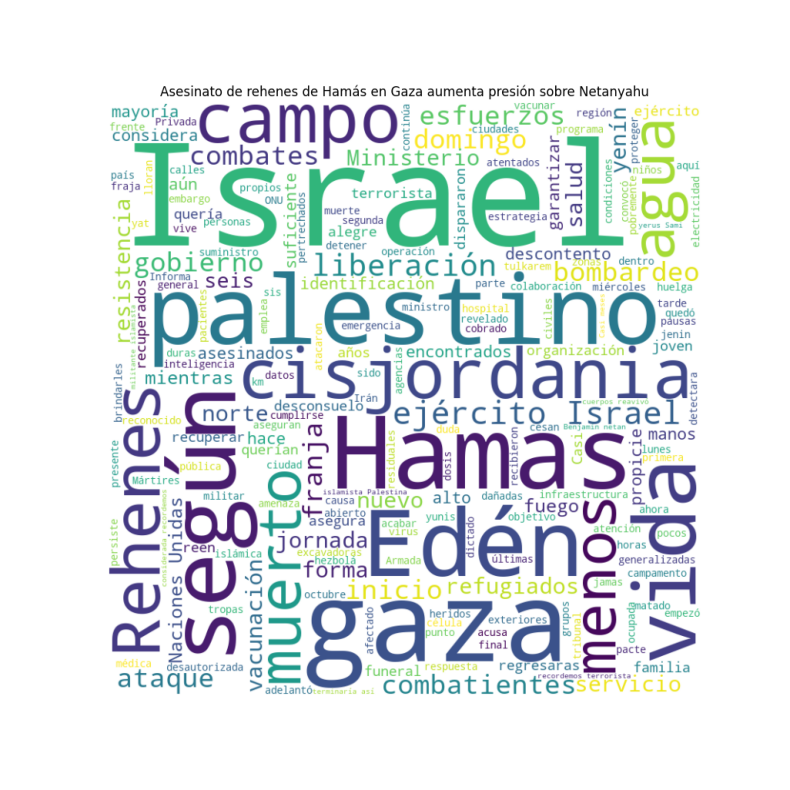

In [13]:
# Create an animation of the word clouds
fig, ax = plt.subplots(figsize=(10, 10))
ax.axis('off')

def update(frame):
    img_path = os.path.join(wordcloud_dir, f'{frame}.png')
    img = plt.imread(img_path)
    ax.clear()
    ax.imshow(img)
    ax.axis('off')
    # ax.set_title(df.iloc[frame]['video_title'], fontsize=14)

ani = animation.FuncAnimation(fig, update, frames=len(df), repeat=True)

# Save the animation
ani.save(os.path.join(output_dir, 'wordcloud_animation.gif'), writer='imagemagick', fps=3)

print(f"Word cloud animation created successfully and saved to {output_dir}/wordcloud_animation.gif")